# Image Captioning using LSTM on Flickr8K dataset

## Downloading Data and Dependencies

In [33]:
#importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from tqdm import tqdm
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from tensorflow.keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu
from numpy import array
import pickle
import numpy as np
import os
import cv2
import joblib

## Data Visualization and Preprocessing

In [34]:
import os
print(os.getcwd())

c:\Work\BITS\ImageCoaptioning\Image_Captioning


In [35]:
#converting the text files to pandas dataframe

# Define the folder path
folder_path = r"C:\Work\BITS\ImageCoaptioning\Flickr8k_text"

# Reading the files using the full path
image_tokens = pd.read_csv(f"{folder_path}\\Flickr8k.lemma.token.txt", sep='\t', names=["img_id", "img_caption"])
train_image_names = pd.read_csv(f"{folder_path}\\Flickr_8k.trainImages.txt", names=["img_id"])
test_image_names = pd.read_csv(f"{folder_path}\\Flickr_8k.testImages.txt", names=["img_id"])
val_image_names = pd.read_csv(f"{folder_path}\\Flickr_8k.devImages.txt", names=["img_id"])


In [36]:
#just checking the number of images in the dataset
folder_path_images = r"C:\Work\BITS\ImageCoaptioning\Flicker8k_Dataset"
l=os.listdir(folder_path_images)
print(len(l))

8091


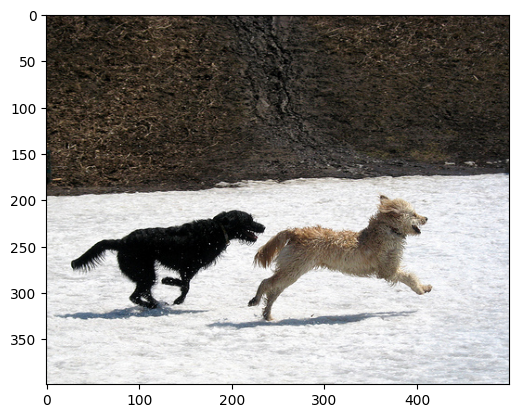

In [37]:
#visualising one of the train images
img=cv2.imread(folder_path_images+ "/" +train_image_names.img_id[0])
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [38]:
#removing the #0,#1,#2,#3,#5 from the image ids
image_tokens["img_id"]=image_tokens["img_id"].map(lambda x: x[:len(x)-2])

In [39]:
image_tokens["img_caption"]=image_tokens["img_caption"].map(lambda x: "<start> " + x.strip() + " <end>")

In [40]:
#head of the image_tokens dataframe
image_tokens.head()

img_id  \
0  1305564994_00513f9a5b.jpg   
1  1305564994_00513f9a5b.jpg   
2  1305564994_00513f9a5b.jpg   
3  1305564994_00513f9a5b.jpg   
4  1305564994_00513f9a5b.jpg   

                                         img_caption  
0  <start> A man in street racer armor be examine...  
1  <start> Two racer drive a white bike down a ro...  
2  <start> Two motorist be ride along on their ve...  
3  <start> Two person be in a small race car driv...  
4  <start> Two person in race uniform in a street...

In [41]:
#head of the train_image_names dataframe
train_image_names.head()

img_id
0  2513260012_03d33305cf.jpg
1  2903617548_d3e38d7f88.jpg
2  3338291921_fe7ae0c8f8.jpg
3   488416045_1c6d903fe0.jpg
4  2644326817_8f45080b87.jpg

### Creating dictionaries to map image_id and their corresponding captions

In [42]:
#creating train dictionary having key as the image id and value as a list of its captions
train_captions={}
for i in tqdm(range(len(train_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==train_image_names["img_id"].iloc[i]].img_caption)]
  train_captions[train_image_names["img_id"].iloc[i]]=l

100%|██████████| 6000/6000 [00:18<00:00, 316.21it/s]


In [43]:
#creating test dictionary having key as the image id and value as a list of its captions
test_captions={}
for i in tqdm(range(len(test_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==test_image_names["img_id"].iloc[i]].img_caption)]
  test_captions[test_image_names["img_id"].iloc[i]]=l

100%|██████████| 1000/1000 [00:03<00:00, 316.63it/s]


In [44]:
#creating validation dictionary having key as the image id and value as a list of its captions
validation_captions={}
for i in tqdm(range(len(val_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==val_image_names["img_id"].iloc[i]].img_caption)]
  validation_captions[val_image_names["img_id"].iloc[i]]=l

100%|██████████| 1000/1000 [00:03<00:00, 306.66it/s]


### ResNet50 model for encoding images

In [45]:
model=ResNet50(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))
model.summary()
# Serialize and save ResNet50 model
joblib.dump(model, "resnet50_model.joblib")
print("ResNet50 model saved as resnet50_model.joblib")


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

### Encoding images and forming dictionaries containing mapping of image_id to image encodings

In [46]:
#extracting image encodings(features) from resnet50 and forming dict train_features
folder_path_images = r"C:\Work\BITS\ImageCoaptioning\Flicker8k_Dataset"
path="all_images/Flicker8k_Dataset/"
train_features={}
c=0
for image_name in tqdm(train_captions):
#  img_path=path+image_name
  img_path = f"{folder_path_images}\\{image_name}"  # Construct full path to image
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  train_features[image_name]=features.squeeze()

  0%|          | 0/6000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  0%|          | 1/6000 [00:02<3:45:03,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  0%|          | 2/6000 [00:02<1:44:03,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  0%|          | 3/6000 [00:02<1:05:12,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  0%|          | 4/6000 [00:02<45:47,  2.18it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  0%|          | 5/6000 [00:02<36:04,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  0%|          | 6/6000 [00:03<29:27,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  0%|          | 7/6000 [00:03<26:23,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  0%|          | 8/6000 [00:03<22:59,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  0%|          | 9/6000 [00:03<21:15,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  0%|          | 10/6000 [00:03<20:40,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  0%|          | 11/6000 [00:04<19:36,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  0%|          | 12/6000 [00:04<19:18,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  0%|          | 13/6000 [00:04<18:09,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  0%|          | 14/6000 [00:04<18:28,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  0%|          | 15/6000 [00:04<18:22,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  0%|          | 16/6000 [00:04<17:56,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  0%|          | 17/6000 [00:05<17:55,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


  0%|          | 18/6000 [00:05<17:46,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  0%|          | 19/6000 [00:05<17:48,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


  0%|          | 20/6000 [00:05<17:39,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  0%|          | 21/6000 [00:05<17:16,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  0%|          | 22/6000 [00:06<17:56,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


  0%|          | 23/6000 [00:06<17:11,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  0%|          | 24/6000 [00:06<16:59,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  0%|          | 25/6000 [00:06<17:34,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  0%|          | 26/6000 [00:06<17:49,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  0%|          | 27/6000 [00:06<17:48,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  0%|          | 28/6000 [00:07<18:03,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  0%|          | 29/6000 [00:07<17:42,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  0%|          | 30/6000 [00:07<18:46,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  1%|          | 31/6000 [00:07<18:43,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  1%|          | 32/6000 [00:07<19:36,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  1%|          | 33/6000 [00:08<19:40,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  1%|          | 34/6000 [00:08<20:05,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  1%|          | 35/6000 [00:08<20:10,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  1%|          | 36/6000 [00:08<20:25,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


  1%|          | 37/6000 [00:08<20:52,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  1%|          | 38/6000 [00:09<20:27,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


  1%|          | 39/6000 [00:09<21:49,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  1%|          | 40/6000 [00:09<21:18,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  1%|          | 41/6000 [00:09<21:38,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  1%|          | 42/6000 [00:09<20:51,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  1%|          | 43/6000 [00:10<20:54,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  1%|          | 44/6000 [00:10<20:37,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  1%|          | 45/6000 [00:10<20:19,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  1%|          | 46/6000 [00:10<20:24,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  1%|          | 47/6000 [00:10<20:19,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  1%|          | 48/6000 [00:11<20:00,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  1%|          | 49/6000 [00:11<20:17,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  1%|          | 50/6000 [00:11<20:15,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  1%|          | 51/6000 [00:11<20:02,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  1%|          | 52/6000 [00:12<20:11,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  1%|          | 53/6000 [00:12<20:09,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  1%|          | 54/6000 [00:12<21:07,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  1%|          | 55/6000 [00:12<21:48,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


  1%|          | 56/6000 [00:12<21:46,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  1%|          | 57/6000 [00:13<22:03,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


  1%|          | 58/6000 [00:13<22:26,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


  1%|          | 59/6000 [00:13<23:51,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  1%|          | 60/6000 [00:13<25:21,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  1%|          | 61/6000 [00:14<26:08,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  1%|          | 62/6000 [00:14<26:17,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


  1%|          | 63/6000 [00:14<26:11,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


  1%|          | 64/6000 [00:15<27:49,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  1%|          | 65/6000 [00:15<27:21,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


  1%|          | 66/6000 [00:15<26:33,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


  1%|          | 67/6000 [00:15<26:58,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


  1%|          | 68/6000 [00:16<26:56,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  1%|          | 69/6000 [00:16<26:09,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  1%|          | 70/6000 [00:16<24:22,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  1%|          | 71/6000 [00:16<24:18,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  1%|          | 72/6000 [00:17<23:05,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  1%|          | 73/6000 [00:17<23:22,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


  1%|          | 74/6000 [00:17<25:47,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


  1%|▏         | 75/6000 [00:18<30:33,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  1%|▏         | 76/6000 [00:18<28:47,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  1%|▏         | 77/6000 [00:18<27:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  1%|▏         | 78/6000 [00:18<25:24,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  1%|▏         | 79/6000 [00:18<24:51,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  1%|▏         | 80/6000 [00:19<23:50,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  1%|▏         | 81/6000 [00:19<22:52,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  1%|▏         | 82/6000 [00:19<22:15,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  1%|▏         | 83/6000 [00:19<21:57,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  1%|▏         | 84/6000 [00:20<22:26,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  1%|▏         | 85/6000 [00:20<22:33,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  1%|▏         | 86/6000 [00:20<22:18,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  1%|▏         | 87/6000 [00:20<22:11,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  1%|▏         | 88/6000 [00:20<21:55,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  1%|▏         | 89/6000 [00:21<21:50,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  2%|▏         | 90/6000 [00:21<21:37,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  2%|▏         | 91/6000 [00:21<21:51,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  2%|▏         | 92/6000 [00:21<21:41,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  2%|▏         | 93/6000 [00:22<21:35,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  2%|▏         | 94/6000 [00:22<21:44,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  2%|▏         | 95/6000 [00:22<21:54,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  2%|▏         | 96/6000 [00:22<22:04,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  2%|▏         | 97/6000 [00:22<22:00,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  2%|▏         | 98/6000 [00:23<21:40,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  2%|▏         | 99/6000 [00:23<21:23,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|▏         | 100/6000 [00:23<21:23,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  2%|▏         | 101/6000 [00:23<21:30,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  2%|▏         | 102/6000 [00:24<21:38,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  2%|▏         | 103/6000 [00:24<24:03,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  2%|▏         | 104/6000 [00:24<24:30,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


  2%|▏         | 105/6000 [00:24<27:04,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


  2%|▏         | 106/6000 [00:25<26:45,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  2%|▏         | 107/6000 [00:25<25:42,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  2%|▏         | 108/6000 [00:25<25:50,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


  2%|▏         | 109/6000 [00:25<26:03,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  2%|▏         | 110/6000 [00:26<25:42,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


  2%|▏         | 111/6000 [00:26<25:18,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  2%|▏         | 112/6000 [00:26<24:25,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  2%|▏         | 113/6000 [00:26<23:40,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  2%|▏         | 114/6000 [00:27<22:56,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  2%|▏         | 115/6000 [00:27<22:25,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  2%|▏         | 116/6000 [00:27<24:01,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  2%|▏         | 117/6000 [00:27<23:27,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  2%|▏         | 118/6000 [00:28<22:58,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  2%|▏         | 119/6000 [00:28<22:23,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  2%|▏         | 120/6000 [00:28<22:09,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  2%|▏         | 121/6000 [00:28<21:50,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  2%|▏         | 122/6000 [00:28<21:42,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  2%|▏         | 123/6000 [00:29<21:32,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  2%|▏         | 124/6000 [00:29<21:27,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  2%|▏         | 125/6000 [00:29<21:26,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  2%|▏         | 126/6000 [00:29<21:14,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  2%|▏         | 127/6000 [00:30<23:57,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  2%|▏         | 128/6000 [00:30<23:50,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  2%|▏         | 129/6000 [00:30<23:02,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|▏         | 130/6000 [00:30<22:33,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  2%|▏         | 131/6000 [00:31<22:13,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  2%|▏         | 132/6000 [00:31<21:38,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  2%|▏         | 133/6000 [00:31<21:22,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  2%|▏         | 134/6000 [00:31<21:27,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  2%|▏         | 135/6000 [00:31<21:23,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  2%|▏         | 136/6000 [00:32<21:31,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  2%|▏         | 137/6000 [00:32<21:17,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  2%|▏         | 138/6000 [00:32<23:46,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  2%|▏         | 139/6000 [00:32<23:23,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  2%|▏         | 140/6000 [00:33<23:08,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|▏         | 141/6000 [00:33<22:39,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  2%|▏         | 142/6000 [00:33<22:26,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  2%|▏         | 143/6000 [00:33<23:05,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  2%|▏         | 144/6000 [00:33<22:25,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


  2%|▏         | 145/6000 [00:34<23:15,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  2%|▏         | 146/6000 [00:34<23:00,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  2%|▏         | 147/6000 [00:34<22:26,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


  2%|▏         | 148/6000 [00:34<22:56,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|▏         | 149/6000 [00:35<24:29,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  2%|▎         | 150/6000 [00:35<23:40,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  3%|▎         | 151/6000 [00:35<23:05,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|▎         | 152/6000 [00:35<22:46,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  3%|▎         | 153/6000 [00:36<22:26,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  3%|▎         | 154/6000 [00:36<21:43,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  3%|▎         | 155/6000 [00:36<21:46,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  3%|▎         | 156/6000 [00:36<21:58,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


  3%|▎         | 157/6000 [00:37<22:42,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


  3%|▎         | 158/6000 [00:37<23:31,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  3%|▎         | 159/6000 [00:37<25:01,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|▎         | 160/6000 [00:37<24:03,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|▎         | 161/6000 [00:38<23:13,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  3%|▎         | 162/6000 [00:38<22:59,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  3%|▎         | 163/6000 [00:38<22:31,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  3%|▎         | 164/6000 [00:38<22:09,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  3%|▎         | 165/6000 [00:38<22:08,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  3%|▎         | 166/6000 [00:39<21:53,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  3%|▎         | 167/6000 [00:39<22:45,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  3%|▎         | 168/6000 [00:39<22:42,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  3%|▎         | 169/6000 [00:39<24:20,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  3%|▎         | 170/6000 [00:40<23:51,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  3%|▎         | 171/6000 [00:40<23:15,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  3%|▎         | 172/6000 [00:40<22:32,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  3%|▎         | 173/6000 [00:40<22:27,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  3%|▎         | 174/6000 [00:41<22:03,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  3%|▎         | 175/6000 [00:41<22:02,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  3%|▎         | 176/6000 [00:41<22:24,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  3%|▎         | 177/6000 [00:41<21:57,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  3%|▎         | 178/6000 [00:41<21:51,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


  3%|▎         | 179/6000 [00:42<23:52,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  3%|▎         | 180/6000 [00:42<23:12,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  3%|▎         | 181/6000 [00:42<22:51,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  3%|▎         | 182/6000 [00:42<22:39,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  3%|▎         | 183/6000 [00:43<22:20,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  3%|▎         | 184/6000 [00:43<22:22,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  3%|▎         | 185/6000 [00:43<22:39,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  3%|▎         | 186/6000 [00:43<22:23,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  3%|▎         | 187/6000 [00:44<22:23,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


  3%|▎         | 188/6000 [00:44<22:24,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|▎         | 189/6000 [00:44<24:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  3%|▎         | 190/6000 [00:44<23:59,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  3%|▎         | 191/6000 [00:45<23:45,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  3%|▎         | 192/6000 [00:45<23:35,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  3%|▎         | 193/6000 [00:45<23:09,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  3%|▎         | 194/6000 [00:45<22:46,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  3%|▎         | 195/6000 [00:46<22:31,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  3%|▎         | 196/6000 [00:46<22:21,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


  3%|▎         | 197/6000 [00:46<22:18,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  3%|▎         | 198/6000 [00:46<22:09,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  3%|▎         | 199/6000 [00:46<24:12,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


  3%|▎         | 200/6000 [00:47<24:16,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  3%|▎         | 201/6000 [00:47<23:21,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  3%|▎         | 202/6000 [00:47<23:37,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  3%|▎         | 203/6000 [00:47<22:57,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  3%|▎         | 204/6000 [00:48<23:10,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


  3%|▎         | 205/6000 [00:48<23:42,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  3%|▎         | 206/6000 [00:48<23:06,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  3%|▎         | 207/6000 [00:48<22:50,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


  3%|▎         | 208/6000 [00:49<25:15,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  3%|▎         | 209/6000 [00:49<24:26,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  4%|▎         | 210/6000 [00:49<23:51,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  4%|▎         | 211/6000 [00:49<23:18,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  4%|▎         | 212/6000 [00:50<24:11,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  4%|▎         | 213/6000 [00:50<23:38,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


  4%|▎         | 214/6000 [00:50<23:29,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  4%|▎         | 215/6000 [00:50<23:42,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  4%|▎         | 216/6000 [00:51<23:08,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  4%|▎         | 217/6000 [00:51<22:49,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  4%|▎         | 218/6000 [00:51<24:36,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  4%|▎         | 219/6000 [00:51<23:33,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  4%|▎         | 220/6000 [00:52<23:08,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  4%|▎         | 221/6000 [00:52<22:50,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  4%|▎         | 222/6000 [00:52<22:19,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  4%|▎         | 223/6000 [00:52<22:29,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  4%|▎         | 224/6000 [00:53<22:30,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  4%|▍         | 225/6000 [00:53<22:15,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  4%|▍         | 226/6000 [00:53<21:53,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


  4%|▍         | 227/6000 [00:53<23:57,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  4%|▍         | 228/6000 [00:54<23:16,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  4%|▍         | 229/6000 [00:54<23:03,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  4%|▍         | 230/6000 [00:54<23:09,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


  4%|▍         | 231/6000 [00:54<23:48,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  4%|▍         | 232/6000 [00:54<23:21,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  4%|▍         | 233/6000 [00:55<23:03,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  4%|▍         | 234/6000 [00:55<22:53,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  4%|▍         | 235/6000 [00:55<22:32,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  4%|▍         | 236/6000 [00:55<24:22,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  4%|▍         | 237/6000 [00:56<23:29,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  4%|▍         | 238/6000 [00:56<23:39,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  4%|▍         | 239/6000 [00:56<22:50,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  4%|▍         | 240/6000 [00:56<22:59,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


  4%|▍         | 241/6000 [00:57<22:43,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


  4%|▍         | 242/6000 [00:57<22:34,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  4%|▍         | 243/6000 [00:57<22:23,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  4%|▍         | 244/6000 [00:57<22:29,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


  4%|▍         | 245/6000 [00:58<24:52,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  4%|▍         | 246/6000 [00:58<24:21,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  4%|▍         | 247/6000 [00:58<23:36,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  4%|▍         | 248/6000 [00:58<23:15,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


  4%|▍         | 249/6000 [00:59<23:19,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


  4%|▍         | 250/6000 [00:59<22:42,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  4%|▍         | 251/6000 [00:59<22:30,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  4%|▍         | 252/6000 [00:59<21:49,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  4%|▍         | 253/6000 [01:00<22:17,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


  4%|▍         | 254/6000 [01:00<25:42,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


  4%|▍         | 255/6000 [01:00<29:10,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


  4%|▍         | 256/6000 [01:01<29:19,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  4%|▍         | 257/6000 [01:01<28:53,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


  4%|▍         | 258/6000 [01:01<30:44,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  4%|▍         | 259/6000 [01:02<29:45,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


  4%|▍         | 260/6000 [01:02<29:35,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


  4%|▍         | 261/6000 [01:02<32:29,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


  4%|▍         | 262/6000 [01:03<31:11,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  4%|▍         | 263/6000 [01:03<30:03,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  4%|▍         | 264/6000 [01:03<29:31,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  4%|▍         | 265/6000 [01:03<26:23,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  4%|▍         | 266/6000 [01:04<26:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


  4%|▍         | 267/6000 [01:04<24:31,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


  4%|▍         | 268/6000 [01:04<24:37,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


  4%|▍         | 269/6000 [01:04<23:36,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  4%|▍         | 270/6000 [01:04<22:31,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  5%|▍         | 271/6000 [01:05<22:27,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|▍         | 272/6000 [01:05<21:47,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  5%|▍         | 273/6000 [01:05<21:12,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  5%|▍         | 274/6000 [01:05<20:58,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  5%|▍         | 275/6000 [01:06<20:18,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  5%|▍         | 276/6000 [01:06<20:42,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  5%|▍         | 277/6000 [01:06<21:06,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  5%|▍         | 278/6000 [01:06<20:52,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  5%|▍         | 279/6000 [01:06<20:40,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  5%|▍         | 280/6000 [01:07<20:26,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  5%|▍         | 281/6000 [01:07<19:54,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  5%|▍         | 282/6000 [01:07<19:52,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  5%|▍         | 283/6000 [01:07<19:50,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


  5%|▍         | 284/6000 [01:07<20:40,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


  5%|▍         | 285/6000 [01:08<21:14,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  5%|▍         | 286/6000 [01:08<21:02,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


  5%|▍         | 287/6000 [01:08<22:58,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  5%|▍         | 288/6000 [01:08<22:24,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


  5%|▍         | 289/6000 [01:09<22:24,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  5%|▍         | 290/6000 [01:09<23:30,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  5%|▍         | 291/6000 [01:09<23:54,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  5%|▍         | 292/6000 [01:09<23:02,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  5%|▍         | 293/6000 [01:10<22:07,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|▍         | 294/6000 [01:10<21:16,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  5%|▍         | 295/6000 [01:10<21:00,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


  5%|▍         | 296/6000 [01:10<22:08,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


  5%|▍         | 297/6000 [01:11<24:33,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  5%|▍         | 298/6000 [01:11<23:07,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  5%|▍         | 299/6000 [01:11<22:10,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  5%|▌         | 300/6000 [01:11<21:21,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  5%|▌         | 301/6000 [01:11<20:36,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  5%|▌         | 302/6000 [01:12<20:15,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  5%|▌         | 303/6000 [01:12<20:03,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  5%|▌         | 304/6000 [01:12<19:34,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  5%|▌         | 305/6000 [01:12<20:12,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  5%|▌         | 306/6000 [01:13<21:50,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  5%|▌         | 307/6000 [01:13<22:33,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


  5%|▌         | 308/6000 [01:13<24:33,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  5%|▌         | 309/6000 [01:13<23:14,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  5%|▌         | 310/6000 [01:14<23:52,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  5%|▌         | 311/6000 [01:14<24:56,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


  5%|▌         | 312/6000 [01:14<24:31,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  5%|▌         | 313/6000 [01:14<24:17,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


  5%|▌         | 314/6000 [01:15<24:53,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  5%|▌         | 315/6000 [01:15<25:00,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


  5%|▌         | 316/6000 [01:15<25:00,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


  5%|▌         | 317/6000 [01:15<24:23,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  5%|▌         | 318/6000 [01:16<26:05,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


  5%|▌         | 319/6000 [01:16<25:17,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  5%|▌         | 320/6000 [01:16<24:55,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


  5%|▌         | 321/6000 [01:17<28:02,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  5%|▌         | 322/6000 [01:17<27:02,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


  5%|▌         | 323/6000 [01:17<25:46,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|▌         | 324/6000 [01:17<24:19,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  5%|▌         | 325/6000 [01:18<22:55,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  5%|▌         | 326/6000 [01:18<22:03,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


  5%|▌         | 327/6000 [01:18<22:49,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  5%|▌         | 328/6000 [01:18<24:38,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


  5%|▌         | 329/6000 [01:19<23:42,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


  6%|▌         | 330/6000 [01:19<23:43,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|▌         | 331/6000 [01:19<23:36,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  6%|▌         | 332/6000 [01:19<22:27,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  6%|▌         | 333/6000 [01:19<21:20,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  6%|▌         | 334/6000 [01:20<20:53,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  6%|▌         | 335/6000 [01:20<22:28,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


  6%|▌         | 336/6000 [01:20<22:42,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  6%|▌         | 337/6000 [01:20<21:47,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  6%|▌         | 338/6000 [01:21<22:25,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


  6%|▌         | 339/6000 [01:21<23:36,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


  6%|▌         | 340/6000 [01:21<24:32,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  6%|▌         | 341/6000 [01:22<25:28,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


  6%|▌         | 342/6000 [01:22<24:43,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  6%|▌         | 343/6000 [01:22<25:12,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


  6%|▌         | 344/6000 [01:22<25:11,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


  6%|▌         | 345/6000 [01:23<27:35,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  6%|▌         | 346/6000 [01:23<25:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


  6%|▌         | 347/6000 [01:23<25:47,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  6%|▌         | 348/6000 [01:23<24:24,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


  6%|▌         | 349/6000 [01:24<23:56,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  6%|▌         | 350/6000 [01:24<22:38,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  6%|▌         | 351/6000 [01:24<21:36,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  6%|▌         | 352/6000 [01:24<21:22,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  6%|▌         | 353/6000 [01:24<20:53,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  6%|▌         | 354/6000 [01:25<20:47,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  6%|▌         | 355/6000 [01:25<21:05,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  6%|▌         | 356/6000 [01:25<21:21,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


  6%|▌         | 357/6000 [01:25<22:21,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  6%|▌         | 358/6000 [01:26<22:01,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  6%|▌         | 359/6000 [01:26<21:33,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  6%|▌         | 360/6000 [01:26<21:16,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  6%|▌         | 361/6000 [01:26<20:56,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


  6%|▌         | 362/6000 [01:27<21:28,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  6%|▌         | 363/6000 [01:27<20:45,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


  6%|▌         | 364/6000 [01:27<20:48,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  6%|▌         | 365/6000 [01:27<20:18,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


  6%|▌         | 366/6000 [01:27<22:14,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  6%|▌         | 367/6000 [01:28<22:31,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  6%|▌         | 368/6000 [01:28<21:34,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


  6%|▌         | 369/6000 [01:28<21:02,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  6%|▌         | 370/6000 [01:28<20:14,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


  6%|▌         | 371/6000 [01:29<20:50,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  6%|▌         | 372/6000 [01:29<20:35,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|▌         | 373/6000 [01:29<20:04,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  6%|▌         | 374/6000 [01:29<19:35,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


  6%|▋         | 375/6000 [01:29<21:15,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  6%|▋         | 376/6000 [01:30<20:33,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  6%|▋         | 377/6000 [01:30<20:00,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


  6%|▋         | 378/6000 [01:30<20:44,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  6%|▋         | 379/6000 [01:30<20:23,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  6%|▋         | 380/6000 [01:31<20:27,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  6%|▋         | 381/6000 [01:31<20:18,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  6%|▋         | 382/6000 [01:31<20:01,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  6%|▋         | 383/6000 [01:31<19:56,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  6%|▋         | 384/6000 [01:31<21:50,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  6%|▋         | 385/6000 [01:32<20:56,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


  6%|▋         | 386/6000 [01:32<21:45,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  6%|▋         | 387/6000 [01:32<20:47,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  6%|▋         | 388/6000 [01:32<20:35,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  6%|▋         | 389/6000 [01:33<20:27,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  6%|▋         | 390/6000 [01:33<20:23,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


  7%|▋         | 391/6000 [01:33<20:50,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  7%|▋         | 392/6000 [01:33<20:10,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


  7%|▋         | 393/6000 [01:33<22:38,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  7%|▋         | 394/6000 [01:34<21:51,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  7%|▋         | 395/6000 [01:34<21:20,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  7%|▋         | 396/6000 [01:34<21:16,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|▋         | 397/6000 [01:34<20:41,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


  7%|▋         | 398/6000 [01:35<21:05,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  7%|▋         | 399/6000 [01:35<20:42,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  7%|▋         | 400/6000 [01:35<20:53,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  7%|▋         | 401/6000 [01:35<19:55,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  7%|▋         | 402/6000 [01:36<22:31,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  7%|▋         | 403/6000 [01:36<22:13,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  7%|▋         | 404/6000 [01:36<21:28,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  7%|▋         | 405/6000 [01:36<21:05,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  7%|▋         | 406/6000 [01:36<20:14,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  7%|▋         | 407/6000 [01:37<20:18,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  7%|▋         | 408/6000 [01:37<20:39,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  7%|▋         | 409/6000 [01:37<20:14,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


  7%|▋         | 410/6000 [01:37<20:28,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


  7%|▋         | 411/6000 [01:38<22:22,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  7%|▋         | 412/6000 [01:38<22:15,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  7%|▋         | 413/6000 [01:38<21:30,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  7%|▋         | 414/6000 [01:38<21:20,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  7%|▋         | 415/6000 [01:38<20:21,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  7%|▋         | 416/6000 [01:39<19:47,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  7%|▋         | 417/6000 [01:39<19:29,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


  7%|▋         | 418/6000 [01:39<20:13,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


  7%|▋         | 419/6000 [01:39<21:34,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


  7%|▋         | 420/6000 [01:40<21:40,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  7%|▋         | 421/6000 [01:40<21:30,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  7%|▋         | 422/6000 [01:40<20:46,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  7%|▋         | 423/6000 [01:40<20:24,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  7%|▋         | 424/6000 [01:40<19:56,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  7%|▋         | 425/6000 [01:41<19:35,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  7%|▋         | 426/6000 [01:41<19:43,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  7%|▋         | 427/6000 [01:41<19:21,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  7%|▋         | 428/6000 [01:41<20:57,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  7%|▋         | 429/6000 [01:41<20:40,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  7%|▋         | 430/6000 [01:42<20:29,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  7%|▋         | 431/6000 [01:42<20:28,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  7%|▋         | 432/6000 [01:42<19:53,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  7%|▋         | 433/6000 [01:42<19:29,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  7%|▋         | 434/6000 [01:43<19:08,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  7%|▋         | 435/6000 [01:43<19:32,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


  7%|▋         | 436/6000 [01:43<20:04,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|▋         | 437/6000 [01:43<20:31,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  7%|▋         | 438/6000 [01:43<19:58,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  7%|▋         | 439/6000 [01:44<19:30,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


  7%|▋         | 440/6000 [01:44<19:39,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  7%|▋         | 441/6000 [01:44<19:42,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  7%|▋         | 442/6000 [01:44<19:55,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  7%|▋         | 443/6000 [01:44<20:06,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  7%|▋         | 444/6000 [01:45<19:50,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  7%|▋         | 445/6000 [01:45<21:21,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  7%|▋         | 446/6000 [01:45<20:59,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  7%|▋         | 447/6000 [01:45<20:34,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  7%|▋         | 448/6000 [01:46<20:15,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


  7%|▋         | 449/6000 [01:46<20:10,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  8%|▊         | 450/6000 [01:46<20:00,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  8%|▊         | 451/6000 [01:46<19:50,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  8%|▊         | 452/6000 [01:46<19:29,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


  8%|▊         | 453/6000 [01:47<21:26,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  8%|▊         | 454/6000 [01:47<20:50,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  8%|▊         | 455/6000 [01:47<20:30,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  8%|▊         | 456/6000 [01:47<19:46,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  8%|▊         | 457/6000 [01:48<19:51,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  8%|▊         | 458/6000 [01:48<19:58,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  8%|▊         | 459/6000 [01:48<20:22,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  8%|▊         | 460/6000 [01:48<20:15,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


  8%|▊         | 461/6000 [01:48<21:23,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  8%|▊         | 462/6000 [01:49<20:41,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  8%|▊         | 463/6000 [01:49<21:04,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  8%|▊         | 464/6000 [01:49<20:34,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


  8%|▊         | 465/6000 [01:49<20:29,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  8%|▊         | 466/6000 [01:50<20:30,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


  8%|▊         | 467/6000 [01:50<21:59,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|▊         | 468/6000 [01:50<21:18,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  8%|▊         | 469/6000 [01:50<20:30,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  8%|▊         | 470/6000 [01:50<19:48,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  8%|▊         | 471/6000 [01:51<19:55,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  8%|▊         | 472/6000 [01:51<20:04,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  8%|▊         | 473/6000 [01:51<19:25,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  8%|▊         | 474/6000 [01:51<19:04,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  8%|▊         | 475/6000 [01:52<20:44,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


  8%|▊         | 476/6000 [01:52<20:28,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  8%|▊         | 477/6000 [01:52<20:18,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  8%|▊         | 478/6000 [01:52<19:44,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  8%|▊         | 479/6000 [01:52<19:24,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  8%|▊         | 480/6000 [01:53<19:07,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  8%|▊         | 481/6000 [01:53<19:13,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  8%|▊         | 482/6000 [01:53<19:25,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  8%|▊         | 483/6000 [01:53<20:57,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  8%|▊         | 484/6000 [01:54<20:43,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  8%|▊         | 485/6000 [01:54<20:33,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  8%|▊         | 486/6000 [01:54<21:36,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


  8%|▊         | 487/6000 [01:54<22:59,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


  8%|▊         | 488/6000 [01:55<23:32,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


  8%|▊         | 489/6000 [01:55<24:14,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


  8%|▊         | 490/6000 [01:55<26:47,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  8%|▊         | 491/6000 [01:55<25:47,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


  8%|▊         | 492/6000 [01:56<25:19,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  8%|▊         | 493/6000 [01:56<24:42,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


  8%|▊         | 494/6000 [01:56<25:32,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  8%|▊         | 495/6000 [01:56<23:47,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  8%|▊         | 496/6000 [01:57<22:36,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


  8%|▊         | 497/6000 [01:57<26:52,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


  8%|▊         | 498/6000 [01:57<25:21,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


  8%|▊         | 499/6000 [01:58<24:29,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


  8%|▊         | 500/6000 [01:58<25:34,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  8%|▊         | 501/6000 [01:58<25:30,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  8%|▊         | 502/6000 [01:58<24:17,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


  8%|▊         | 503/6000 [01:59<23:38,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


  8%|▊         | 504/6000 [01:59<29:50,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  8%|▊         | 505/6000 [01:59<29:07,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


  8%|▊         | 506/6000 [02:00<27:50,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  8%|▊         | 507/6000 [02:00<27:19,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


  8%|▊         | 508/6000 [02:00<27:02,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


  8%|▊         | 509/6000 [02:01<26:26,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  8%|▊         | 510/6000 [02:01<26:04,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


  9%|▊         | 511/6000 [02:01<28:15,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


  9%|▊         | 512/6000 [02:01<28:04,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


  9%|▊         | 513/6000 [02:02<28:11,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


  9%|▊         | 514/6000 [02:02<26:32,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  9%|▊         | 515/6000 [02:02<26:37,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


  9%|▊         | 516/6000 [02:03<26:38,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


  9%|▊         | 517/6000 [02:03<28:01,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


  9%|▊         | 518/6000 [02:03<29:35,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  9%|▊         | 519/6000 [02:04<28:41,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  9%|▊         | 520/6000 [02:04<27:43,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  9%|▊         | 521/6000 [02:04<26:16,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


  9%|▊         | 522/6000 [02:04<26:29,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


  9%|▊         | 523/6000 [02:05<30:09,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  9%|▊         | 524/6000 [02:05<29:12,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  9%|▉         | 525/6000 [02:06<31:17,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  9%|▉         | 526/6000 [02:06<28:09,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  9%|▉         | 527/6000 [02:06<27:48,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


  9%|▉         | 528/6000 [02:06<26:01,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  9%|▉         | 529/6000 [02:07<24:13,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  9%|▉         | 530/6000 [02:07<22:55,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  9%|▉         | 531/6000 [02:07<21:35,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


  9%|▉         | 532/6000 [02:07<24:45,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


  9%|▉         | 533/6000 [02:08<24:43,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  9%|▉         | 534/6000 [02:08<24:50,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


  9%|▉         | 535/6000 [02:08<27:37,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  9%|▉         | 536/6000 [02:09<28:01,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  9%|▉         | 537/6000 [02:09<27:17,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  9%|▉         | 538/6000 [02:09<27:06,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


  9%|▉         | 539/6000 [02:10<29:10,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


  9%|▉         | 540/6000 [02:10<27:45,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


  9%|▉         | 541/6000 [02:10<26:25,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  9%|▉         | 542/6000 [02:10<24:37,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  9%|▉         | 543/6000 [02:10<22:41,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  9%|▉         | 544/6000 [02:11<21:15,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


  9%|▉         | 545/6000 [02:11<22:12,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


  9%|▉         | 546/6000 [02:11<25:36,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  9%|▉         | 547/6000 [02:12<24:16,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  9%|▉         | 548/6000 [02:12<22:53,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


  9%|▉         | 549/6000 [02:12<22:45,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  9%|▉         | 550/6000 [02:12<22:29,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  9%|▉         | 551/6000 [02:12<21:30,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


  9%|▉         | 552/6000 [02:13<22:13,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  9%|▉         | 553/6000 [02:13<23:49,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  9%|▉         | 554/6000 [02:13<22:44,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


  9%|▉         | 555/6000 [02:13<22:14,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


  9%|▉         | 556/6000 [02:14<22:10,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


  9%|▉         | 557/6000 [02:14<23:09,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  9%|▉         | 558/6000 [02:14<22:25,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  9%|▉         | 559/6000 [02:14<21:23,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


  9%|▉         | 560/6000 [02:15<23:30,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


  9%|▉         | 561/6000 [02:15<24:49,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


  9%|▉         | 562/6000 [02:15<25:38,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  9%|▉         | 563/6000 [02:16<25:08,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  9%|▉         | 564/6000 [02:16<24:33,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  9%|▉         | 565/6000 [02:16<23:44,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  9%|▉         | 566/6000 [02:16<23:15,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  9%|▉         | 567/6000 [02:17<24:36,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


  9%|▉         | 568/6000 [02:17<25:18,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  9%|▉         | 569/6000 [02:17<25:27,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 10%|▉         | 570/6000 [02:18<26:00,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 10%|▉         | 571/6000 [02:18<25:51,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 10%|▉         | 572/6000 [02:18<25:26,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 10%|▉         | 573/6000 [02:18<27:34,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 10%|▉         | 574/6000 [02:19<28:17,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 10%|▉         | 575/6000 [02:19<29:04,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 10%|▉         | 576/6000 [02:19<27:03,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 10%|▉         | 577/6000 [02:20<25:58,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 10%|▉         | 578/6000 [02:20<24:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 10%|▉         | 579/6000 [02:20<23:56,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 10%|▉         | 580/6000 [02:20<23:56,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 10%|▉         | 581/6000 [02:21<25:52,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 10%|▉         | 582/6000 [02:21<24:19,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 10%|▉         | 583/6000 [02:21<23:34,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 10%|▉         | 584/6000 [02:21<23:31,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 10%|▉         | 585/6000 [02:22<23:27,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 10%|▉         | 586/6000 [02:22<23:33,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 10%|▉         | 587/6000 [02:22<24:04,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 10%|▉         | 588/6000 [02:23<26:08,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 10%|▉         | 589/6000 [02:23<25:19,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 10%|▉         | 590/6000 [02:23<25:15,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 10%|▉         | 591/6000 [02:23<24:36,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 10%|▉         | 592/6000 [02:24<23:46,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 10%|▉         | 593/6000 [02:24<23:19,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 10%|▉         | 594/6000 [02:24<22:40,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 10%|▉         | 595/6000 [02:24<24:59,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 10%|▉         | 596/6000 [02:25<23:47,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 10%|▉         | 597/6000 [02:25<23:11,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 10%|▉         | 598/6000 [02:25<22:36,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 10%|▉         | 599/6000 [02:25<22:20,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 10%|█         | 600/6000 [02:26<21:57,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 10%|█         | 601/6000 [02:26<21:35,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 10%|█         | 602/6000 [02:26<23:44,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 10%|█         | 603/6000 [02:26<23:53,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 10%|█         | 604/6000 [02:27<23:48,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 10%|█         | 605/6000 [02:27<23:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 10%|█         | 606/6000 [02:27<22:17,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 10%|█         | 607/6000 [02:28<24:59,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 10%|█         | 608/6000 [02:28<27:31,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 10%|█         | 609/6000 [02:28<25:10,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 10%|█         | 610/6000 [02:28<23:12,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 10%|█         | 611/6000 [02:29<22:13,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 10%|█         | 612/6000 [02:29<21:13,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 10%|█         | 613/6000 [02:29<20:25,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 10%|█         | 614/6000 [02:29<21:43,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 10%|█         | 615/6000 [02:29<20:54,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 10%|█         | 616/6000 [02:30<20:12,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 10%|█         | 617/6000 [02:30<19:45,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 10%|█         | 618/6000 [02:30<19:31,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 10%|█         | 619/6000 [02:30<19:35,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 10%|█         | 620/6000 [02:31<19:44,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 10%|█         | 621/6000 [02:31<21:36,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 10%|█         | 622/6000 [02:31<20:42,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 10%|█         | 623/6000 [02:31<20:07,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 10%|█         | 624/6000 [02:31<19:42,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 10%|█         | 625/6000 [02:32<19:30,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 10%|█         | 626/6000 [02:32<19:48,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 10%|█         | 627/6000 [02:32<20:14,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 10%|█         | 628/6000 [02:32<21:18,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 10%|█         | 629/6000 [02:33<20:45,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 10%|█         | 630/6000 [02:33<20:14,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 11%|█         | 631/6000 [02:33<19:37,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 11%|█         | 632/6000 [02:33<19:30,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 11%|█         | 633/6000 [02:33<19:26,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 11%|█         | 634/6000 [02:34<20:55,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 11%|█         | 635/6000 [02:34<21:16,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 11%|█         | 636/6000 [02:34<21:25,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 11%|█         | 637/6000 [02:34<20:48,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 11%|█         | 638/6000 [02:35<21:50,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 11%|█         | 639/6000 [02:35<24:16,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 11%|█         | 640/6000 [02:35<25:08,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 11%|█         | 641/6000 [02:36<26:33,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 11%|█         | 642/6000 [02:36<25:00,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 11%|█         | 643/6000 [02:36<24:22,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 11%|█         | 644/6000 [02:36<23:14,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 11%|█         | 645/6000 [02:37<22:52,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 11%|█         | 646/6000 [02:37<21:45,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 11%|█         | 647/6000 [02:37<23:40,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 11%|█         | 648/6000 [02:37<22:58,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 11%|█         | 649/6000 [02:38<22:20,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 11%|█         | 650/6000 [02:38<23:17,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 11%|█         | 651/6000 [02:38<22:44,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 11%|█         | 652/6000 [02:38<22:19,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 11%|█         | 653/6000 [02:39<21:39,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 11%|█         | 654/6000 [02:39<22:54,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 11%|█         | 655/6000 [02:39<22:31,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 11%|█         | 656/6000 [02:39<21:58,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 11%|█         | 657/6000 [02:40<22:07,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 11%|█         | 658/6000 [02:40<21:51,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 11%|█         | 659/6000 [02:40<21:01,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 11%|█         | 660/6000 [02:41<24:07,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 11%|█         | 661/6000 [02:41<27:21,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 11%|█         | 662/6000 [02:41<27:35,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 11%|█         | 663/6000 [02:41<26:28,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 11%|█         | 664/6000 [02:42<25:57,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 11%|█         | 665/6000 [02:42<25:32,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 11%|█         | 666/6000 [02:42<25:56,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 11%|█         | 667/6000 [02:43<28:24,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 11%|█         | 668/6000 [02:43<27:15,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 11%|█         | 669/6000 [02:43<25:56,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 11%|█         | 670/6000 [02:44<24:56,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 11%|█         | 671/6000 [02:44<24:02,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 11%|█         | 672/6000 [02:44<23:47,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 11%|█         | 673/6000 [02:44<28:39,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 11%|█         | 674/6000 [02:45<27:56,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 11%|█▏        | 675/6000 [02:45<27:37,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 11%|█▏        | 676/6000 [02:45<27:07,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 11%|█▏        | 677/6000 [02:46<24:42,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 11%|█▏        | 678/6000 [02:46<23:26,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 11%|█▏        | 679/6000 [02:46<23:16,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 11%|█▏        | 680/6000 [02:46<21:58,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 11%|█▏        | 681/6000 [02:46<20:54,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 11%|█▏        | 682/6000 [02:47<20:27,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 11%|█▏        | 683/6000 [02:47<21:01,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 11%|█▏        | 684/6000 [02:48<43:59,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 11%|█▏        | 685/6000 [02:49<50:51,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 11%|█▏        | 686/6000 [02:50<53:55,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 11%|█▏        | 687/6000 [02:50<54:34,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 11%|█▏        | 688/6000 [02:51<53:21,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 11%|█▏        | 689/6000 [02:51<49:59,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step


 12%|█▏        | 690/6000 [02:52<58:25,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 12%|█▏        | 691/6000 [02:53<59:46,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 12%|█▏        | 692/6000 [02:53<52:59,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 12%|█▏        | 693/6000 [02:54<49:58,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 12%|█▏        | 694/6000 [02:54<45:19,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 12%|█▏        | 695/6000 [02:54<41:34,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 12%|█▏        | 696/6000 [02:55<40:03,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 12%|█▏        | 697/6000 [02:55<38:22,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 12%|█▏        | 698/6000 [02:56<36:31,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 12%|█▏        | 699/6000 [02:56<33:24,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 12%|█▏        | 700/6000 [02:56<30:03,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 12%|█▏        | 701/6000 [02:56<27:44,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 12%|█▏        | 702/6000 [02:57<29:06,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 12%|█▏        | 703/6000 [02:57<30:47,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 12%|█▏        | 704/6000 [02:58<30:08,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 12%|█▏        | 705/6000 [02:58<28:08,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 12%|█▏        | 706/6000 [02:58<27:10,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 12%|█▏        | 707/6000 [02:58<27:13,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 12%|█▏        | 708/6000 [02:59<29:53,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 12%|█▏        | 709/6000 [02:59<30:25,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 12%|█▏        | 710/6000 [02:59<30:06,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 12%|█▏        | 711/6000 [03:00<30:32,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 12%|█▏        | 712/6000 [03:00<29:53,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 12%|█▏        | 713/6000 [03:00<29:15,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 12%|█▏        | 714/6000 [03:01<31:54,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 12%|█▏        | 715/6000 [03:01<31:38,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 12%|█▏        | 716/6000 [03:02<29:03,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 12%|█▏        | 717/6000 [03:02<27:07,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 12%|█▏        | 718/6000 [03:02<26:04,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 12%|█▏        | 719/6000 [03:02<25:21,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 12%|█▏        | 720/6000 [03:03<26:17,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 12%|█▏        | 721/6000 [03:03<25:27,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 12%|█▏        | 722/6000 [03:03<24:46,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 12%|█▏        | 723/6000 [03:03<24:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 12%|█▏        | 724/6000 [03:04<23:44,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 12%|█▏        | 725/6000 [03:04<23:37,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 12%|█▏        | 726/6000 [03:04<24:50,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 12%|█▏        | 727/6000 [03:05<24:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 12%|█▏        | 728/6000 [03:05<25:56,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 12%|█▏        | 729/6000 [03:05<25:30,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 12%|█▏        | 730/6000 [03:05<24:57,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 12%|█▏        | 731/6000 [03:06<24:31,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 12%|█▏        | 732/6000 [03:06<28:36,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 12%|█▏        | 733/6000 [03:07<31:44,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 12%|█▏        | 734/6000 [03:07<32:49,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 12%|█▏        | 735/6000 [03:07<33:36,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 12%|█▏        | 736/6000 [03:08<35:20,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 12%|█▏        | 737/6000 [03:08<36:38,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 12%|█▏        | 738/6000 [03:09<37:22,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 12%|█▏        | 739/6000 [03:09<35:27,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 12%|█▏        | 740/6000 [03:09<33:36,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 12%|█▏        | 741/6000 [03:10<33:34,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 12%|█▏        | 742/6000 [03:10<37:47,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 12%|█▏        | 743/6000 [03:11<36:09,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 12%|█▏        | 744/6000 [03:11<38:09,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 12%|█▏        | 745/6000 [03:12<37:26,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 12%|█▏        | 746/6000 [03:12<37:18,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 12%|█▏        | 747/6000 [03:12<36:46,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 12%|█▏        | 748/6000 [03:13<36:30,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 12%|█▏        | 749/6000 [03:13<41:19,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 12%|█▎        | 750/6000 [03:14<41:54,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 13%|█▎        | 751/6000 [03:15<45:11,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 13%|█▎        | 752/6000 [03:15<49:38,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 13%|█▎        | 753/6000 [03:16<49:30,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step


 13%|█▎        | 754/6000 [03:17<58:55,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


 13%|█▎        | 755/6000 [03:17<58:54,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 13%|█▎        | 756/6000 [03:18<1:07:12,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step


 13%|█▎        | 757/6000 [03:20<1:19:40,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


 13%|█▎        | 758/6000 [03:20<1:18:00,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 13%|█▎        | 759/6000 [03:21<1:17:06,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 13%|█▎        | 760/6000 [03:22<1:09:05,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 13%|█▎        | 761/6000 [03:23<1:04:40,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 13%|█▎        | 762/6000 [03:23<57:44,  1.51it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 13%|█▎        | 763/6000 [03:23<51:04,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 13%|█▎        | 764/6000 [03:24<48:39,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 13%|█▎        | 765/6000 [03:24<48:48,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 13%|█▎        | 766/6000 [03:25<49:25,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 13%|█▎        | 767/6000 [03:26<48:59,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 13%|█▎        | 768/6000 [03:26<42:49,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 13%|█▎        | 769/6000 [03:26<39:53,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 13%|█▎        | 770/6000 [03:27<40:12,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 13%|█▎        | 771/6000 [03:27<42:13,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 13%|█▎        | 772/6000 [03:28<45:10,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 13%|█▎        | 773/6000 [03:28<43:52,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 13%|█▎        | 774/6000 [03:29<43:41,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 13%|█▎        | 775/6000 [03:30<48:00,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 13%|█▎        | 776/6000 [03:30<44:33,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 13%|█▎        | 777/6000 [03:30<41:55,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 13%|█▎        | 778/6000 [03:31<41:42,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 13%|█▎        | 779/6000 [03:31<40:53,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 13%|█▎        | 780/6000 [03:32<40:20,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


 13%|█▎        | 781/6000 [03:32<45:33,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 13%|█▎        | 782/6000 [03:33<42:03,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 13%|█▎        | 783/6000 [03:33<39:38,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 13%|█▎        | 784/6000 [03:34<37:18,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 13%|█▎        | 785/6000 [03:34<38:52,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 13%|█▎        | 786/6000 [03:35<42:52,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 13%|█▎        | 787/6000 [03:35<42:37,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 13%|█▎        | 788/6000 [03:36<41:52,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 13%|█▎        | 789/6000 [03:36<42:24,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 13%|█▎        | 790/6000 [03:37<43:28,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 13%|█▎        | 791/6000 [03:37<41:51,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 13%|█▎        | 792/6000 [03:38<50:23,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 13%|█▎        | 793/6000 [03:38<45:20,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 13%|█▎        | 794/6000 [03:39<41:28,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 13%|█▎        | 795/6000 [03:39<37:14,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 13%|█▎        | 796/6000 [03:39<34:36,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 13%|█▎        | 797/6000 [03:40<43:03,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 13%|█▎        | 798/6000 [03:40<42:10,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 13%|█▎        | 799/6000 [03:41<40:09,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 13%|█▎        | 800/6000 [03:41<40:40,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 13%|█▎        | 801/6000 [03:42<39:47,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 13%|█▎        | 802/6000 [03:42<41:16,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 13%|█▎        | 803/6000 [03:43<41:53,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 13%|█▎        | 804/6000 [03:43<40:04,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 13%|█▎        | 805/6000 [03:44<39:39,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 13%|█▎        | 806/6000 [03:44<40:33,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 13%|█▎        | 807/6000 [03:45<44:35,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 13%|█▎        | 808/6000 [03:45<43:34,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 13%|█▎        | 809/6000 [03:46<45:18,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 14%|█▎        | 810/6000 [03:46<43:42,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 14%|█▎        | 811/6000 [03:47<42:36,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 14%|█▎        | 812/6000 [03:47<42:42,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 14%|█▎        | 813/6000 [03:48<45:35,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 14%|█▎        | 814/6000 [03:48<42:22,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 14%|█▎        | 815/6000 [03:49<40:21,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 14%|█▎        | 816/6000 [03:49<38:43,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 14%|█▎        | 817/6000 [03:50<39:57,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


 14%|█▎        | 818/6000 [03:50<45:08,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 14%|█▎        | 819/6000 [03:51<47:42,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 14%|█▎        | 820/6000 [03:51<47:48,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 14%|█▎        | 821/6000 [03:52<50:21,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 14%|█▎        | 822/6000 [03:53<48:47,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 14%|█▎        | 823/6000 [03:53<52:39,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 14%|█▎        | 824/6000 [03:54<50:04,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 14%|█▍        | 825/6000 [03:54<50:12,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 14%|█▍        | 826/6000 [03:55<48:01,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 14%|█▍        | 827/6000 [03:56<53:53,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 14%|█▍        | 828/6000 [03:56<57:42,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 14%|█▍        | 829/6000 [03:57<52:16,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 14%|█▍        | 830/6000 [03:57<48:19,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 14%|█▍        | 831/6000 [03:58<49:59,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 14%|█▍        | 832/6000 [03:58<47:10,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 14%|█▍        | 833/6000 [03:59<58:16,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 14%|█▍        | 834/6000 [04:00<55:46,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 14%|█▍        | 835/6000 [04:00<49:48,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 14%|█▍        | 836/6000 [04:01<47:52,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 14%|█▍        | 837/6000 [04:02<49:42,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 14%|█▍        | 838/6000 [04:02<51:48,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 14%|█▍        | 839/6000 [04:03<47:16,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 14%|█▍        | 840/6000 [04:03<51:25,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 14%|█▍        | 841/6000 [04:04<51:10,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 14%|█▍        | 842/6000 [04:04<47:48,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 14%|█▍        | 843/6000 [04:05<48:24,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 14%|█▍        | 844/6000 [04:06<49:22,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 14%|█▍        | 845/6000 [04:06<53:40,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 14%|█▍        | 846/6000 [04:07<49:33,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 14%|█▍        | 847/6000 [04:07<43:48,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 14%|█▍        | 848/6000 [04:08<43:52,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 14%|█▍        | 849/6000 [04:08<40:57,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 14%|█▍        | 850/6000 [04:08<38:57,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 14%|█▍        | 851/6000 [04:09<40:09,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 14%|█▍        | 852/6000 [04:09<39:26,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 14%|█▍        | 853/6000 [04:10<43:01,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 14%|█▍        | 854/6000 [04:11<43:45,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 14%|█▍        | 855/6000 [04:11<42:05,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 14%|█▍        | 856/6000 [04:11<41:25,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 14%|█▍        | 857/6000 [04:12<39:41,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 14%|█▍        | 858/6000 [04:12<41:31,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 14%|█▍        | 859/6000 [04:13<42:37,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 14%|█▍        | 860/6000 [04:13<43:18,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 14%|█▍        | 861/6000 [04:14<43:01,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 14%|█▍        | 862/6000 [04:14<41:08,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 14%|█▍        | 863/6000 [04:15<41:45,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 14%|█▍        | 864/6000 [04:15<41:21,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 14%|█▍        | 865/6000 [04:16<40:27,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 14%|█▍        | 866/6000 [04:16<41:12,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 14%|█▍        | 867/6000 [04:17<39:25,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 14%|█▍        | 868/6000 [04:17<38:50,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 14%|█▍        | 869/6000 [04:18<37:50,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 14%|█▍        | 870/6000 [04:18<35:22,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 15%|█▍        | 871/6000 [04:18<32:51,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 15%|█▍        | 872/6000 [04:19<30:48,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 15%|█▍        | 873/6000 [04:19<30:06,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 15%|█▍        | 874/6000 [04:19<26:33,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 15%|█▍        | 875/6000 [04:19<24:05,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 15%|█▍        | 876/6000 [04:20<22:42,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 15%|█▍        | 877/6000 [04:20<21:36,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 15%|█▍        | 878/6000 [04:20<21:23,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 15%|█▍        | 879/6000 [04:20<21:09,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 15%|█▍        | 880/6000 [04:20<20:43,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 15%|█▍        | 881/6000 [04:21<20:35,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 15%|█▍        | 882/6000 [04:21<19:59,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 15%|█▍        | 883/6000 [04:21<22:00,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 15%|█▍        | 884/6000 [04:21<21:20,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 15%|█▍        | 885/6000 [04:22<21:43,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 15%|█▍        | 886/6000 [04:22<21:32,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 15%|█▍        | 887/6000 [04:22<20:28,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 15%|█▍        | 888/6000 [04:22<21:27,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 15%|█▍        | 889/6000 [04:23<20:50,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 15%|█▍        | 890/6000 [04:23<21:41,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 15%|█▍        | 891/6000 [04:23<21:51,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 15%|█▍        | 892/6000 [04:24<21:42,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 15%|█▍        | 893/6000 [04:24<21:01,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 15%|█▍        | 894/6000 [04:24<22:17,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 15%|█▍        | 895/6000 [04:24<21:25,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 15%|█▍        | 896/6000 [04:24<20:27,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 15%|█▍        | 897/6000 [04:25<19:52,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 15%|█▍        | 898/6000 [04:25<20:00,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 15%|█▍        | 899/6000 [04:25<21:00,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 15%|█▌        | 900/6000 [04:26<22:54,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 15%|█▌        | 901/6000 [04:26<22:16,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 15%|█▌        | 902/6000 [04:26<23:22,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 15%|█▌        | 903/6000 [04:26<24:13,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 15%|█▌        | 904/6000 [04:27<23:25,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 15%|█▌        | 905/6000 [04:27<24:34,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 15%|█▌        | 906/6000 [04:27<28:09,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 15%|█▌        | 907/6000 [04:28<28:31,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 15%|█▌        | 908/6000 [04:28<28:50,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 15%|█▌        | 909/6000 [04:28<26:17,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 15%|█▌        | 910/6000 [04:29<25:21,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 15%|█▌        | 911/6000 [04:29<23:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 15%|█▌        | 912/6000 [04:29<24:53,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 15%|█▌        | 913/6000 [04:29<23:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 15%|█▌        | 914/6000 [04:30<24:19,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 15%|█▌        | 915/6000 [04:30<23:16,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 15%|█▌        | 916/6000 [04:30<22:47,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 15%|█▌        | 917/6000 [04:30<23:16,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 15%|█▌        | 918/6000 [04:31<22:29,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 15%|█▌        | 919/6000 [04:31<22:17,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 15%|█▌        | 920/6000 [04:31<22:43,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 15%|█▌        | 921/6000 [04:32<22:05,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 15%|█▌        | 922/6000 [04:32<24:35,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 15%|█▌        | 923/6000 [04:32<23:31,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 15%|█▌        | 924/6000 [04:32<22:55,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 15%|█▌        | 925/6000 [04:33<22:43,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 15%|█▌        | 926/6000 [04:33<22:44,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 15%|█▌        | 927/6000 [04:33<24:11,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 15%|█▌        | 928/6000 [04:34<24:34,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 15%|█▌        | 929/6000 [04:34<22:48,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 16%|█▌        | 930/6000 [04:34<21:49,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 16%|█▌        | 931/6000 [04:34<20:49,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 16%|█▌        | 932/6000 [04:35<22:35,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 16%|█▌        | 933/6000 [04:35<21:28,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 16%|█▌        | 934/6000 [04:35<21:07,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 16%|█▌        | 935/6000 [04:35<21:13,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 16%|█▌        | 936/6000 [04:35<20:22,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 16%|█▌        | 937/6000 [04:36<19:58,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 16%|█▌        | 938/6000 [04:36<21:15,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 16%|█▌        | 939/6000 [04:36<20:52,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 16%|█▌        | 940/6000 [04:36<20:16,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 16%|█▌        | 941/6000 [04:37<19:35,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 16%|█▌        | 942/6000 [04:37<19:45,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 16%|█▌        | 943/6000 [04:37<21:26,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 16%|█▌        | 944/6000 [04:37<20:38,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 16%|█▌        | 945/6000 [04:38<20:18,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 16%|█▌        | 946/6000 [04:38<22:12,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 16%|█▌        | 947/6000 [04:38<22:05,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 16%|█▌        | 948/6000 [04:38<22:08,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 16%|█▌        | 949/6000 [04:39<25:26,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 16%|█▌        | 950/6000 [04:39<24:56,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 16%|█▌        | 951/6000 [04:39<23:26,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 16%|█▌        | 952/6000 [04:40<22:57,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 16%|█▌        | 953/6000 [04:40<21:58,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 16%|█▌        | 954/6000 [04:40<21:51,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 16%|█▌        | 955/6000 [04:40<22:47,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 16%|█▌        | 956/6000 [04:41<22:12,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 16%|█▌        | 957/6000 [04:41<22:07,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 16%|█▌        | 958/6000 [04:41<20:54,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 16%|█▌        | 959/6000 [04:41<20:09,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 16%|█▌        | 960/6000 [04:42<22:16,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 16%|█▌        | 961/6000 [04:42<22:40,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 16%|█▌        | 962/6000 [04:42<21:50,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 16%|█▌        | 963/6000 [04:42<21:55,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 16%|█▌        | 964/6000 [04:43<21:27,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 16%|█▌        | 965/6000 [04:43<21:28,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 16%|█▌        | 966/6000 [04:43<21:28,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 16%|█▌        | 967/6000 [04:44<24:44,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 16%|█▌        | 968/6000 [04:44<23:04,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 16%|█▌        | 969/6000 [04:44<22:01,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 16%|█▌        | 970/6000 [04:44<21:21,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 16%|█▌        | 971/6000 [04:45<20:43,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 16%|█▌        | 972/6000 [04:45<20:22,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 16%|█▌        | 973/6000 [04:45<20:35,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 16%|█▌        | 974/6000 [04:45<22:17,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 16%|█▋        | 975/6000 [04:46<22:01,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 16%|█▋        | 976/6000 [04:46<21:34,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 16%|█▋        | 977/6000 [04:46<21:48,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 16%|█▋        | 978/6000 [04:46<20:41,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 16%|█▋        | 979/6000 [04:47<20:20,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 16%|█▋        | 980/6000 [04:47<20:05,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 16%|█▋        | 981/6000 [04:47<22:04,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 16%|█▋        | 982/6000 [04:47<22:08,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 16%|█▋        | 983/6000 [04:48<20:30,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 16%|█▋        | 984/6000 [04:48<22:12,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 16%|█▋        | 985/6000 [04:48<22:23,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 16%|█▋        | 986/6000 [04:48<21:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 16%|█▋        | 987/6000 [04:49<22:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 16%|█▋        | 988/6000 [04:49<22:20,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 16%|█▋        | 989/6000 [04:49<21:05,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 16%|█▋        | 990/6000 [04:49<20:15,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 17%|█▋        | 991/6000 [04:50<19:59,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 17%|█▋        | 992/6000 [04:50<21:57,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 17%|█▋        | 993/6000 [04:50<21:53,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 17%|█▋        | 994/6000 [04:50<21:35,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 17%|█▋        | 995/6000 [04:51<20:35,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 17%|█▋        | 996/6000 [04:51<20:37,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 17%|█▋        | 997/6000 [04:51<21:34,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 17%|█▋        | 998/6000 [04:51<21:18,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 17%|█▋        | 999/6000 [04:52<21:05,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 17%|█▋        | 1000/6000 [04:52<20:37,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 17%|█▋        | 1001/6000 [04:52<20:09,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 17%|█▋        | 1002/6000 [04:52<21:46,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 17%|█▋        | 1003/6000 [04:53<20:39,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 17%|█▋        | 1004/6000 [04:53<20:32,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 17%|█▋        | 1005/6000 [04:53<20:19,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 17%|█▋        | 1006/6000 [04:53<19:20,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 17%|█▋        | 1007/6000 [04:54<21:50,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 17%|█▋        | 1008/6000 [04:54<21:35,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 17%|█▋        | 1009/6000 [04:54<20:22,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 17%|█▋        | 1010/6000 [04:54<20:34,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 17%|█▋        | 1011/6000 [04:55<19:55,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 17%|█▋        | 1012/6000 [04:55<21:42,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 17%|█▋        | 1013/6000 [04:55<20:58,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 17%|█▋        | 1014/6000 [04:55<21:36,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 17%|█▋        | 1015/6000 [04:56<21:23,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 17%|█▋        | 1016/6000 [04:56<23:01,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 17%|█▋        | 1017/6000 [04:56<26:07,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 17%|█▋        | 1018/6000 [04:57<25:23,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 17%|█▋        | 1019/6000 [04:57<23:57,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 17%|█▋        | 1020/6000 [04:57<22:23,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 17%|█▋        | 1021/6000 [04:58<22:29,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 17%|█▋        | 1022/6000 [04:58<22:05,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 17%|█▋        | 1023/6000 [04:58<21:52,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 17%|█▋        | 1024/6000 [04:58<24:20,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 17%|█▋        | 1025/6000 [04:59<23:43,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 17%|█▋        | 1026/6000 [04:59<22:27,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 17%|█▋        | 1027/6000 [04:59<21:05,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 17%|█▋        | 1028/6000 [04:59<20:07,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 17%|█▋        | 1029/6000 [05:00<19:48,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 17%|█▋        | 1030/6000 [05:00<22:16,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|█▋        | 1031/6000 [05:00<21:18,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 17%|█▋        | 1032/6000 [05:00<19:56,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 17%|█▋        | 1033/6000 [05:01<19:42,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 17%|█▋        | 1034/6000 [05:01<19:07,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 17%|█▋        | 1035/6000 [05:01<19:57,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 17%|█▋        | 1036/6000 [05:01<19:52,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 17%|█▋        | 1037/6000 [05:01<19:10,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 17%|█▋        | 1038/6000 [05:02<18:50,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 17%|█▋        | 1039/6000 [05:02<19:25,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 17%|█▋        | 1040/6000 [05:02<19:20,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 17%|█▋        | 1041/6000 [05:02<18:57,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 17%|█▋        | 1042/6000 [05:03<18:38,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 17%|█▋        | 1043/6000 [05:03<18:23,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 17%|█▋        | 1044/6000 [05:03<18:20,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 17%|█▋        | 1045/6000 [05:03<19:53,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 17%|█▋        | 1046/6000 [05:04<19:36,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 17%|█▋        | 1047/6000 [05:04<18:38,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 17%|█▋        | 1048/6000 [05:04<19:13,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 17%|█▋        | 1049/6000 [05:04<18:48,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 18%|█▊        | 1050/6000 [05:04<18:43,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 18%|█▊        | 1051/6000 [05:05<18:19,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 18%|█▊        | 1052/6000 [05:05<18:10,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 18%|█▊        | 1053/6000 [05:05<18:21,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 18%|█▊        | 1054/6000 [05:05<18:16,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 18%|█▊        | 1055/6000 [05:06<18:20,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 18%|█▊        | 1056/6000 [05:06<18:02,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 18%|█▊        | 1057/6000 [05:06<18:06,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 18%|█▊        | 1058/6000 [05:06<18:14,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 18%|█▊        | 1059/6000 [05:06<18:17,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 18%|█▊        | 1060/6000 [05:07<18:05,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 18%|█▊        | 1061/6000 [05:07<17:59,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 18%|█▊        | 1062/6000 [05:07<17:53,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 18%|█▊        | 1063/6000 [05:07<20:00,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 18%|█▊        | 1064/6000 [05:08<19:14,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 18%|█▊        | 1065/6000 [05:08<19:57,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 18%|█▊        | 1066/6000 [05:08<19:59,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 18%|█▊        | 1067/6000 [05:08<19:38,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 18%|█▊        | 1068/6000 [05:09<19:31,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 18%|█▊        | 1069/6000 [05:09<18:54,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 18%|█▊        | 1070/6000 [05:09<21:41,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 18%|█▊        | 1071/6000 [05:09<21:30,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 18%|█▊        | 1072/6000 [05:10<20:49,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 18%|█▊        | 1073/6000 [05:10<20:52,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 18%|█▊        | 1074/6000 [05:10<21:30,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 18%|█▊        | 1075/6000 [05:10<22:20,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 18%|█▊        | 1076/6000 [05:11<22:42,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 18%|█▊        | 1077/6000 [05:11<21:36,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 18%|█▊        | 1078/6000 [05:11<20:52,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 18%|█▊        | 1079/6000 [05:11<20:03,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 18%|█▊        | 1080/6000 [05:12<19:43,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 18%|█▊        | 1081/6000 [05:12<19:47,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 18%|█▊        | 1082/6000 [05:12<22:15,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 18%|█▊        | 1083/6000 [05:12<21:36,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 18%|█▊        | 1084/6000 [05:13<20:30,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 18%|█▊        | 1085/6000 [05:13<20:24,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 18%|█▊        | 1086/6000 [05:13<19:32,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 18%|█▊        | 1087/6000 [05:13<19:23,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 18%|█▊        | 1088/6000 [05:14<19:19,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 18%|█▊        | 1089/6000 [05:14<20:54,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 18%|█▊        | 1090/6000 [05:14<20:29,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 18%|█▊        | 1091/6000 [05:14<19:58,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 18%|█▊        | 1092/6000 [05:15<19:42,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 18%|█▊        | 1093/6000 [05:15<19:28,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 18%|█▊        | 1094/6000 [05:15<20:06,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 18%|█▊        | 1095/6000 [05:15<22:56,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 18%|█▊        | 1096/6000 [05:16<22:09,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 18%|█▊        | 1097/6000 [05:16<21:46,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 18%|█▊        | 1098/6000 [05:16<21:05,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 18%|█▊        | 1099/6000 [05:16<20:27,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 18%|█▊        | 1100/6000 [05:17<20:18,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 18%|█▊        | 1101/6000 [05:17<20:35,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 18%|█▊        | 1102/6000 [05:17<22:35,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 18%|█▊        | 1103/6000 [05:18<21:24,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 18%|█▊        | 1104/6000 [05:18<20:19,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 18%|█▊        | 1105/6000 [05:18<21:00,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 18%|█▊        | 1106/6000 [05:18<20:58,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 18%|█▊        | 1107/6000 [05:19<21:00,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 18%|█▊        | 1108/6000 [05:19<21:06,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 18%|█▊        | 1109/6000 [05:19<22:22,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 18%|█▊        | 1110/6000 [05:19<21:55,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 19%|█▊        | 1111/6000 [05:20<20:54,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 19%|█▊        | 1112/6000 [05:20<20:22,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 19%|█▊        | 1113/6000 [05:20<20:30,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 19%|█▊        | 1114/6000 [05:20<20:32,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 19%|█▊        | 1115/6000 [05:21<19:45,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 19%|█▊        | 1116/6000 [05:21<21:44,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 19%|█▊        | 1117/6000 [05:21<21:31,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 19%|█▊        | 1118/6000 [05:21<20:20,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 19%|█▊        | 1119/6000 [05:22<20:19,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 19%|█▊        | 1120/6000 [05:22<19:35,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 19%|█▊        | 1121/6000 [05:22<19:15,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 19%|█▊        | 1122/6000 [05:22<21:26,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 19%|█▊        | 1123/6000 [05:23<21:21,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 19%|█▊        | 1124/6000 [05:23<20:38,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 19%|█▉        | 1125/6000 [05:23<20:09,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 19%|█▉        | 1126/6000 [05:23<21:10,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 19%|█▉        | 1127/6000 [05:24<19:57,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 19%|█▉        | 1128/6000 [05:24<19:38,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 19%|█▉        | 1129/6000 [05:24<19:17,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 19%|█▉        | 1130/6000 [05:24<19:37,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 19%|█▉        | 1131/6000 [05:25<20:25,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 19%|█▉        | 1132/6000 [05:25<20:42,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 19%|█▉        | 1133/6000 [05:25<21:57,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 19%|█▉        | 1134/6000 [05:26<24:34,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 19%|█▉        | 1135/6000 [05:26<24:52,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 19%|█▉        | 1136/6000 [05:26<25:55,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 19%|█▉        | 1137/6000 [05:26<24:07,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 19%|█▉        | 1138/6000 [05:27<22:44,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 19%|█▉        | 1139/6000 [05:27<21:29,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 19%|█▉        | 1140/6000 [05:27<20:59,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 19%|█▉        | 1141/6000 [05:27<20:24,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 19%|█▉        | 1142/6000 [05:28<20:29,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 19%|█▉        | 1143/6000 [05:28<19:49,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 19%|█▉        | 1144/6000 [05:28<20:11,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 19%|█▉        | 1145/6000 [05:28<20:45,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 19%|█▉        | 1146/6000 [05:29<21:32,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 19%|█▉        | 1147/6000 [05:29<21:24,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 19%|█▉        | 1148/6000 [05:29<22:41,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 19%|█▉        | 1149/6000 [05:30<22:00,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 19%|█▉        | 1150/6000 [05:30<21:07,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 19%|█▉        | 1151/6000 [05:30<21:13,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 19%|█▉        | 1152/6000 [05:30<20:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 19%|█▉        | 1153/6000 [05:31<20:00,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 19%|█▉        | 1154/6000 [05:31<19:40,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 19%|█▉        | 1155/6000 [05:31<19:30,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 19%|█▉        | 1156/6000 [05:31<19:47,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 19%|█▉        | 1157/6000 [05:32<20:43,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 19%|█▉        | 1158/6000 [05:32<20:02,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 19%|█▉        | 1159/6000 [05:32<20:35,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 19%|█▉        | 1160/6000 [05:32<20:17,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 19%|█▉        | 1161/6000 [05:32<19:28,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 19%|█▉        | 1162/6000 [05:33<18:54,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 19%|█▉        | 1163/6000 [05:33<19:11,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 19%|█▉        | 1164/6000 [05:33<20:55,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 19%|█▉        | 1165/6000 [05:33<20:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 19%|█▉        | 1166/6000 [05:34<20:13,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 19%|█▉        | 1167/6000 [05:34<20:35,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 19%|█▉        | 1168/6000 [05:34<20:15,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 19%|█▉        | 1169/6000 [05:34<19:33,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 20%|█▉        | 1170/6000 [05:35<19:11,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 20%|█▉        | 1171/6000 [05:35<19:25,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 20%|█▉        | 1172/6000 [05:35<19:14,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 20%|█▉        | 1173/6000 [05:35<19:35,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 20%|█▉        | 1174/6000 [05:36<19:11,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 20%|█▉        | 1175/6000 [05:36<19:17,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 20%|█▉        | 1176/6000 [05:36<21:16,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 20%|█▉        | 1177/6000 [05:36<20:36,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 20%|█▉        | 1178/6000 [05:37<20:28,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 20%|█▉        | 1179/6000 [05:37<20:42,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 20%|█▉        | 1180/6000 [05:37<20:38,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 20%|█▉        | 1181/6000 [05:38<21:52,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 20%|█▉        | 1182/6000 [05:38<21:32,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 20%|█▉        | 1183/6000 [05:38<22:17,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 20%|█▉        | 1184/6000 [05:38<21:05,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 20%|█▉        | 1185/6000 [05:39<19:59,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 20%|█▉        | 1186/6000 [05:39<19:41,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 20%|█▉        | 1187/6000 [05:39<21:08,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 20%|█▉        | 1188/6000 [05:39<21:30,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 20%|█▉        | 1189/6000 [05:40<21:20,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 20%|█▉        | 1190/6000 [05:40<22:32,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 20%|█▉        | 1191/6000 [05:40<21:47,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 20%|█▉        | 1192/6000 [05:40<20:36,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 20%|█▉        | 1193/6000 [05:41<20:16,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 20%|█▉        | 1194/6000 [05:41<19:47,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 20%|█▉        | 1195/6000 [05:41<19:56,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 20%|█▉        | 1196/6000 [05:41<20:28,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 20%|█▉        | 1197/6000 [05:42<21:04,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 20%|█▉        | 1198/6000 [05:42<21:08,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 20%|█▉        | 1199/6000 [05:42<20:39,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 20%|██        | 1200/6000 [05:42<20:38,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 20%|██        | 1201/6000 [05:43<21:09,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 20%|██        | 1202/6000 [05:43<23:54,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 20%|██        | 1203/6000 [05:43<22:51,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 20%|██        | 1204/6000 [05:44<21:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 20%|██        | 1205/6000 [05:44<20:57,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 20%|██        | 1206/6000 [05:44<20:48,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 20%|██        | 1207/6000 [05:44<20:27,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 20%|██        | 1208/6000 [05:45<19:27,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 20%|██        | 1209/6000 [05:45<19:54,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 20%|██        | 1210/6000 [05:45<19:13,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 20%|██        | 1211/6000 [05:45<19:42,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 20%|██        | 1212/6000 [05:46<18:40,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 20%|██        | 1213/6000 [05:46<18:52,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 20%|██        | 1214/6000 [05:46<19:23,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 20%|██        | 1215/6000 [05:46<19:07,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 20%|██        | 1216/6000 [05:47<20:54,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 20%|██        | 1217/6000 [05:47<21:11,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 20%|██        | 1218/6000 [05:47<20:37,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 20%|██        | 1219/6000 [05:47<20:00,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 20%|██        | 1220/6000 [05:48<19:40,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 20%|██        | 1221/6000 [05:48<19:38,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 20%|██        | 1222/6000 [05:48<20:29,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 20%|██        | 1223/6000 [05:48<19:58,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 20%|██        | 1224/6000 [05:49<19:16,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 20%|██        | 1225/6000 [05:49<18:58,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 20%|██        | 1226/6000 [05:49<18:54,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 20%|██        | 1227/6000 [05:49<19:25,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 20%|██        | 1228/6000 [05:49<18:52,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 20%|██        | 1229/6000 [05:50<19:10,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 20%|██        | 1230/6000 [05:50<20:13,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 21%|██        | 1231/6000 [05:50<22:08,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 21%|██        | 1232/6000 [05:51<20:54,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 21%|██        | 1233/6000 [05:51<20:53,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 21%|██        | 1234/6000 [05:51<20:39,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 21%|██        | 1235/6000 [05:51<19:40,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 21%|██        | 1236/6000 [05:52<19:50,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 21%|██        | 1237/6000 [05:52<18:57,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 21%|██        | 1238/6000 [05:52<21:22,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 21%|██        | 1239/6000 [05:52<20:19,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 21%|██        | 1240/6000 [05:53<19:45,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 21%|██        | 1241/6000 [05:53<19:57,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 21%|██        | 1242/6000 [05:53<19:45,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 21%|██        | 1243/6000 [05:53<20:14,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 21%|██        | 1244/6000 [05:54<19:42,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 21%|██        | 1245/6000 [05:54<21:16,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 21%|██        | 1246/6000 [05:54<21:29,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 21%|██        | 1247/6000 [05:55<23:31,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 21%|██        | 1248/6000 [05:55<22:20,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 21%|██        | 1249/6000 [05:55<21:14,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 21%|██        | 1250/6000 [05:55<20:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|██        | 1251/6000 [05:55<19:06,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 21%|██        | 1252/6000 [05:56<19:36,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 21%|██        | 1253/6000 [05:56<19:25,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 21%|██        | 1254/6000 [05:56<18:44,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 21%|██        | 1255/6000 [05:56<18:34,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 21%|██        | 1256/6000 [05:57<18:39,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 21%|██        | 1257/6000 [05:57<19:13,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 21%|██        | 1258/6000 [05:57<19:27,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 21%|██        | 1259/6000 [05:57<19:05,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 21%|██        | 1260/6000 [05:58<20:51,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 21%|██        | 1261/6000 [05:58<20:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 21%|██        | 1262/6000 [05:58<19:38,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 21%|██        | 1263/6000 [05:58<19:26,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 21%|██        | 1264/6000 [05:59<18:51,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 21%|██        | 1265/6000 [05:59<18:48,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 21%|██        | 1266/6000 [05:59<18:18,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 21%|██        | 1267/6000 [05:59<18:22,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|██        | 1268/6000 [06:00<17:57,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 21%|██        | 1269/6000 [06:00<17:40,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 21%|██        | 1270/6000 [06:00<18:24,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 21%|██        | 1271/6000 [06:00<18:19,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 21%|██        | 1272/6000 [06:00<18:18,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 21%|██        | 1273/6000 [06:01<17:57,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 21%|██        | 1274/6000 [06:01<20:01,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 21%|██▏       | 1275/6000 [06:01<19:53,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 21%|██▏       | 1276/6000 [06:02<19:47,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 21%|██▏       | 1277/6000 [06:02<19:30,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 21%|██▏       | 1278/6000 [06:02<19:31,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 21%|██▏       | 1279/6000 [06:02<18:45,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|██▏       | 1280/6000 [06:02<18:30,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 21%|██▏       | 1281/6000 [06:03<18:06,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 21%|██▏       | 1282/6000 [06:03<18:22,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 21%|██▏       | 1283/6000 [06:03<18:13,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 21%|██▏       | 1284/6000 [06:03<19:55,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 21%|██▏       | 1285/6000 [06:04<19:12,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 21%|██▏       | 1286/6000 [06:04<18:35,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 21%|██▏       | 1287/6000 [06:04<19:04,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 21%|██▏       | 1288/6000 [06:04<18:39,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 21%|██▏       | 1289/6000 [06:05<18:32,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 22%|██▏       | 1290/6000 [06:05<18:52,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 22%|██▏       | 1291/6000 [06:05<18:46,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 22%|██▏       | 1292/6000 [06:05<18:14,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 22%|██▏       | 1293/6000 [06:06<17:52,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 22%|██▏       | 1294/6000 [06:06<18:15,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 22%|██▏       | 1295/6000 [06:06<21:11,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 22%|██▏       | 1296/6000 [06:06<20:44,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 22%|██▏       | 1297/6000 [06:07<19:57,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 22%|██▏       | 1298/6000 [06:07<18:56,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 22%|██▏       | 1299/6000 [06:07<18:47,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 22%|██▏       | 1300/6000 [06:07<18:14,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 22%|██▏       | 1301/6000 [06:08<18:43,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 22%|██▏       | 1302/6000 [06:08<18:32,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 22%|██▏       | 1303/6000 [06:08<19:02,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 22%|██▏       | 1304/6000 [06:08<18:36,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 22%|██▏       | 1305/6000 [06:08<18:24,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 22%|██▏       | 1306/6000 [06:09<18:03,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 22%|██▏       | 1307/6000 [06:09<21:01,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 22%|██▏       | 1308/6000 [06:09<20:28,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 22%|██▏       | 1309/6000 [06:10<20:04,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 22%|██▏       | 1310/6000 [06:10<19:10,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 22%|██▏       | 1311/6000 [06:10<19:15,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 22%|██▏       | 1312/6000 [06:10<18:55,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 22%|██▏       | 1313/6000 [06:10<18:45,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 22%|██▏       | 1314/6000 [06:11<18:10,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 22%|██▏       | 1315/6000 [06:11<19:37,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 22%|██▏       | 1316/6000 [06:11<19:54,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 22%|██▏       | 1317/6000 [06:11<19:35,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 22%|██▏       | 1318/6000 [06:12<20:03,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 22%|██▏       | 1319/6000 [06:12<20:30,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 22%|██▏       | 1320/6000 [06:12<21:17,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 22%|██▏       | 1321/6000 [06:13<20:50,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 22%|██▏       | 1322/6000 [06:13<20:01,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 22%|██▏       | 1323/6000 [06:13<19:58,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 22%|██▏       | 1324/6000 [06:13<18:57,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 22%|██▏       | 1325/6000 [06:13<18:31,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 22%|██▏       | 1326/6000 [06:14<18:14,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 22%|██▏       | 1327/6000 [06:14<18:18,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 22%|██▏       | 1328/6000 [06:14<18:55,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 22%|██▏       | 1329/6000 [06:14<18:38,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 22%|██▏       | 1330/6000 [06:15<18:31,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 22%|██▏       | 1331/6000 [06:15<18:46,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 22%|██▏       | 1332/6000 [06:15<20:11,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 22%|██▏       | 1333/6000 [06:15<19:13,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 22%|██▏       | 1334/6000 [06:16<18:48,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 22%|██▏       | 1335/6000 [06:16<18:39,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 22%|██▏       | 1336/6000 [06:16<18:26,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 22%|██▏       | 1337/6000 [06:16<17:59,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 22%|██▏       | 1338/6000 [06:17<17:47,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 22%|██▏       | 1339/6000 [06:17<17:46,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 22%|██▏       | 1340/6000 [06:17<17:51,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 22%|██▏       | 1341/6000 [06:17<17:35,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 22%|██▏       | 1342/6000 [06:17<17:19,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 22%|██▏       | 1343/6000 [06:18<17:14,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 22%|██▏       | 1344/6000 [06:18<18:20,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 22%|██▏       | 1345/6000 [06:18<18:34,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 22%|██▏       | 1346/6000 [06:19<19:55,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 22%|██▏       | 1347/6000 [06:19<19:49,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 22%|██▏       | 1348/6000 [06:19<19:34,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 22%|██▏       | 1349/6000 [06:19<18:59,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 22%|██▎       | 1350/6000 [06:19<18:09,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 23%|██▎       | 1351/6000 [06:20<18:07,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 23%|██▎       | 1352/6000 [06:20<18:03,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 23%|██▎       | 1353/6000 [06:20<18:03,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 23%|██▎       | 1354/6000 [06:20<18:01,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 23%|██▎       | 1355/6000 [06:21<17:40,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 23%|██▎       | 1356/6000 [06:21<17:46,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 23%|██▎       | 1357/6000 [06:21<17:30,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 23%|██▎       | 1358/6000 [06:21<17:41,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 23%|██▎       | 1359/6000 [06:22<19:27,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 23%|██▎       | 1360/6000 [06:22<19:15,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 23%|██▎       | 1361/6000 [06:22<18:53,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 23%|██▎       | 1362/6000 [06:22<18:44,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 23%|██▎       | 1363/6000 [06:23<18:41,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 23%|██▎       | 1364/6000 [06:23<18:35,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 23%|██▎       | 1365/6000 [06:23<18:28,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 23%|██▎       | 1366/6000 [06:23<17:51,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 23%|██▎       | 1367/6000 [06:23<17:30,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 23%|██▎       | 1368/6000 [06:24<17:47,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 23%|██▎       | 1369/6000 [06:24<19:39,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|██▎       | 1370/6000 [06:24<19:09,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 23%|██▎       | 1371/6000 [06:24<18:48,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 23%|██▎       | 1372/6000 [06:25<18:10,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 23%|██▎       | 1373/6000 [06:25<18:29,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 23%|██▎       | 1374/6000 [06:25<18:23,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 23%|██▎       | 1375/6000 [06:25<18:14,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 23%|██▎       | 1376/6000 [06:26<17:49,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 23%|██▎       | 1377/6000 [06:26<17:30,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 23%|██▎       | 1378/6000 [06:26<17:38,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 23%|██▎       | 1379/6000 [06:26<19:18,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 23%|██▎       | 1380/6000 [06:27<19:13,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 23%|██▎       | 1381/6000 [06:27<18:38,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 23%|██▎       | 1382/6000 [06:27<18:37,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 23%|██▎       | 1383/6000 [06:27<17:59,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 23%|██▎       | 1384/6000 [06:28<18:11,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 23%|██▎       | 1385/6000 [06:28<19:27,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 23%|██▎       | 1386/6000 [06:28<19:26,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 23%|██▎       | 1387/6000 [06:28<18:56,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 23%|██▎       | 1388/6000 [06:29<18:35,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 23%|██▎       | 1389/6000 [06:29<18:04,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 23%|██▎       | 1390/6000 [06:29<18:22,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 23%|██▎       | 1391/6000 [06:29<19:24,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 23%|██▎       | 1392/6000 [06:30<19:17,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 23%|██▎       | 1393/6000 [06:30<18:30,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 23%|██▎       | 1394/6000 [06:30<18:42,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 23%|██▎       | 1395/6000 [06:30<18:28,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 23%|██▎       | 1396/6000 [06:30<18:21,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 23%|██▎       | 1397/6000 [06:31<19:25,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 23%|██▎       | 1398/6000 [06:31<19:48,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 23%|██▎       | 1399/6000 [06:31<19:01,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 23%|██▎       | 1400/6000 [06:32<18:50,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 23%|██▎       | 1401/6000 [06:32<18:46,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 23%|██▎       | 1402/6000 [06:32<18:10,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 23%|██▎       | 1403/6000 [06:32<20:03,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 23%|██▎       | 1404/6000 [06:33<19:25,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 23%|██▎       | 1405/6000 [06:33<18:49,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 23%|██▎       | 1406/6000 [06:33<18:39,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 23%|██▎       | 1407/6000 [06:33<18:19,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 23%|██▎       | 1408/6000 [06:33<17:46,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 23%|██▎       | 1409/6000 [06:34<20:03,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 24%|██▎       | 1410/6000 [06:34<19:49,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 24%|██▎       | 1411/6000 [06:34<19:15,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 24%|██▎       | 1412/6000 [06:34<18:50,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 24%|██▎       | 1413/6000 [06:35<18:12,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 24%|██▎       | 1414/6000 [06:35<18:35,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 24%|██▎       | 1415/6000 [06:35<19:59,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 24%|██▎       | 1416/6000 [06:35<18:59,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 24%|██▎       | 1417/6000 [06:36<18:42,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 24%|██▎       | 1418/6000 [06:36<18:51,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 24%|██▎       | 1419/6000 [06:36<19:20,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 24%|██▎       | 1420/6000 [06:36<18:42,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 24%|██▎       | 1421/6000 [06:37<20:20,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 24%|██▎       | 1422/6000 [06:37<20:07,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 24%|██▎       | 1423/6000 [06:37<18:55,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 24%|██▎       | 1424/6000 [06:38<19:45,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 24%|██▍       | 1425/6000 [06:38<19:08,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 24%|██▍       | 1426/6000 [06:38<19:03,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 24%|██▍       | 1427/6000 [06:38<20:18,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 24%|██▍       | 1428/6000 [06:39<20:08,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 24%|██▍       | 1429/6000 [06:39<21:58,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 24%|██▍       | 1430/6000 [06:39<22:46,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 24%|██▍       | 1431/6000 [06:40<23:37,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 24%|██▍       | 1432/6000 [06:40<24:55,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 24%|██▍       | 1433/6000 [06:40<23:17,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 24%|██▍       | 1434/6000 [06:40<22:11,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 24%|██▍       | 1435/6000 [06:41<20:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 24%|██▍       | 1436/6000 [06:41<20:30,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 24%|██▍       | 1437/6000 [06:41<21:20,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 24%|██▍       | 1438/6000 [06:41<20:02,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 24%|██▍       | 1439/6000 [06:42<19:17,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 24%|██▍       | 1440/6000 [06:42<19:22,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 24%|██▍       | 1441/6000 [06:42<18:38,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 24%|██▍       | 1442/6000 [06:43<19:57,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 24%|██▍       | 1443/6000 [06:43<19:14,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 24%|██▍       | 1444/6000 [06:43<19:12,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 24%|██▍       | 1445/6000 [06:43<18:40,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 24%|██▍       | 1446/6000 [06:43<18:27,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 24%|██▍       | 1447/6000 [06:44<19:39,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 24%|██▍       | 1448/6000 [06:44<19:26,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 24%|██▍       | 1449/6000 [06:44<18:34,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 24%|██▍       | 1450/6000 [06:44<18:16,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 24%|██▍       | 1451/6000 [06:45<17:42,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 24%|██▍       | 1452/6000 [06:45<18:10,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 24%|██▍       | 1453/6000 [06:45<19:51,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 24%|██▍       | 1454/6000 [06:45<19:10,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 24%|██▍       | 1455/6000 [06:46<18:48,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 24%|██▍       | 1456/6000 [06:46<18:43,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 24%|██▍       | 1457/6000 [06:46<18:36,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 24%|██▍       | 1458/6000 [06:46<18:06,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 24%|██▍       | 1459/6000 [06:47<18:47,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 24%|██▍       | 1460/6000 [06:47<18:53,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 24%|██▍       | 1461/6000 [06:47<18:49,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 24%|██▍       | 1462/6000 [06:47<18:50,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 24%|██▍       | 1463/6000 [06:48<18:43,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 24%|██▍       | 1464/6000 [06:48<20:47,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 24%|██▍       | 1465/6000 [06:48<20:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 24%|██▍       | 1466/6000 [06:49<20:04,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 24%|██▍       | 1467/6000 [06:49<19:19,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 24%|██▍       | 1468/6000 [06:49<18:52,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 24%|██▍       | 1469/6000 [06:49<18:27,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 24%|██▍       | 1470/6000 [06:49<18:54,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 25%|██▍       | 1471/6000 [06:50<18:34,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 25%|██▍       | 1472/6000 [06:50<19:10,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 25%|██▍       | 1473/6000 [06:50<20:22,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 25%|██▍       | 1474/6000 [06:51<19:54,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 25%|██▍       | 1475/6000 [06:51<19:17,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 25%|██▍       | 1476/6000 [06:51<19:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 25%|██▍       | 1477/6000 [06:51<18:38,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 25%|██▍       | 1478/6000 [06:52<18:34,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 25%|██▍       | 1479/6000 [06:52<18:14,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 25%|██▍       | 1480/6000 [06:52<18:11,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 25%|██▍       | 1481/6000 [06:52<18:24,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 25%|██▍       | 1482/6000 [06:53<20:00,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 25%|██▍       | 1483/6000 [06:53<19:43,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 25%|██▍       | 1484/6000 [06:53<19:22,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 25%|██▍       | 1485/6000 [06:53<18:52,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 25%|██▍       | 1486/6000 [06:54<18:34,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 25%|██▍       | 1487/6000 [06:54<18:28,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 25%|██▍       | 1488/6000 [06:54<18:34,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 25%|██▍       | 1489/6000 [06:54<18:15,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 25%|██▍       | 1490/6000 [06:55<18:23,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 25%|██▍       | 1491/6000 [06:55<19:37,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 25%|██▍       | 1492/6000 [06:55<19:46,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 25%|██▍       | 1493/6000 [06:55<19:06,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 25%|██▍       | 1494/6000 [06:56<19:47,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 25%|██▍       | 1495/6000 [06:56<19:06,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 25%|██▍       | 1496/6000 [06:56<20:50,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 25%|██▍       | 1497/6000 [06:56<19:50,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 25%|██▍       | 1498/6000 [06:57<19:32,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 25%|██▍       | 1499/6000 [06:57<19:24,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 25%|██▌       | 1500/6000 [06:57<19:08,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 25%|██▌       | 1501/6000 [06:57<20:00,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 25%|██▌       | 1502/6000 [06:58<20:01,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 25%|██▌       | 1503/6000 [06:58<19:27,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 25%|██▌       | 1504/6000 [06:58<18:42,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 25%|██▌       | 1505/6000 [06:58<18:19,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 25%|██▌       | 1506/6000 [06:59<19:56,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 25%|██▌       | 1507/6000 [06:59<19:49,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 25%|██▌       | 1508/6000 [06:59<19:21,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 25%|██▌       | 1509/6000 [06:59<18:56,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 25%|██▌       | 1510/6000 [07:00<18:12,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 25%|██▌       | 1511/6000 [07:00<20:26,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 25%|██▌       | 1512/6000 [07:00<19:42,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 25%|██▌       | 1513/6000 [07:01<20:04,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 25%|██▌       | 1514/6000 [07:01<19:21,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 25%|██▌       | 1515/6000 [07:01<19:31,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 25%|██▌       | 1516/6000 [07:01<20:46,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 25%|██▌       | 1517/6000 [07:02<19:45,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 25%|██▌       | 1518/6000 [07:02<19:06,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 25%|██▌       | 1519/6000 [07:02<18:54,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 25%|██▌       | 1520/6000 [07:02<18:27,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 25%|██▌       | 1521/6000 [07:03<20:08,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 25%|██▌       | 1522/6000 [07:03<19:34,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 25%|██▌       | 1523/6000 [07:03<19:21,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 25%|██▌       | 1524/6000 [07:03<18:50,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 25%|██▌       | 1525/6000 [07:04<18:15,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 25%|██▌       | 1526/6000 [07:04<20:21,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 25%|██▌       | 1527/6000 [07:04<20:02,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 25%|██▌       | 1528/6000 [07:04<19:10,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 25%|██▌       | 1529/6000 [07:05<18:35,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 26%|██▌       | 1530/6000 [07:05<18:23,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 26%|██▌       | 1531/6000 [07:05<19:56,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 26%|██▌       | 1532/6000 [07:05<19:32,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 26%|██▌       | 1533/6000 [07:06<19:18,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 26%|██▌       | 1534/6000 [07:06<19:56,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 26%|██▌       | 1535/6000 [07:06<19:22,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 26%|██▌       | 1536/6000 [07:07<19:13,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 26%|██▌       | 1537/6000 [07:07<20:04,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 26%|██▌       | 1538/6000 [07:07<20:08,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 26%|██▌       | 1539/6000 [07:07<19:33,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 26%|██▌       | 1540/6000 [07:08<18:54,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 26%|██▌       | 1541/6000 [07:08<18:27,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 26%|██▌       | 1542/6000 [07:08<20:01,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 26%|██▌       | 1543/6000 [07:08<19:27,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 26%|██▌       | 1544/6000 [07:09<18:50,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 26%|██▌       | 1545/6000 [07:09<18:31,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 26%|██▌       | 1546/6000 [07:09<18:21,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 26%|██▌       | 1547/6000 [07:09<19:53,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 26%|██▌       | 1548/6000 [07:10<19:26,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 26%|██▌       | 1549/6000 [07:10<18:49,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 26%|██▌       | 1550/6000 [07:10<18:52,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 26%|██▌       | 1551/6000 [07:10<18:45,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 26%|██▌       | 1552/6000 [07:11<19:42,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 26%|██▌       | 1553/6000 [07:11<19:54,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 26%|██▌       | 1554/6000 [07:11<18:55,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 26%|██▌       | 1555/6000 [07:11<18:51,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 26%|██▌       | 1556/6000 [07:12<18:28,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 26%|██▌       | 1557/6000 [07:12<19:48,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 26%|██▌       | 1558/6000 [07:12<19:52,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 26%|██▌       | 1559/6000 [07:12<18:38,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 26%|██▌       | 1560/6000 [07:13<18:37,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 26%|██▌       | 1561/6000 [07:13<19:13,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 26%|██▌       | 1562/6000 [07:13<20:08,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 26%|██▌       | 1563/6000 [07:14<21:27,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 26%|██▌       | 1564/6000 [07:14<20:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 26%|██▌       | 1565/6000 [07:14<19:43,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 26%|██▌       | 1566/6000 [07:14<19:04,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 26%|██▌       | 1567/6000 [07:15<19:31,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 26%|██▌       | 1568/6000 [07:15<20:12,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 26%|██▌       | 1569/6000 [07:15<20:09,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 26%|██▌       | 1570/6000 [07:15<19:36,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 26%|██▌       | 1571/6000 [07:16<18:55,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 26%|██▌       | 1572/6000 [07:16<18:24,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 26%|██▌       | 1573/6000 [07:16<18:37,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 26%|██▌       | 1574/6000 [07:16<20:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 26%|██▋       | 1575/6000 [07:17<18:59,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 26%|██▋       | 1576/6000 [07:17<18:49,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 26%|██▋       | 1577/6000 [07:17<18:47,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 26%|██▋       | 1578/6000 [07:17<18:17,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 26%|██▋       | 1579/6000 [07:18<18:19,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 26%|██▋       | 1580/6000 [07:18<18:16,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 26%|██▋       | 1581/6000 [07:18<18:14,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 26%|██▋       | 1582/6000 [07:18<19:02,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 26%|██▋       | 1583/6000 [07:19<19:24,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 26%|██▋       | 1584/6000 [07:19<19:20,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 26%|██▋       | 1585/6000 [07:19<19:04,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 26%|██▋       | 1586/6000 [07:19<18:31,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 26%|██▋       | 1587/6000 [07:20<18:21,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 26%|██▋       | 1588/6000 [07:20<18:52,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 26%|██▋       | 1589/6000 [07:20<18:12,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 26%|██▋       | 1590/6000 [07:20<17:57,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 27%|██▋       | 1591/6000 [07:21<19:21,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 27%|██▋       | 1592/6000 [07:21<19:17,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 27%|██▋       | 1593/6000 [07:21<18:35,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 27%|██▋       | 1594/6000 [07:22<18:31,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 27%|██▋       | 1595/6000 [07:22<18:05,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 27%|██▋       | 1596/6000 [07:22<18:10,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 27%|██▋       | 1597/6000 [07:22<18:14,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 27%|██▋       | 1598/6000 [07:22<17:52,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 27%|██▋       | 1599/6000 [07:23<17:53,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 27%|██▋       | 1600/6000 [07:23<17:57,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 27%|██▋       | 1601/6000 [07:23<19:20,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 27%|██▋       | 1602/6000 [07:24<19:16,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 27%|██▋       | 1603/6000 [07:24<18:22,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 27%|██▋       | 1604/6000 [07:24<19:35,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 27%|██▋       | 1605/6000 [07:24<18:55,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 27%|██▋       | 1606/6000 [07:25<18:31,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 27%|██▋       | 1607/6000 [07:25<18:04,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 27%|██▋       | 1608/6000 [07:25<18:30,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 27%|██▋       | 1609/6000 [07:25<18:16,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 27%|██▋       | 1610/6000 [07:26<18:04,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 27%|██▋       | 1611/6000 [07:26<19:36,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 27%|██▋       | 1612/6000 [07:26<19:11,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 27%|██▋       | 1613/6000 [07:26<19:00,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 27%|██▋       | 1614/6000 [07:27<18:19,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 27%|██▋       | 1615/6000 [07:27<18:25,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 27%|██▋       | 1616/6000 [07:27<18:15,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 27%|██▋       | 1617/6000 [07:27<18:07,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 27%|██▋       | 1618/6000 [07:28<17:55,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 27%|██▋       | 1619/6000 [07:28<18:07,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 27%|██▋       | 1620/6000 [07:28<18:23,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 27%|██▋       | 1621/6000 [07:28<18:09,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 27%|██▋       | 1622/6000 [07:29<19:10,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 27%|██▋       | 1623/6000 [07:29<18:50,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 27%|██▋       | 1624/6000 [07:29<19:07,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 27%|██▋       | 1625/6000 [07:29<18:27,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 27%|██▋       | 1626/6000 [07:30<18:11,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 27%|██▋       | 1627/6000 [07:30<18:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 27%|██▋       | 1628/6000 [07:30<17:58,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 27%|██▋       | 1629/6000 [07:30<18:07,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 27%|██▋       | 1630/6000 [07:31<18:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 27%|██▋       | 1631/6000 [07:31<17:44,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 27%|██▋       | 1632/6000 [07:31<17:52,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 27%|██▋       | 1633/6000 [07:31<19:25,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 27%|██▋       | 1634/6000 [07:32<19:08,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 27%|██▋       | 1635/6000 [07:32<18:45,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 27%|██▋       | 1636/6000 [07:32<18:49,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 27%|██▋       | 1637/6000 [07:32<18:26,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 27%|██▋       | 1638/6000 [07:33<18:22,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 27%|██▋       | 1639/6000 [07:33<18:14,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 27%|██▋       | 1640/6000 [07:33<18:12,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 27%|██▋       | 1641/6000 [07:33<18:11,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 27%|██▋       | 1642/6000 [07:34<18:32,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 27%|██▋       | 1643/6000 [07:34<19:13,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 27%|██▋       | 1644/6000 [07:34<20:18,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 27%|██▋       | 1645/6000 [07:35<19:42,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 27%|██▋       | 1646/6000 [07:35<19:18,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 27%|██▋       | 1647/6000 [07:35<19:00,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 27%|██▋       | 1648/6000 [07:35<18:55,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 27%|██▋       | 1649/6000 [07:36<18:30,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 28%|██▊       | 1650/6000 [07:36<18:22,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 28%|██▊       | 1651/6000 [07:36<18:38,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 28%|██▊       | 1652/6000 [07:36<17:57,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 28%|██▊       | 1653/6000 [07:37<17:48,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 28%|██▊       | 1654/6000 [07:37<17:42,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 28%|██▊       | 1655/6000 [07:37<19:42,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 28%|██▊       | 1656/6000 [07:37<19:10,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 28%|██▊       | 1657/6000 [07:38<18:52,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 28%|██▊       | 1658/6000 [07:38<19:16,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 28%|██▊       | 1659/6000 [07:38<18:58,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 28%|██▊       | 1660/6000 [07:38<18:45,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 28%|██▊       | 1661/6000 [07:39<18:28,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 28%|██▊       | 1662/6000 [07:39<18:21,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 28%|██▊       | 1663/6000 [07:39<18:19,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 28%|██▊       | 1664/6000 [07:39<18:11,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 28%|██▊       | 1665/6000 [07:40<17:50,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 28%|██▊       | 1666/6000 [07:40<19:19,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 28%|██▊       | 1667/6000 [07:40<19:12,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 28%|██▊       | 1668/6000 [07:40<18:30,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 28%|██▊       | 1669/6000 [07:41<18:54,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 28%|██▊       | 1670/6000 [07:41<19:38,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 28%|██▊       | 1671/6000 [07:41<20:00,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 28%|██▊       | 1672/6000 [07:42<19:19,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 28%|██▊       | 1673/6000 [07:42<18:25,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 28%|██▊       | 1674/6000 [07:42<19:02,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 28%|██▊       | 1675/6000 [07:42<18:43,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 28%|██▊       | 1676/6000 [07:43<18:41,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 28%|██▊       | 1677/6000 [07:43<18:18,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 28%|██▊       | 1678/6000 [07:43<20:26,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 28%|██▊       | 1679/6000 [07:43<19:16,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 28%|██▊       | 1680/6000 [07:44<18:53,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 28%|██▊       | 1681/6000 [07:44<19:10,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 28%|██▊       | 1682/6000 [07:44<18:32,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 28%|██▊       | 1683/6000 [07:44<18:22,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 28%|██▊       | 1684/6000 [07:45<17:58,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 28%|██▊       | 1685/6000 [07:45<17:57,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 28%|██▊       | 1686/6000 [07:45<17:55,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 28%|██▊       | 1687/6000 [07:45<17:36,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 28%|██▊       | 1688/6000 [07:46<17:46,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 28%|██▊       | 1689/6000 [07:46<20:08,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 28%|██▊       | 1690/6000 [07:46<19:37,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 28%|██▊       | 1691/6000 [07:46<19:08,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 28%|██▊       | 1692/6000 [07:47<18:33,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 28%|██▊       | 1693/6000 [07:47<18:34,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 28%|██▊       | 1694/6000 [07:47<18:22,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 28%|██▊       | 1695/6000 [07:47<17:52,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 28%|██▊       | 1696/6000 [07:48<18:37,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 28%|██▊       | 1697/6000 [07:48<19:56,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 28%|██▊       | 1698/6000 [07:48<19:30,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 28%|██▊       | 1699/6000 [07:49<19:13,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 28%|██▊       | 1700/6000 [07:49<20:08,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 28%|██▊       | 1701/6000 [07:49<19:51,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 28%|██▊       | 1702/6000 [07:49<18:52,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 28%|██▊       | 1703/6000 [07:50<18:13,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 28%|██▊       | 1704/6000 [07:50<18:29,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 28%|██▊       | 1705/6000 [07:50<18:45,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 28%|██▊       | 1706/6000 [07:50<18:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 28%|██▊       | 1707/6000 [07:51<17:37,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 28%|██▊       | 1708/6000 [07:51<18:11,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 28%|██▊       | 1709/6000 [07:51<17:58,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 28%|██▊       | 1710/6000 [07:51<17:34,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 29%|██▊       | 1711/6000 [07:52<19:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 29%|██▊       | 1712/6000 [07:52<18:55,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 29%|██▊       | 1713/6000 [07:52<18:42,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 29%|██▊       | 1714/6000 [07:52<18:22,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 29%|██▊       | 1715/6000 [07:53<17:49,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 29%|██▊       | 1716/6000 [07:53<17:54,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 29%|██▊       | 1717/6000 [07:53<17:51,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 29%|██▊       | 1718/6000 [07:53<17:26,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 29%|██▊       | 1719/6000 [07:54<17:39,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 29%|██▊       | 1720/6000 [07:54<17:37,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 29%|██▊       | 1721/6000 [07:54<18:00,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 29%|██▊       | 1722/6000 [07:54<17:36,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 29%|██▊       | 1723/6000 [07:55<19:06,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 29%|██▊       | 1724/6000 [07:55<18:48,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 29%|██▉       | 1725/6000 [07:55<18:24,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 29%|██▉       | 1726/6000 [07:55<18:13,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 29%|██▉       | 1727/6000 [07:56<18:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 29%|██▉       | 1728/6000 [07:56<17:39,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 29%|██▉       | 1729/6000 [07:56<18:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 29%|██▉       | 1730/6000 [07:56<17:36,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 29%|██▉       | 1731/6000 [07:57<17:39,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 29%|██▉       | 1732/6000 [07:57<17:41,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 29%|██▉       | 1733/6000 [07:57<17:42,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 29%|██▉       | 1734/6000 [07:58<19:32,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 29%|██▉       | 1735/6000 [07:58<19:56,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 29%|██▉       | 1736/6000 [07:58<19:35,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 29%|██▉       | 1737/6000 [07:58<18:49,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 29%|██▉       | 1738/6000 [07:59<18:18,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 29%|██▉       | 1739/6000 [07:59<17:58,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 29%|██▉       | 1740/6000 [07:59<18:10,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 29%|██▉       | 1741/6000 [07:59<18:05,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 29%|██▉       | 1742/6000 [08:00<18:23,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 29%|██▉       | 1743/6000 [08:00<19:15,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 29%|██▉       | 1744/6000 [08:00<19:07,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 29%|██▉       | 1745/6000 [08:01<20:21,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 29%|██▉       | 1746/6000 [08:01<19:42,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 29%|██▉       | 1747/6000 [08:01<19:08,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 29%|██▉       | 1748/6000 [08:01<18:18,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 29%|██▉       | 1749/6000 [08:02<18:10,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 29%|██▉       | 1750/6000 [08:02<17:59,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 29%|██▉       | 1751/6000 [08:02<17:56,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 29%|██▉       | 1752/6000 [08:02<17:27,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 29%|██▉       | 1753/6000 [08:02<17:31,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 29%|██▉       | 1754/6000 [08:03<17:56,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 29%|██▉       | 1755/6000 [08:03<18:00,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 29%|██▉       | 1756/6000 [08:03<19:26,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 29%|██▉       | 1757/6000 [08:04<18:58,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 29%|██▉       | 1758/6000 [08:04<18:40,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 29%|██▉       | 1759/6000 [08:04<18:16,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 29%|██▉       | 1760/6000 [08:04<17:44,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 29%|██▉       | 1761/6000 [08:05<17:42,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 29%|██▉       | 1762/6000 [08:05<17:41,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 29%|██▉       | 1763/6000 [08:05<17:49,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 29%|██▉       | 1764/6000 [08:05<17:42,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 29%|██▉       | 1765/6000 [08:06<17:45,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 29%|██▉       | 1766/6000 [08:06<19:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 29%|██▉       | 1767/6000 [08:06<18:50,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 29%|██▉       | 1768/6000 [08:06<18:33,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 29%|██▉       | 1769/6000 [08:07<17:45,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 30%|██▉       | 1770/6000 [08:07<18:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 30%|██▉       | 1771/6000 [08:07<17:34,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 30%|██▉       | 1772/6000 [08:07<18:17,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 30%|██▉       | 1773/6000 [08:08<18:13,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 30%|██▉       | 1774/6000 [08:08<17:53,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 30%|██▉       | 1775/6000 [08:08<17:48,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 30%|██▉       | 1776/6000 [08:08<17:44,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 30%|██▉       | 1777/6000 [08:09<19:30,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 30%|██▉       | 1778/6000 [08:09<18:52,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 30%|██▉       | 1779/6000 [08:09<18:28,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 30%|██▉       | 1780/6000 [08:10<18:19,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 30%|██▉       | 1781/6000 [08:10<17:57,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 30%|██▉       | 1782/6000 [08:10<17:53,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 30%|██▉       | 1783/6000 [08:10<17:49,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 30%|██▉       | 1784/6000 [08:10<17:33,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 30%|██▉       | 1785/6000 [08:11<17:19,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 30%|██▉       | 1786/6000 [08:11<17:36,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 30%|██▉       | 1787/6000 [08:11<17:24,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 30%|██▉       | 1788/6000 [08:12<18:49,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 30%|██▉       | 1789/6000 [08:12<18:26,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 30%|██▉       | 1790/6000 [08:12<18:31,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 30%|██▉       | 1791/6000 [08:12<18:12,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 30%|██▉       | 1792/6000 [08:13<17:51,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 30%|██▉       | 1793/6000 [08:13<17:33,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 30%|██▉       | 1794/6000 [08:13<17:59,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 30%|██▉       | 1795/6000 [08:13<17:44,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 30%|██▉       | 1796/6000 [08:14<17:34,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 30%|██▉       | 1797/6000 [08:14<17:18,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 30%|██▉       | 1798/6000 [08:14<17:25,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 30%|██▉       | 1799/6000 [08:14<18:47,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 30%|███       | 1800/6000 [08:15<18:24,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 30%|███       | 1801/6000 [08:15<18:11,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 30%|███       | 1802/6000 [08:15<17:54,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 30%|███       | 1803/6000 [08:15<17:45,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 30%|███       | 1804/6000 [08:16<17:20,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 30%|███       | 1805/6000 [08:16<17:22,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 30%|███       | 1806/6000 [08:16<17:51,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 30%|███       | 1807/6000 [08:16<17:39,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 30%|███       | 1808/6000 [08:17<17:13,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 30%|███       | 1809/6000 [08:17<17:17,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 30%|███       | 1810/6000 [08:17<19:28,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 30%|███       | 1811/6000 [08:17<18:27,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 30%|███       | 1812/6000 [08:18<18:28,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 30%|███       | 1813/6000 [08:18<17:50,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 30%|███       | 1814/6000 [08:18<17:45,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 30%|███       | 1815/6000 [08:18<17:45,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 30%|███       | 1816/6000 [08:19<17:29,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 30%|███       | 1817/6000 [08:19<17:36,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 30%|███       | 1818/6000 [08:19<17:38,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 30%|███       | 1819/6000 [08:19<17:22,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 30%|███       | 1820/6000 [08:20<17:01,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 30%|███       | 1821/6000 [08:20<17:32,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 30%|███       | 1822/6000 [08:20<17:29,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 30%|███       | 1823/6000 [08:20<18:46,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 30%|███       | 1824/6000 [08:21<18:27,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 30%|███       | 1825/6000 [08:21<18:04,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 30%|███       | 1826/6000 [08:21<17:47,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 30%|███       | 1827/6000 [08:21<17:27,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 30%|███       | 1828/6000 [08:22<17:21,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 30%|███       | 1829/6000 [08:22<17:30,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 30%|███       | 1830/6000 [08:22<17:29,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 31%|███       | 1831/6000 [08:22<17:25,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 31%|███       | 1832/6000 [08:23<17:21,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 31%|███       | 1833/6000 [08:23<17:21,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 31%|███       | 1834/6000 [08:23<17:25,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 31%|███       | 1835/6000 [08:24<19:05,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 31%|███       | 1836/6000 [08:24<18:29,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 31%|███       | 1837/6000 [08:24<18:26,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 31%|███       | 1838/6000 [08:24<17:55,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 31%|███       | 1839/6000 [08:25<17:34,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 31%|███       | 1840/6000 [08:25<17:29,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 31%|███       | 1841/6000 [08:25<17:33,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 31%|███       | 1842/6000 [08:25<17:22,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 31%|███       | 1843/6000 [08:26<17:22,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 31%|███       | 1844/6000 [08:26<17:26,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 31%|███       | 1845/6000 [08:26<17:17,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 31%|███       | 1846/6000 [08:26<19:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 31%|███       | 1847/6000 [08:27<18:40,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 31%|███       | 1848/6000 [08:27<18:31,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 31%|███       | 1849/6000 [08:27<18:03,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 31%|███       | 1850/6000 [08:27<17:40,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 31%|███       | 1851/6000 [08:28<17:46,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 31%|███       | 1852/6000 [08:28<17:46,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 31%|███       | 1853/6000 [08:28<17:24,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 31%|███       | 1854/6000 [08:28<17:21,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 31%|███       | 1855/6000 [08:29<17:23,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 31%|███       | 1856/6000 [08:29<17:16,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 31%|███       | 1857/6000 [08:29<19:10,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 31%|███       | 1858/6000 [08:30<18:49,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 31%|███       | 1859/6000 [08:30<18:17,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 31%|███       | 1860/6000 [08:30<17:58,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 31%|███       | 1861/6000 [08:30<18:04,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 31%|███       | 1862/6000 [08:31<17:58,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 31%|███       | 1863/6000 [08:31<17:40,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 31%|███       | 1864/6000 [08:31<17:32,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 31%|███       | 1865/6000 [08:31<17:06,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 31%|███       | 1866/6000 [08:32<17:12,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 31%|███       | 1867/6000 [08:32<17:12,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 31%|███       | 1868/6000 [08:32<18:58,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 31%|███       | 1869/6000 [08:32<18:19,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 31%|███       | 1870/6000 [08:33<17:58,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 31%|███       | 1871/6000 [08:33<17:45,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 31%|███       | 1872/6000 [08:33<17:34,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 31%|███       | 1873/6000 [08:33<17:29,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 31%|███       | 1874/6000 [08:34<17:21,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 31%|███▏      | 1875/6000 [08:34<17:55,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 31%|███▏      | 1876/6000 [08:34<18:06,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 31%|███▏      | 1877/6000 [08:34<17:53,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 31%|███▏      | 1878/6000 [08:35<19:22,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 31%|███▏      | 1879/6000 [08:35<18:36,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 31%|███▏      | 1880/6000 [08:35<18:12,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 31%|███▏      | 1881/6000 [08:35<18:00,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 31%|███▏      | 1882/6000 [08:36<17:40,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 31%|███▏      | 1883/6000 [08:36<17:53,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 31%|███▏      | 1884/6000 [08:36<17:35,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 31%|███▏      | 1885/6000 [08:37<17:28,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 31%|███▏      | 1886/6000 [08:37<17:08,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 31%|███▏      | 1887/6000 [08:37<17:24,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 31%|███▏      | 1888/6000 [08:37<17:16,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 31%|███▏      | 1889/6000 [08:38<19:01,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 32%|███▏      | 1890/6000 [08:38<18:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 32%|███▏      | 1891/6000 [08:38<18:11,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 32%|███▏      | 1892/6000 [08:38<17:46,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 32%|███▏      | 1893/6000 [08:39<17:21,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 32%|███▏      | 1894/6000 [08:39<17:42,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 32%|███▏      | 1895/6000 [08:39<17:44,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 32%|███▏      | 1896/6000 [08:39<17:50,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 32%|███▏      | 1897/6000 [08:40<17:45,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 32%|███▏      | 1898/6000 [08:40<17:38,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 32%|███▏      | 1899/6000 [08:40<17:36,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 32%|███▏      | 1900/6000 [08:40<18:58,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 32%|███▏      | 1901/6000 [08:41<18:20,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 32%|███▏      | 1902/6000 [08:41<17:51,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 32%|███▏      | 1903/6000 [08:41<17:39,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 32%|███▏      | 1904/6000 [08:41<17:28,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 32%|███▏      | 1905/6000 [08:42<17:41,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 32%|███▏      | 1906/6000 [08:42<17:35,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 32%|███▏      | 1907/6000 [08:42<17:36,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 32%|███▏      | 1908/6000 [08:42<17:28,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 32%|███▏      | 1909/6000 [08:43<17:03,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 32%|███▏      | 1910/6000 [08:43<17:38,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 32%|███▏      | 1911/6000 [08:43<18:35,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 32%|███▏      | 1912/6000 [08:44<18:07,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 32%|███▏      | 1913/6000 [08:44<18:02,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 32%|███▏      | 1914/6000 [08:44<18:08,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 32%|███▏      | 1915/6000 [08:44<17:27,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 32%|███▏      | 1916/6000 [08:45<17:17,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 32%|███▏      | 1917/6000 [08:45<17:32,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 32%|███▏      | 1918/6000 [08:45<17:40,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 32%|███▏      | 1919/6000 [08:45<17:31,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 32%|███▏      | 1920/6000 [08:46<17:18,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 32%|███▏      | 1921/6000 [08:46<17:46,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 32%|███▏      | 1922/6000 [08:46<19:01,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 32%|███▏      | 1923/6000 [08:46<18:30,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 32%|███▏      | 1924/6000 [08:47<18:01,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 32%|███▏      | 1925/6000 [08:47<17:46,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 32%|███▏      | 1926/6000 [08:47<17:44,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 32%|███▏      | 1927/6000 [08:47<17:32,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 32%|███▏      | 1928/6000 [08:48<18:20,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 32%|███▏      | 1929/6000 [08:48<19:27,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 32%|███▏      | 1930/6000 [08:48<18:53,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 32%|███▏      | 1931/6000 [08:49<18:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 32%|███▏      | 1932/6000 [08:49<18:07,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 32%|███▏      | 1933/6000 [08:49<17:49,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 32%|███▏      | 1934/6000 [08:49<18:56,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 32%|███▏      | 1935/6000 [08:50<18:19,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 32%|███▏      | 1936/6000 [08:50<18:13,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 32%|███▏      | 1937/6000 [08:50<18:27,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 32%|███▏      | 1938/6000 [08:50<17:59,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 32%|███▏      | 1939/6000 [08:51<17:46,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 32%|███▏      | 1940/6000 [08:51<18:00,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 32%|███▏      | 1941/6000 [08:51<17:47,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 32%|███▏      | 1942/6000 [08:52<17:29,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 32%|███▏      | 1943/6000 [08:52<17:39,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 32%|███▏      | 1944/6000 [08:52<17:27,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 32%|███▏      | 1945/6000 [08:52<18:57,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 32%|███▏      | 1946/6000 [08:53<18:16,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 32%|███▏      | 1947/6000 [08:53<18:27,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 32%|███▏      | 1948/6000 [08:53<18:08,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 32%|███▏      | 1949/6000 [08:53<17:44,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 32%|███▎      | 1950/6000 [08:54<17:39,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 33%|███▎      | 1951/6000 [08:54<17:36,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 33%|███▎      | 1952/6000 [08:54<17:23,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 33%|███▎      | 1953/6000 [08:54<17:12,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 33%|███▎      | 1954/6000 [08:55<17:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 33%|███▎      | 1955/6000 [08:55<16:59,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 33%|███▎      | 1956/6000 [08:55<17:34,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 33%|███▎      | 1957/6000 [08:56<18:49,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 33%|███▎      | 1958/6000 [08:56<18:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 33%|███▎      | 1959/6000 [08:56<18:10,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 33%|███▎      | 1960/6000 [08:56<17:31,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 33%|███▎      | 1961/6000 [08:57<17:44,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 33%|███▎      | 1962/6000 [08:57<17:30,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 33%|███▎      | 1963/6000 [08:57<17:29,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 33%|███▎      | 1964/6000 [08:57<16:57,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 33%|███▎      | 1965/6000 [08:58<16:54,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 33%|███▎      | 1966/6000 [08:58<17:17,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 33%|███▎      | 1967/6000 [08:58<17:23,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 33%|███▎      | 1968/6000 [08:58<17:31,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 33%|███▎      | 1969/6000 [08:59<18:40,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 33%|███▎      | 1970/6000 [08:59<18:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 33%|███▎      | 1971/6000 [08:59<17:54,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 33%|███▎      | 1972/6000 [08:59<17:58,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 33%|███▎      | 1973/6000 [09:00<17:33,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 33%|███▎      | 1974/6000 [09:00<17:18,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 33%|███▎      | 1975/6000 [09:00<17:29,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 33%|███▎      | 1976/6000 [09:00<17:15,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 33%|███▎      | 1977/6000 [09:01<17:29,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 33%|███▎      | 1978/6000 [09:01<17:46,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 33%|███▎      | 1979/6000 [09:01<17:36,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 33%|███▎      | 1980/6000 [09:02<16:59,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 33%|███▎      | 1981/6000 [09:02<18:10,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 33%|███▎      | 1982/6000 [09:02<18:28,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 33%|███▎      | 1983/6000 [09:02<17:57,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 33%|███▎      | 1984/6000 [09:03<17:53,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 33%|███▎      | 1985/6000 [09:03<17:14,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 33%|███▎      | 1986/6000 [09:03<17:24,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 33%|███▎      | 1987/6000 [09:03<17:16,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 33%|███▎      | 1988/6000 [09:04<17:23,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 33%|███▎      | 1989/6000 [09:04<17:46,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 33%|███▎      | 1990/6000 [09:04<17:09,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 33%|███▎      | 1991/6000 [09:04<17:01,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 33%|███▎      | 1992/6000 [09:05<17:15,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 33%|███▎      | 1993/6000 [09:05<19:01,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 33%|███▎      | 1994/6000 [09:05<18:23,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 33%|███▎      | 1995/6000 [09:06<17:52,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 33%|███▎      | 1996/6000 [09:06<17:30,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 33%|███▎      | 1997/6000 [09:06<17:54,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 33%|███▎      | 1998/6000 [09:06<17:39,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 33%|███▎      | 1999/6000 [09:07<17:15,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 33%|███▎      | 2000/6000 [09:07<17:04,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 33%|███▎      | 2001/6000 [09:07<17:16,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 33%|███▎      | 2002/6000 [09:07<17:28,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 33%|███▎      | 2003/6000 [09:08<17:19,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 33%|███▎      | 2004/6000 [09:08<17:22,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 33%|███▎      | 2005/6000 [09:08<18:32,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 33%|███▎      | 2006/6000 [09:08<18:30,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 33%|███▎      | 2007/6000 [09:09<18:15,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 33%|███▎      | 2008/6000 [09:09<17:47,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 33%|███▎      | 2009/6000 [09:09<17:25,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 34%|███▎      | 2010/6000 [09:09<16:51,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 34%|███▎      | 2011/6000 [09:10<17:06,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 34%|███▎      | 2012/6000 [09:10<17:20,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 34%|███▎      | 2013/6000 [09:10<17:21,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 34%|███▎      | 2014/6000 [09:11<17:08,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 34%|███▎      | 2015/6000 [09:11<17:00,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 34%|███▎      | 2016/6000 [09:11<17:12,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 34%|███▎      | 2017/6000 [09:11<17:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 34%|███▎      | 2018/6000 [09:12<18:32,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 34%|███▎      | 2019/6000 [09:12<18:27,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 34%|███▎      | 2020/6000 [09:12<17:43,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 34%|███▎      | 2021/6000 [09:12<17:22,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 34%|███▎      | 2022/6000 [09:13<17:31,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 34%|███▎      | 2023/6000 [09:13<17:33,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 34%|███▎      | 2024/6000 [09:13<17:09,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 34%|███▍      | 2025/6000 [09:13<17:00,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 34%|███▍      | 2026/6000 [09:14<16:52,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 34%|███▍      | 2027/6000 [09:14<17:07,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 34%|███▍      | 2028/6000 [09:14<17:20,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 34%|███▍      | 2029/6000 [09:14<17:10,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 34%|███▍      | 2030/6000 [09:15<18:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 34%|███▍      | 2031/6000 [09:15<18:27,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 34%|███▍      | 2032/6000 [09:15<18:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 34%|███▍      | 2033/6000 [09:16<17:40,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 34%|███▍      | 2034/6000 [09:16<17:14,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 34%|███▍      | 2035/6000 [09:16<17:41,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 34%|███▍      | 2036/6000 [09:16<17:24,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 34%|███▍      | 2037/6000 [09:17<17:22,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 34%|███▍      | 2038/6000 [09:17<17:07,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 34%|███▍      | 2039/6000 [09:17<16:58,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 34%|███▍      | 2040/6000 [09:17<16:44,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 34%|███▍      | 2041/6000 [09:18<17:03,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 34%|███▍      | 2042/6000 [09:18<17:14,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 34%|███▍      | 2043/6000 [09:18<18:59,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 34%|███▍      | 2044/6000 [09:18<18:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 34%|███▍      | 2045/6000 [09:19<18:02,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 34%|███▍      | 2046/6000 [09:19<17:51,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 34%|███▍      | 2047/6000 [09:19<17:25,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 34%|███▍      | 2048/6000 [09:20<17:39,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 34%|███▍      | 2049/6000 [09:20<17:26,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 34%|███▍      | 2050/6000 [09:20<17:28,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 34%|███▍      | 2051/6000 [09:20<17:14,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 34%|███▍      | 2052/6000 [09:21<17:20,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 34%|███▍      | 2053/6000 [09:21<17:08,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 34%|███▍      | 2054/6000 [09:21<17:05,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 34%|███▍      | 2055/6000 [09:21<18:31,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 34%|███▍      | 2056/6000 [09:22<18:35,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 34%|███▍      | 2057/6000 [09:22<17:54,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 34%|███▍      | 2058/6000 [09:22<18:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 34%|███▍      | 2059/6000 [09:22<17:17,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 34%|███▍      | 2060/6000 [09:23<17:21,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 34%|███▍      | 2061/6000 [09:23<17:43,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 34%|███▍      | 2062/6000 [09:23<17:43,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 34%|███▍      | 2063/6000 [09:24<17:15,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 34%|███▍      | 2064/6000 [09:24<17:19,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 34%|███▍      | 2065/6000 [09:24<17:02,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 34%|███▍      | 2066/6000 [09:24<17:09,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 34%|███▍      | 2067/6000 [09:25<18:40,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 34%|███▍      | 2068/6000 [09:25<18:12,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 34%|███▍      | 2069/6000 [09:25<17:58,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 34%|███▍      | 2070/6000 [09:25<17:29,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 35%|███▍      | 2071/6000 [09:26<17:09,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 35%|███▍      | 2072/6000 [09:26<16:54,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 35%|███▍      | 2073/6000 [09:26<16:44,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 35%|███▍      | 2074/6000 [09:26<16:37,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 35%|███▍      | 2075/6000 [09:27<17:09,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 35%|███▍      | 2076/6000 [09:27<17:42,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 35%|███▍      | 2077/6000 [09:27<19:17,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 35%|███▍      | 2078/6000 [09:28<18:58,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 35%|███▍      | 2079/6000 [09:28<18:35,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 35%|███▍      | 2080/6000 [09:28<18:13,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 35%|███▍      | 2081/6000 [09:28<17:30,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 35%|███▍      | 2082/6000 [09:29<17:31,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 35%|███▍      | 2083/6000 [09:29<17:06,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 35%|███▍      | 2084/6000 [09:29<17:15,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 35%|███▍      | 2085/6000 [09:29<17:18,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 35%|███▍      | 2086/6000 [09:30<16:56,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 35%|███▍      | 2087/6000 [09:30<17:14,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 35%|███▍      | 2088/6000 [09:30<19:12,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 35%|███▍      | 2089/6000 [09:31<18:50,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 35%|███▍      | 2090/6000 [09:31<18:43,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 35%|███▍      | 2091/6000 [09:31<19:09,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 35%|███▍      | 2092/6000 [09:31<18:05,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 35%|███▍      | 2093/6000 [09:32<18:10,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 35%|███▍      | 2094/6000 [09:32<18:01,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 35%|███▍      | 2095/6000 [09:32<17:25,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 35%|███▍      | 2096/6000 [09:33<17:23,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 35%|███▍      | 2097/6000 [09:33<16:43,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 35%|███▍      | 2098/6000 [09:33<17:13,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 35%|███▍      | 2099/6000 [09:33<17:01,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 35%|███▌      | 2100/6000 [09:34<19:01,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 35%|███▌      | 2101/6000 [09:34<18:08,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 35%|███▌      | 2102/6000 [09:34<18:16,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 35%|███▌      | 2103/6000 [09:34<17:53,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 35%|███▌      | 2104/6000 [09:35<17:25,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 35%|███▌      | 2105/6000 [09:35<17:22,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 35%|███▌      | 2106/6000 [09:35<17:08,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 35%|███▌      | 2107/6000 [09:36<17:12,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 35%|███▌      | 2108/6000 [09:36<17:37,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 35%|███▌      | 2109/6000 [09:36<18:09,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 35%|███▌      | 2110/6000 [09:36<19:12,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 35%|███▌      | 2111/6000 [09:37<19:24,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 35%|███▌      | 2112/6000 [09:37<22:37,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 35%|███▌      | 2113/6000 [09:38<21:47,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 35%|███▌      | 2114/6000 [09:38<20:54,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 35%|███▌      | 2115/6000 [09:38<20:20,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 35%|███▌      | 2116/6000 [09:38<19:42,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 35%|███▌      | 2117/6000 [09:39<19:32,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 35%|███▌      | 2118/6000 [09:39<20:12,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 35%|███▌      | 2119/6000 [09:39<20:11,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 35%|███▌      | 2120/6000 [09:40<20:35,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 35%|███▌      | 2121/6000 [09:40<20:04,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 35%|███▌      | 2122/6000 [09:40<19:45,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 35%|███▌      | 2123/6000 [09:41<19:13,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 35%|███▌      | 2124/6000 [09:41<20:48,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 35%|███▌      | 2125/6000 [09:41<20:06,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 35%|███▌      | 2126/6000 [09:41<19:41,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 35%|███▌      | 2127/6000 [09:42<18:59,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 35%|███▌      | 2128/6000 [09:42<18:55,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 35%|███▌      | 2129/6000 [09:42<18:29,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 36%|███▌      | 2130/6000 [09:43<18:08,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 36%|███▌      | 2131/6000 [09:43<18:38,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 36%|███▌      | 2132/6000 [09:43<18:38,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 36%|███▌      | 2133/6000 [09:43<18:27,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 36%|███▌      | 2134/6000 [09:44<18:32,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 36%|███▌      | 2135/6000 [09:44<18:21,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 36%|███▌      | 2136/6000 [09:44<20:11,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 36%|███▌      | 2137/6000 [09:45<19:25,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 36%|███▌      | 2138/6000 [09:45<20:33,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 36%|███▌      | 2139/6000 [09:45<21:03,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 36%|███▌      | 2140/6000 [09:46<20:00,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 36%|███▌      | 2141/6000 [09:46<19:26,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 36%|███▌      | 2142/6000 [09:46<18:32,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 36%|███▌      | 2143/6000 [09:46<17:41,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 36%|███▌      | 2144/6000 [09:47<17:33,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 36%|███▌      | 2145/6000 [09:47<17:22,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 36%|███▌      | 2146/6000 [09:47<17:39,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 36%|███▌      | 2147/6000 [09:48<17:08,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 36%|███▌      | 2148/6000 [09:48<18:52,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 36%|███▌      | 2149/6000 [09:48<19:09,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 36%|███▌      | 2150/6000 [09:48<18:51,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 36%|███▌      | 2151/6000 [09:49<18:03,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 36%|███▌      | 2152/6000 [09:49<18:21,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 36%|███▌      | 2153/6000 [09:49<18:19,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 36%|███▌      | 2154/6000 [09:50<17:57,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 36%|███▌      | 2155/6000 [09:50<17:28,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 36%|███▌      | 2156/6000 [09:50<17:13,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 36%|███▌      | 2157/6000 [09:50<17:10,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 36%|███▌      | 2158/6000 [09:51<17:10,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 36%|███▌      | 2159/6000 [09:51<17:15,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 36%|███▌      | 2160/6000 [09:51<18:45,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 36%|███▌      | 2161/6000 [09:52<18:08,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 36%|███▌      | 2162/6000 [09:52<17:29,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 36%|███▌      | 2163/6000 [09:52<17:44,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 36%|███▌      | 2164/6000 [09:52<17:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 36%|███▌      | 2165/6000 [09:53<17:00,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 36%|███▌      | 2166/6000 [09:53<17:11,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 36%|███▌      | 2167/6000 [09:53<17:05,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 36%|███▌      | 2168/6000 [09:53<16:56,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 36%|███▌      | 2169/6000 [09:54<16:57,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 36%|███▌      | 2170/6000 [09:54<17:08,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 36%|███▌      | 2171/6000 [09:54<16:56,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 36%|███▌      | 2172/6000 [09:54<18:14,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 36%|███▌      | 2173/6000 [09:55<17:36,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 36%|███▌      | 2174/6000 [09:55<17:25,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 36%|███▋      | 2175/6000 [09:55<16:34,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 36%|███▋      | 2176/6000 [09:56<16:48,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 36%|███▋      | 2177/6000 [09:56<16:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 36%|███▋      | 2178/6000 [09:56<16:25,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 36%|███▋      | 2179/6000 [09:56<16:13,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 36%|███▋      | 2180/6000 [09:57<16:11,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 36%|███▋      | 2181/6000 [09:57<16:00,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 36%|███▋      | 2182/6000 [09:57<18:14,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 36%|███▋      | 2183/6000 [09:57<18:14,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 36%|███▋      | 2184/6000 [09:58<17:46,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 36%|███▋      | 2185/6000 [09:58<17:52,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 36%|███▋      | 2186/6000 [09:58<17:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 36%|███▋      | 2187/6000 [09:58<17:03,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 36%|███▋      | 2188/6000 [09:59<17:00,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 36%|███▋      | 2189/6000 [09:59<17:18,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 36%|███▋      | 2190/6000 [09:59<17:29,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 37%|███▋      | 2191/6000 [10:00<17:21,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 37%|███▋      | 2192/6000 [10:00<16:53,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 37%|███▋      | 2193/6000 [10:00<16:52,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 37%|███▋      | 2194/6000 [10:00<18:28,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 37%|███▋      | 2195/6000 [10:01<17:41,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 37%|███▋      | 2196/6000 [10:01<17:42,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 37%|███▋      | 2197/6000 [10:01<17:32,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 37%|███▋      | 2198/6000 [10:02<17:17,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 37%|███▋      | 2199/6000 [10:02<17:13,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 37%|███▋      | 2200/6000 [10:02<17:06,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 37%|███▋      | 2201/6000 [10:02<17:14,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 37%|███▋      | 2202/6000 [10:03<17:17,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 37%|███▋      | 2203/6000 [10:03<17:09,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 37%|███▋      | 2204/6000 [10:03<17:10,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 37%|███▋      | 2205/6000 [10:03<18:50,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 37%|███▋      | 2206/6000 [10:04<18:23,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 37%|███▋      | 2207/6000 [10:04<18:10,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 37%|███▋      | 2208/6000 [10:04<17:42,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 37%|███▋      | 2209/6000 [10:05<17:26,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 37%|███▋      | 2210/6000 [10:05<17:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 37%|███▋      | 2211/6000 [10:05<17:18,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 37%|███▋      | 2212/6000 [10:05<17:44,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 37%|███▋      | 2213/6000 [10:06<17:36,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 37%|███▋      | 2214/6000 [10:06<17:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 37%|███▋      | 2215/6000 [10:06<17:09,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 37%|███▋      | 2216/6000 [10:06<16:46,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 37%|███▋      | 2217/6000 [10:07<16:28,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 37%|███▋      | 2218/6000 [10:07<17:00,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 37%|███▋      | 2219/6000 [10:07<17:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 37%|███▋      | 2220/6000 [10:08<18:09,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 37%|███▋      | 2221/6000 [10:08<18:13,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 37%|███▋      | 2222/6000 [10:08<17:54,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 37%|███▋      | 2223/6000 [10:08<17:28,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 37%|███▋      | 2224/6000 [10:09<18:00,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 37%|███▋      | 2225/6000 [10:09<18:22,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 37%|███▋      | 2226/6000 [10:09<17:53,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 37%|███▋      | 2227/6000 [10:10<17:32,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 37%|███▋      | 2228/6000 [10:10<16:59,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 37%|███▋      | 2229/6000 [10:10<17:03,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 37%|███▋      | 2230/6000 [10:10<16:49,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 37%|███▋      | 2231/6000 [10:11<16:47,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 37%|███▋      | 2232/6000 [10:11<16:59,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 37%|███▋      | 2233/6000 [10:11<17:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 37%|███▋      | 2234/6000 [10:11<16:57,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 37%|███▋      | 2235/6000 [10:12<18:12,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 37%|███▋      | 2236/6000 [10:12<17:43,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 37%|███▋      | 2237/6000 [10:12<17:21,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 37%|███▋      | 2238/6000 [10:13<17:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 37%|███▋      | 2239/6000 [10:13<17:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 37%|███▋      | 2240/6000 [10:13<16:52,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 37%|███▋      | 2241/6000 [10:13<17:26,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 37%|███▋      | 2242/6000 [10:14<18:08,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 37%|███▋      | 2243/6000 [10:14<18:20,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 37%|███▋      | 2244/6000 [10:14<19:01,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 37%|███▋      | 2245/6000 [10:15<19:00,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 37%|███▋      | 2246/6000 [10:15<18:26,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 37%|███▋      | 2247/6000 [10:15<18:06,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 37%|███▋      | 2248/6000 [10:15<17:55,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 37%|███▋      | 2249/6000 [10:16<19:47,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 38%|███▊      | 2250/6000 [10:16<20:32,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 38%|███▊      | 2251/6000 [10:17<20:33,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 38%|███▊      | 2252/6000 [10:17<20:25,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 38%|███▊      | 2253/6000 [10:17<19:38,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 38%|███▊      | 2254/6000 [10:17<18:49,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 38%|███▊      | 2255/6000 [10:18<18:34,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 38%|███▊      | 2256/6000 [10:18<18:30,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 38%|███▊      | 2257/6000 [10:18<18:16,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 38%|███▊      | 2258/6000 [10:19<18:10,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 38%|███▊      | 2259/6000 [10:19<18:08,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 38%|███▊      | 2260/6000 [10:19<19:10,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 38%|███▊      | 2261/6000 [10:20<19:14,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 38%|███▊      | 2262/6000 [10:20<19:17,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 38%|███▊      | 2263/6000 [10:20<18:48,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 38%|███▊      | 2264/6000 [10:21<20:21,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 38%|███▊      | 2265/6000 [10:21<19:39,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 38%|███▊      | 2266/6000 [10:21<18:48,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 38%|███▊      | 2267/6000 [10:21<18:18,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 38%|███▊      | 2268/6000 [10:22<18:08,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 38%|███▊      | 2269/6000 [10:22<18:38,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 38%|███▊      | 2270/6000 [10:22<17:55,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 38%|███▊      | 2271/6000 [10:23<18:04,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 38%|███▊      | 2272/6000 [10:23<17:57,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 38%|███▊      | 2273/6000 [10:23<18:20,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 38%|███▊      | 2274/6000 [10:23<18:14,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 38%|███▊      | 2275/6000 [10:24<18:20,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 38%|███▊      | 2276/6000 [10:24<20:24,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 38%|███▊      | 2277/6000 [10:24<20:24,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 38%|███▊      | 2278/6000 [10:25<20:22,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 38%|███▊      | 2279/6000 [10:25<19:50,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 38%|███▊      | 2280/6000 [10:25<19:27,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 38%|███▊      | 2281/6000 [10:26<18:41,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 38%|███▊      | 2282/6000 [10:26<18:14,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 38%|███▊      | 2283/6000 [10:26<17:50,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 38%|███▊      | 2284/6000 [10:26<17:47,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 38%|███▊      | 2285/6000 [10:27<17:52,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 38%|███▊      | 2286/6000 [10:27<17:29,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 38%|███▊      | 2287/6000 [10:27<17:11,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 38%|███▊      | 2288/6000 [10:28<17:08,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 38%|███▊      | 2289/6000 [10:28<16:44,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 38%|███▊      | 2290/6000 [10:28<18:23,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 38%|███▊      | 2291/6000 [10:28<18:06,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 38%|███▊      | 2292/6000 [10:29<17:45,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 38%|███▊      | 2293/6000 [10:29<17:36,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 38%|███▊      | 2294/6000 [10:29<17:24,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 38%|███▊      | 2295/6000 [10:30<17:17,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 38%|███▊      | 2296/6000 [10:30<17:17,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 38%|███▊      | 2297/6000 [10:30<17:37,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 38%|███▊      | 2298/6000 [10:30<16:53,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 38%|███▊      | 2299/6000 [10:31<16:28,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 38%|███▊      | 2300/6000 [10:31<16:26,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 38%|███▊      | 2301/6000 [10:31<16:09,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 38%|███▊      | 2302/6000 [10:31<15:56,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 38%|███▊      | 2303/6000 [10:32<15:47,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 38%|███▊      | 2304/6000 [10:32<15:57,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 38%|███▊      | 2305/6000 [10:32<15:49,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 38%|███▊      | 2306/6000 [10:32<15:39,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 38%|███▊      | 2307/6000 [10:33<15:39,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 38%|███▊      | 2308/6000 [10:33<16:57,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 38%|███▊      | 2309/6000 [10:33<16:35,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 38%|███▊      | 2310/6000 [10:34<16:33,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 39%|███▊      | 2311/6000 [10:34<16:10,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 39%|███▊      | 2312/6000 [10:34<16:13,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 39%|███▊      | 2313/6000 [10:34<15:57,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 39%|███▊      | 2314/6000 [10:35<15:47,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 39%|███▊      | 2315/6000 [10:35<15:39,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 39%|███▊      | 2316/6000 [10:35<15:50,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 39%|███▊      | 2317/6000 [10:35<15:47,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 39%|███▊      | 2318/6000 [10:36<15:52,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 39%|███▊      | 2319/6000 [10:36<15:58,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 39%|███▊      | 2320/6000 [10:36<15:47,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 39%|███▊      | 2321/6000 [10:36<15:44,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 39%|███▊      | 2322/6000 [10:37<15:51,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 39%|███▊      | 2323/6000 [10:37<16:17,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 39%|███▊      | 2324/6000 [10:37<17:45,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 39%|███▉      | 2325/6000 [10:38<17:18,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 39%|███▉      | 2326/6000 [10:38<16:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 39%|███▉      | 2327/6000 [10:38<16:34,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 39%|███▉      | 2328/6000 [10:38<16:11,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 39%|███▉      | 2329/6000 [10:39<16:13,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 39%|███▉      | 2330/6000 [10:39<16:19,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 39%|███▉      | 2331/6000 [10:39<16:32,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 39%|███▉      | 2332/6000 [10:39<16:35,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 39%|███▉      | 2333/6000 [10:40<16:22,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 39%|███▉      | 2334/6000 [10:40<16:20,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 39%|███▉      | 2335/6000 [10:40<16:09,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 39%|███▉      | 2336/6000 [10:40<16:39,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 39%|███▉      | 2337/6000 [10:41<16:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 39%|███▉      | 2338/6000 [10:41<17:10,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 39%|███▉      | 2339/6000 [10:41<17:25,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 39%|███▉      | 2340/6000 [10:42<17:06,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 39%|███▉      | 2341/6000 [10:42<18:30,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 39%|███▉      | 2342/6000 [10:42<17:59,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 39%|███▉      | 2343/6000 [10:43<22:13,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 39%|███▉      | 2344/6000 [10:43<20:06,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 39%|███▉      | 2345/6000 [10:43<18:58,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 39%|███▉      | 2346/6000 [10:44<18:01,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 39%|███▉      | 2347/6000 [10:44<17:35,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 39%|███▉      | 2348/6000 [10:44<17:47,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 39%|███▉      | 2349/6000 [10:44<18:23,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 39%|███▉      | 2350/6000 [10:45<18:28,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 39%|███▉      | 2351/6000 [10:45<17:30,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 39%|███▉      | 2352/6000 [10:45<17:08,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 39%|███▉      | 2353/6000 [10:46<16:30,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 39%|███▉      | 2354/6000 [10:46<16:05,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 39%|███▉      | 2355/6000 [10:46<15:50,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 39%|███▉      | 2356/6000 [10:46<17:27,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 39%|███▉      | 2357/6000 [10:47<16:46,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 39%|███▉      | 2358/6000 [10:47<16:44,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 39%|███▉      | 2359/6000 [10:47<16:24,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 39%|███▉      | 2360/6000 [10:47<16:02,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 39%|███▉      | 2361/6000 [10:48<16:04,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 39%|███▉      | 2362/6000 [10:48<16:18,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 39%|███▉      | 2363/6000 [10:48<16:21,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 39%|███▉      | 2364/6000 [10:48<16:36,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 39%|███▉      | 2365/6000 [10:49<16:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 39%|███▉      | 2366/6000 [10:49<16:39,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 39%|███▉      | 2367/6000 [10:49<16:28,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 39%|███▉      | 2368/6000 [10:50<16:08,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 39%|███▉      | 2369/6000 [10:50<15:47,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 40%|███▉      | 2370/6000 [10:50<16:52,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 40%|███▉      | 2371/6000 [10:50<16:52,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 40%|███▉      | 2372/6000 [10:51<16:10,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 40%|███▉      | 2373/6000 [10:51<16:05,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 40%|███▉      | 2374/6000 [10:51<16:08,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 40%|███▉      | 2375/6000 [10:51<15:48,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 40%|███▉      | 2376/6000 [10:52<15:54,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 40%|███▉      | 2377/6000 [10:52<16:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 40%|███▉      | 2378/6000 [10:52<16:26,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 40%|███▉      | 2379/6000 [10:53<16:17,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 40%|███▉      | 2380/6000 [10:53<16:15,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 40%|███▉      | 2381/6000 [10:53<16:12,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 40%|███▉      | 2382/6000 [10:53<15:50,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 40%|███▉      | 2383/6000 [10:54<15:51,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 40%|███▉      | 2384/6000 [10:54<15:39,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 40%|███▉      | 2385/6000 [10:54<15:51,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 40%|███▉      | 2386/6000 [10:54<16:47,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 40%|███▉      | 2387/6000 [10:55<16:50,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 40%|███▉      | 2388/6000 [10:55<16:17,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 40%|███▉      | 2389/6000 [10:55<16:11,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 40%|███▉      | 2390/6000 [10:55<16:00,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 40%|███▉      | 2391/6000 [10:56<15:39,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 40%|███▉      | 2392/6000 [10:56<15:39,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 40%|███▉      | 2393/6000 [10:56<15:26,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 40%|███▉      | 2394/6000 [10:56<15:22,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 40%|███▉      | 2395/6000 [10:57<15:33,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 40%|███▉      | 2396/6000 [10:57<15:26,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 40%|███▉      | 2397/6000 [10:57<15:48,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 40%|███▉      | 2398/6000 [10:58<15:36,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 40%|███▉      | 2399/6000 [10:58<15:40,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 40%|████      | 2400/6000 [10:58<16:34,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 40%|████      | 2401/6000 [10:58<16:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 40%|████      | 2402/6000 [10:59<16:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 40%|████      | 2403/6000 [10:59<16:47,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 40%|████      | 2404/6000 [10:59<16:35,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 40%|████      | 2405/6000 [10:59<16:22,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 40%|████      | 2406/6000 [11:00<16:04,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 40%|████      | 2407/6000 [11:00<15:53,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 40%|████      | 2408/6000 [11:00<15:47,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 40%|████      | 2409/6000 [11:01<15:39,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 40%|████      | 2410/6000 [11:01<15:29,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 40%|████      | 2411/6000 [11:01<15:37,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 40%|████      | 2412/6000 [11:01<15:25,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 40%|████      | 2413/6000 [11:02<15:34,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 40%|████      | 2414/6000 [11:02<15:39,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 40%|████      | 2415/6000 [11:02<17:15,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 40%|████      | 2416/6000 [11:02<16:46,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 40%|████      | 2417/6000 [11:03<16:15,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 40%|████      | 2418/6000 [11:03<15:50,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 40%|████      | 2419/6000 [11:03<15:36,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 40%|████      | 2420/6000 [11:03<15:41,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 40%|████      | 2421/6000 [11:04<15:45,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 40%|████      | 2422/6000 [11:04<15:44,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 40%|████      | 2423/6000 [11:04<15:30,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 40%|████      | 2424/6000 [11:05<15:35,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 40%|████      | 2425/6000 [11:05<15:41,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 40%|████      | 2426/6000 [11:05<15:25,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 40%|████      | 2427/6000 [11:05<15:36,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 40%|████      | 2428/6000 [11:06<15:23,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 40%|████      | 2429/6000 [11:06<15:15,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 40%|████      | 2430/6000 [11:06<15:42,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 41%|████      | 2431/6000 [11:06<16:03,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 41%|████      | 2432/6000 [11:07<15:59,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 41%|████      | 2433/6000 [11:07<16:45,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 41%|████      | 2434/6000 [11:07<15:55,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 41%|████      | 2435/6000 [11:07<16:19,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 41%|████      | 2436/6000 [11:08<16:23,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 41%|████      | 2437/6000 [11:08<15:56,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 41%|████      | 2438/6000 [11:08<15:50,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 41%|████      | 2439/6000 [11:09<15:44,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 41%|████      | 2440/6000 [11:09<15:37,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 41%|████      | 2441/6000 [11:09<15:39,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 41%|████      | 2442/6000 [11:09<15:42,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 41%|████      | 2443/6000 [11:10<15:45,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 41%|████      | 2444/6000 [11:10<15:45,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 41%|████      | 2445/6000 [11:10<15:43,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 41%|████      | 2446/6000 [11:10<15:29,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 41%|████      | 2447/6000 [11:11<15:46,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 41%|████      | 2448/6000 [11:11<16:24,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 41%|████      | 2449/6000 [11:11<16:30,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 41%|████      | 2450/6000 [11:11<16:17,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 41%|████      | 2451/6000 [11:12<16:05,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 41%|████      | 2452/6000 [11:12<15:56,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 41%|████      | 2453/6000 [11:12<15:42,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 41%|████      | 2454/6000 [11:13<15:42,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 41%|████      | 2455/6000 [11:13<15:19,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 41%|████      | 2456/6000 [11:13<15:25,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 41%|████      | 2457/6000 [11:13<15:16,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 41%|████      | 2458/6000 [11:14<15:25,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 41%|████      | 2459/6000 [11:14<15:05,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 41%|████      | 2460/6000 [11:14<15:26,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 41%|████      | 2461/6000 [11:14<15:28,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 41%|████      | 2462/6000 [11:15<15:35,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 41%|████      | 2463/6000 [11:15<15:22,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 41%|████      | 2464/6000 [11:15<16:54,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 41%|████      | 2465/6000 [11:15<16:27,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 41%|████      | 2466/6000 [11:16<16:13,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 41%|████      | 2467/6000 [11:16<16:21,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 41%|████      | 2468/6000 [11:16<16:33,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 41%|████      | 2469/6000 [11:17<16:11,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 41%|████      | 2470/6000 [11:17<16:11,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 41%|████      | 2471/6000 [11:17<16:00,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 41%|████      | 2472/6000 [11:17<15:46,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 41%|████      | 2473/6000 [11:18<16:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 41%|████      | 2474/6000 [11:18<15:55,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 41%|████▏     | 2475/6000 [11:18<15:49,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 41%|████▏     | 2476/6000 [11:18<15:19,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 41%|████▏     | 2477/6000 [11:19<15:24,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 41%|████▏     | 2478/6000 [11:19<15:29,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 41%|████▏     | 2479/6000 [11:19<15:25,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 41%|████▏     | 2480/6000 [11:19<15:31,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 41%|████▏     | 2481/6000 [11:20<16:38,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 41%|████▏     | 2482/6000 [11:20<16:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 41%|████▏     | 2483/6000 [11:20<15:56,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 41%|████▏     | 2484/6000 [11:21<15:48,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 41%|████▏     | 2485/6000 [11:21<15:29,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 41%|████▏     | 2486/6000 [11:21<15:08,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 41%|████▏     | 2487/6000 [11:21<15:04,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 41%|████▏     | 2488/6000 [11:22<14:59,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 41%|████▏     | 2489/6000 [11:22<14:51,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 42%|████▏     | 2490/6000 [11:22<15:08,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 42%|████▏     | 2491/6000 [11:22<15:21,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 42%|████▏     | 2492/6000 [11:23<15:14,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 42%|████▏     | 2493/6000 [11:23<15:44,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 42%|████▏     | 2494/6000 [11:23<15:57,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 42%|████▏     | 2495/6000 [11:23<15:48,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 42%|████▏     | 2496/6000 [11:24<15:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 42%|████▏     | 2497/6000 [11:24<16:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 42%|████▏     | 2498/6000 [11:24<16:50,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 42%|████▏     | 2499/6000 [11:25<16:44,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 42%|████▏     | 2500/6000 [11:25<16:22,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 42%|████▏     | 2501/6000 [11:25<15:56,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 42%|████▏     | 2502/6000 [11:25<15:50,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 42%|████▏     | 2503/6000 [11:26<17:12,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 42%|████▏     | 2504/6000 [11:26<16:52,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 42%|████▏     | 2505/6000 [11:26<16:10,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 42%|████▏     | 2506/6000 [11:27<16:08,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 42%|████▏     | 2507/6000 [11:27<15:29,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 42%|████▏     | 2508/6000 [11:27<15:35,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 42%|████▏     | 2509/6000 [11:27<15:18,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 42%|████▏     | 2510/6000 [11:28<15:14,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 42%|████▏     | 2511/6000 [11:28<15:06,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 42%|████▏     | 2512/6000 [11:28<15:14,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 42%|████▏     | 2513/6000 [11:28<14:52,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 42%|████▏     | 2514/6000 [11:29<14:59,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 42%|████▏     | 2515/6000 [11:29<14:50,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 42%|████▏     | 2516/6000 [11:29<14:52,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 42%|████▏     | 2517/6000 [11:29<14:42,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 42%|████▏     | 2518/6000 [11:30<15:21,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 42%|████▏     | 2519/6000 [11:30<15:35,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 42%|████▏     | 2520/6000 [11:30<15:34,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 42%|████▏     | 2521/6000 [11:31<15:36,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 42%|████▏     | 2522/6000 [11:31<16:41,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 42%|████▏     | 2523/6000 [11:31<16:31,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 42%|████▏     | 2524/6000 [11:31<15:52,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 42%|████▏     | 2525/6000 [11:32<15:43,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 42%|████▏     | 2526/6000 [11:32<15:29,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 42%|████▏     | 2527/6000 [11:32<16:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 42%|████▏     | 2528/6000 [11:32<15:36,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 42%|████▏     | 2529/6000 [11:33<15:48,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 42%|████▏     | 2530/6000 [11:33<16:14,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 42%|████▏     | 2531/6000 [11:33<15:45,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 42%|████▏     | 2532/6000 [11:34<16:10,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 42%|████▏     | 2533/6000 [11:34<15:44,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 42%|████▏     | 2534/6000 [11:34<16:03,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 42%|████▏     | 2535/6000 [11:34<15:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 42%|████▏     | 2536/6000 [11:35<15:24,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 42%|████▏     | 2537/6000 [11:35<15:11,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 42%|████▏     | 2538/6000 [11:35<15:12,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 42%|████▏     | 2539/6000 [11:35<15:47,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 42%|████▏     | 2540/6000 [11:36<16:32,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 42%|████▏     | 2541/6000 [11:36<16:09,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 42%|████▏     | 2542/6000 [11:36<15:40,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 42%|████▏     | 2543/6000 [11:37<15:33,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 42%|████▏     | 2544/6000 [11:37<15:29,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 42%|████▏     | 2545/6000 [11:37<15:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 42%|████▏     | 2546/6000 [11:37<15:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 42%|████▏     | 2547/6000 [11:38<15:21,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 42%|████▏     | 2548/6000 [11:38<15:34,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 42%|████▏     | 2549/6000 [11:38<15:24,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 42%|████▎     | 2550/6000 [11:38<15:25,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 43%|████▎     | 2551/6000 [11:39<15:11,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 43%|████▎     | 2552/6000 [11:39<14:58,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 43%|████▎     | 2553/6000 [11:39<14:58,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 43%|████▎     | 2554/6000 [11:39<15:02,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 43%|████▎     | 2555/6000 [11:40<16:08,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 43%|████▎     | 2556/6000 [11:40<16:28,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 43%|████▎     | 2557/6000 [11:40<15:55,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 43%|████▎     | 2558/6000 [11:41<15:56,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 43%|████▎     | 2559/6000 [11:41<16:05,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 43%|████▎     | 2560/6000 [11:41<15:45,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 43%|████▎     | 2561/6000 [11:41<15:24,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 43%|████▎     | 2562/6000 [11:42<15:22,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 43%|████▎     | 2563/6000 [11:42<15:10,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 43%|████▎     | 2564/6000 [11:42<14:47,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 43%|████▎     | 2565/6000 [11:42<14:45,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 43%|████▎     | 2566/6000 [11:43<14:53,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 43%|████▎     | 2567/6000 [11:43<14:54,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 43%|████▎     | 2568/6000 [11:43<14:31,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 43%|████▎     | 2569/6000 [11:44<14:55,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 43%|████▎     | 2570/6000 [11:44<14:49,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 43%|████▎     | 2571/6000 [11:44<15:59,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 43%|████▎     | 2572/6000 [11:44<16:29,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 43%|████▎     | 2573/6000 [11:45<15:56,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 43%|████▎     | 2574/6000 [11:45<16:01,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 43%|████▎     | 2575/6000 [11:45<15:54,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 43%|████▎     | 2576/6000 [11:45<15:36,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 43%|████▎     | 2577/6000 [11:46<15:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 43%|████▎     | 2578/6000 [11:46<15:20,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 43%|████▎     | 2579/6000 [11:46<15:17,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 43%|████▎     | 2580/6000 [11:47<15:04,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 43%|████▎     | 2581/6000 [11:47<15:09,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 43%|████▎     | 2582/6000 [11:47<15:04,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 43%|████▎     | 2583/6000 [11:47<15:11,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 43%|████▎     | 2584/6000 [11:48<15:10,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 43%|████▎     | 2585/6000 [11:48<15:38,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 43%|████▎     | 2586/6000 [11:48<15:48,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 43%|████▎     | 2587/6000 [11:48<15:39,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 43%|████▎     | 2588/6000 [11:49<15:06,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 43%|████▎     | 2589/6000 [11:49<15:24,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 43%|████▎     | 2590/6000 [11:49<14:55,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 43%|████▎     | 2591/6000 [11:49<15:16,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 43%|████▎     | 2592/6000 [11:50<15:08,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 43%|████▎     | 2593/6000 [11:50<15:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 43%|████▎     | 2594/6000 [11:50<16:38,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 43%|████▎     | 2595/6000 [11:51<16:17,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 43%|████▎     | 2596/6000 [11:51<16:20,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 43%|████▎     | 2597/6000 [11:51<16:54,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 43%|████▎     | 2598/6000 [11:52<16:42,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 43%|████▎     | 2599/6000 [11:52<16:43,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 43%|████▎     | 2600/6000 [11:52<16:20,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 43%|████▎     | 2601/6000 [11:52<15:57,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 43%|████▎     | 2602/6000 [11:53<15:25,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 43%|████▎     | 2603/6000 [11:53<15:34,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 43%|████▎     | 2604/6000 [11:53<15:09,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 43%|████▎     | 2605/6000 [11:53<14:49,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 43%|████▎     | 2606/6000 [11:54<14:50,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 43%|████▎     | 2607/6000 [11:54<15:22,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 43%|████▎     | 2608/6000 [11:54<15:04,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 43%|████▎     | 2609/6000 [11:55<16:13,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 44%|████▎     | 2610/6000 [11:55<16:21,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 44%|████▎     | 2611/6000 [11:55<15:47,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 44%|████▎     | 2612/6000 [11:55<15:10,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 44%|████▎     | 2613/6000 [11:56<15:00,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 44%|████▎     | 2614/6000 [11:56<15:05,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 44%|████▎     | 2615/6000 [11:56<15:14,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 44%|████▎     | 2616/6000 [11:56<15:10,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 44%|████▎     | 2617/6000 [11:57<14:55,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 44%|████▎     | 2618/6000 [11:57<14:52,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 44%|████▎     | 2619/6000 [11:57<14:46,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 44%|████▎     | 2620/6000 [11:57<14:56,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 44%|████▎     | 2621/6000 [11:58<14:29,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 44%|████▎     | 2622/6000 [11:58<14:36,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 44%|████▎     | 2623/6000 [11:58<16:51,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 44%|████▎     | 2624/6000 [11:59<16:52,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 44%|████▍     | 2625/6000 [11:59<16:12,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 44%|████▍     | 2626/6000 [11:59<16:34,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 44%|████▍     | 2627/6000 [12:00<16:34,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 44%|████▍     | 2628/6000 [12:00<16:21,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 44%|████▍     | 2629/6000 [12:00<15:49,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 44%|████▍     | 2630/6000 [12:00<15:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 44%|████▍     | 2631/6000 [12:01<15:01,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 44%|████▍     | 2632/6000 [12:01<15:21,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 44%|████▍     | 2633/6000 [12:01<15:03,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 44%|████▍     | 2634/6000 [12:01<15:07,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 44%|████▍     | 2635/6000 [12:02<14:58,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 44%|████▍     | 2636/6000 [12:02<15:09,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 44%|████▍     | 2637/6000 [12:02<17:36,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 44%|████▍     | 2638/6000 [12:03<18:18,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 44%|████▍     | 2639/6000 [12:03<18:16,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 44%|████▍     | 2640/6000 [12:03<17:24,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 44%|████▍     | 2641/6000 [12:04<16:30,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 44%|████▍     | 2642/6000 [12:04<16:14,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 44%|████▍     | 2643/6000 [12:04<16:12,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 44%|████▍     | 2644/6000 [12:04<15:35,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 44%|████▍     | 2645/6000 [12:05<15:22,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 44%|████▍     | 2646/6000 [12:05<14:57,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 44%|████▍     | 2647/6000 [12:05<15:59,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 44%|████▍     | 2648/6000 [12:06<15:43,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 44%|████▍     | 2649/6000 [12:06<15:54,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 44%|████▍     | 2650/6000 [12:06<15:57,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 44%|████▍     | 2651/6000 [12:06<15:28,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 44%|████▍     | 2652/6000 [12:07<15:31,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 44%|████▍     | 2653/6000 [12:07<15:55,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 44%|████▍     | 2654/6000 [12:07<16:02,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 44%|████▍     | 2655/6000 [12:08<15:43,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 44%|████▍     | 2656/6000 [12:08<15:10,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 44%|████▍     | 2657/6000 [12:08<15:34,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 44%|████▍     | 2658/6000 [12:08<15:11,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 44%|████▍     | 2659/6000 [12:09<15:08,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 44%|████▍     | 2660/6000 [12:09<15:05,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 44%|████▍     | 2661/6000 [12:09<15:04,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 44%|████▍     | 2662/6000 [12:09<15:00,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 44%|████▍     | 2663/6000 [12:10<14:43,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 44%|████▍     | 2664/6000 [12:10<15:52,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 44%|████▍     | 2665/6000 [12:10<15:30,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 44%|████▍     | 2666/6000 [12:11<15:19,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 44%|████▍     | 2667/6000 [12:11<15:06,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 44%|████▍     | 2668/6000 [12:11<15:02,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 44%|████▍     | 2669/6000 [12:11<14:47,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 44%|████▍     | 2670/6000 [12:12<14:41,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 45%|████▍     | 2671/6000 [12:12<14:43,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 45%|████▍     | 2672/6000 [12:12<14:43,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 45%|████▍     | 2673/6000 [12:12<14:51,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 45%|████▍     | 2674/6000 [12:13<15:18,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 45%|████▍     | 2675/6000 [12:13<15:01,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 45%|████▍     | 2676/6000 [12:13<14:56,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 45%|████▍     | 2677/6000 [12:13<15:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 45%|████▍     | 2678/6000 [12:14<15:05,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 45%|████▍     | 2679/6000 [12:14<15:03,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 45%|████▍     | 2680/6000 [12:14<15:03,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 45%|████▍     | 2681/6000 [12:15<15:08,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 45%|████▍     | 2682/6000 [12:15<16:08,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 45%|████▍     | 2683/6000 [12:15<15:58,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 45%|████▍     | 2684/6000 [12:15<15:12,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 45%|████▍     | 2685/6000 [12:16<14:56,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 45%|████▍     | 2686/6000 [12:16<14:35,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 45%|████▍     | 2687/6000 [12:16<15:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 45%|████▍     | 2688/6000 [12:16<14:59,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 45%|████▍     | 2689/6000 [12:17<14:32,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 45%|████▍     | 2690/6000 [12:17<14:23,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 45%|████▍     | 2691/6000 [12:17<14:46,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 45%|████▍     | 2692/6000 [12:18<15:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 45%|████▍     | 2693/6000 [12:18<14:38,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 45%|████▍     | 2694/6000 [12:18<14:42,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 45%|████▍     | 2695/6000 [12:18<14:44,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 45%|████▍     | 2696/6000 [12:19<14:39,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 45%|████▍     | 2697/6000 [12:19<14:38,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 45%|████▍     | 2698/6000 [12:19<14:54,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 45%|████▍     | 2699/6000 [12:19<14:52,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 45%|████▌     | 2700/6000 [12:20<14:31,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 45%|████▌     | 2701/6000 [12:20<14:40,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 45%|████▌     | 2702/6000 [12:20<14:42,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 45%|████▌     | 2703/6000 [12:20<14:45,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 45%|████▌     | 2704/6000 [12:21<14:32,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 45%|████▌     | 2705/6000 [12:21<16:09,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 45%|████▌     | 2706/6000 [12:21<15:23,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 45%|████▌     | 2707/6000 [12:22<14:56,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 45%|████▌     | 2708/6000 [12:22<14:49,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 45%|████▌     | 2709/6000 [12:22<14:27,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 45%|████▌     | 2710/6000 [12:22<14:37,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 45%|████▌     | 2711/6000 [12:23<14:26,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 45%|████▌     | 2712/6000 [12:23<14:40,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 45%|████▌     | 2713/6000 [12:23<14:34,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 45%|████▌     | 2714/6000 [12:23<14:33,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 45%|████▌     | 2715/6000 [12:24<14:46,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 45%|████▌     | 2716/6000 [12:24<14:42,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 45%|████▌     | 2717/6000 [12:24<15:29,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 45%|████▌     | 2718/6000 [12:25<15:02,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 45%|████▌     | 2719/6000 [12:25<15:00,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 45%|████▌     | 2720/6000 [12:25<14:39,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 45%|████▌     | 2721/6000 [12:25<14:36,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 45%|████▌     | 2722/6000 [12:26<14:36,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 45%|████▌     | 2723/6000 [12:26<15:14,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 45%|████▌     | 2724/6000 [12:26<15:40,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 45%|████▌     | 2725/6000 [12:27<15:33,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 45%|████▌     | 2726/6000 [12:27<15:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 45%|████▌     | 2727/6000 [12:27<15:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 45%|████▌     | 2728/6000 [12:27<14:40,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 45%|████▌     | 2729/6000 [12:28<14:31,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 46%|████▌     | 2730/6000 [12:28<14:53,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 46%|████▌     | 2731/6000 [12:28<14:55,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 46%|████▌     | 2732/6000 [12:28<14:45,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 46%|████▌     | 2733/6000 [12:29<14:32,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 46%|████▌     | 2734/6000 [12:29<14:19,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 46%|████▌     | 2735/6000 [12:29<14:07,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 46%|████▌     | 2736/6000 [12:29<14:03,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 46%|████▌     | 2737/6000 [12:30<14:16,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 46%|████▌     | 2738/6000 [12:30<15:07,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 46%|████▌     | 2739/6000 [12:30<16:36,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 46%|████▌     | 2740/6000 [12:31<15:49,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 46%|████▌     | 2741/6000 [12:31<15:30,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 46%|████▌     | 2742/6000 [12:31<14:56,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 46%|████▌     | 2743/6000 [12:31<14:45,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 46%|████▌     | 2744/6000 [12:32<14:28,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 46%|████▌     | 2745/6000 [12:32<14:24,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 46%|████▌     | 2746/6000 [12:32<14:20,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 46%|████▌     | 2747/6000 [12:33<15:16,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 46%|████▌     | 2748/6000 [12:33<15:19,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 46%|████▌     | 2749/6000 [12:33<15:43,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 46%|████▌     | 2750/6000 [12:33<16:34,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 46%|████▌     | 2751/6000 [12:34<16:33,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 46%|████▌     | 2752/6000 [12:34<16:51,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 46%|████▌     | 2753/6000 [12:34<16:21,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 46%|████▌     | 2754/6000 [12:35<15:36,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 46%|████▌     | 2755/6000 [12:35<16:15,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 46%|████▌     | 2756/6000 [12:35<15:56,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 46%|████▌     | 2757/6000 [12:36<15:32,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 46%|████▌     | 2758/6000 [12:36<15:05,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 46%|████▌     | 2759/6000 [12:36<15:09,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 46%|████▌     | 2760/6000 [12:36<14:39,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 46%|████▌     | 2761/6000 [12:37<14:18,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 46%|████▌     | 2762/6000 [12:37<14:11,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 46%|████▌     | 2763/6000 [12:37<14:19,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 46%|████▌     | 2764/6000 [12:37<14:23,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 46%|████▌     | 2765/6000 [12:38<14:25,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 46%|████▌     | 2766/6000 [12:38<14:21,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 46%|████▌     | 2767/6000 [12:38<14:53,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 46%|████▌     | 2768/6000 [12:38<14:49,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 46%|████▌     | 2769/6000 [12:39<14:19,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 46%|████▌     | 2770/6000 [12:39<15:13,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 46%|████▌     | 2771/6000 [12:39<15:15,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 46%|████▌     | 2772/6000 [12:40<15:17,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 46%|████▌     | 2773/6000 [12:40<15:11,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 46%|████▌     | 2774/6000 [12:40<15:38,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 46%|████▋     | 2775/6000 [12:40<15:10,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 46%|████▋     | 2776/6000 [12:41<15:13,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 46%|████▋     | 2777/6000 [12:41<15:21,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 46%|████▋     | 2778/6000 [12:41<14:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 46%|████▋     | 2779/6000 [12:42<14:48,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 46%|████▋     | 2780/6000 [12:42<14:34,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 46%|████▋     | 2781/6000 [12:42<14:25,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 46%|████▋     | 2782/6000 [12:42<14:22,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 46%|████▋     | 2783/6000 [12:43<14:22,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 46%|████▋     | 2784/6000 [12:43<14:19,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 46%|████▋     | 2785/6000 [12:43<16:11,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 46%|████▋     | 2786/6000 [12:44<15:25,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 46%|████▋     | 2787/6000 [12:44<14:55,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 46%|████▋     | 2788/6000 [12:44<15:17,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 46%|████▋     | 2789/6000 [12:44<14:48,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 46%|████▋     | 2790/6000 [12:45<14:47,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 47%|████▋     | 2791/6000 [12:45<14:17,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 47%|████▋     | 2792/6000 [12:45<14:04,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 47%|████▋     | 2793/6000 [12:45<14:58,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 47%|████▋     | 2794/6000 [12:46<15:00,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 47%|████▋     | 2795/6000 [12:46<15:59,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 47%|████▋     | 2796/6000 [12:46<16:20,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 47%|████▋     | 2797/6000 [12:47<15:48,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 47%|████▋     | 2798/6000 [12:47<15:16,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 47%|████▋     | 2799/6000 [12:47<15:33,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 47%|████▋     | 2800/6000 [12:48<16:53,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 47%|████▋     | 2801/6000 [12:48<16:12,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 47%|████▋     | 2802/6000 [12:48<16:00,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 47%|████▋     | 2803/6000 [12:48<15:48,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 47%|████▋     | 2804/6000 [12:49<15:18,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 47%|████▋     | 2805/6000 [12:49<15:30,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 47%|████▋     | 2806/6000 [12:49<15:20,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 47%|████▋     | 2807/6000 [12:50<14:42,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 47%|████▋     | 2808/6000 [12:50<14:13,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 47%|████▋     | 2809/6000 [12:50<14:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 47%|████▋     | 2810/6000 [12:50<14:36,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 47%|████▋     | 2811/6000 [12:51<14:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 47%|████▋     | 2812/6000 [12:51<14:13,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 47%|████▋     | 2813/6000 [12:51<13:56,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 47%|████▋     | 2814/6000 [12:51<13:39,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 47%|████▋     | 2815/6000 [12:52<14:04,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 47%|████▋     | 2816/6000 [12:52<14:02,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 47%|████▋     | 2817/6000 [12:52<13:59,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 47%|████▋     | 2818/6000 [12:52<14:18,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 47%|████▋     | 2819/6000 [12:53<16:08,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 47%|████▋     | 2820/6000 [12:53<15:35,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 47%|████▋     | 2821/6000 [12:53<15:08,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 47%|████▋     | 2822/6000 [12:54<15:10,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 47%|████▋     | 2823/6000 [12:54<15:17,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 47%|████▋     | 2824/6000 [12:54<15:14,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 47%|████▋     | 2825/6000 [12:55<15:03,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 47%|████▋     | 2826/6000 [12:55<15:11,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 47%|████▋     | 2827/6000 [12:55<15:32,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 47%|████▋     | 2828/6000 [12:55<15:24,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 47%|████▋     | 2829/6000 [12:56<14:39,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 47%|████▋     | 2830/6000 [12:56<14:19,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 47%|████▋     | 2831/6000 [12:56<14:20,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 47%|████▋     | 2832/6000 [12:56<14:11,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 47%|████▋     | 2833/6000 [12:57<14:19,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 47%|████▋     | 2834/6000 [12:57<14:39,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 47%|████▋     | 2835/6000 [12:57<14:43,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 47%|████▋     | 2836/6000 [12:58<14:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 47%|████▋     | 2837/6000 [12:58<14:03,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 47%|████▋     | 2838/6000 [12:58<13:46,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 47%|████▋     | 2839/6000 [12:58<13:53,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 47%|████▋     | 2840/6000 [12:59<15:08,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 47%|████▋     | 2841/6000 [12:59<15:27,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 47%|████▋     | 2842/6000 [12:59<15:16,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 47%|████▋     | 2843/6000 [13:00<15:13,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 47%|████▋     | 2844/6000 [13:00<15:21,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 47%|████▋     | 2845/6000 [13:00<14:59,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 47%|████▋     | 2846/6000 [13:00<14:32,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 47%|████▋     | 2847/6000 [13:01<14:23,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 47%|████▋     | 2848/6000 [13:01<14:08,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 47%|████▋     | 2849/6000 [13:01<14:10,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 48%|████▊     | 2850/6000 [13:01<14:51,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 48%|████▊     | 2851/6000 [13:02<14:38,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 48%|████▊     | 2852/6000 [13:02<14:42,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 48%|████▊     | 2853/6000 [13:02<15:21,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 48%|████▊     | 2854/6000 [13:03<15:15,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 48%|████▊     | 2855/6000 [13:03<14:54,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 48%|████▊     | 2856/6000 [13:03<14:32,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 48%|████▊     | 2857/6000 [13:03<14:11,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 48%|████▊     | 2858/6000 [13:04<13:56,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 48%|████▊     | 2859/6000 [13:04<14:37,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 48%|████▊     | 2860/6000 [13:04<14:51,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 48%|████▊     | 2861/6000 [13:05<15:01,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 48%|████▊     | 2862/6000 [13:05<14:53,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 48%|████▊     | 2863/6000 [13:05<14:07,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 48%|████▊     | 2864/6000 [13:05<14:14,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 48%|████▊     | 2865/6000 [13:06<14:04,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 48%|████▊     | 2866/6000 [13:06<14:14,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 48%|████▊     | 2867/6000 [13:06<14:28,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 48%|████▊     | 2868/6000 [13:06<14:26,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 48%|████▊     | 2869/6000 [13:07<14:44,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 48%|████▊     | 2870/6000 [13:07<14:41,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 48%|████▊     | 2871/6000 [13:07<14:53,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 48%|████▊     | 2872/6000 [13:08<14:53,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 48%|████▊     | 2873/6000 [13:08<16:00,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 48%|████▊     | 2874/6000 [13:08<15:52,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 48%|████▊     | 2875/6000 [13:09<15:11,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 48%|████▊     | 2876/6000 [13:09<15:08,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 48%|████▊     | 2877/6000 [13:09<14:47,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 48%|████▊     | 2878/6000 [13:09<14:30,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 48%|████▊     | 2879/6000 [13:10<14:29,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 48%|████▊     | 2880/6000 [13:10<14:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 48%|████▊     | 2881/6000 [13:10<14:03,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 48%|████▊     | 2882/6000 [13:10<13:42,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 48%|████▊     | 2883/6000 [13:11<13:42,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 48%|████▊     | 2884/6000 [13:11<13:58,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 48%|████▊     | 2885/6000 [13:11<13:59,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 48%|████▊     | 2886/6000 [13:12<13:50,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 48%|████▊     | 2887/6000 [13:12<13:32,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 48%|████▊     | 2888/6000 [13:12<14:09,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 48%|████▊     | 2889/6000 [13:12<14:23,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 48%|████▊     | 2890/6000 [13:13<15:39,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 48%|████▊     | 2891/6000 [13:13<15:40,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 48%|████▊     | 2892/6000 [13:13<15:31,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 48%|████▊     | 2893/6000 [13:14<15:20,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 48%|████▊     | 2894/6000 [13:14<14:39,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 48%|████▊     | 2895/6000 [13:14<14:19,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 48%|████▊     | 2896/6000 [13:14<13:56,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 48%|████▊     | 2897/6000 [13:15<14:06,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 48%|████▊     | 2898/6000 [13:15<14:26,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 48%|████▊     | 2899/6000 [13:15<14:56,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 48%|████▊     | 2900/6000 [13:16<15:10,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 48%|████▊     | 2901/6000 [13:16<14:57,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 48%|████▊     | 2902/6000 [13:16<14:32,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 48%|████▊     | 2903/6000 [13:16<14:42,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 48%|████▊     | 2904/6000 [13:17<13:58,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 48%|████▊     | 2905/6000 [13:17<14:11,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 48%|████▊     | 2906/6000 [13:17<15:43,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 48%|████▊     | 2907/6000 [13:18<15:18,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 48%|████▊     | 2908/6000 [13:18<14:30,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 48%|████▊     | 2909/6000 [13:18<14:35,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 48%|████▊     | 2910/6000 [13:18<14:27,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 49%|████▊     | 2911/6000 [13:19<14:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 49%|████▊     | 2912/6000 [13:19<13:58,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 49%|████▊     | 2913/6000 [13:19<14:21,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 49%|████▊     | 2914/6000 [13:19<14:29,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 49%|████▊     | 2915/6000 [13:20<14:33,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 49%|████▊     | 2916/6000 [13:20<14:50,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 49%|████▊     | 2917/6000 [13:20<14:37,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 49%|████▊     | 2918/6000 [13:21<14:39,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 49%|████▊     | 2919/6000 [13:21<14:53,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 49%|████▊     | 2920/6000 [13:21<14:40,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 49%|████▊     | 2921/6000 [13:21<14:36,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 49%|████▊     | 2922/6000 [13:22<14:15,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 49%|████▊     | 2923/6000 [13:22<14:29,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 49%|████▊     | 2924/6000 [13:22<14:24,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 49%|████▉     | 2925/6000 [13:23<14:20,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 49%|████▉     | 2926/6000 [13:23<15:36,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 49%|████▉     | 2927/6000 [13:23<15:16,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 49%|████▉     | 2928/6000 [13:24<14:36,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 49%|████▉     | 2929/6000 [13:24<14:05,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 49%|████▉     | 2930/6000 [13:24<14:42,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 49%|████▉     | 2931/6000 [13:24<15:33,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 49%|████▉     | 2932/6000 [13:25<17:25,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 49%|████▉     | 2933/6000 [13:25<17:21,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 49%|████▉     | 2934/6000 [13:26<17:16,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 49%|████▉     | 2935/6000 [13:26<15:57,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 49%|████▉     | 2936/6000 [13:26<18:00,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 49%|████▉     | 2937/6000 [13:26<16:54,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 49%|████▉     | 2938/6000 [13:27<15:55,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 49%|████▉     | 2939/6000 [13:27<15:13,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 49%|████▉     | 2940/6000 [13:27<14:30,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 49%|████▉     | 2941/6000 [13:28<14:25,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 49%|████▉     | 2942/6000 [13:28<14:59,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 49%|████▉     | 2943/6000 [13:28<14:59,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 49%|████▉     | 2944/6000 [13:28<14:35,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 49%|████▉     | 2945/6000 [13:29<14:12,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 49%|████▉     | 2946/6000 [13:29<14:09,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 49%|████▉     | 2947/6000 [13:29<14:09,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 49%|████▉     | 2948/6000 [13:30<14:20,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 49%|████▉     | 2949/6000 [13:30<14:09,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 49%|████▉     | 2950/6000 [13:30<14:06,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 49%|████▉     | 2951/6000 [13:30<13:49,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 49%|████▉     | 2952/6000 [13:31<13:36,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 49%|████▉     | 2953/6000 [13:31<13:38,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 49%|████▉     | 2954/6000 [13:31<14:03,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 49%|████▉     | 2955/6000 [13:31<13:50,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 49%|████▉     | 2956/6000 [13:32<13:57,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 49%|████▉     | 2957/6000 [13:32<13:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 49%|████▉     | 2958/6000 [13:32<14:12,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 49%|████▉     | 2959/6000 [13:33<15:29,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 49%|████▉     | 2960/6000 [13:33<15:28,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 49%|████▉     | 2961/6000 [13:33<14:55,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 49%|████▉     | 2962/6000 [13:33<14:12,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 49%|████▉     | 2963/6000 [13:34<14:35,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 49%|████▉     | 2964/6000 [13:34<13:59,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 49%|████▉     | 2965/6000 [13:34<13:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 49%|████▉     | 2966/6000 [13:35<14:06,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 49%|████▉     | 2967/6000 [13:35<13:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 49%|████▉     | 2968/6000 [13:35<14:06,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 49%|████▉     | 2969/6000 [13:35<14:01,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 50%|████▉     | 2970/6000 [13:36<13:34,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 50%|████▉     | 2971/6000 [13:36<13:43,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 50%|████▉     | 2972/6000 [13:36<13:56,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 50%|████▉     | 2973/6000 [13:36<13:43,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 50%|████▉     | 2974/6000 [13:37<13:21,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 50%|████▉     | 2975/6000 [13:37<13:21,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 50%|████▉     | 2976/6000 [13:37<13:46,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 50%|████▉     | 2977/6000 [13:38<13:45,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 50%|████▉     | 2978/6000 [13:38<13:21,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 50%|████▉     | 2979/6000 [13:38<14:42,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 50%|████▉     | 2980/6000 [13:38<14:46,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 50%|████▉     | 2981/6000 [13:39<14:42,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 50%|████▉     | 2982/6000 [13:39<14:32,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 50%|████▉     | 2983/6000 [13:39<14:17,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 50%|████▉     | 2984/6000 [13:40<14:11,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 50%|████▉     | 2985/6000 [13:40<14:44,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 50%|████▉     | 2986/6000 [13:40<14:10,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 50%|████▉     | 2987/6000 [13:40<13:50,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 50%|████▉     | 2988/6000 [13:41<13:32,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 50%|████▉     | 2989/6000 [13:41<13:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 50%|████▉     | 2990/6000 [13:41<13:35,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 50%|████▉     | 2991/6000 [13:42<13:49,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 50%|████▉     | 2992/6000 [13:42<13:29,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 50%|████▉     | 2993/6000 [13:42<13:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 50%|████▉     | 2994/6000 [13:42<13:26,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 50%|████▉     | 2995/6000 [13:43<13:26,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 50%|████▉     | 2996/6000 [13:43<14:06,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 50%|████▉     | 2997/6000 [13:43<13:33,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 50%|████▉     | 2998/6000 [13:43<14:44,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 50%|████▉     | 2999/6000 [13:44<14:57,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 50%|█████     | 3000/6000 [13:44<14:34,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 50%|█████     | 3001/6000 [13:44<14:26,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 50%|█████     | 3002/6000 [13:45<13:51,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 50%|█████     | 3003/6000 [13:45<14:08,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 50%|█████     | 3004/6000 [13:45<14:13,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 50%|█████     | 3005/6000 [13:45<14:13,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 50%|█████     | 3006/6000 [13:46<13:57,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 50%|█████     | 3007/6000 [13:46<13:58,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 50%|█████     | 3008/6000 [13:46<14:23,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 50%|█████     | 3009/6000 [13:47<14:03,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 50%|█████     | 3010/6000 [13:47<14:02,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 50%|█████     | 3011/6000 [13:47<13:42,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 50%|█████     | 3012/6000 [13:47<13:46,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 50%|█████     | 3013/6000 [13:48<13:53,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 50%|█████     | 3014/6000 [13:48<14:20,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 50%|█████     | 3015/6000 [13:48<15:53,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 50%|█████     | 3016/6000 [13:49<16:02,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 50%|█████     | 3017/6000 [13:49<15:21,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 50%|█████     | 3018/6000 [13:49<14:44,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 50%|█████     | 3019/6000 [13:50<14:10,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 50%|█████     | 3020/6000 [13:50<14:20,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 50%|█████     | 3021/6000 [13:50<14:29,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 50%|█████     | 3022/6000 [13:50<14:10,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 50%|█████     | 3023/6000 [13:51<14:04,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 50%|█████     | 3024/6000 [13:51<13:52,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 50%|█████     | 3025/6000 [13:51<13:56,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 50%|█████     | 3026/6000 [13:52<14:04,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 50%|█████     | 3027/6000 [13:52<14:16,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 50%|█████     | 3028/6000 [13:52<13:49,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 50%|█████     | 3029/6000 [13:52<14:12,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 50%|█████     | 3030/6000 [13:53<13:58,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 51%|█████     | 3031/6000 [13:53<13:42,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 51%|█████     | 3032/6000 [13:53<14:36,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 51%|█████     | 3033/6000 [13:54<14:04,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 51%|█████     | 3034/6000 [13:54<13:57,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 51%|█████     | 3035/6000 [13:54<13:50,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 51%|█████     | 3036/6000 [13:54<15:11,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 51%|█████     | 3037/6000 [13:55<15:02,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 51%|█████     | 3038/6000 [13:55<15:18,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 51%|█████     | 3039/6000 [13:55<15:04,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 51%|█████     | 3040/6000 [13:56<14:30,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 51%|█████     | 3041/6000 [13:56<14:21,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 51%|█████     | 3042/6000 [13:56<14:27,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 51%|█████     | 3043/6000 [13:56<13:59,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 51%|█████     | 3044/6000 [13:57<13:34,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 51%|█████     | 3045/6000 [13:57<13:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 51%|█████     | 3046/6000 [13:57<14:02,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 51%|█████     | 3047/6000 [13:58<13:38,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 51%|█████     | 3048/6000 [13:58<13:56,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 51%|█████     | 3049/6000 [13:58<14:16,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 51%|█████     | 3050/6000 [13:58<13:49,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 51%|█████     | 3051/6000 [13:59<14:02,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 51%|█████     | 3052/6000 [13:59<14:04,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 51%|█████     | 3053/6000 [13:59<14:00,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 51%|█████     | 3054/6000 [14:00<13:56,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 51%|█████     | 3055/6000 [14:00<15:41,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 51%|█████     | 3056/6000 [14:00<15:00,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 51%|█████     | 3057/6000 [14:01<14:34,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 51%|█████     | 3058/6000 [14:01<14:16,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 51%|█████     | 3059/6000 [14:01<14:21,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 51%|█████     | 3060/6000 [14:01<14:41,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 51%|█████     | 3061/6000 [14:02<14:50,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 51%|█████     | 3062/6000 [14:02<14:08,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 51%|█████     | 3063/6000 [14:02<14:09,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 51%|█████     | 3064/6000 [14:03<13:54,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 51%|█████     | 3065/6000 [14:03<13:26,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 51%|█████     | 3066/6000 [14:03<13:24,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 51%|█████     | 3067/6000 [14:03<13:29,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 51%|█████     | 3068/6000 [14:04<13:54,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 51%|█████     | 3069/6000 [14:04<14:01,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 51%|█████     | 3070/6000 [14:04<13:23,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 51%|█████     | 3071/6000 [14:04<13:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 51%|█████     | 3072/6000 [14:05<13:29,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 51%|█████     | 3073/6000 [14:05<13:41,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 51%|█████     | 3074/6000 [14:05<13:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 51%|█████▏    | 3075/6000 [14:06<13:30,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 51%|█████▏    | 3076/6000 [14:06<14:38,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 51%|█████▏    | 3077/6000 [14:06<14:04,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 51%|█████▏    | 3078/6000 [14:06<13:23,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 51%|█████▏    | 3079/6000 [14:07<13:44,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 51%|█████▏    | 3080/6000 [14:07<14:33,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 51%|█████▏    | 3081/6000 [14:07<14:00,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 51%|█████▏    | 3082/6000 [14:08<13:53,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 51%|█████▏    | 3083/6000 [14:08<13:34,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 51%|█████▏    | 3084/6000 [14:08<13:34,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 51%|█████▏    | 3085/6000 [14:08<13:29,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 51%|█████▏    | 3086/6000 [14:09<13:16,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 51%|█████▏    | 3087/6000 [14:09<13:39,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 51%|█████▏    | 3088/6000 [14:09<13:41,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 51%|█████▏    | 3089/6000 [14:10<13:18,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 52%|█████▏    | 3090/6000 [14:10<13:45,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 52%|█████▏    | 3091/6000 [14:10<15:14,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 52%|█████▏    | 3092/6000 [14:11<14:53,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 52%|█████▏    | 3093/6000 [14:11<14:48,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 52%|█████▏    | 3094/6000 [14:11<14:41,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 52%|█████▏    | 3095/6000 [14:11<14:16,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 52%|█████▏    | 3096/6000 [14:12<14:25,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 52%|█████▏    | 3097/6000 [14:12<14:15,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 52%|█████▏    | 3098/6000 [14:12<14:18,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 52%|█████▏    | 3099/6000 [14:13<14:16,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 52%|█████▏    | 3100/6000 [14:13<13:54,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 52%|█████▏    | 3101/6000 [14:13<13:42,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 52%|█████▏    | 3102/6000 [14:13<13:30,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 52%|█████▏    | 3103/6000 [14:14<14:13,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 52%|█████▏    | 3104/6000 [14:14<14:33,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 52%|█████▏    | 3105/6000 [14:14<14:10,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 52%|█████▏    | 3106/6000 [14:15<14:14,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 52%|█████▏    | 3107/6000 [14:15<13:50,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 52%|█████▏    | 3108/6000 [14:15<13:57,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 52%|█████▏    | 3109/6000 [14:16<14:19,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 52%|█████▏    | 3110/6000 [14:16<15:18,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 52%|█████▏    | 3111/6000 [14:16<15:15,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 52%|█████▏    | 3112/6000 [14:16<14:56,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 52%|█████▏    | 3113/6000 [14:17<14:58,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 52%|█████▏    | 3114/6000 [14:17<14:49,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 52%|█████▏    | 3115/6000 [14:17<14:33,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 52%|█████▏    | 3116/6000 [14:18<14:32,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 52%|█████▏    | 3117/6000 [14:18<14:09,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 52%|█████▏    | 3118/6000 [14:18<13:57,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 52%|█████▏    | 3119/6000 [14:19<13:46,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 52%|█████▏    | 3120/6000 [14:19<13:51,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 52%|█████▏    | 3121/6000 [14:19<13:45,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 52%|█████▏    | 3122/6000 [14:19<13:59,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 52%|█████▏    | 3123/6000 [14:20<13:38,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 52%|█████▏    | 3124/6000 [14:20<13:35,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 52%|█████▏    | 3125/6000 [14:20<14:25,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 52%|█████▏    | 3126/6000 [14:21<14:05,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 52%|█████▏    | 3127/6000 [14:21<14:00,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 52%|█████▏    | 3128/6000 [14:21<14:41,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 52%|█████▏    | 3129/6000 [14:21<14:17,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 52%|█████▏    | 3130/6000 [14:22<14:21,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 52%|█████▏    | 3131/6000 [14:22<14:47,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 52%|█████▏    | 3132/6000 [14:22<14:48,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 52%|█████▏    | 3133/6000 [14:23<14:29,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 52%|█████▏    | 3134/6000 [14:23<14:06,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 52%|█████▏    | 3135/6000 [14:23<13:50,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 52%|█████▏    | 3136/6000 [14:24<13:28,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 52%|█████▏    | 3137/6000 [14:24<13:21,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 52%|█████▏    | 3138/6000 [14:24<13:54,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 52%|█████▏    | 3139/6000 [14:24<14:18,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 52%|█████▏    | 3140/6000 [14:25<13:56,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 52%|█████▏    | 3141/6000 [14:25<13:43,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 52%|█████▏    | 3142/6000 [14:25<13:33,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 52%|█████▏    | 3143/6000 [14:26<13:25,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 52%|█████▏    | 3144/6000 [14:26<13:36,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 52%|█████▏    | 3145/6000 [14:26<13:24,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 52%|█████▏    | 3146/6000 [14:26<13:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 52%|█████▏    | 3147/6000 [14:27<14:59,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 52%|█████▏    | 3148/6000 [14:27<15:29,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 52%|█████▏    | 3149/6000 [14:27<15:15,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 52%|█████▎    | 3150/6000 [14:28<14:58,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 53%|█████▎    | 3151/6000 [14:28<14:46,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 53%|█████▎    | 3152/6000 [14:28<14:05,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 53%|█████▎    | 3153/6000 [14:29<13:55,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 53%|█████▎    | 3154/6000 [14:29<13:31,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 53%|█████▎    | 3155/6000 [14:29<13:35,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 53%|█████▎    | 3156/6000 [14:29<14:08,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 53%|█████▎    | 3157/6000 [14:30<13:23,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 53%|█████▎    | 3158/6000 [14:30<13:39,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 53%|█████▎    | 3159/6000 [14:30<13:27,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 53%|█████▎    | 3160/6000 [14:31<13:12,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 53%|█████▎    | 3161/6000 [14:31<13:23,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 53%|█████▎    | 3162/6000 [14:31<13:34,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 53%|█████▎    | 3163/6000 [14:31<13:36,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 53%|█████▎    | 3164/6000 [14:32<14:40,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 53%|█████▎    | 3165/6000 [14:32<14:12,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 53%|█████▎    | 3166/6000 [14:32<13:51,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 53%|█████▎    | 3167/6000 [14:33<13:50,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 53%|█████▎    | 3168/6000 [14:33<13:53,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 53%|█████▎    | 3169/6000 [14:33<13:38,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 53%|█████▎    | 3170/6000 [14:34<13:51,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 53%|█████▎    | 3171/6000 [14:34<14:16,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 53%|█████▎    | 3172/6000 [14:34<14:15,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 53%|█████▎    | 3173/6000 [14:34<13:57,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 53%|█████▎    | 3174/6000 [14:35<13:30,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 53%|█████▎    | 3175/6000 [14:35<13:41,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 53%|█████▎    | 3176/6000 [14:35<13:44,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 53%|█████▎    | 3177/6000 [14:36<13:24,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 53%|█████▎    | 3178/6000 [14:36<13:08,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 53%|█████▎    | 3179/6000 [14:36<12:41,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 53%|█████▎    | 3180/6000 [14:36<12:41,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 53%|█████▎    | 3181/6000 [14:37<13:04,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 53%|█████▎    | 3182/6000 [14:37<13:18,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 53%|█████▎    | 3183/6000 [14:37<13:37,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 53%|█████▎    | 3184/6000 [14:38<14:32,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 53%|█████▎    | 3185/6000 [14:38<14:56,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 53%|█████▎    | 3186/6000 [14:38<14:10,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 53%|█████▎    | 3187/6000 [14:39<13:45,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 53%|█████▎    | 3188/6000 [14:39<13:39,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 53%|█████▎    | 3189/6000 [14:39<13:49,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 53%|█████▎    | 3190/6000 [14:39<13:33,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 53%|█████▎    | 3191/6000 [14:40<13:09,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 53%|█████▎    | 3192/6000 [14:40<13:27,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 53%|█████▎    | 3193/6000 [14:40<13:27,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 53%|█████▎    | 3194/6000 [14:41<13:58,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 53%|█████▎    | 3195/6000 [14:41<13:35,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 53%|█████▎    | 3196/6000 [14:41<13:11,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 53%|█████▎    | 3197/6000 [14:41<13:01,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 53%|█████▎    | 3198/6000 [14:42<12:59,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 53%|█████▎    | 3199/6000 [14:42<12:55,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 53%|█████▎    | 3200/6000 [14:42<13:09,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 53%|█████▎    | 3201/6000 [14:42<12:51,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 53%|█████▎    | 3202/6000 [14:43<13:43,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 53%|█████▎    | 3203/6000 [14:43<13:32,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 53%|█████▎    | 3204/6000 [14:43<13:28,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 53%|█████▎    | 3205/6000 [14:44<13:31,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 53%|█████▎    | 3206/6000 [14:44<13:07,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 53%|█████▎    | 3207/6000 [14:44<13:10,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 53%|█████▎    | 3208/6000 [14:44<12:51,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 53%|█████▎    | 3209/6000 [14:45<13:00,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 54%|█████▎    | 3210/6000 [14:45<13:11,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 54%|█████▎    | 3211/6000 [14:45<12:55,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 54%|█████▎    | 3212/6000 [14:46<12:37,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 54%|█████▎    | 3213/6000 [14:46<12:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 54%|█████▎    | 3214/6000 [14:46<12:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 54%|█████▎    | 3215/6000 [14:46<12:51,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 54%|█████▎    | 3216/6000 [14:47<13:13,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 54%|█████▎    | 3217/6000 [14:47<13:47,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 54%|█████▎    | 3218/6000 [14:47<14:08,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 54%|█████▎    | 3219/6000 [14:48<14:34,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 54%|█████▎    | 3220/6000 [14:48<15:00,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 54%|█████▎    | 3221/6000 [14:48<15:56,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 54%|█████▎    | 3222/6000 [14:49<15:12,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 54%|█████▎    | 3223/6000 [14:49<14:19,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 54%|█████▎    | 3224/6000 [14:49<13:38,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 54%|█████▍    | 3225/6000 [14:50<13:34,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 54%|█████▍    | 3226/6000 [14:50<13:39,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 54%|█████▍    | 3227/6000 [14:50<14:08,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 54%|█████▍    | 3228/6000 [14:50<13:53,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 54%|█████▍    | 3229/6000 [14:51<13:36,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 54%|█████▍    | 3230/6000 [14:51<13:43,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 54%|█████▍    | 3231/6000 [14:51<13:38,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 54%|█████▍    | 3232/6000 [14:52<13:27,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 54%|█████▍    | 3233/6000 [14:52<13:13,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 54%|█████▍    | 3234/6000 [14:52<13:07,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 54%|█████▍    | 3235/6000 [14:52<12:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 54%|█████▍    | 3236/6000 [14:53<12:30,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 54%|█████▍    | 3237/6000 [14:53<12:48,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 54%|█████▍    | 3238/6000 [14:53<12:56,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 54%|█████▍    | 3239/6000 [14:54<12:57,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 54%|█████▍    | 3240/6000 [14:54<13:52,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 54%|█████▍    | 3241/6000 [14:54<15:12,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 54%|█████▍    | 3242/6000 [14:55<14:18,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 54%|█████▍    | 3243/6000 [14:55<14:00,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 54%|█████▍    | 3244/6000 [14:55<13:35,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 54%|█████▍    | 3245/6000 [14:55<13:14,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 54%|█████▍    | 3246/6000 [14:56<12:51,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 54%|█████▍    | 3247/6000 [14:56<12:58,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 54%|█████▍    | 3248/6000 [14:56<13:06,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 54%|█████▍    | 3249/6000 [14:56<12:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 54%|█████▍    | 3250/6000 [14:57<12:36,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 54%|█████▍    | 3251/6000 [14:57<12:39,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 54%|█████▍    | 3252/6000 [14:57<12:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 54%|█████▍    | 3253/6000 [14:58<12:24,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 54%|█████▍    | 3254/6000 [14:58<12:10,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 54%|█████▍    | 3255/6000 [14:58<12:07,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 54%|█████▍    | 3256/6000 [14:58<12:29,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 54%|█████▍    | 3257/6000 [14:59<12:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 54%|█████▍    | 3258/6000 [14:59<12:33,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 54%|█████▍    | 3259/6000 [14:59<12:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 54%|█████▍    | 3260/6000 [14:59<12:36,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 54%|█████▍    | 3261/6000 [15:00<12:44,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 54%|█████▍    | 3262/6000 [15:00<13:19,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 54%|█████▍    | 3263/6000 [15:00<14:35,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 54%|█████▍    | 3264/6000 [15:01<15:15,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 54%|█████▍    | 3265/6000 [15:01<14:52,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 54%|█████▍    | 3266/6000 [15:01<14:32,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 54%|█████▍    | 3267/6000 [15:02<14:29,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 54%|█████▍    | 3268/6000 [15:02<14:15,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 54%|█████▍    | 3269/6000 [15:02<13:54,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 55%|█████▍    | 3270/6000 [15:03<13:37,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 55%|█████▍    | 3271/6000 [15:03<13:46,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 55%|█████▍    | 3272/6000 [15:03<13:45,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 55%|█████▍    | 3273/6000 [15:04<14:28,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 55%|█████▍    | 3274/6000 [15:04<14:11,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 55%|█████▍    | 3275/6000 [15:04<13:38,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 55%|█████▍    | 3276/6000 [15:05<14:21,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 55%|█████▍    | 3277/6000 [15:05<14:08,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 55%|█████▍    | 3278/6000 [15:05<14:53,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 55%|█████▍    | 3279/6000 [15:06<14:57,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 55%|█████▍    | 3280/6000 [15:06<16:00,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 55%|█████▍    | 3281/6000 [15:06<15:10,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 55%|█████▍    | 3282/6000 [15:07<14:54,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 55%|█████▍    | 3283/6000 [15:07<14:26,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 55%|█████▍    | 3284/6000 [15:07<13:55,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 55%|█████▍    | 3285/6000 [15:07<14:00,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 55%|█████▍    | 3286/6000 [15:08<13:21,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 55%|█████▍    | 3287/6000 [15:08<12:56,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 55%|█████▍    | 3288/6000 [15:08<12:54,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 55%|█████▍    | 3289/6000 [15:09<13:08,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 55%|█████▍    | 3290/6000 [15:09<12:44,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 55%|█████▍    | 3291/6000 [15:09<12:31,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 55%|█████▍    | 3292/6000 [15:09<12:11,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 55%|█████▍    | 3293/6000 [15:10<13:15,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 55%|█████▍    | 3294/6000 [15:10<12:50,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 55%|█████▍    | 3295/6000 [15:10<12:30,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 55%|█████▍    | 3296/6000 [15:10<12:02,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 55%|█████▍    | 3297/6000 [15:11<11:56,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 55%|█████▍    | 3298/6000 [15:11<11:50,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 55%|█████▍    | 3299/6000 [15:11<11:43,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 55%|█████▌    | 3300/6000 [15:11<11:31,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 55%|█████▌    | 3301/6000 [15:12<11:46,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 55%|█████▌    | 3302/6000 [15:12<11:42,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 55%|█████▌    | 3303/6000 [15:12<11:59,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 55%|█████▌    | 3304/6000 [15:13<11:32,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 55%|█████▌    | 3305/6000 [15:13<11:40,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 55%|█████▌    | 3306/6000 [15:13<11:58,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 55%|█████▌    | 3307/6000 [15:13<12:17,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 55%|█████▌    | 3308/6000 [15:14<12:05,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 55%|█████▌    | 3309/6000 [15:14<12:19,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 55%|█████▌    | 3310/6000 [15:14<13:21,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 55%|█████▌    | 3311/6000 [15:15<15:31,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 55%|█████▌    | 3312/6000 [15:15<15:06,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 55%|█████▌    | 3313/6000 [15:15<15:20,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 55%|█████▌    | 3314/6000 [15:16<14:44,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 55%|█████▌    | 3315/6000 [15:16<14:07,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 55%|█████▌    | 3316/6000 [15:16<13:27,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 55%|█████▌    | 3317/6000 [15:17<12:59,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 55%|█████▌    | 3318/6000 [15:17<12:53,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 55%|█████▌    | 3319/6000 [15:17<12:41,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 55%|█████▌    | 3320/6000 [15:17<12:41,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 55%|█████▌    | 3321/6000 [15:18<12:31,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 55%|█████▌    | 3322/6000 [15:18<12:24,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 55%|█████▌    | 3323/6000 [15:18<12:18,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 55%|█████▌    | 3324/6000 [15:19<13:03,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 55%|█████▌    | 3325/6000 [15:19<12:37,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 55%|█████▌    | 3326/6000 [15:19<12:31,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 55%|█████▌    | 3327/6000 [15:19<12:30,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 55%|█████▌    | 3328/6000 [15:20<12:35,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 55%|█████▌    | 3329/6000 [15:20<13:05,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 56%|█████▌    | 3330/6000 [15:20<14:39,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 56%|█████▌    | 3331/6000 [15:21<14:06,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 56%|█████▌    | 3332/6000 [15:21<13:38,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 56%|█████▌    | 3333/6000 [15:21<13:05,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 56%|█████▌    | 3334/6000 [15:21<12:55,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 56%|█████▌    | 3335/6000 [15:22<13:18,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 56%|█████▌    | 3336/6000 [15:22<13:21,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 56%|█████▌    | 3337/6000 [15:22<13:41,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 56%|█████▌    | 3338/6000 [15:23<13:38,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 56%|█████▌    | 3339/6000 [15:23<13:14,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 56%|█████▌    | 3340/6000 [15:23<12:56,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 56%|█████▌    | 3341/6000 [15:24<12:45,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 56%|█████▌    | 3342/6000 [15:24<12:37,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 56%|█████▌    | 3343/6000 [15:24<12:36,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 56%|█████▌    | 3344/6000 [15:24<12:55,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 56%|█████▌    | 3345/6000 [15:25<12:34,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 56%|█████▌    | 3346/6000 [15:25<12:34,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 56%|█████▌    | 3347/6000 [15:25<14:05,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 56%|█████▌    | 3348/6000 [15:26<13:44,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 56%|█████▌    | 3349/6000 [15:26<13:31,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 56%|█████▌    | 3350/6000 [15:26<12:57,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 56%|█████▌    | 3351/6000 [15:26<12:39,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 56%|█████▌    | 3352/6000 [15:27<12:42,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 56%|█████▌    | 3353/6000 [15:27<12:49,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 56%|█████▌    | 3354/6000 [15:27<12:33,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 56%|█████▌    | 3355/6000 [15:28<12:45,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 56%|█████▌    | 3356/6000 [15:28<12:29,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 56%|█████▌    | 3357/6000 [15:28<12:39,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 56%|█████▌    | 3358/6000 [15:29<12:44,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 56%|█████▌    | 3359/6000 [15:29<13:20,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 56%|█████▌    | 3360/6000 [15:29<12:52,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 56%|█████▌    | 3361/6000 [15:29<12:52,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 56%|█████▌    | 3362/6000 [15:30<12:41,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 56%|█████▌    | 3363/6000 [15:30<12:26,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 56%|█████▌    | 3364/6000 [15:30<12:27,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 56%|█████▌    | 3365/6000 [15:31<12:05,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 56%|█████▌    | 3366/6000 [15:31<12:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 56%|█████▌    | 3367/6000 [15:31<12:15,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 56%|█████▌    | 3368/6000 [15:31<12:11,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 56%|█████▌    | 3369/6000 [15:32<13:27,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 56%|█████▌    | 3370/6000 [15:32<13:05,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 56%|█████▌    | 3371/6000 [15:32<12:57,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 56%|█████▌    | 3372/6000 [15:33<12:42,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 56%|█████▌    | 3373/6000 [15:33<12:25,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 56%|█████▌    | 3374/6000 [15:33<12:29,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 56%|█████▋    | 3375/6000 [15:33<12:32,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 56%|█████▋    | 3376/6000 [15:34<12:41,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 56%|█████▋    | 3377/6000 [15:34<12:48,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 56%|█████▋    | 3378/6000 [15:34<12:35,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 56%|█████▋    | 3379/6000 [15:35<12:18,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 56%|█████▋    | 3380/6000 [15:35<12:32,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 56%|█████▋    | 3381/6000 [15:35<12:20,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 56%|█████▋    | 3382/6000 [15:35<12:23,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 56%|█████▋    | 3383/6000 [15:36<13:04,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 56%|█████▋    | 3384/6000 [15:36<13:09,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 56%|█████▋    | 3385/6000 [15:36<12:39,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 56%|█████▋    | 3386/6000 [15:37<12:34,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 56%|█████▋    | 3387/6000 [15:37<12:41,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 56%|█████▋    | 3388/6000 [15:37<12:33,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 56%|█████▋    | 3389/6000 [15:38<13:26,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 56%|█████▋    | 3390/6000 [15:38<13:06,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 57%|█████▋    | 3391/6000 [15:38<13:03,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 57%|█████▋    | 3392/6000 [15:38<12:57,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 57%|█████▋    | 3393/6000 [15:39<12:33,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 57%|█████▋    | 3394/6000 [15:39<12:42,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 57%|█████▋    | 3395/6000 [15:39<12:23,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 57%|█████▋    | 3396/6000 [15:40<12:30,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 57%|█████▋    | 3397/6000 [15:40<12:23,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 57%|█████▋    | 3398/6000 [15:40<12:17,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 57%|█████▋    | 3399/6000 [15:40<12:34,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 57%|█████▋    | 3400/6000 [15:41<12:36,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 57%|█████▋    | 3401/6000 [15:41<12:50,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 57%|█████▋    | 3402/6000 [15:41<12:47,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 57%|█████▋    | 3403/6000 [15:42<12:30,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 57%|█████▋    | 3404/6000 [15:42<12:40,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 57%|█████▋    | 3405/6000 [15:42<14:13,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 57%|█████▋    | 3406/6000 [15:43<14:36,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 57%|█████▋    | 3407/6000 [15:43<14:27,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 57%|█████▋    | 3408/6000 [15:43<13:33,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 57%|█████▋    | 3409/6000 [15:44<13:22,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 57%|█████▋    | 3410/6000 [15:44<12:49,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 57%|█████▋    | 3411/6000 [15:44<12:50,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 57%|█████▋    | 3412/6000 [15:44<12:38,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 57%|█████▋    | 3413/6000 [15:45<12:23,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 57%|█████▋    | 3414/6000 [15:45<12:21,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 57%|█████▋    | 3415/6000 [15:45<12:04,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 57%|█████▋    | 3416/6000 [15:45<11:58,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 57%|█████▋    | 3417/6000 [15:46<11:55,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 57%|█████▋    | 3418/6000 [15:46<12:13,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 57%|█████▋    | 3419/6000 [15:46<11:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 57%|█████▋    | 3420/6000 [15:47<11:59,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 57%|█████▋    | 3421/6000 [15:47<13:49,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 57%|█████▋    | 3422/6000 [15:47<13:27,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 57%|█████▋    | 3423/6000 [15:48<13:06,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 57%|█████▋    | 3424/6000 [15:48<13:19,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 57%|█████▋    | 3425/6000 [15:48<13:13,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 57%|█████▋    | 3426/6000 [15:49<12:57,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 57%|█████▋    | 3427/6000 [15:49<13:03,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 57%|█████▋    | 3428/6000 [15:49<12:45,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 57%|█████▋    | 3429/6000 [15:49<13:01,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 57%|█████▋    | 3430/6000 [15:50<12:56,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 57%|█████▋    | 3431/6000 [15:50<12:42,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 57%|█████▋    | 3432/6000 [15:50<12:14,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 57%|█████▋    | 3433/6000 [15:51<12:07,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 57%|█████▋    | 3434/6000 [15:51<11:51,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 57%|█████▋    | 3435/6000 [15:51<11:56,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 57%|█████▋    | 3436/6000 [15:51<12:49,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 57%|█████▋    | 3437/6000 [15:52<12:19,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 57%|█████▋    | 3438/6000 [15:52<12:22,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 57%|█████▋    | 3439/6000 [15:52<12:05,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 57%|█████▋    | 3440/6000 [15:53<11:55,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 57%|█████▋    | 3441/6000 [15:53<11:53,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 57%|█████▋    | 3442/6000 [15:53<11:47,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 57%|█████▋    | 3443/6000 [15:53<11:49,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 57%|█████▋    | 3444/6000 [15:54<11:44,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 57%|█████▋    | 3445/6000 [15:54<11:56,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 57%|█████▋    | 3446/6000 [15:54<11:47,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 57%|█████▋    | 3447/6000 [15:55<12:03,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 57%|█████▋    | 3448/6000 [15:55<12:21,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 57%|█████▋    | 3449/6000 [15:55<12:17,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 57%|█████▊    | 3450/6000 [15:55<11:58,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 58%|█████▊    | 3451/6000 [15:56<11:48,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 58%|█████▊    | 3452/6000 [15:56<13:20,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 58%|█████▊    | 3453/6000 [15:56<12:42,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 58%|█████▊    | 3454/6000 [15:57<12:42,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 58%|█████▊    | 3455/6000 [15:57<12:17,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 58%|█████▊    | 3456/6000 [15:57<12:08,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 58%|█████▊    | 3457/6000 [15:57<12:14,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 58%|█████▊    | 3458/6000 [15:58<11:48,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 58%|█████▊    | 3459/6000 [15:58<11:55,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 58%|█████▊    | 3460/6000 [15:58<11:53,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 58%|█████▊    | 3461/6000 [15:59<11:53,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 58%|█████▊    | 3462/6000 [15:59<11:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 58%|█████▊    | 3463/6000 [15:59<11:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 58%|█████▊    | 3464/6000 [15:59<11:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 58%|█████▊    | 3465/6000 [16:00<11:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 58%|█████▊    | 3466/6000 [16:00<12:33,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 58%|█████▊    | 3467/6000 [16:00<12:31,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 58%|█████▊    | 3468/6000 [16:01<12:25,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 58%|█████▊    | 3469/6000 [16:01<12:36,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 58%|█████▊    | 3470/6000 [16:01<12:30,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 58%|█████▊    | 3471/6000 [16:01<12:28,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 58%|█████▊    | 3472/6000 [16:02<12:25,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 58%|█████▊    | 3473/6000 [16:02<12:20,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 58%|█████▊    | 3474/6000 [16:02<12:22,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 58%|█████▊    | 3475/6000 [16:03<11:59,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 58%|█████▊    | 3476/6000 [16:03<12:20,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 58%|█████▊    | 3477/6000 [16:03<12:14,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 58%|█████▊    | 3478/6000 [16:03<11:53,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 58%|█████▊    | 3479/6000 [16:04<12:08,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 58%|█████▊    | 3480/6000 [16:04<11:57,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 58%|█████▊    | 3481/6000 [16:04<12:52,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 58%|█████▊    | 3482/6000 [16:05<12:38,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 58%|█████▊    | 3483/6000 [16:05<12:09,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 58%|█████▊    | 3484/6000 [16:05<12:06,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 58%|█████▊    | 3485/6000 [16:06<12:10,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 58%|█████▊    | 3486/6000 [16:06<12:02,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 58%|█████▊    | 3487/6000 [16:06<12:24,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 58%|█████▊    | 3488/6000 [16:06<12:28,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 58%|█████▊    | 3489/6000 [16:07<12:20,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 58%|█████▊    | 3490/6000 [16:07<12:06,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 58%|█████▊    | 3491/6000 [16:07<12:02,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 58%|█████▊    | 3492/6000 [16:08<12:00,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 58%|█████▊    | 3493/6000 [16:08<11:57,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 58%|█████▊    | 3494/6000 [16:08<11:41,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 58%|█████▊    | 3495/6000 [16:08<11:45,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 58%|█████▊    | 3496/6000 [16:09<11:40,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 58%|█████▊    | 3497/6000 [16:09<11:53,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 58%|█████▊    | 3498/6000 [16:09<11:59,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 58%|█████▊    | 3499/6000 [16:10<11:57,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 58%|█████▊    | 3500/6000 [16:10<13:44,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 58%|█████▊    | 3501/6000 [16:10<13:33,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 58%|█████▊    | 3502/6000 [16:11<13:12,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 58%|█████▊    | 3503/6000 [16:11<13:00,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 58%|█████▊    | 3504/6000 [16:11<12:45,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 58%|█████▊    | 3505/6000 [16:11<12:19,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 58%|█████▊    | 3506/6000 [16:12<12:42,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 58%|█████▊    | 3507/6000 [16:12<12:08,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 58%|█████▊    | 3508/6000 [16:12<11:48,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 58%|█████▊    | 3509/6000 [16:13<11:44,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 58%|█████▊    | 3510/6000 [16:13<11:31,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 59%|█████▊    | 3511/6000 [16:13<11:40,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 59%|█████▊    | 3512/6000 [16:13<11:27,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 59%|█████▊    | 3513/6000 [16:14<11:18,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 59%|█████▊    | 3514/6000 [16:14<11:40,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 59%|█████▊    | 3515/6000 [16:14<11:32,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 59%|█████▊    | 3516/6000 [16:15<11:31,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 59%|█████▊    | 3517/6000 [16:15<12:26,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 59%|█████▊    | 3518/6000 [16:15<12:20,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 59%|█████▊    | 3519/6000 [16:15<11:55,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 59%|█████▊    | 3520/6000 [16:16<11:55,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 59%|█████▊    | 3521/6000 [16:16<11:49,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 59%|█████▊    | 3522/6000 [16:16<11:40,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 59%|█████▊    | 3523/6000 [16:17<11:48,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 59%|█████▊    | 3524/6000 [16:17<11:46,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 59%|█████▉    | 3525/6000 [16:17<11:43,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 59%|█████▉    | 3526/6000 [16:17<11:29,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 59%|█████▉    | 3527/6000 [16:18<11:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 59%|█████▉    | 3528/6000 [16:18<11:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 59%|█████▉    | 3529/6000 [16:18<11:32,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 59%|█████▉    | 3530/6000 [16:19<11:29,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 59%|█████▉    | 3531/6000 [16:19<11:17,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 59%|█████▉    | 3532/6000 [16:19<11:36,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 59%|█████▉    | 3533/6000 [16:19<11:33,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 59%|█████▉    | 3534/6000 [16:20<12:51,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 59%|█████▉    | 3535/6000 [16:20<12:48,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 59%|█████▉    | 3536/6000 [16:20<12:18,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 59%|█████▉    | 3537/6000 [16:21<11:50,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 59%|█████▉    | 3538/6000 [16:21<11:43,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 59%|█████▉    | 3539/6000 [16:21<11:37,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 59%|█████▉    | 3540/6000 [16:21<11:35,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 59%|█████▉    | 3541/6000 [16:22<11:23,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 59%|█████▉    | 3542/6000 [16:22<11:22,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 59%|█████▉    | 3543/6000 [16:22<11:13,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 59%|█████▉    | 3544/6000 [16:23<11:47,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 59%|█████▉    | 3545/6000 [16:23<11:42,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 59%|█████▉    | 3546/6000 [16:23<11:41,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 59%|█████▉    | 3547/6000 [16:23<11:38,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 59%|█████▉    | 3548/6000 [16:24<11:25,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 59%|█████▉    | 3549/6000 [16:24<11:15,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 59%|█████▉    | 3550/6000 [16:24<11:37,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 59%|█████▉    | 3551/6000 [16:25<13:00,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 59%|█████▉    | 3552/6000 [16:25<12:39,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 59%|█████▉    | 3553/6000 [16:25<12:34,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 59%|█████▉    | 3554/6000 [16:26<12:13,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 59%|█████▉    | 3555/6000 [16:26<11:53,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 59%|█████▉    | 3556/6000 [16:26<11:58,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 59%|█████▉    | 3557/6000 [16:26<11:34,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 59%|█████▉    | 3558/6000 [16:27<11:26,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 59%|█████▉    | 3559/6000 [16:27<11:05,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 59%|█████▉    | 3560/6000 [16:27<11:17,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 59%|█████▉    | 3561/6000 [16:27<11:25,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 59%|█████▉    | 3562/6000 [16:28<11:20,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 59%|█████▉    | 3563/6000 [16:28<11:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 59%|█████▉    | 3564/6000 [16:28<11:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 59%|█████▉    | 3565/6000 [16:29<11:26,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 59%|█████▉    | 3566/6000 [16:29<12:26,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 59%|█████▉    | 3567/6000 [16:29<13:01,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 59%|█████▉    | 3568/6000 [16:30<14:06,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 59%|█████▉    | 3569/6000 [16:30<14:59,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 60%|█████▉    | 3570/6000 [16:31<16:13,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 60%|█████▉    | 3571/6000 [16:31<15:16,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 60%|█████▉    | 3572/6000 [16:31<14:48,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 60%|█████▉    | 3573/6000 [16:32<13:34,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 60%|█████▉    | 3574/6000 [16:32<12:54,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 60%|█████▉    | 3575/6000 [16:32<12:40,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 60%|█████▉    | 3576/6000 [16:32<11:50,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 60%|█████▉    | 3577/6000 [16:33<12:10,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 60%|█████▉    | 3578/6000 [16:33<12:09,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 60%|█████▉    | 3579/6000 [16:33<11:30,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 60%|█████▉    | 3580/6000 [16:33<11:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 60%|█████▉    | 3581/6000 [16:34<11:14,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 60%|█████▉    | 3582/6000 [16:34<11:13,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 60%|█████▉    | 3583/6000 [16:34<10:53,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 60%|█████▉    | 3584/6000 [16:35<11:38,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 60%|█████▉    | 3585/6000 [16:35<11:11,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 60%|█████▉    | 3586/6000 [16:35<10:59,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 60%|█████▉    | 3587/6000 [16:35<11:12,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 60%|█████▉    | 3588/6000 [16:36<10:42,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 60%|█████▉    | 3589/6000 [16:36<10:48,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 60%|█████▉    | 3590/6000 [16:36<11:09,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 60%|█████▉    | 3591/6000 [16:36<10:38,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 60%|█████▉    | 3592/6000 [16:37<10:45,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 60%|█████▉    | 3593/6000 [16:37<11:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 60%|█████▉    | 3594/6000 [16:37<10:56,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 60%|█████▉    | 3595/6000 [16:38<11:17,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 60%|█████▉    | 3596/6000 [16:38<11:28,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 60%|█████▉    | 3597/6000 [16:38<11:32,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 60%|█████▉    | 3598/6000 [16:39<13:13,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 60%|█████▉    | 3599/6000 [16:39<12:44,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 60%|██████    | 3600/6000 [16:39<12:47,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 60%|██████    | 3601/6000 [16:40<13:01,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 60%|██████    | 3602/6000 [16:40<12:28,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 60%|██████    | 3603/6000 [16:40<12:15,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 60%|██████    | 3604/6000 [16:40<12:00,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 60%|██████    | 3605/6000 [16:41<11:37,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 60%|██████    | 3606/6000 [16:41<11:34,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 60%|██████    | 3607/6000 [16:41<11:46,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 60%|██████    | 3608/6000 [16:42<11:33,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 60%|██████    | 3609/6000 [16:42<11:21,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 60%|██████    | 3610/6000 [16:42<11:29,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 60%|██████    | 3611/6000 [16:42<11:16,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 60%|██████    | 3612/6000 [16:43<12:10,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 60%|██████    | 3613/6000 [16:43<12:07,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 60%|██████    | 3614/6000 [16:43<11:43,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 60%|██████    | 3615/6000 [16:44<11:19,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 60%|██████    | 3616/6000 [16:44<11:16,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 60%|██████    | 3617/6000 [16:44<11:13,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 60%|██████    | 3618/6000 [16:44<11:04,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 60%|██████    | 3619/6000 [16:45<10:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 60%|██████    | 3620/6000 [16:45<11:00,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 60%|██████    | 3621/6000 [16:45<10:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 60%|██████    | 3622/6000 [16:46<10:46,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 60%|██████    | 3623/6000 [16:46<10:39,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 60%|██████    | 3624/6000 [16:46<10:48,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 60%|██████    | 3625/6000 [16:46<11:07,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 60%|██████    | 3626/6000 [16:47<11:11,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 60%|██████    | 3627/6000 [16:47<10:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 60%|██████    | 3628/6000 [16:47<10:52,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 60%|██████    | 3629/6000 [16:47<10:57,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 60%|██████    | 3630/6000 [16:48<11:12,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 61%|██████    | 3631/6000 [16:48<11:25,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 61%|██████    | 3632/6000 [16:48<12:42,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 61%|██████    | 3633/6000 [16:49<12:00,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 61%|██████    | 3634/6000 [16:49<11:36,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 61%|██████    | 3635/6000 [16:49<11:13,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 61%|██████    | 3636/6000 [16:50<11:08,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 61%|██████    | 3637/6000 [16:50<11:09,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 61%|██████    | 3638/6000 [16:50<11:26,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 61%|██████    | 3639/6000 [16:50<11:24,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 61%|██████    | 3640/6000 [16:51<11:27,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 61%|██████    | 3641/6000 [16:51<11:15,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 61%|██████    | 3642/6000 [16:51<11:07,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 61%|██████    | 3643/6000 [16:52<11:20,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 61%|██████    | 3644/6000 [16:52<11:26,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 61%|██████    | 3645/6000 [16:52<11:23,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 61%|██████    | 3646/6000 [16:53<12:18,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 61%|██████    | 3647/6000 [16:53<11:53,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 61%|██████    | 3648/6000 [16:53<11:41,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 61%|██████    | 3649/6000 [16:53<11:34,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 61%|██████    | 3650/6000 [16:54<12:40,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 61%|██████    | 3651/6000 [16:54<11:59,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 61%|██████    | 3652/6000 [16:54<11:47,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 61%|██████    | 3653/6000 [16:55<11:54,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 61%|██████    | 3654/6000 [16:55<11:17,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 61%|██████    | 3655/6000 [16:55<11:22,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 61%|██████    | 3656/6000 [16:56<11:30,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 61%|██████    | 3657/6000 [16:56<11:34,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 61%|██████    | 3658/6000 [16:56<11:46,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 61%|██████    | 3659/6000 [16:56<11:03,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 61%|██████    | 3660/6000 [16:57<11:04,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 61%|██████    | 3661/6000 [16:57<11:21,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 61%|██████    | 3662/6000 [16:57<11:29,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 61%|██████    | 3663/6000 [16:58<11:24,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 61%|██████    | 3664/6000 [16:58<11:04,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 61%|██████    | 3665/6000 [16:58<10:56,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 61%|██████    | 3666/6000 [16:58<12:02,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 61%|██████    | 3667/6000 [16:59<11:45,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 61%|██████    | 3668/6000 [16:59<11:55,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 61%|██████    | 3669/6000 [16:59<11:45,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 61%|██████    | 3670/6000 [17:00<12:11,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 61%|██████    | 3671/6000 [17:00<11:52,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 61%|██████    | 3672/6000 [17:00<11:33,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 61%|██████    | 3673/6000 [17:01<11:14,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 61%|██████    | 3674/6000 [17:01<11:03,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 61%|██████▏   | 3675/6000 [17:01<11:10,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 61%|██████▏   | 3676/6000 [17:01<11:20,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 61%|██████▏   | 3677/6000 [17:02<11:01,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 61%|██████▏   | 3678/6000 [17:02<11:02,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 61%|██████▏   | 3679/6000 [17:02<10:44,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 61%|██████▏   | 3680/6000 [17:03<10:52,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 61%|██████▏   | 3681/6000 [17:03<10:49,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 61%|██████▏   | 3682/6000 [17:03<11:07,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 61%|██████▏   | 3683/6000 [17:03<11:57,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 61%|██████▏   | 3684/6000 [17:04<11:51,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 61%|██████▏   | 3685/6000 [17:04<11:45,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 61%|██████▏   | 3686/6000 [17:04<11:32,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 61%|██████▏   | 3687/6000 [17:05<11:20,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 61%|██████▏   | 3688/6000 [17:05<11:26,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 61%|██████▏   | 3689/6000 [17:05<11:32,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 62%|██████▏   | 3690/6000 [17:06<11:15,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 62%|██████▏   | 3691/6000 [17:06<11:04,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 62%|██████▏   | 3692/6000 [17:06<11:07,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 62%|██████▏   | 3693/6000 [17:06<11:09,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 62%|██████▏   | 3694/6000 [17:07<11:04,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 62%|██████▏   | 3695/6000 [17:07<11:12,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 62%|██████▏   | 3696/6000 [17:07<11:10,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 62%|██████▏   | 3697/6000 [17:08<11:07,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 62%|██████▏   | 3698/6000 [17:08<11:02,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 62%|██████▏   | 3699/6000 [17:08<11:15,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 62%|██████▏   | 3700/6000 [17:08<11:09,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 62%|██████▏   | 3701/6000 [17:09<11:06,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 62%|██████▏   | 3702/6000 [17:09<11:23,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 62%|██████▏   | 3703/6000 [17:09<11:06,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 62%|██████▏   | 3704/6000 [17:10<10:48,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 62%|██████▏   | 3705/6000 [17:10<11:59,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 62%|██████▏   | 3706/6000 [17:10<11:41,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 62%|██████▏   | 3707/6000 [17:10<11:18,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 62%|██████▏   | 3708/6000 [17:11<11:07,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 62%|██████▏   | 3709/6000 [17:11<11:43,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 62%|██████▏   | 3710/6000 [17:11<11:41,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 62%|██████▏   | 3711/6000 [17:12<11:38,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 62%|██████▏   | 3712/6000 [17:12<11:32,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 62%|██████▏   | 3713/6000 [17:12<11:48,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 62%|██████▏   | 3714/6000 [17:13<11:24,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 62%|██████▏   | 3715/6000 [17:13<11:14,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 62%|██████▏   | 3716/6000 [17:13<11:28,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 62%|██████▏   | 3717/6000 [17:13<11:07,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 62%|██████▏   | 3718/6000 [17:14<11:09,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 62%|██████▏   | 3719/6000 [17:14<10:56,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 62%|██████▏   | 3720/6000 [17:14<11:22,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 62%|██████▏   | 3721/6000 [17:15<11:07,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 62%|██████▏   | 3722/6000 [17:15<11:03,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 62%|██████▏   | 3723/6000 [17:15<10:52,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 62%|██████▏   | 3724/6000 [17:16<10:43,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 62%|██████▏   | 3725/6000 [17:16<10:32,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 62%|██████▏   | 3726/6000 [17:16<10:47,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 62%|██████▏   | 3727/6000 [17:16<11:54,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 62%|██████▏   | 3728/6000 [17:17<11:22,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 62%|██████▏   | 3729/6000 [17:17<10:57,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 62%|██████▏   | 3730/6000 [17:17<11:05,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 62%|██████▏   | 3731/6000 [17:18<11:19,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 62%|██████▏   | 3732/6000 [17:18<11:00,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 62%|██████▏   | 3733/6000 [17:18<10:57,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 62%|██████▏   | 3734/6000 [17:18<10:58,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 62%|██████▏   | 3735/6000 [17:19<10:50,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 62%|██████▏   | 3736/6000 [17:19<11:01,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 62%|██████▏   | 3737/6000 [17:19<10:45,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 62%|██████▏   | 3738/6000 [17:20<11:05,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 62%|██████▏   | 3739/6000 [17:20<11:12,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 62%|██████▏   | 3740/6000 [17:20<11:27,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 62%|██████▏   | 3741/6000 [17:21<11:02,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 62%|██████▏   | 3742/6000 [17:21<11:10,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 62%|██████▏   | 3743/6000 [17:21<10:52,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 62%|██████▏   | 3744/6000 [17:21<11:01,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 62%|██████▏   | 3745/6000 [17:22<11:04,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 62%|██████▏   | 3746/6000 [17:22<11:15,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 62%|██████▏   | 3747/6000 [17:22<11:31,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 62%|██████▏   | 3748/6000 [17:23<11:27,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 62%|██████▏   | 3749/6000 [17:23<12:34,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 62%|██████▎   | 3750/6000 [17:23<12:13,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 63%|██████▎   | 3751/6000 [17:24<11:55,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 63%|██████▎   | 3752/6000 [17:24<11:24,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 63%|██████▎   | 3753/6000 [17:24<11:42,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 63%|██████▎   | 3754/6000 [17:25<11:48,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 63%|██████▎   | 3755/6000 [17:25<11:49,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 63%|██████▎   | 3756/6000 [17:25<11:36,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 63%|██████▎   | 3757/6000 [17:25<11:15,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 63%|██████▎   | 3758/6000 [17:26<10:52,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 63%|██████▎   | 3759/6000 [17:26<11:09,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 63%|██████▎   | 3760/6000 [17:26<11:10,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 63%|██████▎   | 3761/6000 [17:27<11:14,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 63%|██████▎   | 3762/6000 [17:27<10:56,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 63%|██████▎   | 3763/6000 [17:27<10:35,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 63%|██████▎   | 3764/6000 [17:27<10:38,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 63%|██████▎   | 3765/6000 [17:28<10:46,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 63%|██████▎   | 3766/6000 [17:28<11:43,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 63%|██████▎   | 3767/6000 [17:28<11:16,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 63%|██████▎   | 3768/6000 [17:29<11:02,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 63%|██████▎   | 3769/6000 [17:29<11:01,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 63%|██████▎   | 3770/6000 [17:29<10:54,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 63%|██████▎   | 3771/6000 [17:30<10:37,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 63%|██████▎   | 3772/6000 [17:30<10:33,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 63%|██████▎   | 3773/6000 [17:30<10:33,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 63%|██████▎   | 3774/6000 [17:30<10:29,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 63%|██████▎   | 3775/6000 [17:31<10:38,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 63%|██████▎   | 3776/6000 [17:31<11:02,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 63%|██████▎   | 3777/6000 [17:31<10:43,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 63%|██████▎   | 3778/6000 [17:32<10:37,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 63%|██████▎   | 3779/6000 [17:32<10:26,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 63%|██████▎   | 3780/6000 [17:32<10:42,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 63%|██████▎   | 3781/6000 [17:32<11:01,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 63%|██████▎   | 3782/6000 [17:33<11:09,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 63%|██████▎   | 3783/6000 [17:33<11:57,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 63%|██████▎   | 3784/6000 [17:33<11:26,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 63%|██████▎   | 3785/6000 [17:34<11:12,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 63%|██████▎   | 3786/6000 [17:34<10:52,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 63%|██████▎   | 3787/6000 [17:34<10:51,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 63%|██████▎   | 3788/6000 [17:35<10:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 63%|██████▎   | 3789/6000 [17:35<10:05,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 63%|██████▎   | 3790/6000 [17:35<10:19,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 63%|██████▎   | 3791/6000 [17:35<10:00,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 63%|██████▎   | 3792/6000 [17:36<10:00,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 63%|██████▎   | 3793/6000 [17:36<10:13,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 63%|██████▎   | 3794/6000 [17:36<10:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 63%|██████▎   | 3795/6000 [17:36<10:05,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 63%|██████▎   | 3796/6000 [17:37<10:18,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 63%|██████▎   | 3797/6000 [17:37<10:25,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 63%|██████▎   | 3798/6000 [17:37<10:29,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 63%|██████▎   | 3799/6000 [17:38<10:22,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 63%|██████▎   | 3800/6000 [17:38<10:27,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 63%|██████▎   | 3801/6000 [17:38<10:16,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 63%|██████▎   | 3802/6000 [17:39<11:22,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 63%|██████▎   | 3803/6000 [17:39<11:11,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 63%|██████▎   | 3804/6000 [17:39<11:11,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 63%|██████▎   | 3805/6000 [17:39<10:51,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 63%|██████▎   | 3806/6000 [17:40<10:39,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 63%|██████▎   | 3807/6000 [17:40<10:32,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 63%|██████▎   | 3808/6000 [17:40<10:40,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 63%|██████▎   | 3809/6000 [17:41<10:16,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 64%|██████▎   | 3810/6000 [17:41<10:29,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 64%|██████▎   | 3811/6000 [17:41<10:36,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 64%|██████▎   | 3812/6000 [17:41<10:24,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 64%|██████▎   | 3813/6000 [17:42<10:21,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 64%|██████▎   | 3814/6000 [17:42<10:21,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 64%|██████▎   | 3815/6000 [17:42<10:22,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 64%|██████▎   | 3816/6000 [17:43<10:19,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 64%|██████▎   | 3817/6000 [17:43<10:07,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 64%|██████▎   | 3818/6000 [17:43<10:10,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 64%|██████▎   | 3819/6000 [17:43<10:07,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 64%|██████▎   | 3820/6000 [17:44<11:09,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 64%|██████▎   | 3821/6000 [17:44<11:05,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 64%|██████▎   | 3822/6000 [17:44<10:53,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 64%|██████▎   | 3823/6000 [17:45<10:29,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 64%|██████▎   | 3824/6000 [17:45<10:24,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 64%|██████▍   | 3825/6000 [17:45<10:43,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 64%|██████▍   | 3826/6000 [17:45<10:12,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 64%|██████▍   | 3827/6000 [17:46<10:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 64%|██████▍   | 3828/6000 [17:46<10:07,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 64%|██████▍   | 3829/6000 [17:46<09:43,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 64%|██████▍   | 3830/6000 [17:47<09:53,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 64%|██████▍   | 3831/6000 [17:47<10:15,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 64%|██████▍   | 3832/6000 [17:47<10:36,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 64%|██████▍   | 3833/6000 [17:47<10:44,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 64%|██████▍   | 3834/6000 [17:48<10:36,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 64%|██████▍   | 3835/6000 [17:48<11:06,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 64%|██████▍   | 3836/6000 [17:48<11:11,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 64%|██████▍   | 3837/6000 [17:49<11:44,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 64%|██████▍   | 3838/6000 [17:49<11:13,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 64%|██████▍   | 3839/6000 [17:49<10:50,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 64%|██████▍   | 3840/6000 [17:50<10:27,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 64%|██████▍   | 3841/6000 [17:50<10:22,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 64%|██████▍   | 3842/6000 [17:50<10:17,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 64%|██████▍   | 3843/6000 [17:50<10:43,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 64%|██████▍   | 3844/6000 [17:51<10:23,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 64%|██████▍   | 3845/6000 [17:51<10:30,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 64%|██████▍   | 3846/6000 [17:51<10:30,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 64%|██████▍   | 3847/6000 [17:52<10:33,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 64%|██████▍   | 3848/6000 [17:52<10:31,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 64%|██████▍   | 3849/6000 [17:52<10:44,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 64%|██████▍   | 3850/6000 [17:52<10:18,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 64%|██████▍   | 3851/6000 [17:53<10:16,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 64%|██████▍   | 3852/6000 [17:53<10:20,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 64%|██████▍   | 3853/6000 [17:53<10:28,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 64%|██████▍   | 3854/6000 [17:54<10:58,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 64%|██████▍   | 3855/6000 [17:54<10:24,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 64%|██████▍   | 3856/6000 [17:54<10:26,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 64%|██████▍   | 3857/6000 [17:55<10:09,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 64%|██████▍   | 3858/6000 [17:55<10:18,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 64%|██████▍   | 3859/6000 [17:55<10:15,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 64%|██████▍   | 3860/6000 [17:55<10:22,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 64%|██████▍   | 3861/6000 [17:56<10:09,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 64%|██████▍   | 3862/6000 [17:56<10:15,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 64%|██████▍   | 3863/6000 [17:56<10:09,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 64%|██████▍   | 3864/6000 [17:57<10:11,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 64%|██████▍   | 3865/6000 [17:57<10:09,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 64%|██████▍   | 3866/6000 [17:57<10:33,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 64%|██████▍   | 3867/6000 [17:57<10:10,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 64%|██████▍   | 3868/6000 [17:58<10:06,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 64%|██████▍   | 3869/6000 [17:58<10:07,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 64%|██████▍   | 3870/6000 [17:58<10:04,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 65%|██████▍   | 3871/6000 [17:59<09:57,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 65%|██████▍   | 3872/6000 [17:59<09:59,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 65%|██████▍   | 3873/6000 [17:59<09:54,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 65%|██████▍   | 3874/6000 [17:59<10:49,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 65%|██████▍   | 3875/6000 [18:00<10:37,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 65%|██████▍   | 3876/6000 [18:00<10:34,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 65%|██████▍   | 3877/6000 [18:00<10:29,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 65%|██████▍   | 3878/6000 [18:01<09:55,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 65%|██████▍   | 3879/6000 [18:01<09:50,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 65%|██████▍   | 3880/6000 [18:01<10:03,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 65%|██████▍   | 3881/6000 [18:01<09:34,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 65%|██████▍   | 3882/6000 [18:02<09:39,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 65%|██████▍   | 3883/6000 [18:02<10:13,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 65%|██████▍   | 3884/6000 [18:02<10:23,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 65%|██████▍   | 3885/6000 [18:03<10:18,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 65%|██████▍   | 3886/6000 [18:03<10:20,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 65%|██████▍   | 3887/6000 [18:03<10:30,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 65%|██████▍   | 3888/6000 [18:03<10:19,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 65%|██████▍   | 3889/6000 [18:04<10:22,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 65%|██████▍   | 3890/6000 [18:04<11:40,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 65%|██████▍   | 3891/6000 [18:04<10:56,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 65%|██████▍   | 3892/6000 [18:05<10:33,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 65%|██████▍   | 3893/6000 [18:05<10:25,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 65%|██████▍   | 3894/6000 [18:05<10:24,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 65%|██████▍   | 3895/6000 [18:06<10:30,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 65%|██████▍   | 3896/6000 [18:06<10:28,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 65%|██████▍   | 3897/6000 [18:06<10:23,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 65%|██████▍   | 3898/6000 [18:06<10:17,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 65%|██████▍   | 3899/6000 [18:07<10:30,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 65%|██████▌   | 3900/6000 [18:07<10:16,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 65%|██████▌   | 3901/6000 [18:07<10:01,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 65%|██████▌   | 3902/6000 [18:08<09:53,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 65%|██████▌   | 3903/6000 [18:08<10:01,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 65%|██████▌   | 3904/6000 [18:08<09:57,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 65%|██████▌   | 3905/6000 [18:08<09:48,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 65%|██████▌   | 3906/6000 [18:09<09:57,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 65%|██████▌   | 3907/6000 [18:09<10:04,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 65%|██████▌   | 3908/6000 [18:09<09:56,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 65%|██████▌   | 3909/6000 [18:10<11:08,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 65%|██████▌   | 3910/6000 [18:10<10:44,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 65%|██████▌   | 3911/6000 [18:10<10:14,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 65%|██████▌   | 3912/6000 [18:11<10:21,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 65%|██████▌   | 3913/6000 [18:11<09:59,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 65%|██████▌   | 3914/6000 [18:11<09:46,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 65%|██████▌   | 3915/6000 [18:11<10:07,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 65%|██████▌   | 3916/6000 [18:12<10:01,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 65%|██████▌   | 3917/6000 [18:12<10:10,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 65%|██████▌   | 3918/6000 [18:12<10:02,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 65%|██████▌   | 3919/6000 [18:13<09:49,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 65%|██████▌   | 3920/6000 [18:13<10:01,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 65%|██████▌   | 3921/6000 [18:13<09:45,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 65%|██████▌   | 3922/6000 [18:13<09:50,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 65%|██████▌   | 3923/6000 [18:14<10:00,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 65%|██████▌   | 3924/6000 [18:14<09:53,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 65%|██████▌   | 3925/6000 [18:14<09:53,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 65%|██████▌   | 3926/6000 [18:15<09:49,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 65%|██████▌   | 3927/6000 [18:15<09:57,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 65%|██████▌   | 3928/6000 [18:15<10:05,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 65%|██████▌   | 3929/6000 [18:15<10:06,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 66%|██████▌   | 3930/6000 [18:16<09:42,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 66%|██████▌   | 3931/6000 [18:16<09:58,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 66%|██████▌   | 3932/6000 [18:16<10:45,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 66%|██████▌   | 3933/6000 [18:17<10:27,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 66%|██████▌   | 3934/6000 [18:17<09:59,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 66%|██████▌   | 3935/6000 [18:17<09:56,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 66%|██████▌   | 3936/6000 [18:18<10:00,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 66%|██████▌   | 3937/6000 [18:18<10:07,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 66%|██████▌   | 3938/6000 [18:18<10:04,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 66%|██████▌   | 3939/6000 [18:18<09:56,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 66%|██████▌   | 3940/6000 [18:19<09:49,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 66%|██████▌   | 3941/6000 [18:19<09:40,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 66%|██████▌   | 3942/6000 [18:19<09:37,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 66%|██████▌   | 3943/6000 [18:19<09:35,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 66%|██████▌   | 3944/6000 [18:20<09:45,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 66%|██████▌   | 3945/6000 [18:20<09:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 66%|██████▌   | 3946/6000 [18:20<09:50,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 66%|██████▌   | 3947/6000 [18:21<09:53,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 66%|██████▌   | 3948/6000 [18:21<09:36,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 66%|██████▌   | 3949/6000 [18:21<09:38,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 66%|██████▌   | 3950/6000 [18:21<09:45,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 66%|██████▌   | 3951/6000 [18:22<09:54,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 66%|██████▌   | 3952/6000 [18:22<10:24,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 66%|██████▌   | 3953/6000 [18:22<10:29,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 66%|██████▌   | 3954/6000 [18:23<10:24,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 66%|██████▌   | 3955/6000 [18:23<10:20,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 66%|██████▌   | 3956/6000 [18:23<10:19,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 66%|██████▌   | 3957/6000 [18:24<10:09,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 66%|██████▌   | 3958/6000 [18:24<10:10,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 66%|██████▌   | 3959/6000 [18:24<10:16,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 66%|██████▌   | 3960/6000 [18:25<10:35,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 66%|██████▌   | 3961/6000 [18:25<11:20,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 66%|██████▌   | 3962/6000 [18:25<11:37,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 66%|██████▌   | 3963/6000 [18:26<12:04,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 66%|██████▌   | 3964/6000 [18:26<11:18,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 66%|██████▌   | 3965/6000 [18:26<10:59,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 66%|██████▌   | 3966/6000 [18:27<10:54,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 66%|██████▌   | 3967/6000 [18:27<10:19,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 66%|██████▌   | 3968/6000 [18:27<09:56,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 66%|██████▌   | 3969/6000 [18:27<09:58,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 66%|██████▌   | 3970/6000 [18:28<09:28,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 66%|██████▌   | 3971/6000 [18:28<09:57,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 66%|██████▌   | 3972/6000 [18:28<10:08,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 66%|██████▌   | 3973/6000 [18:29<09:38,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 66%|██████▌   | 3974/6000 [18:29<09:34,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 66%|██████▋   | 3975/6000 [18:29<09:43,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 66%|██████▋   | 3976/6000 [18:29<09:20,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 66%|██████▋   | 3977/6000 [18:30<09:29,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 66%|██████▋   | 3978/6000 [18:30<09:37,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 66%|██████▋   | 3979/6000 [18:30<09:33,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 66%|██████▋   | 3980/6000 [18:31<09:17,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 66%|██████▋   | 3981/6000 [18:31<09:39,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 66%|██████▋   | 3982/6000 [18:31<09:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 66%|██████▋   | 3983/6000 [18:31<09:19,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 66%|██████▋   | 3984/6000 [18:32<10:02,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 66%|██████▋   | 3985/6000 [18:32<10:02,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 66%|██████▋   | 3986/6000 [18:32<09:47,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 66%|██████▋   | 3987/6000 [18:33<09:48,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 66%|██████▋   | 3988/6000 [18:33<09:41,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 66%|██████▋   | 3989/6000 [18:33<09:23,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 66%|██████▋   | 3990/6000 [18:33<09:29,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 67%|██████▋   | 3991/6000 [18:34<09:19,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 67%|██████▋   | 3992/6000 [18:34<09:24,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 67%|██████▋   | 3993/6000 [18:34<09:17,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 67%|██████▋   | 3994/6000 [18:35<09:14,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 67%|██████▋   | 3995/6000 [18:35<09:04,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 67%|██████▋   | 3996/6000 [18:35<10:19,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 67%|██████▋   | 3997/6000 [18:35<10:00,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 67%|██████▋   | 3998/6000 [18:36<09:45,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 67%|██████▋   | 3999/6000 [18:36<09:38,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 67%|██████▋   | 4000/6000 [18:36<09:39,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 67%|██████▋   | 4001/6000 [18:37<09:31,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 67%|██████▋   | 4002/6000 [18:37<09:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 67%|██████▋   | 4003/6000 [18:37<09:01,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 67%|██████▋   | 4004/6000 [18:37<09:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 67%|██████▋   | 4005/6000 [18:38<09:19,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 67%|██████▋   | 4006/6000 [18:38<09:13,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 67%|██████▋   | 4007/6000 [18:38<08:56,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 67%|██████▋   | 4008/6000 [18:38<08:49,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 67%|██████▋   | 4009/6000 [18:39<09:12,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 67%|██████▋   | 4010/6000 [18:39<09:09,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 67%|██████▋   | 4011/6000 [18:39<09:00,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 67%|██████▋   | 4012/6000 [18:40<09:05,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 67%|██████▋   | 4013/6000 [18:40<09:29,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 67%|██████▋   | 4014/6000 [18:40<09:42,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 67%|██████▋   | 4015/6000 [18:40<09:35,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 67%|██████▋   | 4016/6000 [18:41<09:36,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 67%|██████▋   | 4017/6000 [18:41<09:20,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 67%|██████▋   | 4018/6000 [18:41<09:13,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 67%|██████▋   | 4019/6000 [18:42<09:21,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 67%|██████▋   | 4020/6000 [18:42<09:28,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 67%|██████▋   | 4021/6000 [18:42<10:39,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 67%|██████▋   | 4022/6000 [18:43<09:54,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 67%|██████▋   | 4023/6000 [18:43<09:40,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 67%|██████▋   | 4024/6000 [18:43<09:59,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 67%|██████▋   | 4025/6000 [18:43<09:39,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 67%|██████▋   | 4026/6000 [18:44<09:41,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 67%|██████▋   | 4027/6000 [18:44<09:45,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 67%|██████▋   | 4028/6000 [18:44<09:28,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 67%|██████▋   | 4029/6000 [18:45<09:08,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 67%|██████▋   | 4030/6000 [18:45<09:07,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 67%|██████▋   | 4031/6000 [18:45<08:50,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 67%|██████▋   | 4032/6000 [18:45<08:49,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 67%|██████▋   | 4033/6000 [18:46<08:56,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 67%|██████▋   | 4034/6000 [18:46<08:46,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 67%|██████▋   | 4035/6000 [18:46<08:55,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 67%|██████▋   | 4036/6000 [18:46<08:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 67%|██████▋   | 4037/6000 [18:47<08:51,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 67%|██████▋   | 4038/6000 [18:47<08:41,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 67%|██████▋   | 4039/6000 [18:47<09:14,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 67%|██████▋   | 4040/6000 [18:48<09:10,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 67%|██████▋   | 4041/6000 [18:48<10:19,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 67%|██████▋   | 4042/6000 [18:48<10:49,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 67%|██████▋   | 4043/6000 [18:49<10:09,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 67%|██████▋   | 4044/6000 [18:49<09:34,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 67%|██████▋   | 4045/6000 [18:49<09:32,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 67%|██████▋   | 4046/6000 [18:49<09:25,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 67%|██████▋   | 4047/6000 [18:50<09:11,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 67%|██████▋   | 4048/6000 [18:50<09:24,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 67%|██████▋   | 4049/6000 [18:50<09:05,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 68%|██████▊   | 4050/6000 [18:51<09:11,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 68%|██████▊   | 4051/6000 [18:51<09:26,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 68%|██████▊   | 4052/6000 [18:51<09:22,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 68%|██████▊   | 4053/6000 [18:51<09:05,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 68%|██████▊   | 4054/6000 [18:52<09:08,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 68%|██████▊   | 4055/6000 [18:52<09:35,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 68%|██████▊   | 4056/6000 [18:52<09:40,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 68%|██████▊   | 4057/6000 [18:53<09:13,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 68%|██████▊   | 4058/6000 [18:53<08:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 68%|██████▊   | 4059/6000 [18:53<09:26,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 68%|██████▊   | 4060/6000 [18:53<09:50,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 68%|██████▊   | 4061/6000 [18:54<09:36,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 68%|██████▊   | 4062/6000 [18:54<09:07,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 68%|██████▊   | 4063/6000 [18:54<10:03,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 68%|██████▊   | 4064/6000 [18:55<09:58,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 68%|██████▊   | 4065/6000 [18:55<09:57,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 68%|██████▊   | 4066/6000 [18:55<10:01,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 68%|██████▊   | 4067/6000 [18:56<10:01,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 68%|██████▊   | 4068/6000 [18:56<09:48,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 68%|██████▊   | 4069/6000 [18:56<09:31,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 68%|██████▊   | 4070/6000 [18:56<09:15,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 68%|██████▊   | 4071/6000 [18:57<09:20,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 68%|██████▊   | 4072/6000 [18:57<09:21,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 68%|██████▊   | 4073/6000 [18:57<09:05,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 68%|██████▊   | 4074/6000 [18:58<09:19,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 68%|██████▊   | 4075/6000 [18:58<09:25,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 68%|██████▊   | 4076/6000 [18:58<09:15,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 68%|██████▊   | 4077/6000 [18:58<08:57,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 68%|██████▊   | 4078/6000 [18:59<09:38,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 68%|██████▊   | 4079/6000 [18:59<09:36,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 68%|██████▊   | 4080/6000 [18:59<09:12,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 68%|██████▊   | 4081/6000 [19:00<09:10,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 68%|██████▊   | 4082/6000 [19:00<09:04,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 68%|██████▊   | 4083/6000 [19:00<09:05,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 68%|██████▊   | 4084/6000 [19:00<09:04,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 68%|██████▊   | 4085/6000 [19:01<09:01,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 68%|██████▊   | 4086/6000 [19:01<08:55,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 68%|██████▊   | 4087/6000 [19:01<08:55,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 68%|██████▊   | 4088/6000 [19:02<08:50,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 68%|██████▊   | 4089/6000 [19:02<08:45,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 68%|██████▊   | 4090/6000 [19:02<08:59,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 68%|██████▊   | 4091/6000 [19:02<09:02,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 68%|██████▊   | 4092/6000 [19:03<08:53,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 68%|██████▊   | 4093/6000 [19:03<09:07,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 68%|██████▊   | 4094/6000 [19:03<09:01,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 68%|██████▊   | 4095/6000 [19:04<08:41,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 68%|██████▊   | 4096/6000 [19:04<08:50,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 68%|██████▊   | 4097/6000 [19:04<09:14,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 68%|██████▊   | 4098/6000 [19:04<09:01,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 68%|██████▊   | 4099/6000 [19:05<08:58,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 68%|██████▊   | 4100/6000 [19:05<09:02,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 68%|██████▊   | 4101/6000 [19:05<09:40,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 68%|██████▊   | 4102/6000 [19:06<09:33,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 68%|██████▊   | 4103/6000 [19:06<09:38,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 68%|██████▊   | 4104/6000 [19:06<09:32,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 68%|██████▊   | 4105/6000 [19:07<09:18,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 68%|██████▊   | 4106/6000 [19:07<08:59,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 68%|██████▊   | 4107/6000 [19:07<09:06,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 68%|██████▊   | 4108/6000 [19:07<09:12,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 68%|██████▊   | 4109/6000 [19:08<09:01,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 68%|██████▊   | 4110/6000 [19:08<09:05,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 69%|██████▊   | 4111/6000 [19:08<08:53,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 69%|██████▊   | 4112/6000 [19:08<08:42,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 69%|██████▊   | 4113/6000 [19:09<09:19,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 69%|██████▊   | 4114/6000 [19:09<09:18,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 69%|██████▊   | 4115/6000 [19:09<09:04,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 69%|██████▊   | 4116/6000 [19:10<08:54,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 69%|██████▊   | 4117/6000 [19:10<08:59,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 69%|██████▊   | 4118/6000 [19:10<09:21,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 69%|██████▊   | 4119/6000 [19:11<09:00,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 69%|██████▊   | 4120/6000 [19:11<08:47,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 69%|██████▊   | 4121/6000 [19:11<08:55,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 69%|██████▊   | 4122/6000 [19:11<08:55,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 69%|██████▊   | 4123/6000 [19:12<09:40,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 69%|██████▊   | 4124/6000 [19:12<09:31,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 69%|██████▉   | 4125/6000 [19:12<09:18,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 69%|██████▉   | 4126/6000 [19:13<09:16,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 69%|██████▉   | 4127/6000 [19:13<09:12,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 69%|██████▉   | 4128/6000 [19:13<09:08,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 69%|██████▉   | 4129/6000 [19:13<08:59,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 69%|██████▉   | 4130/6000 [19:14<08:45,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 69%|██████▉   | 4131/6000 [19:14<08:56,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 69%|██████▉   | 4132/6000 [19:14<09:20,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 69%|██████▉   | 4133/6000 [19:15<09:07,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 69%|██████▉   | 4134/6000 [19:15<09:02,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 69%|██████▉   | 4135/6000 [19:15<08:43,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 69%|██████▉   | 4136/6000 [19:15<08:43,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 69%|██████▉   | 4137/6000 [19:16<08:54,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 69%|██████▉   | 4138/6000 [19:16<08:44,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 69%|██████▉   | 4139/6000 [19:16<08:39,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 69%|██████▉   | 4140/6000 [19:17<08:50,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 69%|██████▉   | 4141/6000 [19:17<08:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 69%|██████▉   | 4142/6000 [19:17<08:56,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 69%|██████▉   | 4143/6000 [19:18<09:25,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 69%|██████▉   | 4144/6000 [19:18<09:00,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 69%|██████▉   | 4145/6000 [19:18<09:00,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 69%|██████▉   | 4146/6000 [19:18<08:57,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 69%|██████▉   | 4147/6000 [19:19<08:56,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 69%|██████▉   | 4148/6000 [19:19<08:48,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 69%|██████▉   | 4149/6000 [19:19<08:42,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 69%|██████▉   | 4150/6000 [19:20<08:41,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 69%|██████▉   | 4151/6000 [19:20<08:43,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 69%|██████▉   | 4152/6000 [19:20<08:52,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 69%|██████▉   | 4153/6000 [19:20<08:55,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 69%|██████▉   | 4154/6000 [19:21<08:35,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 69%|██████▉   | 4155/6000 [19:21<08:44,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 69%|██████▉   | 4156/6000 [19:21<08:18,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 69%|██████▉   | 4157/6000 [19:21<08:30,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 69%|██████▉   | 4158/6000 [19:22<08:28,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 69%|██████▉   | 4159/6000 [19:22<08:30,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 69%|██████▉   | 4160/6000 [19:22<08:33,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 69%|██████▉   | 4161/6000 [19:23<08:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 69%|██████▉   | 4162/6000 [19:23<08:26,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 69%|██████▉   | 4163/6000 [19:23<08:40,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 69%|██████▉   | 4164/6000 [19:23<08:26,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 69%|██████▉   | 4165/6000 [19:24<08:35,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 69%|██████▉   | 4166/6000 [19:24<09:10,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 69%|██████▉   | 4167/6000 [19:24<09:27,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 69%|██████▉   | 4168/6000 [19:25<09:02,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 69%|██████▉   | 4169/6000 [19:25<09:03,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 70%|██████▉   | 4170/6000 [19:25<09:04,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 70%|██████▉   | 4171/6000 [19:26<09:23,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 70%|██████▉   | 4172/6000 [19:26<09:01,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 70%|██████▉   | 4173/6000 [19:26<09:07,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 70%|██████▉   | 4174/6000 [19:26<09:09,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 70%|██████▉   | 4175/6000 [19:27<08:52,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 70%|██████▉   | 4176/6000 [19:27<08:43,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 70%|██████▉   | 4177/6000 [19:27<09:02,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 70%|██████▉   | 4178/6000 [19:28<08:38,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 70%|██████▉   | 4179/6000 [19:28<08:35,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 70%|██████▉   | 4180/6000 [19:28<08:52,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 70%|██████▉   | 4181/6000 [19:28<08:39,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 70%|██████▉   | 4182/6000 [19:29<08:27,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 70%|██████▉   | 4183/6000 [19:29<08:38,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 70%|██████▉   | 4184/6000 [19:29<08:26,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 70%|██████▉   | 4185/6000 [19:30<08:19,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 70%|██████▉   | 4186/6000 [19:30<08:23,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 70%|██████▉   | 4187/6000 [19:30<08:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 70%|██████▉   | 4188/6000 [19:30<08:29,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 70%|██████▉   | 4189/6000 [19:31<09:04,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 70%|██████▉   | 4190/6000 [19:31<08:49,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 70%|██████▉   | 4191/6000 [19:31<09:01,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 70%|██████▉   | 4192/6000 [19:32<08:45,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 70%|██████▉   | 4193/6000 [19:32<08:49,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 70%|██████▉   | 4194/6000 [19:32<08:37,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 70%|██████▉   | 4195/6000 [19:32<08:31,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 70%|██████▉   | 4196/6000 [19:33<08:21,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 70%|██████▉   | 4197/6000 [19:33<08:35,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 70%|██████▉   | 4198/6000 [19:33<08:28,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 70%|██████▉   | 4199/6000 [19:34<08:34,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 70%|███████   | 4200/6000 [19:34<08:40,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 70%|███████   | 4201/6000 [19:34<08:50,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 70%|███████   | 4202/6000 [19:34<08:36,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 70%|███████   | 4203/6000 [19:35<08:19,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 70%|███████   | 4204/6000 [19:35<08:13,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 70%|███████   | 4205/6000 [19:35<08:08,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 70%|███████   | 4206/6000 [19:35<07:50,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 70%|███████   | 4207/6000 [19:36<07:51,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 70%|███████   | 4208/6000 [19:36<08:03,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 70%|███████   | 4209/6000 [19:36<08:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 70%|███████   | 4210/6000 [19:37<07:56,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 70%|███████   | 4211/6000 [19:37<08:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 70%|███████   | 4212/6000 [19:37<08:39,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 70%|███████   | 4213/6000 [19:37<08:53,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 70%|███████   | 4214/6000 [19:38<08:48,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 70%|███████   | 4215/6000 [19:38<09:38,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 70%|███████   | 4216/6000 [19:38<09:39,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 70%|███████   | 4217/6000 [19:39<09:30,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 70%|███████   | 4218/6000 [19:39<09:10,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 70%|███████   | 4219/6000 [19:39<08:51,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 70%|███████   | 4220/6000 [19:40<08:52,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 70%|███████   | 4221/6000 [19:40<08:53,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 70%|███████   | 4222/6000 [19:40<08:46,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 70%|███████   | 4223/6000 [19:41<08:40,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 70%|███████   | 4224/6000 [19:41<08:41,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 70%|███████   | 4225/6000 [19:41<08:33,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 70%|███████   | 4226/6000 [19:41<08:31,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 70%|███████   | 4227/6000 [19:42<08:30,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 70%|███████   | 4228/6000 [19:42<08:28,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 70%|███████   | 4229/6000 [19:42<08:15,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 70%|███████   | 4230/6000 [19:43<08:18,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 71%|███████   | 4231/6000 [19:43<08:40,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 71%|███████   | 4232/6000 [19:43<08:30,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 71%|███████   | 4233/6000 [19:43<08:12,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 71%|███████   | 4234/6000 [19:44<08:58,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 71%|███████   | 4235/6000 [19:44<09:07,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 71%|███████   | 4236/6000 [19:44<08:37,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 71%|███████   | 4237/6000 [19:45<08:20,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 71%|███████   | 4238/6000 [19:45<08:29,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 71%|███████   | 4239/6000 [19:45<08:34,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 71%|███████   | 4240/6000 [19:45<08:31,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 71%|███████   | 4241/6000 [19:46<08:22,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 71%|███████   | 4242/6000 [19:46<08:14,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 71%|███████   | 4243/6000 [19:46<08:30,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 71%|███████   | 4244/6000 [19:47<08:26,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 71%|███████   | 4245/6000 [19:47<08:33,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 71%|███████   | 4246/6000 [19:47<08:28,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 71%|███████   | 4247/6000 [19:47<08:17,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 71%|███████   | 4248/6000 [19:48<08:24,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 71%|███████   | 4249/6000 [19:48<08:32,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 71%|███████   | 4250/6000 [19:48<08:26,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 71%|███████   | 4251/6000 [19:49<08:38,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 71%|███████   | 4252/6000 [19:49<08:21,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 71%|███████   | 4253/6000 [19:49<08:22,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 71%|███████   | 4254/6000 [19:49<08:16,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 71%|███████   | 4255/6000 [19:50<08:06,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 71%|███████   | 4256/6000 [19:50<08:11,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 71%|███████   | 4257/6000 [19:50<08:13,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 71%|███████   | 4258/6000 [19:51<08:07,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 71%|███████   | 4259/6000 [19:51<07:56,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 71%|███████   | 4260/6000 [19:51<09:00,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 71%|███████   | 4261/6000 [19:52<08:50,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 71%|███████   | 4262/6000 [19:52<08:47,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 71%|███████   | 4263/6000 [19:52<08:37,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 71%|███████   | 4264/6000 [19:52<08:16,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 71%|███████   | 4265/6000 [19:53<08:15,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 71%|███████   | 4266/6000 [19:53<08:28,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 71%|███████   | 4267/6000 [19:53<08:16,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 71%|███████   | 4268/6000 [19:54<08:06,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 71%|███████   | 4269/6000 [19:54<08:22,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 71%|███████   | 4270/6000 [19:54<08:11,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 71%|███████   | 4271/6000 [19:54<08:25,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 71%|███████   | 4272/6000 [19:55<08:19,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 71%|███████   | 4273/6000 [19:55<08:11,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 71%|███████   | 4274/6000 [19:55<08:01,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 71%|███████▏  | 4275/6000 [19:56<08:05,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 71%|███████▏  | 4276/6000 [19:56<08:12,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 71%|███████▏  | 4277/6000 [19:56<07:58,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 71%|███████▏  | 4278/6000 [19:56<07:57,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 71%|███████▏  | 4279/6000 [19:57<07:58,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 71%|███████▏  | 4280/6000 [19:57<08:06,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 71%|███████▏  | 4281/6000 [19:57<07:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 71%|███████▏  | 4282/6000 [19:58<08:39,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 71%|███████▏  | 4283/6000 [19:58<08:33,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 71%|███████▏  | 4284/6000 [19:58<08:30,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 71%|███████▏  | 4285/6000 [19:58<08:10,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 71%|███████▏  | 4286/6000 [19:59<08:07,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 71%|███████▏  | 4287/6000 [19:59<08:06,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 71%|███████▏  | 4288/6000 [19:59<08:06,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 71%|███████▏  | 4289/6000 [20:00<08:06,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 72%|███████▏  | 4290/6000 [20:00<08:26,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 72%|███████▏  | 4291/6000 [20:00<08:05,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 72%|███████▏  | 4292/6000 [20:00<08:01,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 72%|███████▏  | 4293/6000 [20:01<08:02,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 72%|███████▏  | 4294/6000 [20:01<08:02,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 72%|███████▏  | 4295/6000 [20:01<07:45,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 72%|███████▏  | 4296/6000 [20:01<07:47,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 72%|███████▏  | 4297/6000 [20:02<08:04,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 72%|███████▏  | 4298/6000 [20:02<08:02,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 72%|███████▏  | 4299/6000 [20:02<07:58,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 72%|███████▏  | 4300/6000 [20:03<08:08,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 72%|███████▏  | 4301/6000 [20:03<09:01,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 72%|███████▏  | 4302/6000 [20:03<08:26,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 72%|███████▏  | 4303/6000 [20:04<08:18,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 72%|███████▏  | 4304/6000 [20:04<08:13,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 72%|███████▏  | 4305/6000 [20:04<08:22,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 72%|███████▏  | 4306/6000 [20:04<08:21,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 72%|███████▏  | 4307/6000 [20:05<08:06,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 72%|███████▏  | 4308/6000 [20:05<07:59,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 72%|███████▏  | 4309/6000 [20:05<08:01,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 72%|███████▏  | 4310/6000 [20:06<08:13,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 72%|███████▏  | 4311/6000 [20:06<08:14,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 72%|███████▏  | 4312/6000 [20:06<08:13,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 72%|███████▏  | 4313/6000 [20:06<08:17,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 72%|███████▏  | 4314/6000 [20:07<08:26,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 72%|███████▏  | 4315/6000 [20:07<08:17,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 72%|███████▏  | 4316/6000 [20:07<08:11,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 72%|███████▏  | 4317/6000 [20:08<08:12,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 72%|███████▏  | 4318/6000 [20:08<08:23,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 72%|███████▏  | 4319/6000 [20:08<08:29,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 72%|███████▏  | 4320/6000 [20:09<08:21,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 72%|███████▏  | 4321/6000 [20:09<08:30,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 72%|███████▏  | 4322/6000 [20:09<08:18,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 72%|███████▏  | 4323/6000 [20:09<08:10,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 72%|███████▏  | 4324/6000 [20:10<08:53,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 72%|███████▏  | 4325/6000 [20:10<08:37,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 72%|███████▏  | 4326/6000 [20:10<08:16,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 72%|███████▏  | 4327/6000 [20:11<08:09,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 72%|███████▏  | 4328/6000 [20:11<08:30,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 72%|███████▏  | 4329/6000 [20:11<08:17,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 72%|███████▏  | 4330/6000 [20:12<08:30,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 72%|███████▏  | 4331/6000 [20:12<08:23,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 72%|███████▏  | 4332/6000 [20:12<08:06,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 72%|███████▏  | 4333/6000 [20:12<07:53,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 72%|███████▏  | 4334/6000 [20:13<07:52,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 72%|███████▏  | 4335/6000 [20:13<07:50,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 72%|███████▏  | 4336/6000 [20:13<07:52,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 72%|███████▏  | 4337/6000 [20:14<07:44,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 72%|███████▏  | 4338/6000 [20:14<07:38,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 72%|███████▏  | 4339/6000 [20:14<07:25,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 72%|███████▏  | 4340/6000 [20:14<07:10,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 72%|███████▏  | 4341/6000 [20:15<07:27,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 72%|███████▏  | 4342/6000 [20:15<07:42,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 72%|███████▏  | 4343/6000 [20:15<07:29,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 72%|███████▏  | 4344/6000 [20:15<07:22,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 72%|███████▏  | 4345/6000 [20:16<07:36,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 72%|███████▏  | 4346/6000 [20:16<08:06,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 72%|███████▏  | 4347/6000 [20:16<08:15,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 72%|███████▏  | 4348/6000 [20:17<09:06,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 72%|███████▏  | 4349/6000 [20:17<09:09,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 72%|███████▎  | 4350/6000 [20:17<09:24,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 73%|███████▎  | 4351/6000 [20:18<09:03,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 73%|███████▎  | 4352/6000 [20:18<09:02,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 73%|███████▎  | 4353/6000 [20:18<08:48,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 73%|███████▎  | 4354/6000 [20:19<08:12,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 73%|███████▎  | 4355/6000 [20:19<07:58,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 73%|███████▎  | 4356/6000 [20:19<08:12,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 73%|███████▎  | 4357/6000 [20:20<09:00,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 73%|███████▎  | 4358/6000 [20:20<09:35,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 73%|███████▎  | 4359/6000 [20:20<09:08,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 73%|███████▎  | 4360/6000 [20:21<08:53,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 73%|███████▎  | 4361/6000 [20:21<08:39,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 73%|███████▎  | 4362/6000 [20:21<08:32,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 73%|███████▎  | 4363/6000 [20:22<08:29,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 73%|███████▎  | 4364/6000 [20:22<08:22,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 73%|███████▎  | 4365/6000 [20:22<08:33,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 73%|███████▎  | 4366/6000 [20:22<08:17,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 73%|███████▎  | 4367/6000 [20:23<07:59,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 73%|███████▎  | 4368/6000 [20:23<08:43,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 73%|███████▎  | 4369/6000 [20:23<08:22,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 73%|███████▎  | 4370/6000 [20:24<08:13,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 73%|███████▎  | 4371/6000 [20:24<08:26,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 73%|███████▎  | 4372/6000 [20:24<08:35,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 73%|███████▎  | 4373/6000 [20:25<08:11,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 73%|███████▎  | 4374/6000 [20:25<07:53,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 73%|███████▎  | 4375/6000 [20:25<07:50,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 73%|███████▎  | 4376/6000 [20:25<07:37,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 73%|███████▎  | 4377/6000 [20:26<07:47,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 73%|███████▎  | 4378/6000 [20:26<07:30,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 73%|███████▎  | 4379/6000 [20:26<07:34,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 73%|███████▎  | 4380/6000 [20:27<07:32,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 73%|███████▎  | 4381/6000 [20:27<07:32,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 73%|███████▎  | 4382/6000 [20:27<07:26,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 73%|███████▎  | 4383/6000 [20:27<07:35,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 73%|███████▎  | 4384/6000 [20:28<07:23,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 73%|███████▎  | 4385/6000 [20:28<07:33,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 73%|███████▎  | 4386/6000 [20:28<08:13,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 73%|███████▎  | 4387/6000 [20:29<08:04,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 73%|███████▎  | 4388/6000 [20:29<08:03,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 73%|███████▎  | 4389/6000 [20:29<08:12,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 73%|███████▎  | 4390/6000 [20:30<08:17,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 73%|███████▎  | 4391/6000 [20:30<08:47,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 73%|███████▎  | 4392/6000 [20:30<08:39,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 73%|███████▎  | 4393/6000 [20:30<08:19,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 73%|███████▎  | 4394/6000 [20:31<08:12,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 73%|███████▎  | 4395/6000 [20:31<08:10,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 73%|███████▎  | 4396/6000 [20:31<07:52,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 73%|███████▎  | 4397/6000 [20:32<07:51,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 73%|███████▎  | 4398/6000 [20:32<07:53,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 73%|███████▎  | 4399/6000 [20:32<07:42,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 73%|███████▎  | 4400/6000 [20:33<07:38,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 73%|███████▎  | 4401/6000 [20:33<07:45,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 73%|███████▎  | 4402/6000 [20:33<07:24,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 73%|███████▎  | 4403/6000 [20:33<07:23,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 73%|███████▎  | 4404/6000 [20:34<07:46,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 73%|███████▎  | 4405/6000 [20:34<07:34,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 73%|███████▎  | 4406/6000 [20:34<07:50,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 73%|███████▎  | 4407/6000 [20:35<08:04,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 73%|███████▎  | 4408/6000 [20:35<07:54,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 73%|███████▎  | 4409/6000 [20:35<07:40,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 74%|███████▎  | 4410/6000 [20:35<07:35,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 74%|███████▎  | 4411/6000 [20:36<07:51,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 74%|███████▎  | 4412/6000 [20:36<07:36,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 74%|███████▎  | 4413/6000 [20:36<07:37,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 74%|███████▎  | 4414/6000 [20:37<07:33,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 74%|███████▎  | 4415/6000 [20:37<07:29,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 74%|███████▎  | 4416/6000 [20:37<07:19,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 74%|███████▎  | 4417/6000 [20:37<07:26,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 74%|███████▎  | 4418/6000 [20:38<07:31,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 74%|███████▎  | 4419/6000 [20:38<07:42,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 74%|███████▎  | 4420/6000 [20:38<07:54,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 74%|███████▎  | 4421/6000 [20:39<08:01,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 74%|███████▎  | 4422/6000 [20:39<07:54,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 74%|███████▎  | 4423/6000 [20:39<07:45,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 74%|███████▎  | 4424/6000 [20:40<07:47,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 74%|███████▍  | 4425/6000 [20:40<07:35,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 74%|███████▍  | 4426/6000 [20:40<07:23,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 74%|███████▍  | 4427/6000 [20:40<07:18,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 74%|███████▍  | 4428/6000 [20:41<07:57,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 74%|███████▍  | 4429/6000 [20:41<07:47,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 74%|███████▍  | 4430/6000 [20:41<07:48,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 74%|███████▍  | 4431/6000 [20:42<08:29,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 74%|███████▍  | 4432/6000 [20:42<08:24,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 74%|███████▍  | 4433/6000 [20:42<07:56,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 74%|███████▍  | 4434/6000 [20:42<07:39,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 74%|███████▍  | 4435/6000 [20:43<07:27,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 74%|███████▍  | 4436/6000 [20:43<07:28,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 74%|███████▍  | 4437/6000 [20:43<07:47,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 74%|███████▍  | 4438/6000 [20:44<07:49,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 74%|███████▍  | 4439/6000 [20:44<07:45,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 74%|███████▍  | 4440/6000 [20:44<07:27,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 74%|███████▍  | 4441/6000 [20:45<07:30,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 74%|███████▍  | 4442/6000 [20:45<07:23,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 74%|███████▍  | 4443/6000 [20:45<07:34,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 74%|███████▍  | 4444/6000 [20:45<07:17,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 74%|███████▍  | 4445/6000 [20:46<07:28,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 74%|███████▍  | 4446/6000 [20:46<07:21,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 74%|███████▍  | 4447/6000 [20:46<07:20,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 74%|███████▍  | 4448/6000 [20:47<07:14,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 74%|███████▍  | 4449/6000 [20:47<07:16,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 74%|███████▍  | 4450/6000 [20:47<07:52,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 74%|███████▍  | 4451/6000 [20:47<07:54,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 74%|███████▍  | 4452/6000 [20:48<07:49,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 74%|███████▍  | 4453/6000 [20:48<07:37,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 74%|███████▍  | 4454/6000 [20:48<07:26,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 74%|███████▍  | 4455/6000 [20:49<07:19,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 74%|███████▍  | 4456/6000 [20:49<07:21,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 74%|███████▍  | 4457/6000 [20:49<07:23,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 74%|███████▍  | 4458/6000 [20:49<07:10,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 74%|███████▍  | 4459/6000 [20:50<07:12,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 74%|███████▍  | 4460/6000 [20:50<07:08,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 74%|███████▍  | 4461/6000 [20:50<07:12,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 74%|███████▍  | 4462/6000 [20:51<07:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 74%|███████▍  | 4463/6000 [20:51<07:15,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 74%|███████▍  | 4464/6000 [20:51<07:11,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 74%|███████▍  | 4465/6000 [20:51<07:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 74%|███████▍  | 4466/6000 [20:52<06:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 74%|███████▍  | 4467/6000 [20:52<07:13,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 74%|███████▍  | 4468/6000 [20:52<07:08,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 74%|███████▍  | 4469/6000 [20:52<07:07,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 74%|███████▍  | 4470/6000 [20:53<07:08,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 75%|███████▍  | 4471/6000 [20:53<07:21,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 75%|███████▍  | 4472/6000 [20:53<07:17,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 75%|███████▍  | 4473/6000 [20:54<07:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 75%|███████▍  | 4474/6000 [20:54<07:41,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 75%|███████▍  | 4475/6000 [20:54<07:35,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 75%|███████▍  | 4476/6000 [20:55<07:45,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 75%|███████▍  | 4477/6000 [20:55<07:25,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 75%|███████▍  | 4478/6000 [20:55<07:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 75%|███████▍  | 4479/6000 [20:55<06:54,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 75%|███████▍  | 4480/6000 [20:56<07:03,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 75%|███████▍  | 4481/6000 [20:56<07:10,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 75%|███████▍  | 4482/6000 [20:56<06:53,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 75%|███████▍  | 4483/6000 [20:56<06:43,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 75%|███████▍  | 4484/6000 [20:57<07:01,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 75%|███████▍  | 4485/6000 [20:57<06:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 75%|███████▍  | 4486/6000 [20:57<07:05,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 75%|███████▍  | 4487/6000 [20:58<06:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 75%|███████▍  | 4488/6000 [20:58<07:06,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 75%|███████▍  | 4489/6000 [20:58<06:51,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 75%|███████▍  | 4490/6000 [20:58<06:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 75%|███████▍  | 4491/6000 [20:59<06:59,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 75%|███████▍  | 4492/6000 [20:59<07:19,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 75%|███████▍  | 4493/6000 [20:59<07:20,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 75%|███████▍  | 4494/6000 [21:00<07:07,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 75%|███████▍  | 4495/6000 [21:00<07:04,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 75%|███████▍  | 4496/6000 [21:00<06:58,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 75%|███████▍  | 4497/6000 [21:00<07:25,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 75%|███████▍  | 4498/6000 [21:01<07:11,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 75%|███████▍  | 4499/6000 [21:01<07:09,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 75%|███████▌  | 4500/6000 [21:01<07:01,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 75%|███████▌  | 4501/6000 [21:02<07:01,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 75%|███████▌  | 4502/6000 [21:02<07:23,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 75%|███████▌  | 4503/6000 [21:02<07:26,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 75%|███████▌  | 4504/6000 [21:02<07:18,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 75%|███████▌  | 4505/6000 [21:03<07:17,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 75%|███████▌  | 4506/6000 [21:03<07:02,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 75%|███████▌  | 4507/6000 [21:03<07:23,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 75%|███████▌  | 4508/6000 [21:04<07:09,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 75%|███████▌  | 4509/6000 [21:04<06:56,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 75%|███████▌  | 4510/6000 [21:04<07:01,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 75%|███████▌  | 4511/6000 [21:04<06:55,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 75%|███████▌  | 4512/6000 [21:05<06:54,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 75%|███████▌  | 4513/6000 [21:05<07:22,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 75%|███████▌  | 4514/6000 [21:05<07:21,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 75%|███████▌  | 4515/6000 [21:06<07:02,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 75%|███████▌  | 4516/6000 [21:06<07:04,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 75%|███████▌  | 4517/6000 [21:06<06:51,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 75%|███████▌  | 4518/6000 [21:06<06:47,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 75%|███████▌  | 4519/6000 [21:07<06:33,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 75%|███████▌  | 4520/6000 [21:07<06:42,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 75%|███████▌  | 4521/6000 [21:07<07:03,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 75%|███████▌  | 4522/6000 [21:08<07:45,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 75%|███████▌  | 4523/6000 [21:08<07:27,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 75%|███████▌  | 4524/6000 [21:08<07:13,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 75%|███████▌  | 4525/6000 [21:08<07:10,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 75%|███████▌  | 4526/6000 [21:09<06:54,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 75%|███████▌  | 4527/6000 [21:09<06:53,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 75%|███████▌  | 4528/6000 [21:09<07:03,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 75%|███████▌  | 4529/6000 [21:10<06:59,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 76%|███████▌  | 4530/6000 [21:10<06:44,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 76%|███████▌  | 4531/6000 [21:10<06:45,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 76%|███████▌  | 4532/6000 [21:10<07:02,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 76%|███████▌  | 4533/6000 [21:11<06:51,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 76%|███████▌  | 4534/6000 [21:11<07:09,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 76%|███████▌  | 4535/6000 [21:11<07:07,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 76%|███████▌  | 4536/6000 [21:12<07:02,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 76%|███████▌  | 4537/6000 [21:12<06:57,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 76%|███████▌  | 4538/6000 [21:12<07:02,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 76%|███████▌  | 4539/6000 [21:12<07:04,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 76%|███████▌  | 4540/6000 [21:13<06:50,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 76%|███████▌  | 4541/6000 [21:13<07:33,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 76%|███████▌  | 4542/6000 [21:13<07:31,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 76%|███████▌  | 4543/6000 [21:14<07:24,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 76%|███████▌  | 4544/6000 [21:14<07:11,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 76%|███████▌  | 4545/6000 [21:14<07:17,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 76%|███████▌  | 4546/6000 [21:15<07:02,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 76%|███████▌  | 4547/6000 [21:15<06:49,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 76%|███████▌  | 4548/6000 [21:15<06:59,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 76%|███████▌  | 4549/6000 [21:16<08:04,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 76%|███████▌  | 4550/6000 [21:16<07:31,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 76%|███████▌  | 4551/6000 [21:16<07:13,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 76%|███████▌  | 4552/6000 [21:16<06:56,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 76%|███████▌  | 4553/6000 [21:17<07:13,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 76%|███████▌  | 4554/6000 [21:17<07:07,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 76%|███████▌  | 4555/6000 [21:17<06:50,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 76%|███████▌  | 4556/6000 [21:18<06:43,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 76%|███████▌  | 4557/6000 [21:18<06:42,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 76%|███████▌  | 4558/6000 [21:18<06:42,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 76%|███████▌  | 4559/6000 [21:18<06:31,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 76%|███████▌  | 4560/6000 [21:19<06:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 76%|███████▌  | 4561/6000 [21:19<06:48,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 76%|███████▌  | 4562/6000 [21:19<06:45,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 76%|███████▌  | 4563/6000 [21:19<06:36,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 76%|███████▌  | 4564/6000 [21:20<07:10,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 76%|███████▌  | 4565/6000 [21:20<07:19,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 76%|███████▌  | 4566/6000 [21:20<06:53,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 76%|███████▌  | 4567/6000 [21:21<06:45,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 76%|███████▌  | 4568/6000 [21:21<06:48,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 76%|███████▌  | 4569/6000 [21:21<06:41,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 76%|███████▌  | 4570/6000 [21:21<06:40,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 76%|███████▌  | 4571/6000 [21:22<06:36,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 76%|███████▌  | 4572/6000 [21:22<06:45,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 76%|███████▌  | 4573/6000 [21:22<06:39,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 76%|███████▌  | 4574/6000 [21:23<06:49,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 76%|███████▋  | 4575/6000 [21:23<06:54,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 76%|███████▋  | 4576/6000 [21:23<07:10,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 76%|███████▋  | 4577/6000 [21:23<06:43,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 76%|███████▋  | 4578/6000 [21:24<06:41,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 76%|███████▋  | 4579/6000 [21:24<07:12,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 76%|███████▋  | 4580/6000 [21:24<07:13,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 76%|███████▋  | 4581/6000 [21:25<06:55,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 76%|███████▋  | 4582/6000 [21:25<06:45,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 76%|███████▋  | 4583/6000 [21:25<07:05,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 76%|███████▋  | 4584/6000 [21:26<06:49,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 76%|███████▋  | 4585/6000 [21:26<06:40,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 76%|███████▋  | 4586/6000 [21:26<06:48,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 76%|███████▋  | 4587/6000 [21:26<06:56,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 76%|███████▋  | 4588/6000 [21:27<07:21,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 76%|███████▋  | 4589/6000 [21:27<07:24,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 76%|███████▋  | 4590/6000 [21:27<07:15,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 77%|███████▋  | 4591/6000 [21:28<07:07,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 77%|███████▋  | 4592/6000 [21:28<06:49,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 77%|███████▋  | 4593/6000 [21:28<06:44,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 77%|███████▋  | 4594/6000 [21:29<07:18,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 77%|███████▋  | 4595/6000 [21:29<07:14,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 77%|███████▋  | 4596/6000 [21:29<06:53,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 77%|███████▋  | 4597/6000 [21:29<06:53,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 77%|███████▋  | 4598/6000 [21:30<07:00,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 77%|███████▋  | 4599/6000 [21:30<06:50,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 77%|███████▋  | 4600/6000 [21:30<06:39,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 77%|███████▋  | 4601/6000 [21:31<06:36,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 77%|███████▋  | 4602/6000 [21:31<06:38,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 77%|███████▋  | 4603/6000 [21:31<06:43,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 77%|███████▋  | 4604/6000 [21:31<06:44,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 77%|███████▋  | 4605/6000 [21:32<06:57,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 77%|███████▋  | 4606/6000 [21:32<07:35,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 77%|███████▋  | 4607/6000 [21:32<07:10,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 77%|███████▋  | 4608/6000 [21:33<07:10,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 77%|███████▋  | 4609/6000 [21:33<07:06,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 77%|███████▋  | 4610/6000 [21:33<06:50,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 77%|███████▋  | 4611/6000 [21:34<06:38,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 77%|███████▋  | 4612/6000 [21:34<06:53,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 77%|███████▋  | 4613/6000 [21:34<06:38,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 77%|███████▋  | 4614/6000 [21:35<06:48,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 77%|███████▋  | 4615/6000 [21:35<06:46,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 77%|███████▋  | 4616/6000 [21:35<06:40,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 77%|███████▋  | 4617/6000 [21:35<06:28,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 77%|███████▋  | 4618/6000 [21:36<06:26,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 77%|███████▋  | 4619/6000 [21:36<07:30,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 77%|███████▋  | 4620/6000 [21:36<07:06,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 77%|███████▋  | 4621/6000 [21:37<06:34,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 77%|███████▋  | 4622/6000 [21:37<06:34,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 77%|███████▋  | 4623/6000 [21:37<06:48,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 77%|███████▋  | 4624/6000 [21:37<06:32,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 77%|███████▋  | 4625/6000 [21:38<06:26,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 77%|███████▋  | 4626/6000 [21:38<06:37,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 77%|███████▋  | 4627/6000 [21:38<06:49,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 77%|███████▋  | 4628/6000 [21:39<06:36,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 77%|███████▋  | 4629/6000 [21:39<07:08,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 77%|███████▋  | 4630/6000 [21:39<07:03,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 77%|███████▋  | 4631/6000 [21:40<06:45,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 77%|███████▋  | 4632/6000 [21:40<06:45,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 77%|███████▋  | 4633/6000 [21:40<06:39,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 77%|███████▋  | 4634/6000 [21:40<06:51,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 77%|███████▋  | 4635/6000 [21:41<06:56,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 77%|███████▋  | 4636/6000 [21:41<06:49,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 77%|███████▋  | 4637/6000 [21:41<06:35,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 77%|███████▋  | 4638/6000 [21:42<06:27,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 77%|███████▋  | 4639/6000 [21:42<06:19,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 77%|███████▋  | 4640/6000 [21:42<06:18,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 77%|███████▋  | 4641/6000 [21:42<06:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 77%|███████▋  | 4642/6000 [21:43<06:02,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 77%|███████▋  | 4643/6000 [21:43<06:01,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 77%|███████▋  | 4644/6000 [21:43<06:04,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 77%|███████▋  | 4645/6000 [21:43<06:13,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 77%|███████▋  | 4646/6000 [21:44<06:05,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 77%|███████▋  | 4647/6000 [21:44<06:08,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 77%|███████▋  | 4648/6000 [21:44<06:25,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 77%|███████▋  | 4649/6000 [21:45<06:45,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 78%|███████▊  | 4650/6000 [21:45<06:45,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 78%|███████▊  | 4651/6000 [21:45<06:33,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 78%|███████▊  | 4652/6000 [21:46<07:10,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 78%|███████▊  | 4653/6000 [21:46<06:45,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 78%|███████▊  | 4654/6000 [21:46<06:38,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 78%|███████▊  | 4655/6000 [21:46<06:39,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 78%|███████▊  | 4656/6000 [21:47<06:43,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 78%|███████▊  | 4657/6000 [21:47<06:26,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 78%|███████▊  | 4658/6000 [21:47<06:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 78%|███████▊  | 4659/6000 [21:48<06:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 78%|███████▊  | 4660/6000 [21:48<06:22,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 78%|███████▊  | 4661/6000 [21:48<06:40,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 78%|███████▊  | 4662/6000 [21:48<06:17,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 78%|███████▊  | 4663/6000 [21:49<06:09,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 78%|███████▊  | 4664/6000 [21:49<06:06,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 78%|███████▊  | 4665/6000 [21:49<06:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 78%|███████▊  | 4666/6000 [21:49<06:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 78%|███████▊  | 4667/6000 [21:50<06:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 78%|███████▊  | 4668/6000 [21:50<06:07,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 78%|███████▊  | 4669/6000 [21:50<06:02,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 78%|███████▊  | 4670/6000 [21:51<06:46,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 78%|███████▊  | 4671/6000 [21:51<06:43,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 78%|███████▊  | 4672/6000 [21:51<06:10,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 78%|███████▊  | 4673/6000 [21:51<06:12,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 78%|███████▊  | 4674/6000 [21:52<06:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 78%|███████▊  | 4675/6000 [21:52<06:16,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 78%|███████▊  | 4676/6000 [21:52<06:06,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 78%|███████▊  | 4677/6000 [21:53<06:02,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 78%|███████▊  | 4678/6000 [21:53<06:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 78%|███████▊  | 4679/6000 [21:53<06:14,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 78%|███████▊  | 4680/6000 [21:53<06:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 78%|███████▊  | 4681/6000 [21:54<06:14,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 78%|███████▊  | 4682/6000 [21:54<06:10,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 78%|███████▊  | 4683/6000 [21:54<06:09,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 78%|███████▊  | 4684/6000 [21:55<06:05,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 78%|███████▊  | 4685/6000 [21:55<06:09,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 78%|███████▊  | 4686/6000 [21:55<06:08,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 78%|███████▊  | 4687/6000 [21:55<06:05,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 78%|███████▊  | 4688/6000 [21:56<06:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 78%|███████▊  | 4689/6000 [21:56<06:07,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 78%|███████▊  | 4690/6000 [21:56<05:56,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 78%|███████▊  | 4691/6000 [21:57<06:06,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 78%|███████▊  | 4692/6000 [21:57<06:10,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 78%|███████▊  | 4693/6000 [21:57<06:09,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 78%|███████▊  | 4694/6000 [21:57<06:31,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 78%|███████▊  | 4695/6000 [21:58<06:39,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 78%|███████▊  | 4696/6000 [21:58<06:41,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 78%|███████▊  | 4697/6000 [21:58<06:25,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 78%|███████▊  | 4698/6000 [21:59<06:21,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 78%|███████▊  | 4699/6000 [21:59<06:09,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 78%|███████▊  | 4700/6000 [21:59<06:09,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 78%|███████▊  | 4701/6000 [21:59<06:02,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 78%|███████▊  | 4702/6000 [22:00<06:03,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 78%|███████▊  | 4703/6000 [22:00<06:03,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 78%|███████▊  | 4704/6000 [22:00<06:00,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 78%|███████▊  | 4705/6000 [22:01<06:07,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 78%|███████▊  | 4706/6000 [22:01<05:53,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 78%|███████▊  | 4707/6000 [22:01<05:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 78%|███████▊  | 4708/6000 [22:01<05:55,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 78%|███████▊  | 4709/6000 [22:02<05:50,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 78%|███████▊  | 4710/6000 [22:02<06:06,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 79%|███████▊  | 4711/6000 [22:02<06:00,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 79%|███████▊  | 4712/6000 [22:02<05:54,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 79%|███████▊  | 4713/6000 [22:03<05:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 79%|███████▊  | 4714/6000 [22:03<05:49,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 79%|███████▊  | 4715/6000 [22:03<06:14,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 79%|███████▊  | 4716/6000 [22:04<06:01,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 79%|███████▊  | 4717/6000 [22:04<06:03,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 79%|███████▊  | 4718/6000 [22:04<05:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 79%|███████▊  | 4719/6000 [22:04<05:52,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 79%|███████▊  | 4720/6000 [22:05<06:16,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 79%|███████▊  | 4721/6000 [22:05<06:16,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 79%|███████▊  | 4722/6000 [22:05<06:13,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 79%|███████▊  | 4723/6000 [22:06<06:11,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 79%|███████▊  | 4724/6000 [22:06<06:04,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 79%|███████▉  | 4725/6000 [22:06<06:07,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 79%|███████▉  | 4726/6000 [22:06<05:58,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 79%|███████▉  | 4727/6000 [22:07<05:56,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 79%|███████▉  | 4728/6000 [22:07<05:56,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 79%|███████▉  | 4729/6000 [22:07<05:38,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 79%|███████▉  | 4730/6000 [22:08<05:40,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 79%|███████▉  | 4731/6000 [22:08<05:52,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 79%|███████▉  | 4732/6000 [22:08<05:57,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 79%|███████▉  | 4733/6000 [22:08<05:42,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 79%|███████▉  | 4734/6000 [22:09<05:37,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 79%|███████▉  | 4735/6000 [22:09<06:11,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 79%|███████▉  | 4736/6000 [22:09<06:04,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 79%|███████▉  | 4737/6000 [22:10<05:50,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 79%|███████▉  | 4738/6000 [22:10<05:50,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 79%|███████▉  | 4739/6000 [22:10<05:59,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 79%|███████▉  | 4740/6000 [22:10<05:50,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 79%|███████▉  | 4741/6000 [22:11<05:50,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 79%|███████▉  | 4742/6000 [22:11<06:33,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 79%|███████▉  | 4743/6000 [22:11<06:18,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 79%|███████▉  | 4744/6000 [22:12<06:04,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 79%|███████▉  | 4745/6000 [22:12<06:01,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 79%|███████▉  | 4746/6000 [22:12<06:03,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 79%|███████▉  | 4747/6000 [22:12<05:51,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 79%|███████▉  | 4748/6000 [22:13<05:50,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 79%|███████▉  | 4749/6000 [22:13<06:11,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 79%|███████▉  | 4750/6000 [22:13<06:02,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 79%|███████▉  | 4751/6000 [22:14<05:56,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 79%|███████▉  | 4752/6000 [22:14<05:47,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 79%|███████▉  | 4753/6000 [22:14<06:02,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 79%|███████▉  | 4754/6000 [22:14<05:58,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 79%|███████▉  | 4755/6000 [22:15<06:07,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 79%|███████▉  | 4756/6000 [22:15<06:03,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 79%|███████▉  | 4757/6000 [22:15<05:52,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 79%|███████▉  | 4758/6000 [22:16<05:48,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 79%|███████▉  | 4759/6000 [22:16<05:45,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 79%|███████▉  | 4760/6000 [22:16<05:44,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 79%|███████▉  | 4761/6000 [22:16<05:35,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 79%|███████▉  | 4762/6000 [22:17<06:09,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 79%|███████▉  | 4763/6000 [22:17<06:04,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 79%|███████▉  | 4764/6000 [22:17<05:59,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 79%|███████▉  | 4765/6000 [22:18<05:44,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 79%|███████▉  | 4766/6000 [22:18<05:48,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 79%|███████▉  | 4767/6000 [22:18<05:50,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 79%|███████▉  | 4768/6000 [22:18<05:45,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 79%|███████▉  | 4769/6000 [22:19<05:39,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 80%|███████▉  | 4770/6000 [22:19<05:41,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 80%|███████▉  | 4771/6000 [22:19<05:37,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 80%|███████▉  | 4772/6000 [22:19<05:39,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 80%|███████▉  | 4773/6000 [22:20<05:41,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 80%|███████▉  | 4774/6000 [22:20<05:50,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 80%|███████▉  | 4775/6000 [22:20<05:55,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 80%|███████▉  | 4776/6000 [22:21<05:47,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 80%|███████▉  | 4777/6000 [22:21<05:46,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 80%|███████▉  | 4778/6000 [22:21<05:39,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 80%|███████▉  | 4779/6000 [22:22<06:02,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 80%|███████▉  | 4780/6000 [22:22<05:47,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 80%|███████▉  | 4781/6000 [22:22<05:53,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 80%|███████▉  | 4782/6000 [22:22<05:55,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 80%|███████▉  | 4783/6000 [22:23<05:45,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 80%|███████▉  | 4784/6000 [22:23<05:51,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 80%|███████▉  | 4785/6000 [22:23<05:43,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 80%|███████▉  | 4786/6000 [22:23<05:38,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 80%|███████▉  | 4787/6000 [22:24<05:46,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 80%|███████▉  | 4788/6000 [22:24<05:38,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 80%|███████▉  | 4789/6000 [22:24<05:53,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 80%|███████▉  | 4790/6000 [22:25<06:24,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 80%|███████▉  | 4791/6000 [22:25<06:17,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 80%|███████▉  | 4792/6000 [22:25<06:06,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 80%|███████▉  | 4793/6000 [22:26<05:51,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 80%|███████▉  | 4794/6000 [22:26<06:03,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 80%|███████▉  | 4795/6000 [22:26<06:00,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 80%|███████▉  | 4796/6000 [22:26<05:43,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 80%|███████▉  | 4797/6000 [22:27<05:36,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 80%|███████▉  | 4798/6000 [22:27<05:39,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 80%|███████▉  | 4799/6000 [22:27<05:43,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 80%|████████  | 4800/6000 [22:28<05:34,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 80%|████████  | 4801/6000 [22:28<05:31,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 80%|████████  | 4802/6000 [22:28<05:30,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 80%|████████  | 4803/6000 [22:28<05:57,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 80%|████████  | 4804/6000 [22:29<05:42,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 80%|████████  | 4805/6000 [22:29<05:31,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 80%|████████  | 4806/6000 [22:29<05:31,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 80%|████████  | 4807/6000 [22:30<05:43,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 80%|████████  | 4808/6000 [22:30<05:42,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 80%|████████  | 4809/6000 [22:30<05:28,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 80%|████████  | 4810/6000 [22:30<05:20,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 80%|████████  | 4811/6000 [22:31<06:14,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 80%|████████  | 4812/6000 [22:31<05:59,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 80%|████████  | 4813/6000 [22:31<06:01,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 80%|████████  | 4814/6000 [22:32<05:39,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 80%|████████  | 4815/6000 [22:32<05:58,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 80%|████████  | 4816/6000 [22:32<05:47,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 80%|████████  | 4817/6000 [22:33<05:37,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 80%|████████  | 4818/6000 [22:33<05:32,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 80%|████████  | 4819/6000 [22:33<05:33,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 80%|████████  | 4820/6000 [22:33<05:26,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 80%|████████  | 4821/6000 [22:34<05:31,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 80%|████████  | 4822/6000 [22:34<05:28,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 80%|████████  | 4823/6000 [22:34<05:30,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 80%|████████  | 4824/6000 [22:34<05:26,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 80%|████████  | 4825/6000 [22:35<05:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 80%|████████  | 4826/6000 [22:35<05:23,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 80%|████████  | 4827/6000 [22:35<05:21,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 80%|████████  | 4828/6000 [22:36<05:27,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 80%|████████  | 4829/6000 [22:36<05:18,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 80%|████████  | 4830/6000 [22:36<05:25,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 81%|████████  | 4831/6000 [22:36<05:23,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 81%|████████  | 4832/6000 [22:37<05:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 81%|████████  | 4833/6000 [22:37<05:21,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 81%|████████  | 4834/6000 [22:37<05:13,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 81%|████████  | 4835/6000 [22:38<05:33,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 81%|████████  | 4836/6000 [22:38<05:33,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 81%|████████  | 4837/6000 [22:38<05:35,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 81%|████████  | 4838/6000 [22:38<05:57,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 81%|████████  | 4839/6000 [22:39<05:55,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 81%|████████  | 4840/6000 [22:39<05:43,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 81%|████████  | 4841/6000 [22:39<05:39,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 81%|████████  | 4842/6000 [22:40<05:37,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 81%|████████  | 4843/6000 [22:40<05:31,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 81%|████████  | 4844/6000 [22:40<05:22,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 81%|████████  | 4845/6000 [22:40<05:18,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 81%|████████  | 4846/6000 [22:41<05:38,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 81%|████████  | 4847/6000 [22:41<05:34,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 81%|████████  | 4848/6000 [22:41<05:41,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 81%|████████  | 4849/6000 [22:42<06:25,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 81%|████████  | 4850/6000 [22:42<06:19,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 81%|████████  | 4851/6000 [22:42<06:36,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 81%|████████  | 4852/6000 [22:43<06:09,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 81%|████████  | 4853/6000 [22:43<05:47,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 81%|████████  | 4854/6000 [22:43<06:02,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 81%|████████  | 4855/6000 [22:44<06:29,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 81%|████████  | 4856/6000 [22:44<06:23,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 81%|████████  | 4857/6000 [22:44<06:15,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 81%|████████  | 4858/6000 [22:45<07:09,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 81%|████████  | 4859/6000 [22:45<06:57,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 81%|████████  | 4860/6000 [22:45<06:36,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 81%|████████  | 4861/6000 [22:46<06:45,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 81%|████████  | 4862/6000 [22:46<06:37,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 81%|████████  | 4863/6000 [22:47<06:25,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 81%|████████  | 4864/6000 [22:47<06:10,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 81%|████████  | 4865/6000 [22:47<05:49,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 81%|████████  | 4866/6000 [22:47<05:53,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 81%|████████  | 4867/6000 [22:48<05:54,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 81%|████████  | 4868/6000 [22:48<06:24,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 81%|████████  | 4869/6000 [22:48<06:20,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 81%|████████  | 4870/6000 [22:49<06:32,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 81%|████████  | 4871/6000 [22:49<06:36,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 81%|████████  | 4872/6000 [22:50<06:39,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 81%|████████  | 4873/6000 [22:50<06:41,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 81%|████████  | 4874/6000 [22:50<06:43,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 81%|████████▏ | 4875/6000 [22:51<06:58,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 81%|████████▏ | 4876/6000 [22:51<06:50,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 81%|████████▏ | 4877/6000 [22:51<06:34,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 81%|████████▏ | 4878/6000 [22:52<06:19,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 81%|████████▏ | 4879/6000 [22:52<06:20,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 81%|████████▏ | 4880/6000 [22:52<06:09,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 81%|████████▏ | 4881/6000 [22:53<05:59,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 81%|████████▏ | 4882/6000 [22:53<06:41,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 81%|████████▏ | 4883/6000 [22:53<06:16,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 81%|████████▏ | 4884/6000 [22:54<06:38,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 81%|████████▏ | 4885/6000 [22:54<06:13,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 81%|████████▏ | 4886/6000 [22:54<06:06,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 81%|████████▏ | 4887/6000 [22:55<05:50,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 81%|████████▏ | 4888/6000 [22:55<05:37,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 81%|████████▏ | 4889/6000 [22:55<05:33,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 82%|████████▏ | 4890/6000 [22:55<05:32,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 82%|████████▏ | 4891/6000 [22:56<05:36,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 82%|████████▏ | 4892/6000 [22:56<05:28,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 82%|████████▏ | 4893/6000 [22:56<05:30,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 82%|████████▏ | 4894/6000 [22:57<05:26,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 82%|████████▏ | 4895/6000 [22:57<06:19,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 82%|████████▏ | 4896/6000 [22:57<06:03,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 82%|████████▏ | 4897/6000 [22:58<05:49,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 82%|████████▏ | 4898/6000 [22:58<05:47,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 82%|████████▏ | 4899/6000 [22:58<05:32,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 82%|████████▏ | 4900/6000 [22:59<05:33,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 82%|████████▏ | 4901/6000 [22:59<05:35,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 82%|████████▏ | 4902/6000 [22:59<05:44,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 82%|████████▏ | 4903/6000 [23:00<05:48,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 82%|████████▏ | 4904/6000 [23:00<05:41,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 82%|████████▏ | 4905/6000 [23:00<05:40,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 82%|████████▏ | 4906/6000 [23:00<05:34,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 82%|████████▏ | 4907/6000 [23:01<05:35,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 82%|████████▏ | 4908/6000 [23:01<05:31,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 82%|████████▏ | 4909/6000 [23:01<05:30,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 82%|████████▏ | 4910/6000 [23:02<05:32,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 82%|████████▏ | 4911/6000 [23:02<05:29,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 82%|████████▏ | 4912/6000 [23:03<07:53,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 82%|████████▏ | 4913/6000 [23:03<07:02,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 82%|████████▏ | 4914/6000 [23:03<06:17,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 82%|████████▏ | 4915/6000 [23:04<05:53,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 82%|████████▏ | 4916/6000 [23:04<05:36,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 82%|████████▏ | 4917/6000 [23:04<05:23,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 82%|████████▏ | 4918/6000 [23:04<05:25,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 82%|████████▏ | 4919/6000 [23:05<06:21,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 82%|████████▏ | 4920/6000 [23:05<06:13,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 82%|████████▏ | 4921/6000 [23:05<05:53,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 82%|████████▏ | 4922/6000 [23:06<05:39,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 82%|████████▏ | 4923/6000 [23:06<05:23,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 82%|████████▏ | 4924/6000 [23:06<05:32,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 82%|████████▏ | 4925/6000 [23:07<05:37,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 82%|████████▏ | 4926/6000 [23:07<05:34,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 82%|████████▏ | 4927/6000 [23:07<05:34,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 82%|████████▏ | 4928/6000 [23:08<05:32,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 82%|████████▏ | 4929/6000 [23:08<05:39,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 82%|████████▏ | 4930/6000 [23:08<05:46,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 82%|████████▏ | 4931/6000 [23:09<05:35,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 82%|████████▏ | 4932/6000 [23:09<05:35,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 82%|████████▏ | 4933/6000 [23:09<05:29,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 82%|████████▏ | 4934/6000 [23:09<05:14,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 82%|████████▏ | 4935/6000 [23:10<05:27,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 82%|████████▏ | 4936/6000 [23:10<05:30,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 82%|████████▏ | 4937/6000 [23:10<05:20,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 82%|████████▏ | 4938/6000 [23:11<05:11,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 82%|████████▏ | 4939/6000 [23:11<05:23,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 82%|████████▏ | 4940/6000 [23:11<05:15,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 82%|████████▏ | 4941/6000 [23:12<05:05,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 82%|████████▏ | 4942/6000 [23:12<05:46,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 82%|████████▏ | 4943/6000 [23:12<05:36,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 82%|████████▏ | 4944/6000 [23:13<05:23,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 82%|████████▏ | 4945/6000 [23:13<05:23,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 82%|████████▏ | 4946/6000 [23:13<05:18,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 82%|████████▏ | 4947/6000 [23:13<05:06,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 82%|████████▏ | 4948/6000 [23:14<05:14,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 82%|████████▏ | 4949/6000 [23:14<05:06,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 82%|████████▎ | 4950/6000 [23:14<05:06,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 83%|████████▎ | 4951/6000 [23:15<05:11,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 83%|████████▎ | 4952/6000 [23:15<05:04,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 83%|████████▎ | 4953/6000 [23:15<04:59,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 83%|████████▎ | 4954/6000 [23:15<05:06,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 83%|████████▎ | 4955/6000 [23:16<04:56,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 83%|████████▎ | 4956/6000 [23:16<05:01,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 83%|████████▎ | 4957/6000 [23:16<05:25,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 83%|████████▎ | 4958/6000 [23:17<05:29,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 83%|████████▎ | 4959/6000 [23:17<05:18,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 83%|████████▎ | 4960/6000 [23:17<05:15,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 83%|████████▎ | 4961/6000 [23:18<05:40,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 83%|████████▎ | 4962/6000 [23:18<05:34,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 83%|████████▎ | 4963/6000 [23:18<05:32,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 83%|████████▎ | 4964/6000 [23:19<05:29,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 83%|████████▎ | 4965/6000 [23:19<05:20,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 83%|████████▎ | 4966/6000 [23:19<05:18,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 83%|████████▎ | 4967/6000 [23:19<05:09,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 83%|████████▎ | 4968/6000 [23:20<05:05,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 83%|████████▎ | 4969/6000 [23:20<05:11,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 83%|████████▎ | 4970/6000 [23:20<05:12,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 83%|████████▎ | 4971/6000 [23:21<05:02,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 83%|████████▎ | 4972/6000 [23:21<05:11,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 83%|████████▎ | 4973/6000 [23:21<05:10,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 83%|████████▎ | 4974/6000 [23:22<05:01,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 83%|████████▎ | 4975/6000 [23:22<04:58,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 83%|████████▎ | 4976/6000 [23:22<05:07,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 83%|████████▎ | 4977/6000 [23:22<04:59,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 83%|████████▎ | 4978/6000 [23:23<05:10,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 83%|████████▎ | 4979/6000 [23:23<05:16,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 83%|████████▎ | 4980/6000 [23:23<05:04,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 83%|████████▎ | 4981/6000 [23:24<04:49,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 83%|████████▎ | 4982/6000 [23:24<04:56,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 83%|████████▎ | 4983/6000 [23:24<05:06,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 83%|████████▎ | 4984/6000 [23:25<05:02,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 83%|████████▎ | 4985/6000 [23:25<05:34,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 83%|████████▎ | 4986/6000 [23:25<05:33,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 83%|████████▎ | 4987/6000 [23:26<05:39,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 83%|████████▎ | 4988/6000 [23:26<05:43,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 83%|████████▎ | 4989/6000 [23:26<05:42,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 83%|████████▎ | 4990/6000 [23:27<05:15,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 83%|████████▎ | 4991/6000 [23:27<05:08,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 83%|████████▎ | 4992/6000 [23:27<04:57,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 83%|████████▎ | 4993/6000 [23:27<04:43,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 83%|████████▎ | 4994/6000 [23:28<04:43,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 83%|████████▎ | 4995/6000 [23:28<04:41,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 83%|████████▎ | 4996/6000 [23:28<04:33,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 83%|████████▎ | 4997/6000 [23:28<04:29,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 83%|████████▎ | 4998/6000 [23:29<04:31,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 83%|████████▎ | 4999/6000 [23:29<04:41,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 83%|████████▎ | 5000/6000 [23:29<04:46,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 83%|████████▎ | 5001/6000 [23:30<04:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 83%|████████▎ | 5002/6000 [23:30<04:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 83%|████████▎ | 5003/6000 [23:30<05:06,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 83%|████████▎ | 5004/6000 [23:30<04:55,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 83%|████████▎ | 5005/6000 [23:31<05:09,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 83%|████████▎ | 5006/6000 [23:31<04:54,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 83%|████████▎ | 5007/6000 [23:31<04:39,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 83%|████████▎ | 5008/6000 [23:32<05:19,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 83%|████████▎ | 5009/6000 [23:32<05:47,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 84%|████████▎ | 5010/6000 [23:32<05:35,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 84%|████████▎ | 5011/6000 [23:33<05:21,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 84%|████████▎ | 5012/6000 [23:33<05:18,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 84%|████████▎ | 5013/6000 [23:33<05:29,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 84%|████████▎ | 5014/6000 [23:34<06:43,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 84%|████████▎ | 5015/6000 [23:34<06:29,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 84%|████████▎ | 5016/6000 [23:35<06:11,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 84%|████████▎ | 5017/6000 [23:35<06:00,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 84%|████████▎ | 5018/6000 [23:35<05:44,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 84%|████████▎ | 5019/6000 [23:36<05:29,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 84%|████████▎ | 5020/6000 [23:36<05:34,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 84%|████████▎ | 5021/6000 [23:36<05:31,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 84%|████████▎ | 5022/6000 [23:37<05:41,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 84%|████████▎ | 5023/6000 [23:37<05:36,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 84%|████████▎ | 5024/6000 [23:37<05:24,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 84%|████████▍ | 5025/6000 [23:38<05:20,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 84%|████████▍ | 5026/6000 [23:38<05:18,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 84%|████████▍ | 5027/6000 [23:39<06:00,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 84%|████████▍ | 5028/6000 [23:39<05:41,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 84%|████████▍ | 5029/6000 [23:39<05:22,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 84%|████████▍ | 5030/6000 [23:40<06:17,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 84%|████████▍ | 5031/6000 [23:40<07:08,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 84%|████████▍ | 5032/6000 [23:41<07:23,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 84%|████████▍ | 5033/6000 [23:41<07:20,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 84%|████████▍ | 5034/6000 [23:42<07:41,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 84%|████████▍ | 5035/6000 [23:42<08:14,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 84%|████████▍ | 5036/6000 [23:43<07:59,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 84%|████████▍ | 5037/6000 [23:43<07:37,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 84%|████████▍ | 5038/6000 [23:44<07:19,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 84%|████████▍ | 5039/6000 [23:44<06:26,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 84%|████████▍ | 5040/6000 [23:44<06:10,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 84%|████████▍ | 5041/6000 [23:45<06:13,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 84%|████████▍ | 5042/6000 [23:45<07:36,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 84%|████████▍ | 5043/6000 [23:46<07:30,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 84%|████████▍ | 5044/6000 [23:46<07:27,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 84%|████████▍ | 5045/6000 [23:47<07:52,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 84%|████████▍ | 5046/6000 [23:47<07:17,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 84%|████████▍ | 5047/6000 [23:48<07:27,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 84%|████████▍ | 5048/6000 [23:48<07:48,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 84%|████████▍ | 5049/6000 [23:49<07:44,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 84%|████████▍ | 5050/6000 [23:49<07:37,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 84%|████████▍ | 5051/6000 [23:50<07:19,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 84%|████████▍ | 5052/6000 [23:50<06:42,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 84%|████████▍ | 5053/6000 [23:50<06:25,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 84%|████████▍ | 5054/6000 [23:51<06:16,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 84%|████████▍ | 5055/6000 [23:51<06:30,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 84%|████████▍ | 5056/6000 [23:52<06:57,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 84%|████████▍ | 5057/6000 [23:52<06:36,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 84%|████████▍ | 5058/6000 [23:52<06:28,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 84%|████████▍ | 5059/6000 [23:53<05:55,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 84%|████████▍ | 5060/6000 [23:53<05:35,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 84%|████████▍ | 5061/6000 [23:53<05:41,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 84%|████████▍ | 5062/6000 [23:54<05:37,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 84%|████████▍ | 5063/6000 [23:54<05:42,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 84%|████████▍ | 5064/6000 [23:54<05:23,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 84%|████████▍ | 5065/6000 [23:55<05:09,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 84%|████████▍ | 5066/6000 [23:55<04:52,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 84%|████████▍ | 5067/6000 [23:55<04:40,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 84%|████████▍ | 5068/6000 [23:55<04:36,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 84%|████████▍ | 5069/6000 [23:56<04:39,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 84%|████████▍ | 5070/6000 [23:56<05:10,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 85%|████████▍ | 5071/6000 [23:57<05:16,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 85%|████████▍ | 5072/6000 [23:57<05:18,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 85%|████████▍ | 5073/6000 [23:57<04:57,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 85%|████████▍ | 5074/6000 [23:57<04:47,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 85%|████████▍ | 5075/6000 [23:58<04:42,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 85%|████████▍ | 5076/6000 [23:58<04:52,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 85%|████████▍ | 5077/6000 [23:58<05:04,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 85%|████████▍ | 5078/6000 [23:59<04:59,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 85%|████████▍ | 5079/6000 [23:59<04:57,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 85%|████████▍ | 5080/6000 [23:59<05:09,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 85%|████████▍ | 5081/6000 [24:00<05:56,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 85%|████████▍ | 5082/6000 [24:00<05:43,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 85%|████████▍ | 5083/6000 [24:01<05:38,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 85%|████████▍ | 5084/6000 [24:01<05:32,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 85%|████████▍ | 5085/6000 [24:01<05:57,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 85%|████████▍ | 5086/6000 [24:02<05:59,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 85%|████████▍ | 5087/6000 [24:02<05:40,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 85%|████████▍ | 5088/6000 [24:02<05:17,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 85%|████████▍ | 5089/6000 [24:03<05:00,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 85%|████████▍ | 5090/6000 [24:03<04:44,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 85%|████████▍ | 5091/6000 [24:03<04:45,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 85%|████████▍ | 5092/6000 [24:04<04:31,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 85%|████████▍ | 5093/6000 [24:04<04:14,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 85%|████████▍ | 5094/6000 [24:04<03:58,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 85%|████████▍ | 5095/6000 [24:04<04:11,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 85%|████████▍ | 5096/6000 [24:05<04:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 85%|████████▍ | 5097/6000 [24:05<04:17,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 85%|████████▍ | 5098/6000 [24:05<04:13,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 85%|████████▍ | 5099/6000 [24:05<04:13,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 85%|████████▌ | 5100/6000 [24:06<04:13,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 85%|████████▌ | 5101/6000 [24:06<04:26,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 85%|████████▌ | 5102/6000 [24:07<04:54,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 85%|████████▌ | 5103/6000 [24:07<05:35,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 85%|████████▌ | 5104/6000 [24:07<05:40,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 85%|████████▌ | 5105/6000 [24:08<05:37,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 85%|████████▌ | 5106/6000 [24:08<05:38,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 85%|████████▌ | 5107/6000 [24:08<05:32,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 85%|████████▌ | 5108/6000 [24:09<05:27,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 85%|████████▌ | 5109/6000 [24:09<05:13,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 85%|████████▌ | 5110/6000 [24:09<05:00,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 85%|████████▌ | 5111/6000 [24:10<04:44,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 85%|████████▌ | 5112/6000 [24:10<04:30,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 85%|████████▌ | 5113/6000 [24:10<04:17,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 85%|████████▌ | 5114/6000 [24:11<04:16,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 85%|████████▌ | 5115/6000 [24:11<04:57,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 85%|████████▌ | 5116/6000 [24:11<04:55,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 85%|████████▌ | 5117/6000 [24:12<04:46,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 85%|████████▌ | 5118/6000 [24:12<04:35,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 85%|████████▌ | 5119/6000 [24:12<04:48,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 85%|████████▌ | 5120/6000 [24:13<05:33,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 85%|████████▌ | 5121/6000 [24:13<05:56,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 85%|████████▌ | 5122/6000 [24:14<05:52,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 85%|████████▌ | 5123/6000 [24:14<05:46,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 85%|████████▌ | 5124/6000 [24:14<05:26,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 85%|████████▌ | 5125/6000 [24:15<05:01,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 85%|████████▌ | 5126/6000 [24:15<04:47,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 85%|████████▌ | 5127/6000 [24:15<04:40,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 85%|████████▌ | 5128/6000 [24:16<04:43,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 85%|████████▌ | 5129/6000 [24:16<04:30,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 86%|████████▌ | 5130/6000 [24:16<04:11,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 86%|████████▌ | 5131/6000 [24:16<03:56,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 86%|████████▌ | 5132/6000 [24:17<03:48,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 86%|████████▌ | 5133/6000 [24:17<03:37,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 86%|████████▌ | 5134/6000 [24:17<03:42,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 86%|████████▌ | 5135/6000 [24:17<03:38,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 86%|████████▌ | 5136/6000 [24:18<03:41,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 86%|████████▌ | 5137/6000 [24:18<03:43,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 86%|████████▌ | 5138/6000 [24:18<03:50,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 86%|████████▌ | 5139/6000 [24:18<04:01,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 86%|████████▌ | 5140/6000 [24:19<04:21,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 86%|████████▌ | 5141/6000 [24:19<04:11,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 86%|████████▌ | 5142/6000 [24:20<05:01,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 86%|████████▌ | 5143/6000 [24:20<04:58,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 86%|████████▌ | 5144/6000 [24:20<04:49,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 86%|████████▌ | 5145/6000 [24:20<04:38,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 86%|████████▌ | 5146/6000 [24:21<04:26,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 86%|████████▌ | 5147/6000 [24:21<04:10,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 86%|████████▌ | 5148/6000 [24:21<03:54,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 86%|████████▌ | 5149/6000 [24:21<03:46,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 86%|████████▌ | 5150/6000 [24:22<03:56,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 86%|████████▌ | 5151/6000 [24:22<03:55,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 86%|████████▌ | 5152/6000 [24:22<04:05,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 86%|████████▌ | 5153/6000 [24:23<05:59,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 86%|████████▌ | 5154/6000 [24:23<05:45,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 86%|████████▌ | 5155/6000 [24:24<05:33,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 86%|████████▌ | 5156/6000 [24:24<05:14,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 86%|████████▌ | 5157/6000 [24:24<04:49,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 86%|████████▌ | 5158/6000 [24:25<04:23,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 86%|████████▌ | 5159/6000 [24:25<04:06,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 86%|████████▌ | 5160/6000 [24:25<03:59,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 86%|████████▌ | 5161/6000 [24:25<04:01,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 86%|████████▌ | 5162/6000 [24:26<04:00,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 86%|████████▌ | 5163/6000 [24:26<03:59,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 86%|████████▌ | 5164/6000 [24:26<03:45,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 86%|████████▌ | 5165/6000 [24:27<03:40,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 86%|████████▌ | 5166/6000 [24:27<03:36,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 86%|████████▌ | 5167/6000 [24:27<03:33,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 86%|████████▌ | 5168/6000 [24:27<03:31,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 86%|████████▌ | 5169/6000 [24:28<03:38,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 86%|████████▌ | 5170/6000 [24:28<04:05,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 86%|████████▌ | 5171/6000 [24:28<04:07,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 86%|████████▌ | 5172/6000 [24:29<04:00,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 86%|████████▌ | 5173/6000 [24:29<03:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 86%|████████▌ | 5174/6000 [24:29<03:45,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 86%|████████▋ | 5175/6000 [24:29<03:43,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 86%|████████▋ | 5176/6000 [24:30<03:50,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 86%|████████▋ | 5177/6000 [24:30<04:22,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 86%|████████▋ | 5178/6000 [24:30<04:43,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 86%|████████▋ | 5179/6000 [24:31<04:29,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 86%|████████▋ | 5180/6000 [24:31<04:14,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 86%|████████▋ | 5181/6000 [24:31<04:08,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 86%|████████▋ | 5182/6000 [24:32<03:58,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 86%|████████▋ | 5183/6000 [24:32<04:00,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 86%|████████▋ | 5184/6000 [24:32<03:58,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 86%|████████▋ | 5185/6000 [24:33<04:26,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 86%|████████▋ | 5186/6000 [24:33<04:16,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 86%|████████▋ | 5187/6000 [24:33<04:16,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 86%|████████▋ | 5188/6000 [24:33<04:17,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 86%|████████▋ | 5189/6000 [24:34<04:07,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 86%|████████▋ | 5190/6000 [24:34<03:49,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 87%|████████▋ | 5191/6000 [24:34<03:46,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 87%|████████▋ | 5192/6000 [24:34<03:37,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 87%|████████▋ | 5193/6000 [24:35<04:02,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 87%|████████▋ | 5194/6000 [24:35<03:54,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 87%|████████▋ | 5195/6000 [24:35<03:48,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 87%|████████▋ | 5196/6000 [24:36<04:26,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 87%|████████▋ | 5197/6000 [24:36<04:30,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 87%|████████▋ | 5198/6000 [24:37<04:35,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 87%|████████▋ | 5199/6000 [24:37<04:30,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 87%|████████▋ | 5200/6000 [24:37<04:24,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 87%|████████▋ | 5201/6000 [24:38<04:26,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 87%|████████▋ | 5202/6000 [24:38<04:27,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 87%|████████▋ | 5203/6000 [24:38<04:21,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 87%|████████▋ | 5204/6000 [24:38<04:05,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 87%|████████▋ | 5205/6000 [24:39<04:01,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 87%|████████▋ | 5206/6000 [24:39<04:12,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 87%|████████▋ | 5207/6000 [24:39<04:31,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 87%|████████▋ | 5208/6000 [24:40<04:21,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 87%|████████▋ | 5209/6000 [24:40<04:04,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 87%|████████▋ | 5210/6000 [24:40<03:54,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 87%|████████▋ | 5211/6000 [24:41<03:45,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 87%|████████▋ | 5212/6000 [24:41<04:24,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 87%|████████▋ | 5213/6000 [24:41<04:14,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 87%|████████▋ | 5214/6000 [24:42<04:13,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 87%|████████▋ | 5215/6000 [24:42<03:59,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 87%|████████▋ | 5216/6000 [24:42<03:54,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 87%|████████▋ | 5217/6000 [24:43<04:15,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 87%|████████▋ | 5218/6000 [24:43<04:04,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 87%|████████▋ | 5219/6000 [24:43<04:07,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 87%|████████▋ | 5220/6000 [24:44<04:13,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 87%|████████▋ | 5221/6000 [24:44<03:55,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 87%|████████▋ | 5222/6000 [24:44<03:44,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 87%|████████▋ | 5223/6000 [24:44<03:39,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 87%|████████▋ | 5224/6000 [24:45<04:08,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 87%|████████▋ | 5225/6000 [24:45<04:11,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 87%|████████▋ | 5226/6000 [24:45<04:05,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 87%|████████▋ | 5227/6000 [24:46<04:07,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 87%|████████▋ | 5228/6000 [24:46<04:04,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 87%|████████▋ | 5229/6000 [24:46<04:01,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 87%|████████▋ | 5230/6000 [24:47<04:02,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 87%|████████▋ | 5231/6000 [24:47<03:44,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 87%|████████▋ | 5232/6000 [24:47<03:33,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 87%|████████▋ | 5233/6000 [24:47<03:25,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 87%|████████▋ | 5234/6000 [24:48<03:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 87%|████████▋ | 5235/6000 [24:48<03:44,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 87%|████████▋ | 5236/6000 [24:48<04:04,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 87%|████████▋ | 5237/6000 [24:49<03:58,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 87%|████████▋ | 5238/6000 [24:49<03:50,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 87%|████████▋ | 5239/6000 [24:49<03:35,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 87%|████████▋ | 5240/6000 [24:49<03:29,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 87%|████████▋ | 5241/6000 [24:50<03:40,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 87%|████████▋ | 5242/6000 [24:50<03:39,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 87%|████████▋ | 5243/6000 [24:50<03:40,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 87%|████████▋ | 5244/6000 [24:51<03:50,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 87%|████████▋ | 5245/6000 [24:51<03:47,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 87%|████████▋ | 5246/6000 [24:51<03:51,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 87%|████████▋ | 5247/6000 [24:52<03:54,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 87%|████████▋ | 5248/6000 [24:52<03:45,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 87%|████████▋ | 5249/6000 [24:52<03:36,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 88%|████████▊ | 5250/6000 [24:52<03:36,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 88%|████████▊ | 5251/6000 [24:53<03:45,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 88%|████████▊ | 5252/6000 [24:53<03:42,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 88%|████████▊ | 5253/6000 [24:53<03:55,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 88%|████████▊ | 5254/6000 [24:54<04:13,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 88%|████████▊ | 5255/6000 [24:54<04:29,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 88%|████████▊ | 5256/6000 [24:55<04:25,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 88%|████████▊ | 5257/6000 [24:55<04:07,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 88%|████████▊ | 5258/6000 [24:55<03:49,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 88%|████████▊ | 5259/6000 [24:55<03:32,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 88%|████████▊ | 5260/6000 [24:56<03:21,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 88%|████████▊ | 5261/6000 [24:56<03:14,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 88%|████████▊ | 5262/6000 [24:56<03:15,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 88%|████████▊ | 5263/6000 [24:56<03:24,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 88%|████████▊ | 5264/6000 [24:57<03:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 88%|████████▊ | 5265/6000 [24:57<03:42,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 88%|████████▊ | 5266/6000 [24:57<03:56,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 88%|████████▊ | 5267/6000 [24:58<03:57,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 88%|████████▊ | 5268/6000 [24:58<03:42,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 88%|████████▊ | 5269/6000 [24:58<03:28,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 88%|████████▊ | 5270/6000 [24:58<03:20,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 88%|████████▊ | 5271/6000 [24:59<03:16,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 88%|████████▊ | 5272/6000 [24:59<03:10,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 88%|████████▊ | 5273/6000 [24:59<03:21,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 88%|████████▊ | 5274/6000 [25:00<03:33,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 88%|████████▊ | 5275/6000 [25:00<04:02,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 88%|████████▊ | 5276/6000 [25:00<04:09,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 88%|████████▊ | 5277/6000 [25:01<03:52,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 88%|████████▊ | 5278/6000 [25:01<03:35,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 88%|████████▊ | 5279/6000 [25:01<03:21,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 88%|████████▊ | 5280/6000 [25:01<03:13,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 88%|████████▊ | 5281/6000 [25:02<03:11,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 88%|████████▊ | 5282/6000 [25:02<03:15,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 88%|████████▊ | 5283/6000 [25:02<03:24,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 88%|████████▊ | 5284/6000 [25:03<03:28,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 88%|████████▊ | 5285/6000 [25:03<03:30,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 88%|████████▊ | 5286/6000 [25:03<04:14,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 88%|████████▊ | 5287/6000 [25:04<04:08,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 88%|████████▊ | 5288/6000 [25:04<03:56,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 88%|████████▊ | 5289/6000 [25:04<03:38,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 88%|████████▊ | 5290/6000 [25:04<03:23,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 88%|████████▊ | 5291/6000 [25:05<03:16,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 88%|████████▊ | 5292/6000 [25:05<03:12,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 88%|████████▊ | 5293/6000 [25:05<03:13,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 88%|████████▊ | 5294/6000 [25:06<03:26,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 88%|████████▊ | 5295/6000 [25:06<03:25,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 88%|████████▊ | 5296/6000 [25:06<03:28,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 88%|████████▊ | 5297/6000 [25:06<03:28,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 88%|████████▊ | 5298/6000 [25:07<03:20,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 88%|████████▊ | 5299/6000 [25:07<03:17,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 88%|████████▊ | 5300/6000 [25:07<03:18,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 88%|████████▊ | 5301/6000 [25:08<03:08,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 88%|████████▊ | 5302/6000 [25:08<03:00,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 88%|████████▊ | 5303/6000 [25:08<02:57,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 88%|████████▊ | 5304/6000 [25:08<03:17,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 88%|████████▊ | 5305/6000 [25:09<03:28,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 88%|████████▊ | 5306/6000 [25:09<03:33,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 88%|████████▊ | 5307/6000 [25:09<04:05,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 88%|████████▊ | 5308/6000 [25:10<04:00,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 88%|████████▊ | 5309/6000 [25:10<04:00,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 88%|████████▊ | 5310/6000 [25:10<03:42,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 89%|████████▊ | 5311/6000 [25:11<03:20,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 89%|████████▊ | 5312/6000 [25:11<03:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 89%|████████▊ | 5313/6000 [25:11<03:18,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 89%|████████▊ | 5314/6000 [25:12<03:24,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 89%|████████▊ | 5315/6000 [25:12<03:27,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 89%|████████▊ | 5316/6000 [25:12<03:25,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 89%|████████▊ | 5317/6000 [25:12<03:21,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 89%|████████▊ | 5318/6000 [25:13<03:15,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 89%|████████▊ | 5319/6000 [25:13<03:27,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 89%|████████▊ | 5320/6000 [25:13<03:29,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 89%|████████▊ | 5321/6000 [25:14<03:15,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 89%|████████▊ | 5322/6000 [25:14<03:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 89%|████████▊ | 5323/6000 [25:14<03:58,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 89%|████████▊ | 5324/6000 [25:15<04:20,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 89%|████████▉ | 5325/6000 [25:15<04:09,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 89%|████████▉ | 5326/6000 [25:16<04:25,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 89%|████████▉ | 5327/6000 [25:16<04:10,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 89%|████████▉ | 5328/6000 [25:16<03:54,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 89%|████████▉ | 5329/6000 [25:17<03:38,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 89%|████████▉ | 5330/6000 [25:17<03:19,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 89%|████████▉ | 5331/6000 [25:17<03:14,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 89%|████████▉ | 5332/6000 [25:17<03:09,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 89%|████████▉ | 5333/6000 [25:18<03:18,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 89%|████████▉ | 5334/6000 [25:18<03:20,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 89%|████████▉ | 5335/6000 [25:18<03:20,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 89%|████████▉ | 5336/6000 [25:19<03:20,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 89%|████████▉ | 5337/6000 [25:19<03:14,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 89%|████████▉ | 5338/6000 [25:19<03:10,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 89%|████████▉ | 5339/6000 [25:19<03:07,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 89%|████████▉ | 5340/6000 [25:20<02:57,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 89%|████████▉ | 5341/6000 [25:20<02:52,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 89%|████████▉ | 5342/6000 [25:20<02:52,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 89%|████████▉ | 5343/6000 [25:20<02:49,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 89%|████████▉ | 5344/6000 [25:21<02:54,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 89%|████████▉ | 5345/6000 [25:21<02:57,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 89%|████████▉ | 5346/6000 [25:21<03:15,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 89%|████████▉ | 5347/6000 [25:22<03:17,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 89%|████████▉ | 5348/6000 [25:22<03:09,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 89%|████████▉ | 5349/6000 [25:22<03:06,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 89%|████████▉ | 5350/6000 [25:22<03:02,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 89%|████████▉ | 5351/6000 [25:23<03:00,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 89%|████████▉ | 5352/6000 [25:23<03:05,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 89%|████████▉ | 5353/6000 [25:23<03:41,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 89%|████████▉ | 5354/6000 [25:24<03:41,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 89%|████████▉ | 5355/6000 [25:24<03:48,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 89%|████████▉ | 5356/6000 [25:25<03:51,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 89%|████████▉ | 5357/6000 [25:25<03:33,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 89%|████████▉ | 5358/6000 [25:25<03:36,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 89%|████████▉ | 5359/6000 [25:26<03:38,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 89%|████████▉ | 5360/6000 [25:26<03:24,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 89%|████████▉ | 5361/6000 [25:26<03:14,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 89%|████████▉ | 5362/6000 [25:26<03:06,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 89%|████████▉ | 5363/6000 [25:27<03:16,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 89%|████████▉ | 5364/6000 [25:27<03:24,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 89%|████████▉ | 5365/6000 [25:27<03:53,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 89%|████████▉ | 5366/6000 [25:28<03:44,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 89%|████████▉ | 5367/6000 [25:28<03:33,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 89%|████████▉ | 5368/6000 [25:28<03:30,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 89%|████████▉ | 5369/6000 [25:29<03:21,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 90%|████████▉ | 5370/6000 [25:29<03:11,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 90%|████████▉ | 5371/6000 [25:29<03:15,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 90%|████████▉ | 5372/6000 [25:30<03:12,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 90%|████████▉ | 5373/6000 [25:30<03:04,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 90%|████████▉ | 5374/6000 [25:30<03:03,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 90%|████████▉ | 5375/6000 [25:31<03:13,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 90%|████████▉ | 5376/6000 [25:31<03:07,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 90%|████████▉ | 5377/6000 [25:31<03:25,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 90%|████████▉ | 5378/6000 [25:32<04:03,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 90%|████████▉ | 5379/6000 [25:32<03:41,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 90%|████████▉ | 5380/6000 [25:32<03:31,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 90%|████████▉ | 5381/6000 [25:33<03:17,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 90%|████████▉ | 5382/6000 [25:33<03:00,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 90%|████████▉ | 5383/6000 [25:33<02:54,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 90%|████████▉ | 5384/6000 [25:33<03:04,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 90%|████████▉ | 5385/6000 [25:34<03:09,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 90%|████████▉ | 5386/6000 [25:34<03:13,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 90%|████████▉ | 5387/6000 [25:34<03:34,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 90%|████████▉ | 5388/6000 [25:35<04:00,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 90%|████████▉ | 5389/6000 [25:35<04:01,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 90%|████████▉ | 5390/6000 [25:36<04:01,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 90%|████████▉ | 5391/6000 [25:36<03:50,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 90%|████████▉ | 5392/6000 [25:36<03:26,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 90%|████████▉ | 5393/6000 [25:37<03:08,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 90%|████████▉ | 5394/6000 [25:37<03:18,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 90%|████████▉ | 5395/6000 [25:37<03:10,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 90%|████████▉ | 5396/6000 [25:38<03:16,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 90%|████████▉ | 5397/6000 [25:38<03:21,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 90%|████████▉ | 5398/6000 [25:38<03:33,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 90%|████████▉ | 5399/6000 [25:39<03:21,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 90%|█████████ | 5400/6000 [25:39<03:11,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 90%|█████████ | 5401/6000 [25:39<03:02,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 90%|█████████ | 5402/6000 [25:39<02:52,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 90%|█████████ | 5403/6000 [25:40<02:44,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 90%|█████████ | 5404/6000 [25:40<02:38,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 90%|█████████ | 5405/6000 [25:40<02:35,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 90%|█████████ | 5406/6000 [25:40<02:30,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 90%|█████████ | 5407/6000 [25:41<02:29,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 90%|█████████ | 5408/6000 [25:41<02:40,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 90%|█████████ | 5409/6000 [25:41<02:44,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 90%|█████████ | 5410/6000 [25:42<03:05,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 90%|█████████ | 5411/6000 [25:42<03:05,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 90%|█████████ | 5412/6000 [25:42<03:09,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 90%|█████████ | 5413/6000 [25:43<03:01,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 90%|█████████ | 5414/6000 [25:43<02:54,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 90%|█████████ | 5415/6000 [25:43<02:59,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 90%|█████████ | 5416/6000 [25:44<03:06,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 90%|█████████ | 5417/6000 [25:44<03:10,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 90%|█████████ | 5418/6000 [25:44<03:14,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 90%|█████████ | 5419/6000 [25:45<03:46,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 90%|█████████ | 5420/6000 [25:45<03:58,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 90%|█████████ | 5421/6000 [25:46<03:59,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 90%|█████████ | 5422/6000 [25:46<04:24,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 90%|█████████ | 5423/6000 [25:47<04:07,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 90%|█████████ | 5424/6000 [25:47<03:41,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 90%|█████████ | 5425/6000 [25:47<03:16,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 90%|█████████ | 5426/6000 [25:47<02:57,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 90%|█████████ | 5427/6000 [25:48<02:53,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 90%|█████████ | 5428/6000 [25:48<02:44,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 90%|█████████ | 5429/6000 [25:48<02:39,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 90%|█████████ | 5430/6000 [25:48<02:38,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 91%|█████████ | 5431/6000 [25:49<02:48,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 91%|█████████ | 5432/6000 [25:49<02:48,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 91%|█████████ | 5433/6000 [25:49<02:46,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 91%|█████████ | 5434/6000 [25:50<03:19,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 91%|█████████ | 5435/6000 [25:50<03:28,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 91%|█████████ | 5436/6000 [25:51<03:28,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 91%|█████████ | 5437/6000 [25:51<03:15,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 91%|█████████ | 5438/6000 [25:51<03:03,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 91%|█████████ | 5439/6000 [25:51<02:54,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 91%|█████████ | 5440/6000 [25:52<02:50,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 91%|█████████ | 5441/6000 [25:52<02:50,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 91%|█████████ | 5442/6000 [25:52<02:44,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 91%|█████████ | 5443/6000 [25:53<02:58,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 91%|█████████ | 5444/6000 [25:53<03:03,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 91%|█████████ | 5445/6000 [25:54<03:22,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 91%|█████████ | 5446/6000 [25:54<03:37,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 91%|█████████ | 5447/6000 [25:54<03:42,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 91%|█████████ | 5448/6000 [25:55<03:41,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 91%|█████████ | 5449/6000 [25:55<03:25,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 91%|█████████ | 5450/6000 [25:55<03:09,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 91%|█████████ | 5451/6000 [25:56<02:59,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 91%|█████████ | 5452/6000 [25:56<02:49,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 91%|█████████ | 5453/6000 [25:56<02:43,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 91%|█████████ | 5454/6000 [25:56<02:38,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 91%|█████████ | 5455/6000 [25:57<02:37,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 91%|█████████ | 5456/6000 [25:57<02:42,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 91%|█████████ | 5457/6000 [25:57<02:47,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 91%|█████████ | 5458/6000 [25:58<02:49,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 91%|█████████ | 5459/6000 [25:58<03:21,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 91%|█████████ | 5460/6000 [25:59<03:12,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 91%|█████████ | 5461/6000 [25:59<02:57,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 91%|█████████ | 5462/6000 [25:59<02:49,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 91%|█████████ | 5463/6000 [25:59<02:42,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 91%|█████████ | 5464/6000 [26:00<02:33,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 91%|█████████ | 5465/6000 [26:00<02:28,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 91%|█████████ | 5466/6000 [26:00<02:35,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 91%|█████████ | 5467/6000 [26:00<02:31,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 91%|█████████ | 5468/6000 [26:01<02:43,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 91%|█████████ | 5469/6000 [26:01<03:02,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 91%|█████████ | 5470/6000 [26:02<02:57,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 91%|█████████ | 5471/6000 [26:02<03:08,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 91%|█████████ | 5472/6000 [26:02<03:02,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 91%|█████████ | 5473/6000 [26:03<03:07,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 91%|█████████ | 5474/6000 [26:03<03:02,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 91%|█████████▏| 5475/6000 [26:03<02:53,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 91%|█████████▏| 5476/6000 [26:04<02:45,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 91%|█████████▏| 5477/6000 [26:04<02:31,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 91%|█████████▏| 5478/6000 [26:04<02:21,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 91%|█████████▏| 5479/6000 [26:04<02:15,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 91%|█████████▏| 5480/6000 [26:05<02:26,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 91%|█████████▏| 5481/6000 [26:05<02:25,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 91%|█████████▏| 5482/6000 [26:05<02:34,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 91%|█████████▏| 5483/6000 [26:06<02:33,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 91%|█████████▏| 5484/6000 [26:06<02:35,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 91%|█████████▏| 5485/6000 [26:06<02:49,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 91%|█████████▏| 5486/6000 [26:07<02:57,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 91%|█████████▏| 5487/6000 [26:07<02:52,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 91%|█████████▏| 5488/6000 [26:07<02:51,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 91%|█████████▏| 5489/6000 [26:08<02:57,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 92%|█████████▏| 5490/6000 [26:08<02:44,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 92%|█████████▏| 5491/6000 [26:08<02:35,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 92%|█████████▏| 5492/6000 [26:09<02:38,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 92%|█████████▏| 5493/6000 [26:09<02:32,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 92%|█████████▏| 5494/6000 [26:09<02:47,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 92%|█████████▏| 5495/6000 [26:09<02:40,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 92%|█████████▏| 5496/6000 [26:10<03:05,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 92%|█████████▏| 5497/6000 [26:10<03:06,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 92%|█████████▏| 5498/6000 [26:11<02:57,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 92%|█████████▏| 5499/6000 [26:11<02:53,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 92%|█████████▏| 5500/6000 [26:11<02:41,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 92%|█████████▏| 5501/6000 [26:12<02:34,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 92%|█████████▏| 5502/6000 [26:12<02:26,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 92%|█████████▏| 5503/6000 [26:12<02:25,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 92%|█████████▏| 5504/6000 [26:12<02:23,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 92%|█████████▏| 5505/6000 [26:13<02:28,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 92%|█████████▏| 5506/6000 [26:13<02:39,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 92%|█████████▏| 5507/6000 [26:13<02:37,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 92%|█████████▏| 5508/6000 [26:14<02:30,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 92%|█████████▏| 5509/6000 [26:14<02:27,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 92%|█████████▏| 5510/6000 [26:14<02:52,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 92%|█████████▏| 5511/6000 [26:15<02:47,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 92%|█████████▏| 5512/6000 [26:15<02:45,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 92%|█████████▏| 5513/6000 [26:15<02:41,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 92%|█████████▏| 5514/6000 [26:16<02:33,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 92%|█████████▏| 5515/6000 [26:16<02:22,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 92%|█████████▏| 5516/6000 [26:16<02:18,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 92%|█████████▏| 5517/6000 [26:16<02:17,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 92%|█████████▏| 5518/6000 [26:17<03:05,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 92%|█████████▏| 5519/6000 [26:17<03:02,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 92%|█████████▏| 5520/6000 [26:18<03:11,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 92%|█████████▏| 5521/6000 [26:18<02:58,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 92%|█████████▏| 5522/6000 [26:18<02:43,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 92%|█████████▏| 5523/6000 [26:19<02:40,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 92%|█████████▏| 5524/6000 [26:19<02:28,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 92%|█████████▏| 5525/6000 [26:19<02:25,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 92%|█████████▏| 5526/6000 [26:20<02:18,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 92%|█████████▏| 5527/6000 [26:20<02:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 92%|█████████▏| 5528/6000 [26:20<02:14,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 92%|█████████▏| 5529/6000 [26:20<02:18,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 92%|█████████▏| 5530/6000 [26:21<02:18,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 92%|█████████▏| 5531/6000 [26:21<02:23,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 92%|█████████▏| 5532/6000 [26:21<02:30,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 92%|█████████▏| 5533/6000 [26:22<02:29,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 92%|█████████▏| 5534/6000 [26:22<02:50,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 92%|█████████▏| 5535/6000 [26:23<02:52,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 92%|█████████▏| 5536/6000 [26:23<02:53,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 92%|█████████▏| 5537/6000 [26:23<02:50,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 92%|█████████▏| 5538/6000 [26:24<02:43,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 92%|█████████▏| 5539/6000 [26:24<02:47,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 92%|█████████▏| 5540/6000 [26:24<02:35,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 92%|█████████▏| 5541/6000 [26:25<02:33,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 92%|█████████▏| 5542/6000 [26:25<02:38,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 92%|█████████▏| 5543/6000 [26:25<02:32,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 92%|█████████▏| 5544/6000 [26:26<02:20,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 92%|█████████▏| 5545/6000 [26:26<02:10,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 92%|█████████▏| 5546/6000 [26:26<02:03,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 92%|█████████▏| 5547/6000 [26:26<01:58,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 92%|█████████▏| 5548/6000 [26:27<01:57,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 92%|█████████▏| 5549/6000 [26:27<01:57,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 92%|█████████▎| 5550/6000 [26:27<01:53,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 93%|█████████▎| 5551/6000 [26:27<01:49,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 93%|█████████▎| 5552/6000 [26:27<01:46,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 93%|█████████▎| 5553/6000 [26:28<01:43,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 93%|█████████▎| 5554/6000 [26:28<01:43,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 93%|█████████▎| 5555/6000 [26:28<01:49,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 93%|█████████▎| 5556/6000 [26:29<02:01,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 93%|█████████▎| 5557/6000 [26:29<02:06,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 93%|█████████▎| 5558/6000 [26:29<02:16,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 93%|█████████▎| 5559/6000 [26:30<02:25,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 93%|█████████▎| 5560/6000 [26:30<02:31,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 93%|█████████▎| 5561/6000 [26:30<02:35,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 93%|█████████▎| 5562/6000 [26:31<02:27,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 93%|█████████▎| 5563/6000 [26:31<02:35,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 93%|█████████▎| 5564/6000 [26:31<02:34,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 93%|█████████▎| 5565/6000 [26:32<02:19,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 93%|█████████▎| 5566/6000 [26:32<02:10,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 93%|█████████▎| 5567/6000 [26:32<02:10,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 93%|█████████▎| 5568/6000 [26:33<02:14,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 93%|█████████▎| 5569/6000 [26:33<02:06,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 93%|█████████▎| 5570/6000 [26:33<02:10,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 93%|█████████▎| 5571/6000 [26:33<02:07,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 93%|█████████▎| 5572/6000 [26:34<02:03,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 93%|█████████▎| 5573/6000 [26:34<01:59,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 93%|█████████▎| 5574/6000 [26:34<01:59,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 93%|█████████▎| 5575/6000 [26:35<02:07,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 93%|█████████▎| 5576/6000 [26:35<02:20,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 93%|█████████▎| 5577/6000 [26:35<02:24,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 93%|█████████▎| 5578/6000 [26:36<02:27,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 93%|█████████▎| 5579/6000 [26:36<02:25,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 93%|█████████▎| 5580/6000 [26:36<02:32,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 93%|█████████▎| 5581/6000 [26:37<02:36,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 93%|█████████▎| 5582/6000 [26:37<02:37,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 93%|█████████▎| 5583/6000 [26:38<02:30,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 93%|█████████▎| 5584/6000 [26:38<02:52,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 93%|█████████▎| 5585/6000 [26:38<02:36,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 93%|█████████▎| 5586/6000 [26:39<02:23,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 93%|█████████▎| 5587/6000 [26:39<02:14,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 93%|█████████▎| 5588/6000 [26:39<02:09,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 93%|█████████▎| 5589/6000 [26:39<02:04,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 93%|█████████▎| 5590/6000 [26:40<02:00,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 93%|█████████▎| 5591/6000 [26:40<01:57,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 93%|█████████▎| 5592/6000 [26:40<01:57,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 93%|█████████▎| 5593/6000 [26:41<01:57,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 93%|█████████▎| 5594/6000 [26:41<01:57,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 93%|█████████▎| 5595/6000 [26:41<01:57,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 93%|█████████▎| 5596/6000 [26:41<01:57,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 93%|█████████▎| 5597/6000 [26:42<01:56,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 93%|█████████▎| 5598/6000 [26:42<01:56,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 93%|█████████▎| 5599/6000 [26:42<01:55,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 93%|█████████▎| 5600/6000 [26:43<01:57,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 93%|█████████▎| 5601/6000 [26:43<01:57,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 93%|█████████▎| 5602/6000 [26:43<01:58,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 93%|█████████▎| 5603/6000 [26:44<01:57,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 93%|█████████▎| 5604/6000 [26:44<01:59,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 93%|█████████▎| 5605/6000 [26:44<02:20,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 93%|█████████▎| 5606/6000 [26:45<02:26,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 93%|█████████▎| 5607/6000 [26:45<02:44,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 93%|█████████▎| 5608/6000 [26:46<02:32,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 93%|█████████▎| 5609/6000 [26:46<02:25,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 94%|█████████▎| 5610/6000 [26:46<02:25,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 94%|█████████▎| 5611/6000 [26:47<02:35,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 94%|█████████▎| 5612/6000 [26:47<02:32,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 94%|█████████▎| 5613/6000 [26:48<02:31,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 94%|█████████▎| 5614/6000 [26:48<02:34,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 94%|█████████▎| 5615/6000 [26:48<02:32,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 94%|█████████▎| 5616/6000 [26:49<02:24,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 94%|█████████▎| 5617/6000 [26:49<02:18,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 94%|█████████▎| 5618/6000 [26:49<02:08,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 94%|█████████▎| 5619/6000 [26:50<02:02,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 94%|█████████▎| 5620/6000 [26:50<01:59,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 94%|█████████▎| 5621/6000 [26:50<01:55,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 94%|█████████▎| 5622/6000 [26:50<01:56,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 94%|█████████▎| 5623/6000 [26:51<01:55,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 94%|█████████▎| 5624/6000 [26:51<01:54,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 94%|█████████▍| 5625/6000 [26:51<01:50,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 94%|█████████▍| 5626/6000 [26:52<01:48,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 94%|█████████▍| 5627/6000 [26:52<01:46,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 94%|█████████▍| 5628/6000 [26:52<01:46,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 94%|█████████▍| 5629/6000 [26:52<01:48,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 94%|█████████▍| 5630/6000 [26:53<01:48,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 94%|█████████▍| 5631/6000 [26:53<01:54,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 94%|█████████▍| 5632/6000 [26:54<02:36,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 94%|█████████▍| 5633/6000 [26:54<02:36,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 94%|█████████▍| 5634/6000 [26:55<02:27,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 94%|█████████▍| 5635/6000 [26:55<02:17,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 94%|█████████▍| 5636/6000 [26:55<02:13,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 94%|█████████▍| 5637/6000 [26:56<02:28,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 94%|█████████▍| 5638/6000 [26:56<02:25,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 94%|█████████▍| 5639/6000 [26:56<02:17,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 94%|█████████▍| 5640/6000 [26:57<02:15,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 94%|█████████▍| 5641/6000 [26:57<02:15,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 94%|█████████▍| 5642/6000 [26:58<02:11,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 94%|█████████▍| 5643/6000 [26:58<02:07,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 94%|█████████▍| 5644/6000 [26:58<01:58,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 94%|█████████▍| 5645/6000 [26:58<01:51,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 94%|█████████▍| 5646/6000 [26:59<01:47,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 94%|█████████▍| 5647/6000 [26:59<01:43,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 94%|█████████▍| 5648/6000 [26:59<01:40,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 94%|█████████▍| 5649/6000 [27:00<01:40,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 94%|█████████▍| 5650/6000 [27:00<01:40,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 94%|█████████▍| 5651/6000 [27:00<01:39,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 94%|█████████▍| 5652/6000 [27:00<01:37,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 94%|█████████▍| 5653/6000 [27:01<01:36,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 94%|█████████▍| 5654/6000 [27:01<01:37,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 94%|█████████▍| 5655/6000 [27:01<01:37,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 94%|█████████▍| 5656/6000 [27:02<01:38,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 94%|█████████▍| 5657/6000 [27:02<01:37,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 94%|█████████▍| 5658/6000 [27:02<01:37,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 94%|█████████▍| 5659/6000 [27:02<01:36,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 94%|█████████▍| 5660/6000 [27:03<01:37,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 94%|█████████▍| 5661/6000 [27:03<01:39,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 94%|█████████▍| 5662/6000 [27:03<01:44,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 94%|█████████▍| 5663/6000 [27:04<01:47,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 94%|█████████▍| 5664/6000 [27:04<01:45,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 94%|█████████▍| 5665/6000 [27:04<01:47,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 94%|█████████▍| 5666/6000 [27:05<01:49,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 94%|█████████▍| 5667/6000 [27:05<01:58,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 94%|█████████▍| 5668/6000 [27:06<02:10,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 94%|█████████▍| 5669/6000 [27:06<02:02,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 94%|█████████▍| 5670/6000 [27:06<01:51,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 95%|█████████▍| 5671/6000 [27:06<01:46,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 95%|█████████▍| 5672/6000 [27:07<01:44,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 95%|█████████▍| 5673/6000 [27:07<01:44,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 95%|█████████▍| 5674/6000 [27:07<01:45,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 95%|█████████▍| 5675/6000 [27:08<01:40,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 95%|█████████▍| 5676/6000 [27:08<01:40,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 95%|█████████▍| 5677/6000 [27:08<01:40,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 95%|█████████▍| 5678/6000 [27:09<01:39,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 95%|█████████▍| 5679/6000 [27:09<01:34,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 95%|█████████▍| 5680/6000 [27:09<01:32,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 95%|█████████▍| 5681/6000 [27:09<01:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 95%|█████████▍| 5682/6000 [27:10<01:23,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 95%|█████████▍| 5683/6000 [27:10<01:20,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 95%|█████████▍| 5684/6000 [27:10<01:20,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 95%|█████████▍| 5685/6000 [27:10<01:19,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 95%|█████████▍| 5686/6000 [27:11<01:15,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 95%|█████████▍| 5687/6000 [27:11<01:12,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 95%|█████████▍| 5688/6000 [27:11<01:12,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 95%|█████████▍| 5689/6000 [27:11<01:14,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 95%|█████████▍| 5690/6000 [27:11<01:13,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 95%|█████████▍| 5691/6000 [27:12<01:12,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 95%|█████████▍| 5692/6000 [27:12<01:14,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 95%|█████████▍| 5693/6000 [27:12<01:18,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 95%|█████████▍| 5694/6000 [27:13<01:17,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 95%|█████████▍| 5695/6000 [27:13<01:14,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 95%|█████████▍| 5696/6000 [27:13<01:12,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 95%|█████████▍| 5697/6000 [27:13<01:11,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 95%|█████████▍| 5698/6000 [27:13<01:11,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 95%|█████████▍| 5699/6000 [27:14<01:11,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 95%|█████████▌| 5700/6000 [27:14<01:11,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 95%|█████████▌| 5701/6000 [27:14<01:11,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 95%|█████████▌| 5702/6000 [27:15<01:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 95%|█████████▌| 5703/6000 [27:15<01:23,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 95%|█████████▌| 5704/6000 [27:15<01:20,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 95%|█████████▌| 5705/6000 [27:15<01:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 95%|█████████▌| 5706/6000 [27:16<01:21,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 95%|█████████▌| 5707/6000 [27:16<01:28,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 95%|█████████▌| 5708/6000 [27:16<01:29,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 95%|█████████▌| 5709/6000 [27:17<01:29,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 95%|█████████▌| 5710/6000 [27:17<01:26,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 95%|█████████▌| 5711/6000 [27:17<01:36,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 95%|█████████▌| 5712/6000 [27:18<01:37,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 95%|█████████▌| 5713/6000 [27:18<01:34,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 95%|█████████▌| 5714/6000 [27:18<01:31,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 95%|█████████▌| 5715/6000 [27:19<01:34,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 95%|█████████▌| 5716/6000 [27:19<01:31,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 95%|█████████▌| 5717/6000 [27:19<01:27,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 95%|█████████▌| 5718/6000 [27:20<01:29,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 95%|█████████▌| 5719/6000 [27:20<01:25,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 95%|█████████▌| 5720/6000 [27:20<01:22,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 95%|█████████▌| 5721/6000 [27:20<01:19,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 95%|█████████▌| 5722/6000 [27:21<01:18,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 95%|█████████▌| 5723/6000 [27:21<01:14,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 95%|█████████▌| 5724/6000 [27:21<01:11,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 95%|█████████▌| 5725/6000 [27:21<01:09,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 95%|█████████▌| 5726/6000 [27:22<01:07,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 95%|█████████▌| 5727/6000 [27:22<01:07,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 95%|█████████▌| 5728/6000 [27:22<01:07,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 95%|█████████▌| 5729/6000 [27:22<01:04,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 96%|█████████▌| 5730/6000 [27:22<01:02,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 96%|█████████▌| 5731/6000 [27:23<01:01,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 96%|█████████▌| 5732/6000 [27:23<01:00,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 96%|█████████▌| 5733/6000 [27:23<01:01,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 96%|█████████▌| 5734/6000 [27:23<01:00,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 96%|█████████▌| 5735/6000 [27:24<01:00,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 96%|█████████▌| 5736/6000 [27:24<00:58,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 96%|█████████▌| 5737/6000 [27:24<01:00,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 96%|█████████▌| 5738/6000 [27:24<01:01,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 96%|█████████▌| 5739/6000 [27:25<01:00,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 96%|█████████▌| 5740/6000 [27:25<01:01,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 96%|█████████▌| 5741/6000 [27:25<01:01,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 96%|█████████▌| 5742/6000 [27:25<01:01,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 96%|█████████▌| 5743/6000 [27:26<01:01,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 96%|█████████▌| 5744/6000 [27:26<01:01,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 96%|█████████▌| 5745/6000 [27:26<01:01,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 96%|█████████▌| 5746/6000 [27:26<01:00,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 96%|█████████▌| 5747/6000 [27:26<01:00,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 96%|█████████▌| 5748/6000 [27:27<01:00,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 96%|█████████▌| 5749/6000 [27:27<01:01,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 96%|█████████▌| 5750/6000 [27:27<01:00,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 96%|█████████▌| 5751/6000 [27:27<01:00,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 96%|█████████▌| 5752/6000 [27:28<01:00,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 96%|█████████▌| 5753/6000 [27:28<01:10,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 96%|█████████▌| 5754/6000 [27:28<01:13,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 96%|█████████▌| 5755/6000 [27:29<01:16,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 96%|█████████▌| 5756/6000 [27:29<01:26,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 96%|█████████▌| 5757/6000 [27:30<01:25,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 96%|█████████▌| 5758/6000 [27:30<01:21,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 96%|█████████▌| 5759/6000 [27:30<01:14,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 96%|█████████▌| 5760/6000 [27:30<01:10,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 96%|█████████▌| 5761/6000 [27:31<01:07,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 96%|█████████▌| 5762/6000 [27:31<01:06,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 96%|█████████▌| 5763/6000 [27:31<01:06,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 96%|█████████▌| 5764/6000 [27:32<01:09,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 96%|█████████▌| 5765/6000 [27:32<01:15,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 96%|█████████▌| 5766/6000 [27:32<01:14,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 96%|█████████▌| 5767/6000 [27:33<01:12,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 96%|█████████▌| 5768/6000 [27:33<01:12,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 96%|█████████▌| 5769/6000 [27:33<01:14,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 96%|█████████▌| 5770/6000 [27:33<01:14,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 96%|█████████▌| 5771/6000 [27:34<01:12,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 96%|█████████▌| 5772/6000 [27:34<01:09,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 96%|█████████▌| 5773/6000 [27:34<01:05,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 96%|█████████▌| 5774/6000 [27:35<01:04,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 96%|█████████▋| 5775/6000 [27:35<01:01,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 96%|█████████▋| 5776/6000 [27:35<00:58,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 96%|█████████▋| 5777/6000 [27:35<00:56,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 96%|█████████▋| 5778/6000 [27:36<00:55,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 96%|█████████▋| 5779/6000 [27:36<00:53,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 96%|█████████▋| 5780/6000 [27:36<00:52,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 96%|█████████▋| 5781/6000 [27:36<00:51,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 96%|█████████▋| 5782/6000 [27:36<00:50,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 96%|█████████▋| 5783/6000 [27:37<00:50,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 96%|█████████▋| 5784/6000 [27:37<00:49,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 96%|█████████▋| 5785/6000 [27:37<00:48,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 96%|█████████▋| 5786/6000 [27:37<00:47,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 96%|█████████▋| 5787/6000 [27:38<00:47,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 96%|█████████▋| 5788/6000 [27:38<00:47,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 96%|█████████▋| 5789/6000 [27:38<00:47,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 96%|█████████▋| 5790/6000 [27:38<00:48,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 97%|█████████▋| 5791/6000 [27:39<00:49,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 97%|█████████▋| 5792/6000 [27:39<00:48,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 97%|█████████▋| 5793/6000 [27:39<00:48,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 97%|█████████▋| 5794/6000 [27:39<00:49,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 97%|█████████▋| 5795/6000 [27:39<00:49,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 97%|█████████▋| 5796/6000 [27:40<00:49,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 97%|█████████▋| 5797/6000 [27:40<00:50,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 97%|█████████▋| 5798/6000 [27:40<00:49,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 97%|█████████▋| 5799/6000 [27:40<00:50,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 97%|█████████▋| 5800/6000 [27:41<00:52,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 97%|█████████▋| 5801/6000 [27:41<00:55,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 97%|█████████▋| 5802/6000 [27:41<00:59,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 97%|█████████▋| 5803/6000 [27:42<01:02,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 97%|█████████▋| 5804/6000 [27:42<01:03,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 97%|█████████▋| 5805/6000 [27:42<01:01,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 97%|█████████▋| 5806/6000 [27:43<01:01,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 97%|█████████▋| 5807/6000 [27:43<01:04,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 97%|█████████▋| 5808/6000 [27:43<01:03,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 97%|█████████▋| 5809/6000 [27:44<01:10,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 97%|█████████▋| 5810/6000 [27:44<01:06,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 97%|█████████▋| 5811/6000 [27:45<01:14,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 97%|█████████▋| 5812/6000 [27:45<01:15,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 97%|█████████▋| 5813/6000 [27:46<01:13,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 97%|█████████▋| 5814/6000 [27:46<01:12,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 97%|█████████▋| 5815/6000 [27:46<01:14,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 97%|█████████▋| 5816/6000 [27:47<01:13,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 97%|█████████▋| 5817/6000 [27:47<01:12,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 97%|█████████▋| 5818/6000 [27:48<01:12,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 97%|█████████▋| 5819/6000 [27:48<01:21,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 97%|█████████▋| 5820/6000 [27:49<01:24,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 97%|█████████▋| 5821/6000 [27:49<01:21,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 97%|█████████▋| 5822/6000 [27:49<01:20,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 97%|█████████▋| 5823/6000 [27:50<01:14,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 97%|█████████▋| 5824/6000 [27:50<01:12,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 97%|█████████▋| 5825/6000 [27:51<01:10,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 97%|█████████▋| 5826/6000 [27:51<01:04,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 97%|█████████▋| 5827/6000 [27:51<01:00,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 97%|█████████▋| 5828/6000 [27:51<00:55,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 97%|█████████▋| 5829/6000 [27:52<00:51,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 97%|█████████▋| 5830/6000 [27:52<00:48,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 97%|█████████▋| 5831/6000 [27:52<00:46,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 97%|█████████▋| 5832/6000 [27:52<00:44,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 97%|█████████▋| 5833/6000 [27:53<00:45,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 97%|█████████▋| 5834/6000 [27:53<00:47,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 97%|█████████▋| 5835/6000 [27:53<00:45,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 97%|█████████▋| 5836/6000 [27:54<00:46,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 97%|█████████▋| 5837/6000 [27:54<00:50,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 97%|█████████▋| 5838/6000 [27:54<00:49,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 97%|█████████▋| 5839/6000 [27:55<00:49,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 97%|█████████▋| 5840/6000 [27:55<00:48,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 97%|█████████▋| 5841/6000 [27:55<00:48,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 97%|█████████▋| 5842/6000 [27:56<00:52,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 97%|█████████▋| 5843/6000 [27:56<00:53,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 97%|█████████▋| 5844/6000 [27:56<00:53,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 97%|█████████▋| 5845/6000 [27:57<00:53,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 97%|█████████▋| 5846/6000 [27:57<00:56,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 97%|█████████▋| 5847/6000 [27:57<00:56,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 97%|█████████▋| 5848/6000 [27:58<00:55,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 97%|█████████▋| 5849/6000 [27:58<00:50,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 98%|█████████▊| 5850/6000 [27:58<00:47,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 98%|█████████▊| 5851/6000 [27:59<00:45,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 98%|█████████▊| 5852/6000 [27:59<00:43,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 98%|█████████▊| 5853/6000 [27:59<00:54,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 98%|█████████▊| 5854/6000 [28:00<00:59,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 98%|█████████▊| 5855/6000 [28:00<01:02,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 98%|█████████▊| 5856/6000 [28:01<01:04,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 98%|█████████▊| 5857/6000 [28:02<01:15,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 98%|█████████▊| 5858/6000 [28:02<01:12,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 98%|█████████▊| 5859/6000 [28:02<01:08,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 98%|█████████▊| 5860/6000 [28:03<01:04,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 98%|█████████▊| 5861/6000 [28:03<01:03,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 98%|█████████▊| 5862/6000 [28:04<01:02,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 98%|█████████▊| 5863/6000 [28:04<01:00,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 98%|█████████▊| 5864/6000 [28:05<01:03,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 98%|█████████▊| 5865/6000 [28:05<01:01,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 98%|█████████▊| 5866/6000 [28:05<00:57,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 98%|█████████▊| 5867/6000 [28:06<00:53,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 98%|█████████▊| 5868/6000 [28:06<00:54,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 98%|█████████▊| 5869/6000 [28:07<00:48,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 98%|█████████▊| 5870/6000 [28:07<00:46,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 98%|█████████▊| 5871/6000 [28:07<00:42,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 98%|█████████▊| 5872/6000 [28:07<00:41,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 98%|█████████▊| 5873/6000 [28:08<00:38,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 98%|█████████▊| 5874/6000 [28:08<00:38,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 98%|█████████▊| 5875/6000 [28:08<00:37,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 98%|█████████▊| 5876/6000 [28:09<00:34,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 98%|█████████▊| 5877/6000 [28:09<00:32,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 98%|█████████▊| 5878/6000 [28:09<00:30,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 98%|█████████▊| 5879/6000 [28:09<00:29,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 98%|█████████▊| 5880/6000 [28:09<00:29,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 98%|█████████▊| 5881/6000 [28:10<00:28,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 98%|█████████▊| 5882/6000 [28:10<00:33,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 98%|█████████▊| 5883/6000 [28:10<00:33,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 98%|█████████▊| 5884/6000 [28:11<00:32,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 98%|█████████▊| 5885/6000 [28:11<00:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 98%|█████████▊| 5886/6000 [28:11<00:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 98%|█████████▊| 5887/6000 [28:11<00:29,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 98%|█████████▊| 5888/6000 [28:12<00:32,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 98%|█████████▊| 5889/6000 [28:12<00:36,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 98%|█████████▊| 5890/6000 [28:13<00:36,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 98%|█████████▊| 5891/6000 [28:13<00:33,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 98%|█████████▊| 5892/6000 [28:13<00:31,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 98%|█████████▊| 5893/6000 [28:13<00:29,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 98%|█████████▊| 5894/6000 [28:13<00:27,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 98%|█████████▊| 5895/6000 [28:14<00:26,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 98%|█████████▊| 5896/6000 [28:14<00:25,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 98%|█████████▊| 5897/6000 [28:14<00:25,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 98%|█████████▊| 5898/6000 [28:14<00:24,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 98%|█████████▊| 5899/6000 [28:15<00:24,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 98%|█████████▊| 5900/6000 [28:15<00:24,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 98%|█████████▊| 5901/6000 [28:15<00:24,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 98%|█████████▊| 5902/6000 [28:15<00:24,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 98%|█████████▊| 5903/6000 [28:16<00:26,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 98%|█████████▊| 5904/6000 [28:16<00:30,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 98%|█████████▊| 5905/6000 [28:17<00:31,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 98%|█████████▊| 5906/6000 [28:17<00:32,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 98%|█████████▊| 5907/6000 [28:17<00:31,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 98%|█████████▊| 5908/6000 [28:18<00:31,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 98%|█████████▊| 5909/6000 [28:18<00:34,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 98%|█████████▊| 5910/6000 [28:18<00:34,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 99%|█████████▊| 5911/6000 [28:19<00:31,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 99%|█████████▊| 5912/6000 [28:19<00:29,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 99%|█████████▊| 5913/6000 [28:19<00:30,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 99%|█████████▊| 5914/6000 [28:20<00:31,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 99%|█████████▊| 5915/6000 [28:20<00:31,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 99%|█████████▊| 5916/6000 [28:21<00:29,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 99%|█████████▊| 5917/6000 [28:21<00:32,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 99%|█████████▊| 5918/6000 [28:21<00:32,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 99%|█████████▊| 5919/6000 [28:22<00:32,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 99%|█████████▊| 5920/6000 [28:22<00:34,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 99%|█████████▊| 5921/6000 [28:23<00:34,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 99%|█████████▊| 5922/6000 [28:23<00:34,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 99%|█████████▊| 5923/6000 [28:24<00:36,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 99%|█████████▊| 5924/6000 [28:24<00:35,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 99%|█████████▉| 5925/6000 [28:25<00:34,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 99%|█████████▉| 5926/6000 [28:25<00:34,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 99%|█████████▉| 5927/6000 [28:26<00:36,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 99%|█████████▉| 5928/6000 [28:26<00:34,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 99%|█████████▉| 5929/6000 [28:27<00:31,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 99%|█████████▉| 5930/6000 [28:27<00:32,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 99%|█████████▉| 5931/6000 [28:27<00:30,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 99%|█████████▉| 5932/6000 [28:28<00:32,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 99%|█████████▉| 5933/6000 [28:28<00:31,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 99%|█████████▉| 5934/6000 [28:29<00:29,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 99%|█████████▉| 5935/6000 [28:29<00:28,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 99%|█████████▉| 5936/6000 [28:30<00:28,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 99%|█████████▉| 5937/6000 [28:30<00:28,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 99%|█████████▉| 5938/6000 [28:31<00:28,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 99%|█████████▉| 5939/6000 [28:31<00:25,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 99%|█████████▉| 5940/6000 [28:31<00:24,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 99%|█████████▉| 5941/6000 [28:32<00:30,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 99%|█████████▉| 5942/6000 [28:33<00:27,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 99%|█████████▉| 5943/6000 [28:33<00:24,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 99%|█████████▉| 5944/6000 [28:33<00:21,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 99%|█████████▉| 5945/6000 [28:33<00:18,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 99%|█████████▉| 5946/6000 [28:34<00:16,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 99%|█████████▉| 5947/6000 [28:34<00:14,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 99%|█████████▉| 5948/6000 [28:34<00:13,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 99%|█████████▉| 5949/6000 [28:34<00:12,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 99%|█████████▉| 5950/6000 [28:34<00:12,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 99%|█████████▉| 5951/6000 [28:35<00:12,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 99%|█████████▉| 5952/6000 [28:35<00:13,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 99%|█████████▉| 5953/6000 [28:35<00:12,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 99%|█████████▉| 5954/6000 [28:36<00:12,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 99%|█████████▉| 5955/6000 [28:36<00:11,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 99%|█████████▉| 5956/6000 [28:36<00:11,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 99%|█████████▉| 5957/6000 [28:36<00:10,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 99%|█████████▉| 5958/6000 [28:37<00:11,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 99%|█████████▉| 5959/6000 [28:37<00:11,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 99%|█████████▉| 5960/6000 [28:37<00:10,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 99%|█████████▉| 5961/6000 [28:37<00:09,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 99%|█████████▉| 5962/6000 [28:38<00:09,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 99%|█████████▉| 5963/6000 [28:38<00:09,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 99%|█████████▉| 5964/6000 [28:38<00:09,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 99%|█████████▉| 5965/6000 [28:38<00:09,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 99%|█████████▉| 5966/6000 [28:39<00:08,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 99%|█████████▉| 5967/6000 [28:39<00:08,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 99%|█████████▉| 5968/6000 [28:39<00:07,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 99%|█████████▉| 5969/6000 [28:39<00:07,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


100%|█████████▉| 5970/6000 [28:40<00:06,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


100%|█████████▉| 5971/6000 [28:40<00:06,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


100%|█████████▉| 5972/6000 [28:40<00:06,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


100%|█████████▉| 5973/6000 [28:40<00:05,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


100%|█████████▉| 5974/6000 [28:40<00:05,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


100%|█████████▉| 5975/6000 [28:41<00:05,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


100%|█████████▉| 5976/6000 [28:41<00:05,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


100%|█████████▉| 5977/6000 [28:41<00:05,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


100%|█████████▉| 5978/6000 [28:41<00:05,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


100%|█████████▉| 5979/6000 [28:42<00:05,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


100%|█████████▉| 5980/6000 [28:42<00:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


100%|█████████▉| 5981/6000 [28:42<00:04,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


100%|█████████▉| 5982/6000 [28:42<00:04,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


100%|█████████▉| 5983/6000 [28:43<00:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


100%|█████████▉| 5984/6000 [28:43<00:04,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


100%|█████████▉| 5985/6000 [28:43<00:04,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


100%|█████████▉| 5986/6000 [28:44<00:03,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


100%|█████████▉| 5987/6000 [28:44<00:03,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


100%|█████████▉| 5988/6000 [28:44<00:03,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


100%|█████████▉| 5989/6000 [28:44<00:03,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


100%|█████████▉| 5990/6000 [28:45<00:02,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


100%|█████████▉| 5991/6000 [28:45<00:02,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


100%|█████████▉| 5992/6000 [28:45<00:02,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


100%|█████████▉| 5993/6000 [28:46<00:02,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


100%|█████████▉| 5994/6000 [28:46<00:01,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


100%|█████████▉| 5995/6000 [28:46<00:01,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


100%|█████████▉| 5996/6000 [28:47<00:01,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


100%|█████████▉| 5997/6000 [28:47<00:00,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


100%|█████████▉| 5998/6000 [28:47<00:00,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


100%|█████████▉| 5999/6000 [28:47<00:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


100%|██████████| 6000/6000 [28:48<00:00,  3.47it/s]


In [47]:
with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_features, pickle_f )

In [48]:
#extracting image encodings(features) from resnet50 and forming dict test_features
path="all_images/Flicker8k_Dataset/"
folder_path_images = r"C:\Work\BITS\ImageCoaptioning\Flicker8k_Dataset"
test_features={}
c=0
for image_name in tqdm(test_captions):
 # img_path=path+image_name
  img_path = f"{folder_path_images}\\{image_name}"  # Construct full path to image
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  test_features[image_name]=features.squeeze()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


  0%|          | 1/1000 [00:00<04:10,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  0%|          | 2/1000 [00:00<04:12,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  0%|          | 3/1000 [00:00<04:22,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


  0%|          | 4/1000 [00:01<04:26,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  0%|          | 5/1000 [00:01<04:17,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  1%|          | 6/1000 [00:01<04:12,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


  1%|          | 7/1000 [00:01<04:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


  1%|          | 8/1000 [00:02<04:04,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


  1%|          | 9/1000 [00:02<04:03,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  1%|          | 10/1000 [00:02<04:07,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


  1%|          | 11/1000 [00:02<04:49,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  1%|          | 12/1000 [00:03<04:50,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


  1%|▏         | 13/1000 [00:03<04:34,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  1%|▏         | 14/1000 [00:03<04:19,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


  2%|▏         | 15/1000 [00:03<04:13,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


  2%|▏         | 16/1000 [00:04<04:06,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


  2%|▏         | 17/1000 [00:04<04:01,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  2%|▏         | 18/1000 [00:04<03:50,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  2%|▏         | 19/1000 [00:04<03:45,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


  2%|▏         | 20/1000 [00:05<03:41,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


  2%|▏         | 21/1000 [00:05<03:43,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  2%|▏         | 22/1000 [00:05<03:47,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


  2%|▏         | 23/1000 [00:05<03:47,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


  2%|▏         | 24/1000 [00:05<03:49,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  2%|▎         | 25/1000 [00:06<03:45,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


  3%|▎         | 26/1000 [00:06<03:53,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|▎         | 27/1000 [00:06<03:55,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


  3%|▎         | 28/1000 [00:06<03:50,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


  3%|▎         | 29/1000 [00:07<04:00,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  3%|▎         | 30/1000 [00:07<04:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


  3%|▎         | 31/1000 [00:07<03:59,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  3%|▎         | 32/1000 [00:07<04:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


  3%|▎         | 33/1000 [00:08<03:59,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


  3%|▎         | 34/1000 [00:08<03:59,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


  4%|▎         | 35/1000 [00:08<03:57,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  4%|▎         | 36/1000 [00:08<03:54,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  4%|▎         | 37/1000 [00:09<03:35,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  4%|▍         | 38/1000 [00:09<03:22,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  4%|▍         | 39/1000 [00:09<03:15,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  4%|▍         | 40/1000 [00:09<03:16,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  4%|▍         | 41/1000 [00:09<03:14,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  4%|▍         | 42/1000 [00:10<03:12,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


  4%|▍         | 43/1000 [00:10<03:16,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  4%|▍         | 44/1000 [00:10<03:22,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  4%|▍         | 45/1000 [00:10<03:20,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  5%|▍         | 46/1000 [00:10<03:17,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|▍         | 47/1000 [00:11<03:15,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|▍         | 48/1000 [00:11<03:09,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|▍         | 49/1000 [00:11<03:04,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  5%|▌         | 50/1000 [00:11<03:00,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  5%|▌         | 51/1000 [00:11<02:59,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  5%|▌         | 52/1000 [00:12<03:00,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  5%|▌         | 53/1000 [00:12<02:59,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  5%|▌         | 54/1000 [00:12<02:57,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  6%|▌         | 55/1000 [00:12<02:57,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  6%|▌         | 56/1000 [00:12<02:58,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  6%|▌         | 57/1000 [00:12<02:56,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  6%|▌         | 58/1000 [00:13<02:55,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  6%|▌         | 59/1000 [00:13<02:53,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  6%|▌         | 60/1000 [00:13<02:56,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  6%|▌         | 61/1000 [00:13<02:54,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|▌         | 62/1000 [00:13<02:54,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  6%|▋         | 63/1000 [00:14<02:53,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  6%|▋         | 64/1000 [00:14<02:52,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  6%|▋         | 65/1000 [00:14<02:52,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  7%|▋         | 66/1000 [00:14<02:51,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  7%|▋         | 67/1000 [00:14<02:50,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  7%|▋         | 68/1000 [00:15<02:48,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  7%|▋         | 69/1000 [00:15<02:48,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  7%|▋         | 70/1000 [00:15<02:48,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  7%|▋         | 71/1000 [00:15<02:56,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  7%|▋         | 72/1000 [00:15<02:56,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  7%|▋         | 73/1000 [00:15<02:56,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  7%|▋         | 74/1000 [00:16<03:01,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


  8%|▊         | 75/1000 [00:16<03:09,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  8%|▊         | 76/1000 [00:16<03:07,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  8%|▊         | 77/1000 [00:16<03:03,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  8%|▊         | 78/1000 [00:16<03:01,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  8%|▊         | 79/1000 [00:17<03:00,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  8%|▊         | 80/1000 [00:17<03:04,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  8%|▊         | 81/1000 [00:17<03:00,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  8%|▊         | 82/1000 [00:17<02:58,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  8%|▊         | 83/1000 [00:17<02:55,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  8%|▊         | 84/1000 [00:18<02:54,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  8%|▊         | 85/1000 [00:18<02:51,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  9%|▊         | 86/1000 [00:18<02:48,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  9%|▊         | 87/1000 [00:18<02:47,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  9%|▉         | 88/1000 [00:18<02:48,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  9%|▉         | 89/1000 [00:19<02:49,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  9%|▉         | 90/1000 [00:19<02:53,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  9%|▉         | 91/1000 [00:19<02:55,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


  9%|▉         | 92/1000 [00:19<03:14,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  9%|▉         | 93/1000 [00:19<03:11,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


  9%|▉         | 94/1000 [00:20<03:38,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 10%|▉         | 95/1000 [00:20<03:44,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 10%|▉         | 96/1000 [00:20<03:46,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 10%|▉         | 97/1000 [00:20<03:36,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 10%|▉         | 98/1000 [00:21<03:41,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 10%|▉         | 99/1000 [00:21<03:49,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 10%|█         | 100/1000 [00:21<03:49,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 10%|█         | 101/1000 [00:22<03:59,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 10%|█         | 102/1000 [00:22<03:48,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 10%|█         | 103/1000 [00:22<03:40,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 10%|█         | 104/1000 [00:22<03:42,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 10%|█         | 105/1000 [00:23<03:41,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 11%|█         | 106/1000 [00:23<04:03,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 11%|█         | 107/1000 [00:23<04:16,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 11%|█         | 108/1000 [00:24<04:32,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 11%|█         | 109/1000 [00:24<04:27,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 11%|█         | 110/1000 [00:24<04:08,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 11%|█         | 111/1000 [00:24<03:53,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 11%|█         | 112/1000 [00:24<03:48,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 11%|█▏        | 113/1000 [00:25<04:06,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 11%|█▏        | 114/1000 [00:25<04:21,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 12%|█▏        | 115/1000 [00:26<05:37,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 12%|█▏        | 116/1000 [00:26<05:59,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 12%|█▏        | 117/1000 [00:27<06:33,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 12%|█▏        | 118/1000 [00:27<06:26,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 12%|█▏        | 119/1000 [00:28<06:26,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 12%|█▏        | 120/1000 [00:28<05:41,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 12%|█▏        | 121/1000 [00:28<05:20,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 12%|█▏        | 122/1000 [00:28<05:00,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 12%|█▏        | 123/1000 [00:29<04:43,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 12%|█▏        | 124/1000 [00:29<04:26,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 12%|█▎        | 125/1000 [00:29<04:14,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 13%|█▎        | 126/1000 [00:30<04:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 13%|█▎        | 127/1000 [00:30<04:02,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 13%|█▎        | 128/1000 [00:30<04:13,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 13%|█▎        | 129/1000 [00:30<04:05,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 13%|█▎        | 130/1000 [00:31<04:14,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 13%|█▎        | 131/1000 [00:31<04:07,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 13%|█▎        | 132/1000 [00:31<03:59,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 13%|█▎        | 133/1000 [00:31<03:46,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 13%|█▎        | 134/1000 [00:32<03:50,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 14%|█▎        | 135/1000 [00:32<03:44,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 14%|█▎        | 136/1000 [00:32<03:35,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 14%|█▎        | 137/1000 [00:32<03:35,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 14%|█▍        | 138/1000 [00:33<03:39,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 14%|█▍        | 139/1000 [00:33<03:33,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 14%|█▍        | 140/1000 [00:33<03:34,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 14%|█▍        | 141/1000 [00:33<03:32,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 14%|█▍        | 142/1000 [00:34<03:34,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 14%|█▍        | 143/1000 [00:34<03:34,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 14%|█▍        | 144/1000 [00:34<03:31,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 14%|█▍        | 145/1000 [00:34<03:49,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 15%|█▍        | 146/1000 [00:35<03:50,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 15%|█▍        | 147/1000 [00:35<03:38,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 15%|█▍        | 148/1000 [00:35<03:31,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 15%|█▍        | 149/1000 [00:35<03:23,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 15%|█▌        | 150/1000 [00:36<03:24,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 15%|█▌        | 151/1000 [00:36<03:44,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 15%|█▌        | 152/1000 [00:37<04:54,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 15%|█▌        | 153/1000 [00:37<05:11,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 15%|█▌        | 154/1000 [00:37<05:02,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 16%|█▌        | 155/1000 [00:38<04:56,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 16%|█▌        | 156/1000 [00:38<04:29,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 16%|█▌        | 157/1000 [00:38<04:07,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 16%|█▌        | 158/1000 [00:38<03:54,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 16%|█▌        | 159/1000 [00:39<03:48,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 16%|█▌        | 160/1000 [00:39<03:44,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 16%|█▌        | 161/1000 [00:39<03:34,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 16%|█▌        | 162/1000 [00:39<03:44,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 16%|█▋        | 163/1000 [00:40<03:45,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 16%|█▋        | 164/1000 [00:40<04:08,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 16%|█▋        | 165/1000 [00:40<04:00,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 17%|█▋        | 166/1000 [00:41<03:59,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 17%|█▋        | 167/1000 [00:41<03:50,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 17%|█▋        | 168/1000 [00:41<03:47,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 17%|█▋        | 169/1000 [00:41<03:38,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 17%|█▋        | 170/1000 [00:42<03:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 17%|█▋        | 171/1000 [00:42<03:41,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 17%|█▋        | 172/1000 [00:42<03:32,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 17%|█▋        | 173/1000 [00:42<03:30,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 17%|█▋        | 174/1000 [00:43<03:28,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 18%|█▊        | 175/1000 [00:43<03:43,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 18%|█▊        | 176/1000 [00:43<03:43,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 18%|█▊        | 177/1000 [00:43<03:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 18%|█▊        | 178/1000 [00:44<03:56,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 18%|█▊        | 179/1000 [00:44<03:52,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 18%|█▊        | 180/1000 [00:44<03:42,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 18%|█▊        | 181/1000 [00:45<03:44,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 18%|█▊        | 182/1000 [00:45<03:43,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 18%|█▊        | 183/1000 [00:45<03:34,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 18%|█▊        | 184/1000 [00:45<03:33,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 18%|█▊        | 185/1000 [00:46<03:31,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|█▊        | 186/1000 [00:46<03:25,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 19%|█▊        | 187/1000 [00:46<03:25,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 19%|█▉        | 188/1000 [00:46<03:27,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 19%|█▉        | 189/1000 [00:47<03:26,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 19%|█▉        | 190/1000 [00:47<03:28,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 19%|█▉        | 191/1000 [00:47<03:33,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 19%|█▉        | 192/1000 [00:47<03:33,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 19%|█▉        | 193/1000 [00:48<03:26,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 19%|█▉        | 194/1000 [00:48<03:29,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 20%|█▉        | 195/1000 [00:48<03:54,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 20%|█▉        | 196/1000 [00:49<03:42,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 20%|█▉        | 197/1000 [00:49<03:34,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 20%|█▉        | 198/1000 [00:49<03:33,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 20%|█▉        | 199/1000 [00:49<03:30,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 20%|██        | 200/1000 [00:50<03:24,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 20%|██        | 201/1000 [00:50<03:35,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 20%|██        | 202/1000 [00:50<03:35,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 20%|██        | 203/1000 [00:50<03:25,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 20%|██        | 204/1000 [00:51<03:28,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 20%|██        | 205/1000 [00:51<03:24,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 21%|██        | 206/1000 [00:51<03:41,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 21%|██        | 207/1000 [00:51<03:38,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 21%|██        | 208/1000 [00:52<03:35,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 21%|██        | 209/1000 [00:52<03:37,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 21%|██        | 210/1000 [00:52<03:36,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 21%|██        | 211/1000 [00:53<03:34,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 21%|██        | 212/1000 [00:53<03:39,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 21%|██▏       | 213/1000 [00:53<03:41,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 21%|██▏       | 214/1000 [00:53<03:59,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 22%|██▏       | 215/1000 [00:54<03:54,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 22%|██▏       | 216/1000 [00:54<03:52,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 22%|██▏       | 217/1000 [00:54<03:56,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 22%|██▏       | 218/1000 [00:55<03:45,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 22%|██▏       | 219/1000 [00:55<03:34,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 22%|██▏       | 220/1000 [00:55<03:27,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 22%|██▏       | 221/1000 [00:55<03:27,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 22%|██▏       | 222/1000 [00:56<03:22,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 22%|██▏       | 223/1000 [00:56<03:22,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 22%|██▏       | 224/1000 [00:56<03:23,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 22%|██▎       | 225/1000 [00:56<03:24,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 23%|██▎       | 226/1000 [00:57<03:49,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 23%|██▎       | 227/1000 [00:57<03:46,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 23%|██▎       | 228/1000 [00:57<03:42,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 23%|██▎       | 229/1000 [00:58<03:40,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 23%|██▎       | 230/1000 [00:58<03:42,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 23%|██▎       | 231/1000 [00:58<03:34,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 23%|██▎       | 232/1000 [00:58<03:31,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 23%|██▎       | 233/1000 [00:59<03:24,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 23%|██▎       | 234/1000 [00:59<03:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 24%|██▎       | 235/1000 [00:59<03:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 24%|██▎       | 236/1000 [01:00<03:42,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 24%|██▎       | 237/1000 [01:00<03:33,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 24%|██▍       | 238/1000 [01:00<03:25,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 24%|██▍       | 239/1000 [01:00<03:23,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 24%|██▍       | 240/1000 [01:01<03:21,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 24%|██▍       | 241/1000 [01:01<03:22,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 24%|██▍       | 242/1000 [01:01<03:17,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 24%|██▍       | 243/1000 [01:01<03:31,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 24%|██▍       | 244/1000 [01:02<03:30,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 24%|██▍       | 245/1000 [01:02<03:23,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 25%|██▍       | 246/1000 [01:02<03:18,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 25%|██▍       | 247/1000 [01:03<03:35,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 25%|██▍       | 248/1000 [01:03<03:31,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 25%|██▍       | 249/1000 [01:03<03:29,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 25%|██▌       | 250/1000 [01:03<03:42,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 25%|██▌       | 251/1000 [01:04<03:39,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 25%|██▌       | 252/1000 [01:04<03:17,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 25%|██▌       | 253/1000 [01:04<03:10,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 25%|██▌       | 254/1000 [01:04<03:09,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 26%|██▌       | 255/1000 [01:05<03:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 26%|██▌       | 256/1000 [01:05<03:19,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 26%|██▌       | 257/1000 [01:05<03:16,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 26%|██▌       | 258/1000 [01:05<03:08,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 26%|██▌       | 259/1000 [01:06<02:57,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 26%|██▌       | 260/1000 [01:06<02:50,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 26%|██▌       | 261/1000 [01:06<02:45,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 26%|██▌       | 262/1000 [01:06<02:38,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 26%|██▋       | 263/1000 [01:07<02:38,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 26%|██▋       | 264/1000 [01:07<02:39,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 26%|██▋       | 265/1000 [01:07<02:37,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 27%|██▋       | 266/1000 [01:07<02:34,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 27%|██▋       | 267/1000 [01:07<02:32,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 27%|██▋       | 268/1000 [01:08<02:30,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 27%|██▋       | 269/1000 [01:08<02:30,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|██▋       | 270/1000 [01:08<02:31,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 27%|██▋       | 271/1000 [01:08<02:29,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|██▋       | 272/1000 [01:08<02:29,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 27%|██▋       | 273/1000 [01:09<02:30,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 27%|██▋       | 274/1000 [01:09<02:32,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 28%|██▊       | 275/1000 [01:09<02:33,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 28%|██▊       | 276/1000 [01:09<02:31,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 28%|██▊       | 277/1000 [01:09<02:33,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 28%|██▊       | 278/1000 [01:10<02:47,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 28%|██▊       | 279/1000 [01:10<02:40,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 28%|██▊       | 280/1000 [01:10<02:38,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|██▊       | 281/1000 [01:10<02:37,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 28%|██▊       | 282/1000 [01:11<02:33,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 28%|██▊       | 283/1000 [01:11<02:34,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 28%|██▊       | 284/1000 [01:11<02:30,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 28%|██▊       | 285/1000 [01:11<02:28,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 29%|██▊       | 286/1000 [01:11<02:31,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██▊       | 287/1000 [01:12<02:27,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 29%|██▉       | 288/1000 [01:12<02:29,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 29%|██▉       | 289/1000 [01:12<02:29,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 29%|██▉       | 290/1000 [01:12<02:38,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 29%|██▉       | 291/1000 [01:12<02:36,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 29%|██▉       | 292/1000 [01:13<02:36,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 29%|██▉       | 293/1000 [01:13<02:31,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 29%|██▉       | 294/1000 [01:13<02:31,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 30%|██▉       | 295/1000 [01:13<02:27,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 30%|██▉       | 296/1000 [01:14<02:27,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 30%|██▉       | 297/1000 [01:14<02:27,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 30%|██▉       | 298/1000 [01:14<02:29,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|██▉       | 299/1000 [01:14<02:25,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███       | 300/1000 [01:14<02:24,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 30%|███       | 301/1000 [01:15<02:21,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 30%|███       | 302/1000 [01:15<02:38,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 30%|███       | 303/1000 [01:15<02:36,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 30%|███       | 304/1000 [01:15<02:37,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 30%|███       | 305/1000 [01:15<02:32,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 31%|███       | 306/1000 [01:16<02:31,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 31%|███       | 307/1000 [01:16<02:31,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 31%|███       | 308/1000 [01:16<02:27,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 31%|███       | 309/1000 [01:16<02:23,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 31%|███       | 310/1000 [01:17<02:25,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 31%|███       | 311/1000 [01:17<02:31,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 31%|███       | 312/1000 [01:17<02:56,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 31%|███▏      | 313/1000 [01:17<03:17,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 31%|███▏      | 314/1000 [01:18<03:04,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 32%|███▏      | 315/1000 [01:18<02:53,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 32%|███▏      | 316/1000 [01:18<02:43,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 32%|███▏      | 317/1000 [01:18<02:39,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 32%|███▏      | 318/1000 [01:19<02:36,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 32%|███▏      | 319/1000 [01:19<02:36,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 32%|███▏      | 320/1000 [01:19<02:32,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 32%|███▏      | 321/1000 [01:19<02:30,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 32%|███▏      | 322/1000 [01:19<02:27,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 32%|███▏      | 323/1000 [01:20<02:42,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 32%|███▏      | 324/1000 [01:20<03:09,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 32%|███▎      | 325/1000 [01:20<03:33,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 33%|███▎      | 326/1000 [01:21<03:51,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 33%|███▎      | 327/1000 [01:21<03:26,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 33%|███▎      | 328/1000 [01:21<03:05,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 33%|███▎      | 329/1000 [01:22<02:50,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 33%|███▎      | 330/1000 [01:22<02:43,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 33%|███▎      | 331/1000 [01:22<02:36,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 33%|███▎      | 332/1000 [01:22<02:36,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 33%|███▎      | 333/1000 [01:22<02:32,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 33%|███▎      | 334/1000 [01:23<02:27,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 34%|███▎      | 335/1000 [01:23<02:26,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 34%|███▎      | 336/1000 [01:23<02:37,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 34%|███▎      | 337/1000 [01:23<03:05,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 34%|███▍      | 338/1000 [01:24<03:10,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 34%|███▍      | 339/1000 [01:24<03:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 34%|███▍      | 340/1000 [01:24<02:54,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 34%|███▍      | 341/1000 [01:25<02:48,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 34%|███▍      | 342/1000 [01:25<02:42,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 34%|███▍      | 343/1000 [01:25<02:35,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 34%|███▍      | 344/1000 [01:25<02:31,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 34%|███▍      | 345/1000 [01:25<02:46,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 35%|███▍      | 346/1000 [01:26<02:41,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 35%|███▍      | 347/1000 [01:26<02:47,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 35%|███▍      | 348/1000 [01:26<02:41,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 35%|███▍      | 349/1000 [01:26<02:33,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 35%|███▌      | 350/1000 [01:27<02:28,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 35%|███▌      | 351/1000 [01:27<02:27,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 35%|███▌      | 352/1000 [01:27<02:25,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 35%|███▌      | 353/1000 [01:27<02:20,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 35%|███▌      | 354/1000 [01:27<02:16,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 36%|███▌      | 355/1000 [01:28<02:16,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 36%|███▌      | 356/1000 [01:28<02:18,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 36%|███▌      | 357/1000 [01:28<02:27,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 36%|███▌      | 358/1000 [01:29<02:53,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 36%|███▌      | 359/1000 [01:29<02:47,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 36%|███▌      | 360/1000 [01:29<03:14,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 36%|███▌      | 361/1000 [01:29<03:12,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 36%|███▌      | 362/1000 [01:30<03:04,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 36%|███▋      | 363/1000 [01:30<02:51,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 36%|███▋      | 364/1000 [01:30<02:43,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 36%|███▋      | 365/1000 [01:30<02:32,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 37%|███▋      | 366/1000 [01:31<02:29,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|███▋      | 367/1000 [01:31<02:24,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 37%|███▋      | 368/1000 [01:31<02:31,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 37%|███▋      | 369/1000 [01:31<02:30,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 37%|███▋      | 370/1000 [01:32<02:23,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 37%|███▋      | 371/1000 [01:32<02:22,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 37%|███▋      | 372/1000 [01:32<02:22,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|███▋      | 373/1000 [01:32<02:20,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|███▋      | 374/1000 [01:32<02:19,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|███▊      | 375/1000 [01:33<02:16,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 38%|███▊      | 376/1000 [01:33<02:15,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|███▊      | 377/1000 [01:33<02:12,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|███▊      | 378/1000 [01:33<02:13,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 38%|███▊      | 379/1000 [01:34<02:28,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 38%|███▊      | 380/1000 [01:34<02:36,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|███▊      | 381/1000 [01:34<02:32,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|███▊      | 382/1000 [01:34<02:27,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 38%|███▊      | 383/1000 [01:35<02:23,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|███▊      | 384/1000 [01:35<02:17,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|███▊      | 385/1000 [01:35<02:13,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 39%|███▊      | 386/1000 [01:35<02:10,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 39%|███▊      | 387/1000 [01:35<02:11,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 39%|███▉      | 388/1000 [01:36<02:09,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 39%|███▉      | 389/1000 [01:36<02:25,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 39%|███▉      | 390/1000 [01:36<02:21,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 39%|███▉      | 391/1000 [01:36<02:21,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 39%|███▉      | 392/1000 [01:37<02:22,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 39%|███▉      | 393/1000 [01:37<02:19,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 39%|███▉      | 394/1000 [01:37<02:20,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 40%|███▉      | 395/1000 [01:37<02:37,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 40%|███▉      | 396/1000 [01:38<02:35,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 40%|███▉      | 397/1000 [01:38<02:36,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 40%|███▉      | 398/1000 [01:38<02:43,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 40%|███▉      | 399/1000 [01:38<02:55,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 40%|████      | 400/1000 [01:39<02:42,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 40%|████      | 401/1000 [01:39<02:38,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 40%|████      | 402/1000 [01:39<02:32,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 40%|████      | 403/1000 [01:39<02:29,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 40%|████      | 404/1000 [01:40<02:28,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 40%|████      | 405/1000 [01:40<02:42,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 41%|████      | 406/1000 [01:40<02:32,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 41%|████      | 407/1000 [01:40<02:28,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 41%|████      | 408/1000 [01:41<02:30,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 41%|████      | 409/1000 [01:41<02:35,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 41%|████      | 410/1000 [01:41<02:24,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 41%|████      | 411/1000 [01:41<02:17,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 41%|████      | 412/1000 [01:42<02:13,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 41%|████▏     | 413/1000 [01:42<02:10,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 41%|████▏     | 414/1000 [01:42<02:05,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 42%|████▏     | 415/1000 [01:42<02:03,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 42%|████▏     | 416/1000 [01:42<02:02,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 42%|████▏     | 417/1000 [01:43<02:03,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 42%|████▏     | 418/1000 [01:43<02:01,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 42%|████▏     | 419/1000 [01:43<02:14,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 42%|████▏     | 420/1000 [01:43<02:14,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 42%|████▏     | 421/1000 [01:44<02:09,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 42%|████▏     | 422/1000 [01:44<02:08,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 42%|████▏     | 423/1000 [01:44<02:07,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 42%|████▏     | 424/1000 [01:44<02:01,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 42%|████▎     | 425/1000 [01:44<02:07,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 43%|████▎     | 426/1000 [01:45<02:34,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 43%|████▎     | 427/1000 [01:45<02:41,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 43%|████▎     | 428/1000 [01:45<02:46,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|████▎     | 429/1000 [01:46<02:34,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 43%|████▎     | 430/1000 [01:46<02:25,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 43%|████▎     | 431/1000 [01:46<02:23,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 43%|████▎     | 432/1000 [01:46<02:16,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|████▎     | 433/1000 [01:47<02:08,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|████▎     | 434/1000 [01:47<02:07,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 44%|████▎     | 435/1000 [01:47<02:04,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 44%|████▎     | 436/1000 [01:47<02:08,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 44%|████▎     | 437/1000 [01:48<02:30,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 44%|████▍     | 438/1000 [01:48<02:21,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|████▍     | 439/1000 [01:48<02:13,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|████▍     | 440/1000 [01:48<02:10,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 44%|████▍     | 441/1000 [01:49<04:34,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 44%|████▍     | 442/1000 [01:50<04:04,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 44%|████▍     | 443/1000 [01:50<03:29,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|████▍     | 444/1000 [01:50<03:00,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 44%|████▍     | 445/1000 [01:50<02:45,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 45%|████▍     | 446/1000 [01:51<02:42,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 45%|████▍     | 447/1000 [01:51<02:32,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|████▍     | 448/1000 [01:51<02:22,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|████▍     | 449/1000 [01:51<02:13,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 45%|████▌     | 450/1000 [01:51<02:09,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|████▌     | 451/1000 [01:52<02:06,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|████▌     | 452/1000 [01:52<02:04,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 45%|████▌     | 453/1000 [01:52<02:05,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 45%|████▌     | 454/1000 [01:52<02:29,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 46%|████▌     | 455/1000 [01:53<03:03,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 46%|████▌     | 456/1000 [01:53<03:11,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 46%|████▌     | 457/1000 [01:54<02:59,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 46%|████▌     | 458/1000 [01:54<02:41,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|████▌     | 459/1000 [01:54<02:28,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|████▌     | 460/1000 [01:54<02:16,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 46%|████▌     | 461/1000 [01:55<02:09,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 46%|████▌     | 462/1000 [01:55<02:07,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|████▋     | 463/1000 [01:55<02:04,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 46%|████▋     | 464/1000 [01:55<02:12,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 46%|████▋     | 465/1000 [01:55<02:07,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 47%|████▋     | 466/1000 [01:56<02:08,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 47%|████▋     | 467/1000 [01:56<02:07,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 47%|████▋     | 468/1000 [01:56<02:11,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 47%|████▋     | 469/1000 [01:56<02:09,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 47%|████▋     | 470/1000 [01:57<02:07,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 47%|████▋     | 471/1000 [01:57<02:13,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 47%|████▋     | 472/1000 [01:57<02:13,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 47%|████▋     | 473/1000 [01:58<02:23,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 47%|████▋     | 474/1000 [01:58<02:20,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 48%|████▊     | 475/1000 [01:58<02:17,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 48%|████▊     | 476/1000 [01:58<02:13,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 48%|████▊     | 477/1000 [01:58<02:07,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 48%|████▊     | 478/1000 [01:59<02:02,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 48%|████▊     | 479/1000 [01:59<02:05,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 48%|████▊     | 480/1000 [01:59<02:05,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 48%|████▊     | 481/1000 [01:59<02:11,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 48%|████▊     | 482/1000 [02:00<02:06,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 48%|████▊     | 483/1000 [02:00<02:02,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 48%|████▊     | 484/1000 [02:00<01:58,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 48%|████▊     | 485/1000 [02:00<01:56,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 49%|████▊     | 486/1000 [02:01<02:01,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 49%|████▊     | 487/1000 [02:01<02:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 49%|████▉     | 488/1000 [02:01<02:17,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 49%|████▉     | 489/1000 [02:02<02:22,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 49%|████▉     | 490/1000 [02:02<02:13,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 49%|████▉     | 491/1000 [02:02<02:08,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 49%|████▉     | 492/1000 [02:02<02:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 49%|████▉     | 493/1000 [02:02<02:01,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 49%|████▉     | 494/1000 [02:03<01:56,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 50%|████▉     | 495/1000 [02:03<01:53,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 50%|████▉     | 496/1000 [02:03<01:49,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 50%|████▉     | 497/1000 [02:03<01:50,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 50%|████▉     | 498/1000 [02:04<01:58,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 50%|████▉     | 499/1000 [02:04<01:54,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 50%|█████     | 500/1000 [02:04<01:53,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 50%|█████     | 501/1000 [02:04<01:53,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 50%|█████     | 502/1000 [02:04<01:54,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 50%|█████     | 503/1000 [02:05<01:53,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 50%|█████     | 504/1000 [02:05<01:50,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 50%|█████     | 505/1000 [02:05<01:50,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 51%|█████     | 506/1000 [02:05<01:51,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 51%|█████     | 507/1000 [02:06<01:58,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 51%|█████     | 508/1000 [02:06<01:54,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 51%|█████     | 509/1000 [02:06<01:51,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 51%|█████     | 510/1000 [02:06<01:51,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 51%|█████     | 511/1000 [02:07<02:04,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 51%|█████     | 512/1000 [02:07<02:20,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 51%|█████▏    | 513/1000 [02:07<02:30,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 51%|█████▏    | 514/1000 [02:08<02:25,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 52%|█████▏    | 515/1000 [02:08<02:27,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 52%|█████▏    | 516/1000 [02:08<02:15,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 52%|█████▏    | 517/1000 [02:08<02:10,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 52%|█████▏    | 518/1000 [02:09<02:02,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 52%|█████▏    | 519/1000 [02:09<01:58,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 52%|█████▏    | 520/1000 [02:09<01:53,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 52%|█████▏    | 521/1000 [02:09<01:50,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 52%|█████▏    | 522/1000 [02:09<01:45,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 52%|█████▏    | 523/1000 [02:10<01:54,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 52%|█████▏    | 524/1000 [02:10<01:51,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 52%|█████▎    | 525/1000 [02:10<01:46,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 53%|█████▎    | 526/1000 [02:10<01:44,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 53%|█████▎    | 527/1000 [02:11<01:42,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 53%|█████▎    | 528/1000 [02:11<01:41,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 53%|█████▎    | 529/1000 [02:11<01:41,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 53%|█████▎    | 530/1000 [02:11<01:50,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 53%|█████▎    | 531/1000 [02:12<01:56,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 53%|█████▎    | 532/1000 [02:12<01:52,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 53%|█████▎    | 533/1000 [02:12<01:48,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 53%|█████▎    | 534/1000 [02:12<01:45,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 54%|█████▎    | 535/1000 [02:12<01:42,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 54%|█████▎    | 536/1000 [02:13<01:39,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 54%|█████▎    | 537/1000 [02:13<01:40,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 54%|█████▍    | 538/1000 [02:13<01:39,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 54%|█████▍    | 539/1000 [02:13<01:48,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 54%|█████▍    | 540/1000 [02:14<01:46,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 54%|█████▍    | 541/1000 [02:14<01:44,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 54%|█████▍    | 542/1000 [02:14<01:52,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 54%|█████▍    | 543/1000 [02:14<01:54,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 54%|█████▍    | 544/1000 [02:15<01:57,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 55%|█████▍    | 545/1000 [02:15<02:00,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 55%|█████▍    | 546/1000 [02:15<02:00,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 55%|█████▍    | 547/1000 [02:15<02:12,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 55%|█████▍    | 548/1000 [02:16<02:08,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 55%|█████▍    | 549/1000 [02:16<02:06,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 55%|█████▌    | 550/1000 [02:16<02:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 55%|█████▌    | 551/1000 [02:17<02:03,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 55%|█████▌    | 552/1000 [02:17<02:11,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 55%|█████▌    | 553/1000 [02:17<02:08,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 55%|█████▌    | 554/1000 [02:17<02:06,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 56%|█████▌    | 555/1000 [02:18<02:15,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 56%|█████▌    | 556/1000 [02:18<02:10,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 56%|█████▌    | 557/1000 [02:18<02:17,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 56%|█████▌    | 558/1000 [02:19<02:07,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 56%|█████▌    | 559/1000 [02:19<01:58,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 56%|█████▌    | 560/1000 [02:19<01:51,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 56%|█████▌    | 561/1000 [02:19<01:46,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 56%|█████▌    | 562/1000 [02:20<01:44,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 56%|█████▋    | 563/1000 [02:20<01:53,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 56%|█████▋    | 564/1000 [02:20<02:02,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 56%|█████▋    | 565/1000 [02:20<01:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 57%|█████▋    | 566/1000 [02:21<01:53,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 57%|█████▋    | 567/1000 [02:21<01:49,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 57%|█████▋    | 568/1000 [02:21<01:46,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 57%|█████▋    | 569/1000 [02:21<01:48,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 57%|█████▋    | 570/1000 [02:22<01:45,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 57%|█████▋    | 571/1000 [02:22<02:00,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 57%|█████▋    | 572/1000 [02:22<01:52,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 57%|█████▋    | 573/1000 [02:22<01:48,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 57%|█████▋    | 574/1000 [02:23<01:53,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 57%|█████▊    | 575/1000 [02:23<01:50,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 58%|█████▊    | 576/1000 [02:23<01:45,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 58%|█████▊    | 577/1000 [02:23<01:42,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 58%|█████▊    | 578/1000 [02:24<01:41,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 58%|█████▊    | 579/1000 [02:24<01:59,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 58%|█████▊    | 580/1000 [02:24<01:53,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 58%|█████▊    | 581/1000 [02:25<01:46,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 58%|█████▊    | 582/1000 [02:25<01:43,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 58%|█████▊    | 583/1000 [02:25<01:41,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 58%|█████▊    | 584/1000 [02:25<01:40,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 58%|█████▊    | 585/1000 [02:25<01:40,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 59%|█████▊    | 586/1000 [02:26<02:12,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 59%|█████▊    | 587/1000 [02:26<02:06,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 59%|█████▉    | 588/1000 [02:26<01:54,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 59%|█████▉    | 589/1000 [02:27<01:59,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 59%|█████▉    | 590/1000 [02:27<01:51,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 59%|█████▉    | 591/1000 [02:27<01:44,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 59%|█████▉    | 592/1000 [02:28<01:53,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 59%|█████▉    | 593/1000 [02:28<01:52,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 59%|█████▉    | 594/1000 [02:28<01:51,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 60%|█████▉    | 595/1000 [02:28<01:45,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 60%|█████▉    | 596/1000 [02:29<01:53,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 60%|█████▉    | 597/1000 [02:29<01:53,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 60%|█████▉    | 598/1000 [02:29<01:51,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 60%|█████▉    | 599/1000 [02:29<01:49,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 60%|██████    | 600/1000 [02:30<01:48,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 60%|██████    | 601/1000 [02:30<01:45,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 60%|██████    | 602/1000 [02:30<01:56,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 60%|██████    | 603/1000 [02:31<01:53,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 60%|██████    | 604/1000 [02:31<01:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 60%|██████    | 605/1000 [02:31<01:47,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 61%|██████    | 606/1000 [02:31<01:42,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 61%|██████    | 607/1000 [02:32<01:37,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 61%|██████    | 608/1000 [02:32<01:33,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 61%|██████    | 609/1000 [02:32<01:40,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 61%|██████    | 610/1000 [02:32<01:37,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 61%|██████    | 611/1000 [02:33<01:33,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 61%|██████    | 612/1000 [02:33<01:29,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 61%|██████▏   | 613/1000 [02:33<01:27,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 61%|██████▏   | 614/1000 [02:33<01:31,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 62%|██████▏   | 615/1000 [02:33<01:33,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 62%|██████▏   | 616/1000 [02:34<01:39,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 62%|██████▏   | 617/1000 [02:34<01:35,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 62%|██████▏   | 618/1000 [02:34<01:34,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 62%|██████▏   | 619/1000 [02:34<01:29,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 62%|██████▏   | 620/1000 [02:35<01:25,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 62%|██████▏   | 621/1000 [02:35<01:24,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 62%|██████▏   | 622/1000 [02:35<01:24,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 62%|██████▏   | 623/1000 [02:35<01:33,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 62%|██████▏   | 624/1000 [02:36<01:31,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 62%|██████▎   | 625/1000 [02:36<01:27,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 63%|██████▎   | 626/1000 [02:36<01:27,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 63%|██████▎   | 627/1000 [02:36<01:27,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 63%|██████▎   | 628/1000 [02:37<01:25,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 63%|██████▎   | 629/1000 [02:37<01:22,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 63%|██████▎   | 630/1000 [02:37<01:31,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 63%|██████▎   | 631/1000 [02:37<01:30,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 63%|██████▎   | 632/1000 [02:38<01:27,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 63%|██████▎   | 633/1000 [02:38<01:26,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 63%|██████▎   | 634/1000 [02:38<01:26,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 64%|██████▎   | 635/1000 [02:38<01:23,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 64%|██████▎   | 636/1000 [02:38<01:22,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 64%|██████▎   | 637/1000 [02:39<01:37,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 64%|██████▍   | 638/1000 [02:39<01:44,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 64%|██████▍   | 639/1000 [02:39<01:38,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 64%|██████▍   | 640/1000 [02:40<01:33,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 64%|██████▍   | 641/1000 [02:40<01:29,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 64%|██████▍   | 642/1000 [02:40<01:29,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 64%|██████▍   | 643/1000 [02:40<01:32,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 64%|██████▍   | 644/1000 [02:41<02:04,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 64%|██████▍   | 645/1000 [02:41<01:51,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 65%|██████▍   | 646/1000 [02:41<01:47,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 65%|██████▍   | 647/1000 [02:42<01:38,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 65%|██████▍   | 648/1000 [02:42<01:31,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 65%|██████▍   | 649/1000 [02:42<01:27,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 65%|██████▌   | 650/1000 [02:42<01:22,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 65%|██████▌   | 651/1000 [02:43<01:29,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 65%|██████▌   | 652/1000 [02:43<01:25,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 65%|██████▌   | 653/1000 [02:43<01:23,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 65%|██████▌   | 654/1000 [02:43<01:25,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 66%|██████▌   | 655/1000 [02:44<01:25,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 66%|██████▌   | 656/1000 [02:44<01:22,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 66%|██████▌   | 657/1000 [02:44<01:30,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 66%|██████▌   | 658/1000 [02:44<01:35,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 66%|██████▌   | 659/1000 [02:45<01:28,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 66%|██████▌   | 660/1000 [02:45<01:24,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 66%|██████▌   | 661/1000 [02:45<01:20,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 66%|██████▌   | 662/1000 [02:45<01:19,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 66%|██████▋   | 663/1000 [02:45<01:15,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 66%|██████▋   | 664/1000 [02:46<01:23,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 66%|██████▋   | 665/1000 [02:46<01:21,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 67%|██████▋   | 666/1000 [02:46<01:18,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 67%|██████▋   | 667/1000 [02:46<01:16,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|██████▋   | 668/1000 [02:47<01:14,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 67%|██████▋   | 669/1000 [02:47<01:12,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 67%|██████▋   | 670/1000 [02:47<01:13,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 67%|██████▋   | 671/1000 [02:47<01:21,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 67%|██████▋   | 672/1000 [02:48<01:18,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 67%|██████▋   | 673/1000 [02:48<01:16,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 67%|██████▋   | 674/1000 [02:48<01:14,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 68%|██████▊   | 675/1000 [02:48<01:13,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 68%|██████▊   | 676/1000 [02:49<01:13,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 68%|██████▊   | 677/1000 [02:49<01:13,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 68%|██████▊   | 678/1000 [02:49<01:21,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 68%|██████▊   | 679/1000 [02:49<01:17,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 68%|██████▊   | 680/1000 [02:49<01:15,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 68%|██████▊   | 681/1000 [02:50<01:12,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 68%|██████▊   | 682/1000 [02:50<01:13,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 68%|██████▊   | 683/1000 [02:50<01:13,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 68%|██████▊   | 684/1000 [02:50<01:13,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 68%|██████▊   | 685/1000 [02:51<01:23,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 69%|██████▊   | 686/1000 [02:51<01:40,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 69%|██████▊   | 687/1000 [02:51<01:38,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 69%|██████▉   | 688/1000 [02:52<01:38,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 69%|██████▉   | 689/1000 [02:52<01:31,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 69%|██████▉   | 690/1000 [02:52<01:27,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 69%|██████▉   | 691/1000 [02:53<01:22,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 69%|██████▉   | 692/1000 [02:53<01:27,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 69%|██████▉   | 693/1000 [02:53<01:21,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 69%|██████▉   | 694/1000 [02:53<01:18,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 70%|██████▉   | 695/1000 [02:54<01:15,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 70%|██████▉   | 696/1000 [02:54<02:09,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 70%|██████▉   | 697/1000 [02:55<02:20,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 70%|██████▉   | 698/1000 [02:55<02:11,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 70%|██████▉   | 699/1000 [02:56<02:07,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 70%|███████   | 700/1000 [02:56<01:58,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 70%|███████   | 701/1000 [02:56<01:57,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 70%|███████   | 702/1000 [02:57<01:55,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 70%|███████   | 703/1000 [02:57<01:49,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 70%|███████   | 704/1000 [02:58<02:04,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 70%|███████   | 705/1000 [02:58<02:11,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 71%|███████   | 706/1000 [02:59<02:11,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 71%|███████   | 707/1000 [02:59<01:55,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 71%|███████   | 708/1000 [02:59<01:45,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 71%|███████   | 709/1000 [03:00<01:41,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 71%|███████   | 710/1000 [03:00<01:40,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 71%|███████   | 711/1000 [03:00<01:45,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 71%|███████   | 712/1000 [03:01<01:42,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 71%|███████▏  | 713/1000 [03:01<01:43,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 71%|███████▏  | 714/1000 [03:01<01:43,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 72%|███████▏  | 715/1000 [03:02<01:39,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 72%|███████▏  | 716/1000 [03:02<01:39,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 72%|███████▏  | 717/1000 [03:02<01:32,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 72%|███████▏  | 718/1000 [03:03<01:34,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 72%|███████▏  | 719/1000 [03:03<01:31,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 72%|███████▏  | 720/1000 [03:03<01:30,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 72%|███████▏  | 721/1000 [03:04<01:42,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 72%|███████▏  | 722/1000 [03:04<01:56,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 72%|███████▏  | 723/1000 [03:05<01:52,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 72%|███████▏  | 724/1000 [03:05<01:45,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 72%|███████▎  | 725/1000 [03:05<01:52,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 73%|███████▎  | 726/1000 [03:06<01:50,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 73%|███████▎  | 727/1000 [03:06<01:46,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 73%|███████▎  | 728/1000 [03:07<01:42,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 73%|███████▎  | 729/1000 [03:07<01:39,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 73%|███████▎  | 730/1000 [03:07<01:37,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 73%|███████▎  | 731/1000 [03:08<01:34,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 73%|███████▎  | 732/1000 [03:08<01:36,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 73%|███████▎  | 733/1000 [03:08<01:28,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 73%|███████▎  | 734/1000 [03:08<01:21,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 74%|███████▎  | 735/1000 [03:09<01:22,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 74%|███████▎  | 736/1000 [03:09<01:19,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 74%|███████▎  | 737/1000 [03:09<01:16,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 74%|███████▍  | 738/1000 [03:10<01:25,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 74%|███████▍  | 739/1000 [03:10<01:24,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 74%|███████▍  | 740/1000 [03:10<01:28,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 74%|███████▍  | 741/1000 [03:11<01:29,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 74%|███████▍  | 742/1000 [03:11<01:29,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 74%|███████▍  | 743/1000 [03:11<01:30,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 74%|███████▍  | 744/1000 [03:12<01:44,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 74%|███████▍  | 745/1000 [03:12<01:37,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 75%|███████▍  | 746/1000 [03:13<01:35,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 75%|███████▍  | 747/1000 [03:13<01:34,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 75%|███████▍  | 748/1000 [03:13<01:30,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 75%|███████▍  | 749/1000 [03:14<01:26,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 75%|███████▌  | 750/1000 [03:14<01:33,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 75%|███████▌  | 751/1000 [03:15<01:31,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 75%|███████▌  | 752/1000 [03:15<01:26,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 75%|███████▌  | 753/1000 [03:15<01:24,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 75%|███████▌  | 754/1000 [03:15<01:21,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 76%|███████▌  | 755/1000 [03:16<01:18,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 76%|███████▌  | 756/1000 [03:16<01:22,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 76%|███████▌  | 757/1000 [03:16<01:21,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 76%|███████▌  | 758/1000 [03:17<01:22,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 76%|███████▌  | 759/1000 [03:17<01:24,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 76%|███████▌  | 760/1000 [03:18<01:24,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 76%|███████▌  | 761/1000 [03:18<01:22,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 76%|███████▌  | 762/1000 [03:18<01:24,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 76%|███████▋  | 763/1000 [03:18<01:15,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 76%|███████▋  | 764/1000 [03:19<01:09,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 76%|███████▋  | 765/1000 [03:19<01:05,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 77%|███████▋  | 766/1000 [03:19<01:02,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 77%|███████▋  | 767/1000 [03:19<01:00,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 77%|███████▋  | 768/1000 [03:20<01:14,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 77%|███████▋  | 769/1000 [03:20<01:20,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 77%|███████▋  | 770/1000 [03:21<01:30,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 77%|███████▋  | 771/1000 [03:21<01:20,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 77%|███████▋  | 772/1000 [03:21<01:11,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 77%|███████▋  | 773/1000 [03:22<01:06,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 77%|███████▋  | 774/1000 [03:22<01:06,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 78%|███████▊  | 775/1000 [03:22<01:02,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 78%|███████▊  | 776/1000 [03:22<00:58,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 78%|███████▊  | 777/1000 [03:23<00:56,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 78%|███████▊  | 778/1000 [03:23<00:54,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 78%|███████▊  | 779/1000 [03:23<00:52,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 78%|███████▊  | 780/1000 [03:23<00:59,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 78%|███████▊  | 781/1000 [03:24<00:56,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 78%|███████▊  | 782/1000 [03:24<00:54,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 78%|███████▊  | 783/1000 [03:24<00:52,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 78%|███████▊  | 784/1000 [03:24<00:51,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 78%|███████▊  | 785/1000 [03:24<00:52,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 79%|███████▊  | 786/1000 [03:25<00:57,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 79%|███████▊  | 787/1000 [03:25<00:58,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 79%|███████▉  | 788/1000 [03:25<00:58,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 79%|███████▉  | 789/1000 [03:26<00:55,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 79%|███████▉  | 790/1000 [03:26<00:52,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 79%|███████▉  | 791/1000 [03:26<00:50,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 79%|███████▉  | 792/1000 [03:26<00:54,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 79%|███████▉  | 793/1000 [03:27<00:52,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 79%|███████▉  | 794/1000 [03:27<00:50,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 80%|███████▉  | 795/1000 [03:27<00:48,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 80%|███████▉  | 796/1000 [03:27<00:46,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 80%|███████▉  | 797/1000 [03:27<00:46,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 80%|███████▉  | 798/1000 [03:28<00:51,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 80%|███████▉  | 799/1000 [03:28<00:49,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 80%|████████  | 800/1000 [03:28<00:48,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 80%|████████  | 801/1000 [03:28<00:46,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 80%|████████  | 802/1000 [03:29<00:45,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 80%|████████  | 803/1000 [03:29<00:44,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 80%|████████  | 804/1000 [03:29<00:48,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 80%|████████  | 805/1000 [03:29<00:47,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 81%|████████  | 806/1000 [03:30<00:46,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 81%|████████  | 807/1000 [03:30<00:44,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 81%|████████  | 808/1000 [03:30<00:44,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 81%|████████  | 809/1000 [03:30<00:45,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 81%|████████  | 810/1000 [03:31<00:47,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 81%|████████  | 811/1000 [03:31<00:46,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 81%|████████  | 812/1000 [03:31<00:46,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 81%|████████▏ | 813/1000 [03:31<00:48,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 81%|████████▏ | 814/1000 [03:32<00:50,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 82%|████████▏ | 815/1000 [03:32<00:50,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 82%|████████▏ | 816/1000 [03:32<00:55,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 82%|████████▏ | 817/1000 [03:33<00:55,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 82%|████████▏ | 818/1000 [03:33<00:53,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 82%|████████▏ | 819/1000 [03:33<00:49,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 82%|████████▏ | 820/1000 [03:33<00:46,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 82%|████████▏ | 821/1000 [03:34<00:43,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 82%|████████▏ | 822/1000 [03:34<00:46,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 82%|████████▏ | 823/1000 [03:34<00:43,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 82%|████████▏ | 824/1000 [03:34<00:42,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 82%|████████▎ | 825/1000 [03:35<00:40,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 83%|████████▎ | 826/1000 [03:35<00:40,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 83%|████████▎ | 827/1000 [03:35<00:52,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 83%|████████▎ | 828/1000 [03:36<00:56,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 83%|████████▎ | 829/1000 [03:36<00:51,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 83%|████████▎ | 830/1000 [03:36<00:49,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 83%|████████▎ | 831/1000 [03:36<00:51,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 83%|████████▎ | 832/1000 [03:37<00:47,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 83%|████████▎ | 833/1000 [03:37<00:44,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 83%|████████▎ | 834/1000 [03:37<00:47,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 84%|████████▎ | 835/1000 [03:38<00:47,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 84%|████████▎ | 836/1000 [03:38<00:47,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 84%|████████▎ | 837/1000 [03:38<00:45,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 84%|████████▍ | 838/1000 [03:38<00:42,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 84%|████████▍ | 839/1000 [03:39<00:40,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 84%|████████▍ | 840/1000 [03:39<00:41,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 84%|████████▍ | 841/1000 [03:39<00:40,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 84%|████████▍ | 842/1000 [03:39<00:40,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 84%|████████▍ | 843/1000 [03:40<00:38,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 84%|████████▍ | 844/1000 [03:40<00:36,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 84%|████████▍ | 845/1000 [03:40<00:37,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 85%|████████▍ | 846/1000 [03:40<00:40,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 85%|████████▍ | 847/1000 [03:41<00:40,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 85%|████████▍ | 848/1000 [03:41<00:39,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 85%|████████▍ | 849/1000 [03:41<00:39,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 85%|████████▌ | 850/1000 [03:41<00:39,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 85%|████████▌ | 851/1000 [03:42<00:40,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 85%|████████▌ | 852/1000 [03:42<00:42,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 85%|████████▌ | 853/1000 [03:42<00:40,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 85%|████████▌ | 854/1000 [03:43<00:39,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 86%|████████▌ | 855/1000 [03:43<00:36,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 86%|████████▌ | 856/1000 [03:43<00:34,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 86%|████████▌ | 857/1000 [03:43<00:36,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 86%|████████▌ | 858/1000 [03:44<00:43,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 86%|████████▌ | 859/1000 [03:44<00:41,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 86%|████████▌ | 860/1000 [03:44<00:40,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 86%|████████▌ | 861/1000 [03:44<00:39,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 86%|████████▌ | 862/1000 [03:45<00:38,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 86%|████████▋ | 863/1000 [03:45<00:36,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 86%|████████▋ | 864/1000 [03:45<00:37,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 86%|████████▋ | 865/1000 [03:46<00:35,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 87%|████████▋ | 866/1000 [03:46<00:34,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 87%|████████▋ | 867/1000 [03:46<00:31,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 87%|████████▋ | 868/1000 [03:46<00:31,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 87%|████████▋ | 869/1000 [03:46<00:30,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 87%|████████▋ | 870/1000 [03:47<00:32,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 87%|████████▋ | 871/1000 [03:47<00:31,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 87%|████████▋ | 872/1000 [03:47<00:31,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 87%|████████▋ | 873/1000 [03:47<00:30,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 87%|████████▋ | 874/1000 [03:48<00:28,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 88%|████████▊ | 875/1000 [03:48<00:28,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 88%|████████▊ | 876/1000 [03:48<00:30,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 88%|████████▊ | 877/1000 [03:48<00:30,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 88%|████████▊ | 878/1000 [03:49<00:29,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 88%|████████▊ | 879/1000 [03:49<00:28,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 88%|████████▊ | 880/1000 [03:49<00:30,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 88%|████████▊ | 881/1000 [03:49<00:30,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 88%|████████▊ | 882/1000 [03:50<00:35,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 88%|████████▊ | 883/1000 [03:50<00:35,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 88%|████████▊ | 884/1000 [03:50<00:33,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 88%|████████▊ | 885/1000 [03:51<00:30,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 89%|████████▊ | 886/1000 [03:51<00:29,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 89%|████████▊ | 887/1000 [03:51<00:28,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 89%|████████▉ | 888/1000 [03:51<00:31,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 89%|████████▉ | 889/1000 [03:52<00:30,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 89%|████████▉ | 890/1000 [03:52<00:29,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 89%|████████▉ | 891/1000 [03:52<00:28,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 89%|████████▉ | 892/1000 [03:52<00:27,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 89%|████████▉ | 893/1000 [03:53<00:26,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 89%|████████▉ | 894/1000 [03:53<00:28,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 90%|████████▉ | 895/1000 [03:53<00:26,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 90%|████████▉ | 896/1000 [03:54<00:30,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 90%|████████▉ | 897/1000 [03:54<00:28,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 90%|████████▉ | 898/1000 [03:54<00:27,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 90%|████████▉ | 899/1000 [03:54<00:26,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 90%|█████████ | 900/1000 [03:55<00:27,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 90%|█████████ | 901/1000 [03:55<00:26,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 90%|█████████ | 902/1000 [03:55<00:26,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 90%|█████████ | 903/1000 [03:55<00:27,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 90%|█████████ | 904/1000 [03:56<00:28,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 90%|█████████ | 905/1000 [03:56<00:28,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 91%|█████████ | 906/1000 [03:56<00:27,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 91%|█████████ | 907/1000 [03:57<00:26,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 91%|█████████ | 908/1000 [03:57<00:24,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 91%|█████████ | 909/1000 [03:57<00:23,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 91%|█████████ | 910/1000 [03:57<00:25,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 91%|█████████ | 911/1000 [03:58<00:23,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 91%|█████████ | 912/1000 [03:58<00:22,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 91%|█████████▏| 913/1000 [03:58<00:21,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 91%|█████████▏| 914/1000 [03:58<00:20,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 92%|█████████▏| 915/1000 [03:59<00:21,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 92%|█████████▏| 916/1000 [03:59<00:23,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 92%|█████████▏| 917/1000 [03:59<00:23,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 92%|█████████▏| 918/1000 [03:59<00:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 92%|█████████▏| 919/1000 [04:00<00:21,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 92%|█████████▏| 920/1000 [04:00<00:21,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 92%|█████████▏| 921/1000 [04:00<00:21,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 92%|█████████▏| 922/1000 [04:01<00:21,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 92%|█████████▏| 923/1000 [04:01<00:20,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 92%|█████████▏| 924/1000 [04:01<00:19,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 92%|█████████▎| 925/1000 [04:01<00:18,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 93%|█████████▎| 926/1000 [04:02<00:18,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 93%|█████████▎| 927/1000 [04:02<00:18,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 93%|█████████▎| 928/1000 [04:02<00:18,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 93%|█████████▎| 929/1000 [04:02<00:17,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 93%|█████████▎| 930/1000 [04:02<00:16,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 93%|█████████▎| 931/1000 [04:03<00:15,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 93%|█████████▎| 932/1000 [04:03<00:15,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 93%|█████████▎| 933/1000 [04:03<00:16,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 93%|█████████▎| 934/1000 [04:03<00:16,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 94%|█████████▎| 935/1000 [04:04<00:15,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 94%|█████████▎| 936/1000 [04:04<00:14,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 94%|█████████▎| 937/1000 [04:04<00:14,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 94%|█████████▍| 938/1000 [04:04<00:14,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 94%|█████████▍| 939/1000 [04:05<00:14,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 94%|█████████▍| 940/1000 [04:05<00:14,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 94%|█████████▍| 941/1000 [04:05<00:14,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 94%|█████████▍| 942/1000 [04:05<00:14,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 94%|█████████▍| 943/1000 [04:06<00:14,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 94%|█████████▍| 944/1000 [04:06<00:14,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 94%|█████████▍| 945/1000 [04:06<00:15,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 95%|█████████▍| 946/1000 [04:07<00:15,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 95%|█████████▍| 947/1000 [04:07<00:16,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 95%|█████████▍| 948/1000 [04:07<00:14,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 95%|█████████▍| 949/1000 [04:07<00:13,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 95%|█████████▌| 950/1000 [04:08<00:12,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 95%|█████████▌| 951/1000 [04:08<00:12,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 95%|█████████▌| 952/1000 [04:08<00:11,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 95%|█████████▌| 953/1000 [04:08<00:11,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 95%|█████████▌| 954/1000 [04:09<00:11,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 96%|█████████▌| 955/1000 [04:09<00:11,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 96%|█████████▌| 956/1000 [04:09<00:10,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 96%|█████████▌| 957/1000 [04:09<00:10,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 96%|█████████▌| 958/1000 [04:10<00:09,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 96%|█████████▌| 959/1000 [04:10<00:09,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 96%|█████████▌| 960/1000 [04:10<00:09,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 96%|█████████▌| 961/1000 [04:10<00:09,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 96%|█████████▌| 962/1000 [04:11<00:10,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 96%|█████████▋| 963/1000 [04:11<00:09,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 96%|█████████▋| 964/1000 [04:11<00:09,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 96%|█████████▋| 965/1000 [04:11<00:09,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 97%|█████████▋| 966/1000 [04:12<00:08,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 97%|█████████▋| 967/1000 [04:12<00:08,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 97%|█████████▋| 968/1000 [04:12<00:08,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 97%|█████████▋| 969/1000 [04:13<00:09,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 97%|█████████▋| 970/1000 [04:13<00:08,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 97%|█████████▋| 971/1000 [04:13<00:07,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 97%|█████████▋| 972/1000 [04:13<00:07,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 97%|█████████▋| 973/1000 [04:13<00:06,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 97%|█████████▋| 974/1000 [04:14<00:06,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 98%|█████████▊| 975/1000 [04:14<00:06,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 98%|█████████▊| 976/1000 [04:14<00:06,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 98%|█████████▊| 977/1000 [04:15<00:06,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 98%|█████████▊| 978/1000 [04:15<00:05,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 98%|█████████▊| 979/1000 [04:15<00:05,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 98%|█████████▊| 980/1000 [04:15<00:05,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 98%|█████████▊| 981/1000 [04:16<00:04,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 98%|█████████▊| 982/1000 [04:16<00:04,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 98%|█████████▊| 983/1000 [04:16<00:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 98%|█████████▊| 984/1000 [04:16<00:04,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 98%|█████████▊| 985/1000 [04:17<00:03,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 99%|█████████▊| 986/1000 [04:17<00:03,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 99%|█████████▊| 987/1000 [04:17<00:03,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 99%|█████████▉| 988/1000 [04:18<00:03,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 99%|█████████▉| 989/1000 [04:18<00:03,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 99%|█████████▉| 990/1000 [04:18<00:02,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 99%|█████████▉| 991/1000 [04:18<00:02,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 99%|█████████▉| 992/1000 [04:19<00:02,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 99%|█████████▉| 993/1000 [04:19<00:02,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 99%|█████████▉| 994/1000 [04:20<00:02,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


100%|█████████▉| 995/1000 [04:20<00:01,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


100%|█████████▉| 996/1000 [04:20<00:01,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


100%|█████████▉| 997/1000 [04:21<00:01,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


100%|█████████▉| 998/1000 [04:21<00:00,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


100%|█████████▉| 999/1000 [04:22<00:00,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


100%|██████████| 1000/1000 [04:22<00:00,  3.81it/s]


In [49]:
with open( "test_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(test_features, pickle_f )

In [50]:
#extracting image encodings(features) from resnet50 and forming dict validation_features
path="all_images/Flicker8k_Dataset/"
folder_path_images = r"C:\Work\BITS\ImageCoaptioning\Flicker8k_Dataset"
validation_features={}
c=0
for image_name in tqdm(validation_captions):
 # img_path=path+image_name
  img_path = f"{folder_path_images}\\{image_name}"  # Construct full path to image
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  validation_features[image_name]=features.squeeze()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  0%|          | 1/1000 [00:00<05:47,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


  0%|          | 2/1000 [00:00<05:08,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  0%|          | 3/1000 [00:00<04:34,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


  0%|          | 4/1000 [00:01<04:10,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  0%|          | 5/1000 [00:01<04:10,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  1%|          | 6/1000 [00:01<03:57,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  1%|          | 7/1000 [00:01<04:00,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  1%|          | 8/1000 [00:02<03:51,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  1%|          | 9/1000 [00:02<03:39,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


  1%|          | 10/1000 [00:02<03:45,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  1%|          | 11/1000 [00:02<03:38,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


  1%|          | 12/1000 [00:02<03:41,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  1%|▏         | 13/1000 [00:03<03:43,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  1%|▏         | 14/1000 [00:03<03:31,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  2%|▏         | 15/1000 [00:03<03:42,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  2%|▏         | 16/1000 [00:03<03:36,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


  2%|▏         | 17/1000 [00:03<03:39,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


  2%|▏         | 18/1000 [00:04<03:53,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  2%|▏         | 19/1000 [00:04<03:46,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  2%|▏         | 20/1000 [00:04<03:57,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  2%|▏         | 21/1000 [00:04<03:54,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


  2%|▏         | 22/1000 [00:05<03:54,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  2%|▏         | 23/1000 [00:05<03:50,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  2%|▏         | 24/1000 [00:05<03:44,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


  2%|▎         | 25/1000 [00:06<04:22,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  3%|▎         | 26/1000 [00:06<04:17,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  3%|▎         | 27/1000 [00:06<04:21,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  3%|▎         | 28/1000 [00:06<04:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


  3%|▎         | 29/1000 [00:06<03:58,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


  3%|▎         | 30/1000 [00:07<04:04,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  3%|▎         | 31/1000 [00:07<04:08,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


  3%|▎         | 32/1000 [00:07<04:21,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


  3%|▎         | 33/1000 [00:08<04:29,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  3%|▎         | 34/1000 [00:08<04:26,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


  4%|▎         | 35/1000 [00:08<04:22,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


  4%|▎         | 36/1000 [00:08<04:29,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


  4%|▎         | 37/1000 [00:09<04:50,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


  4%|▍         | 38/1000 [00:09<05:03,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


  4%|▍         | 39/1000 [00:10<05:28,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


  4%|▍         | 40/1000 [00:10<05:43,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


  4%|▍         | 41/1000 [00:10<06:10,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


  4%|▍         | 42/1000 [00:11<06:57,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


  4%|▍         | 43/1000 [00:11<07:00,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


  4%|▍         | 44/1000 [00:12<06:53,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


  4%|▍         | 45/1000 [00:12<06:30,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


  5%|▍         | 46/1000 [00:13<06:12,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


  5%|▍         | 47/1000 [00:13<05:50,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


  5%|▍         | 48/1000 [00:13<05:30,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  5%|▍         | 49/1000 [00:13<05:12,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  5%|▌         | 50/1000 [00:14<05:03,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


  5%|▌         | 51/1000 [00:14<04:57,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


  5%|▌         | 52/1000 [00:14<05:12,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


  5%|▌         | 53/1000 [00:15<05:08,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


  5%|▌         | 54/1000 [00:15<05:10,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


  6%|▌         | 55/1000 [00:15<05:16,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


  6%|▌         | 56/1000 [00:16<05:35,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


  6%|▌         | 57/1000 [00:16<05:27,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


  6%|▌         | 58/1000 [00:16<05:30,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


  6%|▌         | 59/1000 [00:17<05:22,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


  6%|▌         | 60/1000 [00:17<05:13,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


  6%|▌         | 61/1000 [00:18<05:28,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


  6%|▌         | 62/1000 [00:18<05:20,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


  6%|▋         | 63/1000 [00:18<05:24,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


  6%|▋         | 64/1000 [00:19<05:22,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


  6%|▋         | 65/1000 [00:19<05:20,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  7%|▋         | 66/1000 [00:19<05:01,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  7%|▋         | 67/1000 [00:19<04:52,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


  7%|▋         | 68/1000 [00:20<05:14,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  7%|▋         | 69/1000 [00:20<05:00,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  7%|▋         | 70/1000 [00:20<04:41,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


  7%|▋         | 71/1000 [00:21<04:45,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


  7%|▋         | 72/1000 [00:21<05:05,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


  7%|▋         | 73/1000 [00:21<05:08,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


  7%|▋         | 74/1000 [00:22<05:01,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  8%|▊         | 75/1000 [00:22<04:48,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


  8%|▊         | 76/1000 [00:22<04:44,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


  8%|▊         | 77/1000 [00:23<06:00,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  8%|▊         | 78/1000 [00:23<05:40,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


  8%|▊         | 79/1000 [00:24<05:47,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


  8%|▊         | 80/1000 [00:24<05:52,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


  8%|▊         | 81/1000 [00:24<05:20,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


  8%|▊         | 82/1000 [00:25<05:03,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


  8%|▊         | 83/1000 [00:25<04:59,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  8%|▊         | 84/1000 [00:25<04:40,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  8%|▊         | 85/1000 [00:25<04:20,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  9%|▊         | 86/1000 [00:26<04:00,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


  9%|▊         | 87/1000 [00:26<04:00,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  9%|▉         | 88/1000 [00:26<04:01,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  9%|▉         | 89/1000 [00:26<03:49,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  9%|▉         | 90/1000 [00:27<03:42,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


  9%|▉         | 91/1000 [00:27<03:37,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


  9%|▉         | 92/1000 [00:27<03:39,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  9%|▉         | 93/1000 [00:27<03:53,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


  9%|▉         | 94/1000 [00:28<03:50,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 10%|▉         | 95/1000 [00:28<03:51,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 10%|▉         | 96/1000 [00:28<04:18,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 10%|▉         | 97/1000 [00:28<04:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 10%|▉         | 98/1000 [00:29<04:13,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 10%|▉         | 99/1000 [00:29<04:19,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 10%|█         | 100/1000 [00:29<04:49,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 10%|█         | 101/1000 [00:30<04:58,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 10%|█         | 102/1000 [00:30<05:17,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 10%|█         | 103/1000 [00:31<05:12,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 10%|█         | 104/1000 [00:31<05:16,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 10%|█         | 105/1000 [00:31<05:34,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 11%|█         | 106/1000 [00:32<06:01,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 11%|█         | 107/1000 [00:32<05:51,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 11%|█         | 108/1000 [00:33<05:42,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 11%|█         | 109/1000 [00:33<05:31,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 11%|█         | 110/1000 [00:33<05:30,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 11%|█         | 111/1000 [00:34<05:44,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 11%|█         | 112/1000 [00:34<05:44,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 11%|█▏        | 113/1000 [00:34<05:43,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 11%|█▏        | 114/1000 [00:35<05:39,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 12%|█▏        | 115/1000 [00:35<05:58,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 12%|█▏        | 116/1000 [00:36<06:06,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 12%|█▏        | 117/1000 [00:36<05:58,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 12%|█▏        | 118/1000 [00:36<05:38,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 12%|█▏        | 119/1000 [00:37<05:25,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 12%|█▏        | 120/1000 [00:37<05:06,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 12%|█▏        | 121/1000 [00:37<04:50,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 12%|█▏        | 122/1000 [00:38<04:35,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 12%|█▏        | 123/1000 [00:38<04:33,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 12%|█▏        | 124/1000 [00:38<04:54,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 12%|█▎        | 125/1000 [00:39<05:00,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 13%|█▎        | 126/1000 [00:39<04:43,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 13%|█▎        | 127/1000 [00:39<04:17,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 13%|█▎        | 128/1000 [00:39<03:53,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 13%|█▎        | 129/1000 [00:40<03:37,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|█▎        | 130/1000 [00:40<03:25,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 13%|█▎        | 131/1000 [00:40<03:21,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 13%|█▎        | 132/1000 [00:40<03:12,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 13%|█▎        | 133/1000 [00:40<03:08,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 13%|█▎        | 134/1000 [00:41<03:09,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 14%|█▎        | 135/1000 [00:41<03:08,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 14%|█▎        | 136/1000 [00:41<03:09,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|█▎        | 137/1000 [00:41<03:04,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 14%|█▍        | 138/1000 [00:42<03:02,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|█▍        | 139/1000 [00:42<02:59,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 14%|█▍        | 140/1000 [00:42<02:57,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 14%|█▍        | 141/1000 [00:42<02:55,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 14%|█▍        | 142/1000 [00:42<02:56,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 14%|█▍        | 143/1000 [00:43<03:00,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 14%|█▍        | 144/1000 [00:43<02:59,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 14%|█▍        | 145/1000 [00:43<03:18,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 15%|█▍        | 146/1000 [00:43<03:15,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 15%|█▍        | 147/1000 [00:43<03:11,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 15%|█▍        | 148/1000 [00:44<03:11,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 15%|█▍        | 149/1000 [00:44<03:11,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 15%|█▌        | 150/1000 [00:44<03:13,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 15%|█▌        | 151/1000 [00:44<03:07,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 15%|█▌        | 152/1000 [00:45<03:00,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 15%|█▌        | 153/1000 [00:45<02:59,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 15%|█▌        | 154/1000 [00:45<02:58,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 16%|█▌        | 155/1000 [00:45<02:57,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 16%|█▌        | 156/1000 [00:45<02:53,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 16%|█▌        | 157/1000 [00:46<02:50,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 16%|█▌        | 158/1000 [00:46<02:47,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 16%|█▌        | 159/1000 [00:46<02:47,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 16%|█▌        | 160/1000 [00:46<02:51,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 16%|█▌        | 161/1000 [00:46<03:01,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 16%|█▌        | 162/1000 [00:47<03:02,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 16%|█▋        | 163/1000 [00:47<03:17,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 16%|█▋        | 164/1000 [00:47<03:17,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 16%|█▋        | 165/1000 [00:47<03:07,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 17%|█▋        | 166/1000 [00:48<03:01,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 17%|█▋        | 167/1000 [00:48<02:55,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 17%|█▋        | 168/1000 [00:48<02:50,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 17%|█▋        | 169/1000 [00:48<02:50,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 17%|█▋        | 170/1000 [00:48<02:50,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 17%|█▋        | 171/1000 [00:49<02:52,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 17%|█▋        | 172/1000 [00:49<02:57,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 17%|█▋        | 173/1000 [00:49<02:57,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 17%|█▋        | 174/1000 [00:49<02:58,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 18%|█▊        | 175/1000 [00:49<02:55,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 18%|█▊        | 176/1000 [00:50<02:55,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 18%|█▊        | 177/1000 [00:50<03:00,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 18%|█▊        | 178/1000 [00:50<03:14,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 18%|█▊        | 179/1000 [00:50<03:13,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 18%|█▊        | 180/1000 [00:51<03:02,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 18%|█▊        | 181/1000 [00:51<02:55,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 18%|█▊        | 182/1000 [00:51<02:52,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 18%|█▊        | 183/1000 [00:51<02:47,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 18%|█▊        | 184/1000 [00:51<02:44,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 18%|█▊        | 185/1000 [00:52<02:44,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 19%|█▊        | 186/1000 [00:52<02:53,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 19%|█▊        | 187/1000 [00:52<02:56,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 19%|█▉        | 188/1000 [00:52<02:54,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 19%|█▉        | 189/1000 [00:52<03:01,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 19%|█▉        | 190/1000 [00:53<03:24,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 19%|█▉        | 191/1000 [00:53<03:23,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 19%|█▉        | 192/1000 [00:53<03:28,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 19%|█▉        | 193/1000 [00:54<03:25,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 19%|█▉        | 194/1000 [00:54<03:37,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 20%|█▉        | 195/1000 [00:54<03:40,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 20%|█▉        | 196/1000 [00:54<03:34,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 20%|█▉        | 197/1000 [00:55<03:21,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 20%|█▉        | 198/1000 [00:55<03:10,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 20%|█▉        | 199/1000 [00:55<03:15,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 20%|██        | 200/1000 [00:55<03:16,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 20%|██        | 201/1000 [00:56<03:04,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|██        | 202/1000 [00:56<02:57,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 20%|██        | 203/1000 [00:56<03:00,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 20%|██        | 204/1000 [00:56<03:03,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 20%|██        | 205/1000 [00:56<02:56,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 21%|██        | 206/1000 [00:57<02:56,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 21%|██        | 207/1000 [00:57<03:07,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 21%|██        | 208/1000 [00:57<03:02,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 21%|██        | 209/1000 [00:57<02:59,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 21%|██        | 210/1000 [00:58<02:55,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|██        | 211/1000 [00:58<03:01,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 21%|██        | 212/1000 [00:58<03:03,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 21%|██▏       | 213/1000 [00:58<02:53,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 21%|██▏       | 214/1000 [00:58<02:52,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 22%|██▏       | 215/1000 [00:59<02:59,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 22%|██▏       | 216/1000 [00:59<03:02,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 22%|██▏       | 217/1000 [00:59<03:21,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 22%|██▏       | 218/1000 [01:00<03:27,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 22%|██▏       | 219/1000 [01:00<03:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 22%|██▏       | 220/1000 [01:00<03:35,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 22%|██▏       | 221/1000 [01:00<03:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 22%|██▏       | 222/1000 [01:01<03:24,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 22%|██▏       | 223/1000 [01:01<03:21,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 22%|██▏       | 224/1000 [01:01<03:15,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 22%|██▎       | 225/1000 [01:01<03:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 23%|██▎       | 226/1000 [01:02<03:27,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 23%|██▎       | 227/1000 [01:02<03:36,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 23%|██▎       | 228/1000 [01:02<03:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 23%|██▎       | 229/1000 [01:03<03:22,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 23%|██▎       | 230/1000 [01:03<03:31,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 23%|██▎       | 231/1000 [01:03<03:26,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 23%|██▎       | 232/1000 [01:03<03:22,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 23%|██▎       | 233/1000 [01:04<03:18,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 23%|██▎       | 234/1000 [01:04<03:21,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 24%|██▎       | 235/1000 [01:04<03:10,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 24%|██▎       | 236/1000 [01:04<03:20,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 24%|██▎       | 237/1000 [01:05<03:11,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 24%|██▍       | 238/1000 [01:05<03:24,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 24%|██▍       | 239/1000 [01:05<03:26,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 24%|██▍       | 240/1000 [01:05<03:13,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 24%|██▍       | 241/1000 [01:06<03:04,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 24%|██▍       | 242/1000 [01:06<03:00,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 24%|██▍       | 243/1000 [01:06<02:56,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 24%|██▍       | 244/1000 [01:06<02:53,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 24%|██▍       | 245/1000 [01:06<02:47,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 25%|██▍       | 246/1000 [01:07<02:44,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 25%|██▍       | 247/1000 [01:07<02:44,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 25%|██▍       | 248/1000 [01:07<02:51,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 25%|██▍       | 249/1000 [01:07<03:16,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 25%|██▌       | 250/1000 [01:08<03:18,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 25%|██▌       | 251/1000 [01:08<03:32,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 25%|██▌       | 252/1000 [01:08<03:47,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 25%|██▌       | 253/1000 [01:09<04:03,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 25%|██▌       | 254/1000 [01:09<04:13,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 26%|██▌       | 255/1000 [01:09<04:07,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 26%|██▌       | 256/1000 [01:10<04:01,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 26%|██▌       | 257/1000 [01:10<03:54,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 26%|██▌       | 258/1000 [01:10<04:03,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 26%|██▌       | 259/1000 [01:11<04:07,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 26%|██▌       | 260/1000 [01:11<04:09,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 26%|██▌       | 261/1000 [01:12<04:24,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 26%|██▌       | 262/1000 [01:12<04:26,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 26%|██▋       | 263/1000 [01:12<05:02,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 26%|██▋       | 264/1000 [01:13<05:58,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 26%|██▋       | 265/1000 [01:14<06:27,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 27%|██▋       | 266/1000 [01:14<06:15,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 27%|██▋       | 267/1000 [01:15<05:41,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 27%|██▋       | 268/1000 [01:15<05:03,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 27%|██▋       | 269/1000 [01:15<04:37,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 27%|██▋       | 270/1000 [01:15<04:23,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 27%|██▋       | 271/1000 [01:16<04:36,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 27%|██▋       | 272/1000 [01:16<04:14,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 27%|██▋       | 273/1000 [01:16<03:50,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 27%|██▋       | 274/1000 [01:17<03:33,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 28%|██▊       | 275/1000 [01:17<03:49,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 28%|██▊       | 276/1000 [01:17<03:47,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 28%|██▊       | 277/1000 [01:18<03:34,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 28%|██▊       | 278/1000 [01:18<03:31,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 28%|██▊       | 279/1000 [01:18<03:33,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 28%|██▊       | 280/1000 [01:18<03:26,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 28%|██▊       | 281/1000 [01:19<03:14,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 28%|██▊       | 282/1000 [01:19<03:06,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|██▊       | 283/1000 [01:19<03:10,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 28%|██▊       | 284/1000 [01:19<03:13,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 28%|██▊       | 285/1000 [01:20<03:09,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 29%|██▊       | 286/1000 [01:20<03:03,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 29%|██▊       | 287/1000 [01:20<03:03,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 29%|██▉       | 288/1000 [01:21<03:15,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 29%|██▉       | 289/1000 [01:21<03:21,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 29%|██▉       | 290/1000 [01:21<03:11,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 29%|██▉       | 291/1000 [01:21<03:08,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 29%|██▉       | 292/1000 [01:22<03:04,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 29%|██▉       | 293/1000 [01:22<03:08,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 29%|██▉       | 294/1000 [01:22<03:03,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 30%|██▉       | 295/1000 [01:22<03:09,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 30%|██▉       | 296/1000 [01:23<03:10,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 30%|██▉       | 297/1000 [01:23<03:01,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 30%|██▉       | 298/1000 [01:23<03:18,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 30%|██▉       | 299/1000 [01:24<03:23,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 30%|███       | 300/1000 [01:24<03:18,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 30%|███       | 301/1000 [01:24<03:08,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 30%|███       | 302/1000 [01:24<03:06,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 30%|███       | 303/1000 [01:25<03:03,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 30%|███       | 304/1000 [01:25<02:53,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 30%|███       | 305/1000 [01:25<02:57,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 31%|███       | 306/1000 [01:25<02:58,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 31%|███       | 307/1000 [01:26<02:51,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 31%|███       | 308/1000 [01:26<03:00,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 31%|███       | 309/1000 [01:26<02:54,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 31%|███       | 310/1000 [01:26<02:45,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 31%|███       | 311/1000 [01:27<02:52,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 31%|███       | 312/1000 [01:27<02:45,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 31%|███▏      | 313/1000 [01:27<02:42,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 31%|███▏      | 314/1000 [01:27<02:45,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 32%|███▏      | 315/1000 [01:28<02:57,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 32%|███▏      | 316/1000 [01:28<02:54,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 32%|███▏      | 317/1000 [01:28<03:01,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 32%|███▏      | 318/1000 [01:28<03:10,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 32%|███▏      | 319/1000 [01:29<03:08,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 32%|███▏      | 320/1000 [01:29<03:27,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 32%|███▏      | 321/1000 [01:29<03:25,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 32%|███▏      | 322/1000 [01:30<03:14,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 32%|███▏      | 323/1000 [01:30<03:11,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 32%|███▏      | 324/1000 [01:30<03:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 32%|███▎      | 325/1000 [01:30<03:05,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 33%|███▎      | 326/1000 [01:31<03:06,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 33%|███▎      | 327/1000 [01:31<03:03,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 33%|███▎      | 328/1000 [01:31<03:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 33%|███▎      | 329/1000 [01:32<03:10,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 33%|███▎      | 330/1000 [01:32<03:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 33%|███▎      | 331/1000 [01:32<03:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 33%|███▎      | 332/1000 [01:32<02:59,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 33%|███▎      | 333/1000 [01:33<02:57,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 33%|███▎      | 334/1000 [01:33<02:57,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 34%|███▎      | 335/1000 [01:33<03:22,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 34%|███▎      | 336/1000 [01:34<03:23,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 34%|███▎      | 337/1000 [01:34<03:19,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 34%|███▍      | 338/1000 [01:34<03:34,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 34%|███▍      | 339/1000 [01:35<03:34,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 34%|███▍      | 340/1000 [01:35<03:25,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 34%|███▍      | 341/1000 [01:35<03:11,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 34%|███▍      | 342/1000 [01:35<03:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 34%|███▍      | 343/1000 [01:36<02:52,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 34%|███▍      | 344/1000 [01:36<02:43,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 34%|███▍      | 345/1000 [01:36<02:36,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 35%|███▍      | 346/1000 [01:36<02:29,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 35%|███▍      | 347/1000 [01:36<02:27,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 35%|███▍      | 348/1000 [01:37<02:25,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 35%|███▍      | 349/1000 [01:37<02:21,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 35%|███▌      | 350/1000 [01:37<02:33,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 35%|███▌      | 351/1000 [01:37<02:28,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 35%|███▌      | 352/1000 [01:38<02:26,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 35%|███▌      | 353/1000 [01:38<02:24,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 35%|███▌      | 354/1000 [01:38<02:28,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 36%|███▌      | 355/1000 [01:38<02:25,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 36%|███▌      | 356/1000 [01:38<02:20,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 36%|███▌      | 357/1000 [01:39<02:20,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 36%|███▌      | 358/1000 [01:39<02:21,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 36%|███▌      | 359/1000 [01:39<02:31,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 36%|███▌      | 360/1000 [01:39<02:34,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 36%|███▌      | 361/1000 [01:40<02:38,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 36%|███▌      | 362/1000 [01:40<02:35,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 36%|███▋      | 363/1000 [01:40<02:39,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 36%|███▋      | 364/1000 [01:41<03:02,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 36%|███▋      | 365/1000 [01:41<03:23,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 37%|███▋      | 366/1000 [01:41<03:20,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 37%|███▋      | 367/1000 [01:41<03:05,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 37%|███▋      | 368/1000 [01:42<02:59,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 37%|███▋      | 369/1000 [01:42<02:45,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 37%|███▋      | 370/1000 [01:42<02:37,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 37%|███▋      | 371/1000 [01:42<02:52,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 37%|███▋      | 372/1000 [01:43<03:05,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 37%|███▋      | 373/1000 [01:43<02:54,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 37%|███▋      | 374/1000 [01:43<02:40,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 38%|███▊      | 375/1000 [01:43<02:29,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 38%|███▊      | 376/1000 [01:44<02:22,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 38%|███▊      | 377/1000 [01:44<02:19,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 38%|███▊      | 378/1000 [01:44<02:20,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 38%|███▊      | 379/1000 [01:44<02:36,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 38%|███▊      | 380/1000 [01:45<02:54,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 38%|███▊      | 381/1000 [01:45<03:07,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 38%|███▊      | 382/1000 [01:45<03:04,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 38%|███▊      | 383/1000 [01:46<02:57,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 38%|███▊      | 384/1000 [01:46<02:41,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 38%|███▊      | 385/1000 [01:46<02:33,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 39%|███▊      | 386/1000 [01:46<02:29,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 39%|███▊      | 387/1000 [01:47<02:21,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 39%|███▉      | 388/1000 [01:47<02:18,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 39%|███▉      | 389/1000 [01:47<02:16,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 39%|███▉      | 390/1000 [01:47<02:14,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 39%|███▉      | 391/1000 [01:47<02:12,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 39%|███▉      | 392/1000 [01:48<02:19,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 39%|███▉      | 393/1000 [01:48<02:19,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 39%|███▉      | 394/1000 [01:48<02:17,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 40%|███▉      | 395/1000 [01:48<02:14,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 40%|███▉      | 396/1000 [01:49<02:10,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 40%|███▉      | 397/1000 [01:49<02:09,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 40%|███▉      | 398/1000 [01:49<02:06,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 40%|███▉      | 399/1000 [01:49<02:06,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 40%|████      | 400/1000 [01:49<02:07,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 40%|████      | 401/1000 [01:50<02:13,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 40%|████      | 402/1000 [01:50<02:17,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 40%|████      | 403/1000 [01:50<02:19,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 40%|████      | 404/1000 [01:50<02:21,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 40%|████      | 405/1000 [01:51<02:46,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 41%|████      | 406/1000 [01:51<03:56,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 41%|████      | 407/1000 [01:52<03:52,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 41%|████      | 408/1000 [01:52<03:24,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 41%|████      | 409/1000 [01:52<03:06,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 41%|████      | 410/1000 [01:52<02:51,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 41%|████      | 411/1000 [01:53<02:46,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 41%|████      | 412/1000 [01:53<02:43,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 41%|████▏     | 413/1000 [01:53<02:31,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 41%|████▏     | 414/1000 [01:53<02:26,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 42%|████▏     | 415/1000 [01:54<02:22,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 42%|████▏     | 416/1000 [01:54<02:22,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 42%|████▏     | 417/1000 [01:54<02:18,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 42%|████▏     | 418/1000 [01:55<02:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 42%|████▏     | 419/1000 [01:55<02:40,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 42%|████▏     | 420/1000 [01:55<02:33,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 42%|████▏     | 421/1000 [01:55<02:29,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 42%|████▏     | 422/1000 [01:56<02:24,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 42%|████▏     | 423/1000 [01:56<02:21,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 42%|████▏     | 424/1000 [01:56<02:19,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 42%|████▎     | 425/1000 [01:56<02:18,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 43%|████▎     | 426/1000 [01:56<02:20,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 43%|████▎     | 427/1000 [01:57<02:22,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 43%|████▎     | 428/1000 [01:57<02:17,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 43%|████▎     | 429/1000 [01:57<02:11,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 43%|████▎     | 430/1000 [01:57<02:06,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 43%|████▎     | 431/1000 [01:58<02:29,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 43%|████▎     | 432/1000 [01:58<02:22,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 43%|████▎     | 433/1000 [01:58<02:15,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 43%|████▎     | 434/1000 [01:58<02:15,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 44%|████▎     | 435/1000 [01:59<02:11,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 44%|████▎     | 436/1000 [01:59<02:07,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 44%|████▎     | 437/1000 [01:59<02:05,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 44%|████▍     | 438/1000 [01:59<02:13,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 44%|████▍     | 439/1000 [02:00<02:12,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 44%|████▍     | 440/1000 [02:00<02:18,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 44%|████▍     | 441/1000 [02:00<02:17,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 44%|████▍     | 442/1000 [02:00<02:14,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 44%|████▍     | 443/1000 [02:01<02:28,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 44%|████▍     | 444/1000 [02:01<02:21,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 44%|████▍     | 445/1000 [02:01<02:21,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 45%|████▍     | 446/1000 [02:01<02:23,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 45%|████▍     | 447/1000 [02:02<02:22,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 45%|████▍     | 448/1000 [02:02<02:16,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 45%|████▍     | 449/1000 [02:02<02:14,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 45%|████▌     | 450/1000 [02:02<02:13,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 45%|████▌     | 451/1000 [02:03<02:11,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 45%|████▌     | 452/1000 [02:03<02:10,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 45%|████▌     | 453/1000 [02:03<02:10,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 45%|████▌     | 454/1000 [02:03<02:13,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 46%|████▌     | 455/1000 [02:04<02:33,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 46%|████▌     | 456/1000 [02:04<02:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 46%|████▌     | 457/1000 [02:04<02:26,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 46%|████▌     | 458/1000 [02:04<02:24,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 46%|████▌     | 459/1000 [02:05<02:19,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 46%|████▌     | 460/1000 [02:05<02:17,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 46%|████▌     | 461/1000 [02:05<02:21,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 46%|████▌     | 462/1000 [02:05<02:24,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 46%|████▋     | 463/1000 [02:06<02:19,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 46%|████▋     | 464/1000 [02:06<02:19,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 46%|████▋     | 465/1000 [02:07<03:08,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 47%|████▋     | 466/1000 [02:07<03:03,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 47%|████▋     | 467/1000 [02:07<02:55,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 47%|████▋     | 468/1000 [02:07<02:45,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 47%|████▋     | 469/1000 [02:08<02:36,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 47%|████▋     | 470/1000 [02:08<02:30,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 47%|████▋     | 471/1000 [02:08<02:27,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 47%|████▋     | 472/1000 [02:08<02:23,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 47%|████▋     | 473/1000 [02:09<02:24,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 47%|████▋     | 474/1000 [02:09<02:22,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 48%|████▊     | 475/1000 [02:09<02:20,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 48%|████▊     | 476/1000 [02:10<02:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 48%|████▊     | 477/1000 [02:10<02:22,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 48%|████▊     | 478/1000 [02:10<02:31,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 48%|████▊     | 479/1000 [02:10<02:25,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 48%|████▊     | 480/1000 [02:11<02:14,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 48%|████▊     | 481/1000 [02:11<02:07,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 48%|████▊     | 482/1000 [02:11<02:02,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 48%|████▊     | 483/1000 [02:11<02:00,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 48%|████▊     | 484/1000 [02:12<02:09,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 48%|████▊     | 485/1000 [02:12<02:11,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 49%|████▊     | 486/1000 [02:12<02:08,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 49%|████▊     | 487/1000 [02:12<02:06,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 49%|████▉     | 488/1000 [02:13<02:01,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 49%|████▉     | 489/1000 [02:13<02:13,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 49%|████▉     | 490/1000 [02:13<02:28,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 49%|████▉     | 491/1000 [02:13<02:19,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 49%|████▉     | 492/1000 [02:14<02:15,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 49%|████▉     | 493/1000 [02:14<02:12,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 49%|████▉     | 494/1000 [02:14<02:13,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 50%|████▉     | 495/1000 [02:14<02:08,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 50%|████▉     | 496/1000 [02:15<02:05,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 50%|████▉     | 497/1000 [02:15<02:01,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 50%|████▉     | 498/1000 [02:15<01:58,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 50%|████▉     | 499/1000 [02:15<02:00,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 50%|█████     | 500/1000 [02:16<02:17,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 50%|█████     | 501/1000 [02:16<02:19,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 50%|█████     | 502/1000 [02:16<02:22,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 50%|█████     | 503/1000 [02:17<02:17,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 50%|█████     | 504/1000 [02:17<02:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 50%|█████     | 505/1000 [02:17<02:22,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 51%|█████     | 506/1000 [02:17<02:24,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 51%|█████     | 507/1000 [02:18<02:17,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 51%|█████     | 508/1000 [02:18<02:16,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 51%|█████     | 509/1000 [02:18<02:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 51%|█████     | 510/1000 [02:19<02:12,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 51%|█████     | 511/1000 [02:19<02:34,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 51%|█████     | 512/1000 [02:19<02:20,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 51%|█████▏    | 513/1000 [02:19<02:10,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 51%|█████▏    | 514/1000 [02:20<02:03,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 52%|█████▏    | 515/1000 [02:20<02:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 52%|█████▏    | 516/1000 [02:20<01:53,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 52%|█████▏    | 517/1000 [02:20<01:49,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 52%|█████▏    | 518/1000 [02:20<01:45,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 52%|█████▏    | 519/1000 [02:21<01:45,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 52%|█████▏    | 520/1000 [02:21<01:44,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 52%|█████▏    | 521/1000 [02:21<01:43,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 52%|█████▏    | 522/1000 [02:21<01:52,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 52%|█████▏    | 523/1000 [02:22<01:50,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 52%|█████▏    | 524/1000 [02:22<01:46,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 52%|█████▎    | 525/1000 [02:22<01:45,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 53%|█████▎    | 526/1000 [02:22<01:44,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 53%|█████▎    | 527/1000 [02:22<01:42,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 53%|█████▎    | 528/1000 [02:23<01:41,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 53%|█████▎    | 529/1000 [02:23<01:40,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 53%|█████▎    | 530/1000 [02:23<01:49,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 53%|█████▎    | 531/1000 [02:23<01:52,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 53%|█████▎    | 532/1000 [02:24<01:56,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 53%|█████▎    | 533/1000 [02:24<02:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 53%|█████▎    | 534/1000 [02:24<02:13,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 54%|█████▎    | 535/1000 [02:25<02:10,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 54%|█████▎    | 536/1000 [02:25<02:03,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 54%|█████▎    | 537/1000 [02:25<01:56,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 54%|█████▍    | 538/1000 [02:25<01:51,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 54%|█████▍    | 539/1000 [02:25<01:50,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 54%|█████▍    | 540/1000 [02:26<01:46,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 54%|█████▍    | 541/1000 [02:26<01:43,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 54%|█████▍    | 542/1000 [02:26<01:42,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 54%|█████▍    | 543/1000 [02:26<02:00,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 54%|█████▍    | 544/1000 [02:27<01:58,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 55%|█████▍    | 545/1000 [02:27<01:55,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 55%|█████▍    | 546/1000 [02:27<01:50,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 55%|█████▍    | 547/1000 [02:27<01:46,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 55%|█████▍    | 548/1000 [02:28<01:42,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 55%|█████▍    | 549/1000 [02:28<01:45,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 55%|█████▌    | 550/1000 [02:28<01:46,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 55%|█████▌    | 551/1000 [02:28<01:58,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 55%|█████▌    | 552/1000 [02:29<01:51,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 55%|█████▌    | 553/1000 [02:29<01:57,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 55%|█████▌    | 554/1000 [02:29<01:55,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 56%|█████▌    | 555/1000 [02:29<01:51,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 56%|█████▌    | 556/1000 [02:30<01:46,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 56%|█████▌    | 557/1000 [02:30<01:43,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 56%|█████▌    | 558/1000 [02:30<01:41,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 56%|█████▌    | 559/1000 [02:30<01:38,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 56%|█████▌    | 560/1000 [02:31<01:38,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 56%|█████▌    | 561/1000 [02:31<01:36,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 56%|█████▌    | 562/1000 [02:31<01:34,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 56%|█████▋    | 563/1000 [02:31<01:45,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 56%|█████▋    | 564/1000 [02:31<01:42,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 56%|█████▋    | 565/1000 [02:32<01:41,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 57%|█████▋    | 566/1000 [02:32<01:38,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 57%|█████▋    | 567/1000 [02:32<01:36,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 57%|█████▋    | 568/1000 [02:32<01:35,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 57%|█████▋    | 569/1000 [02:33<01:39,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 57%|█████▋    | 570/1000 [02:33<01:41,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 57%|█████▋    | 571/1000 [02:33<01:44,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 57%|█████▋    | 572/1000 [02:33<01:48,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 57%|█████▋    | 573/1000 [02:34<01:53,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 57%|█████▋    | 574/1000 [02:34<01:46,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 57%|█████▊    | 575/1000 [02:34<01:42,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 58%|█████▊    | 576/1000 [02:34<01:37,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 58%|█████▊    | 577/1000 [02:35<01:36,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 58%|█████▊    | 578/1000 [02:35<01:34,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 58%|█████▊    | 579/1000 [02:35<01:33,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 58%|█████▊    | 580/1000 [02:35<01:31,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 58%|█████▊    | 581/1000 [02:35<01:31,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 58%|█████▊    | 582/1000 [02:36<01:35,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 58%|█████▊    | 583/1000 [02:36<01:37,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 58%|█████▊    | 584/1000 [02:36<01:35,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 58%|█████▊    | 585/1000 [02:36<01:33,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 59%|█████▊    | 586/1000 [02:37<01:36,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 59%|█████▊    | 587/1000 [02:37<01:38,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 59%|█████▉    | 588/1000 [02:37<01:37,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 59%|█████▉    | 589/1000 [02:37<01:35,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 59%|█████▉    | 590/1000 [02:38<01:35,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 59%|█████▉    | 591/1000 [02:38<01:34,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 59%|█████▉    | 592/1000 [02:38<01:31,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 59%|█████▉    | 593/1000 [02:38<01:39,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 59%|█████▉    | 594/1000 [02:38<01:35,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 60%|█████▉    | 595/1000 [02:39<01:35,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 60%|█████▉    | 596/1000 [02:39<01:32,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 60%|█████▉    | 597/1000 [02:39<01:30,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 60%|█████▉    | 598/1000 [02:39<01:28,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 60%|█████▉    | 599/1000 [02:40<01:29,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 60%|██████    | 600/1000 [02:40<01:27,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 60%|██████    | 601/1000 [02:40<01:32,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 60%|██████    | 602/1000 [02:40<01:32,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 60%|██████    | 603/1000 [02:41<01:40,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 60%|██████    | 604/1000 [02:41<01:36,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 60%|██████    | 605/1000 [02:41<01:35,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 61%|██████    | 606/1000 [02:41<01:34,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 61%|██████    | 607/1000 [02:41<01:31,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 61%|██████    | 608/1000 [02:42<01:30,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 61%|██████    | 609/1000 [02:42<01:28,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 61%|██████    | 610/1000 [02:42<01:27,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 61%|██████    | 611/1000 [02:42<01:26,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 61%|██████    | 612/1000 [02:43<01:26,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 61%|██████▏   | 613/1000 [02:43<01:41,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 61%|██████▏   | 614/1000 [02:43<01:37,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 62%|██████▏   | 615/1000 [02:43<01:35,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 62%|██████▏   | 616/1000 [02:44<01:46,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 62%|██████▏   | 617/1000 [02:44<01:49,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 62%|██████▏   | 618/1000 [02:44<01:42,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 62%|██████▏   | 619/1000 [02:45<01:39,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 62%|██████▏   | 620/1000 [02:45<01:34,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 62%|██████▏   | 621/1000 [02:45<01:31,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 62%|██████▏   | 622/1000 [02:45<01:36,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 62%|██████▏   | 623/1000 [02:45<01:34,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 62%|██████▏   | 624/1000 [02:46<01:29,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 62%|██████▎   | 625/1000 [02:46<01:27,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 63%|██████▎   | 626/1000 [02:46<01:27,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 63%|██████▎   | 627/1000 [02:46<01:24,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 63%|██████▎   | 628/1000 [02:47<01:26,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 63%|██████▎   | 629/1000 [02:47<01:27,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 63%|██████▎   | 630/1000 [02:47<01:27,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 63%|██████▎   | 631/1000 [02:47<01:36,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 63%|██████▎   | 632/1000 [02:48<01:34,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 63%|██████▎   | 633/1000 [02:48<01:31,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 63%|██████▎   | 634/1000 [02:48<01:29,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 64%|██████▎   | 635/1000 [02:48<01:29,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 64%|██████▎   | 636/1000 [02:49<01:29,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 64%|██████▎   | 637/1000 [02:49<01:29,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 64%|██████▍   | 638/1000 [02:49<01:29,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 64%|██████▍   | 639/1000 [02:49<01:35,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 64%|██████▍   | 640/1000 [02:50<01:42,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 64%|██████▍   | 641/1000 [02:50<01:35,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 64%|██████▍   | 642/1000 [02:50<01:28,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 64%|██████▍   | 643/1000 [02:50<01:25,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 64%|██████▍   | 644/1000 [02:51<01:29,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 64%|██████▍   | 645/1000 [02:51<01:33,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 65%|██████▍   | 646/1000 [02:51<01:33,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 65%|██████▍   | 647/1000 [02:52<01:41,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 65%|██████▍   | 648/1000 [02:52<01:44,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 65%|██████▍   | 649/1000 [02:52<01:45,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 65%|██████▌   | 650/1000 [02:52<01:37,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 65%|██████▌   | 651/1000 [02:53<01:34,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 65%|██████▌   | 652/1000 [02:53<01:31,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 65%|██████▌   | 653/1000 [02:53<01:29,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 65%|██████▌   | 654/1000 [02:53<01:28,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 66%|██████▌   | 655/1000 [02:54<01:26,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 66%|██████▌   | 656/1000 [02:54<01:23,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 66%|██████▌   | 657/1000 [02:54<01:21,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 66%|██████▌   | 658/1000 [02:54<01:33,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 66%|██████▌   | 659/1000 [02:55<01:32,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 66%|██████▌   | 660/1000 [02:55<01:30,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 66%|██████▌   | 661/1000 [02:55<01:27,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 66%|██████▌   | 662/1000 [02:55<01:23,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 66%|██████▋   | 663/1000 [02:56<01:22,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 66%|██████▋   | 664/1000 [02:56<01:21,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 66%|██████▋   | 665/1000 [02:56<01:30,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 67%|██████▋   | 666/1000 [02:57<01:29,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 67%|██████▋   | 667/1000 [02:57<01:36,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 67%|██████▋   | 668/1000 [02:57<01:35,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 67%|██████▋   | 669/1000 [02:57<01:33,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 67%|██████▋   | 670/1000 [02:58<01:31,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 67%|██████▋   | 671/1000 [02:58<01:26,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|██████▋   | 672/1000 [02:58<01:22,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 67%|██████▋   | 673/1000 [02:58<01:19,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 67%|██████▋   | 674/1000 [02:59<01:17,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 68%|██████▊   | 675/1000 [02:59<01:16,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 68%|██████▊   | 676/1000 [02:59<01:20,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 68%|██████▊   | 677/1000 [02:59<01:19,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 68%|██████▊   | 678/1000 [03:00<01:16,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 68%|██████▊   | 679/1000 [03:00<01:14,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 68%|██████▊   | 680/1000 [03:00<01:14,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 68%|██████▊   | 681/1000 [03:00<01:14,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 68%|██████▊   | 682/1000 [03:00<01:14,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 68%|██████▊   | 683/1000 [03:01<01:16,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 68%|██████▊   | 684/1000 [03:01<01:15,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 68%|██████▊   | 685/1000 [03:01<01:20,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 69%|██████▊   | 686/1000 [03:02<01:25,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 69%|██████▊   | 687/1000 [03:02<01:22,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 69%|██████▉   | 688/1000 [03:02<01:17,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 69%|██████▉   | 689/1000 [03:02<01:14,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 69%|██████▉   | 690/1000 [03:02<01:10,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 69%|██████▉   | 691/1000 [03:03<01:11,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 69%|██████▉   | 692/1000 [03:03<01:11,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 69%|██████▉   | 693/1000 [03:03<01:10,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 69%|██████▉   | 694/1000 [03:03<01:14,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 70%|██████▉   | 695/1000 [03:04<01:19,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 70%|██████▉   | 696/1000 [03:04<01:26,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 70%|██████▉   | 697/1000 [03:04<01:22,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 70%|██████▉   | 698/1000 [03:05<01:18,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 70%|██████▉   | 699/1000 [03:05<01:13,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 70%|███████   | 700/1000 [03:05<01:10,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 70%|███████   | 701/1000 [03:05<01:09,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 70%|███████   | 702/1000 [03:06<01:20,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 70%|███████   | 703/1000 [03:06<01:14,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 70%|███████   | 704/1000 [03:06<01:15,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 70%|███████   | 705/1000 [03:06<01:18,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 71%|███████   | 706/1000 [03:07<01:16,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 71%|███████   | 707/1000 [03:07<01:17,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 71%|███████   | 708/1000 [03:07<01:12,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 71%|███████   | 709/1000 [03:07<01:11,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 71%|███████   | 710/1000 [03:08<01:17,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 71%|███████   | 711/1000 [03:08<01:19,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 71%|███████   | 712/1000 [03:08<01:15,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 71%|███████▏  | 713/1000 [03:08<01:13,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 71%|███████▏  | 714/1000 [03:09<01:11,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 72%|███████▏  | 715/1000 [03:09<01:07,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 72%|███████▏  | 716/1000 [03:09<01:06,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 72%|███████▏  | 717/1000 [03:09<01:06,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 72%|███████▏  | 718/1000 [03:10<01:13,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 72%|███████▏  | 719/1000 [03:10<01:14,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 72%|███████▏  | 720/1000 [03:10<01:10,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 72%|███████▏  | 721/1000 [03:10<01:11,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 72%|███████▏  | 722/1000 [03:11<01:13,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 72%|███████▏  | 723/1000 [03:11<01:15,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 72%|███████▏  | 724/1000 [03:11<01:09,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 72%|███████▎  | 725/1000 [03:11<01:06,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 73%|███████▎  | 726/1000 [03:12<01:12,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 73%|███████▎  | 727/1000 [03:12<01:09,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 73%|███████▎  | 728/1000 [03:12<01:09,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 73%|███████▎  | 729/1000 [03:12<01:07,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 73%|███████▎  | 730/1000 [03:13<01:06,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 73%|███████▎  | 731/1000 [03:13<01:09,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 73%|███████▎  | 732/1000 [03:13<01:08,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 73%|███████▎  | 733/1000 [03:13<01:07,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 73%|███████▎  | 734/1000 [03:14<01:15,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 74%|███████▎  | 735/1000 [03:14<01:13,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 74%|███████▎  | 736/1000 [03:14<01:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 74%|███████▎  | 737/1000 [03:15<01:10,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 74%|███████▍  | 738/1000 [03:15<01:09,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 74%|███████▍  | 739/1000 [03:15<01:08,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 74%|███████▍  | 740/1000 [03:15<01:09,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 74%|███████▍  | 741/1000 [03:16<01:09,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 74%|███████▍  | 742/1000 [03:16<01:17,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 74%|███████▍  | 743/1000 [03:16<01:15,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 74%|███████▍  | 744/1000 [03:17<01:13,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 74%|███████▍  | 745/1000 [03:17<01:11,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 75%|███████▍  | 746/1000 [03:17<01:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 75%|███████▍  | 747/1000 [03:17<01:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 75%|███████▍  | 748/1000 [03:18<01:08,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 75%|███████▍  | 749/1000 [03:18<01:13,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 75%|███████▌  | 750/1000 [03:18<01:20,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 75%|███████▌  | 751/1000 [03:19<01:16,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 75%|███████▌  | 752/1000 [03:19<01:12,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 75%|███████▌  | 753/1000 [03:19<01:11,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 75%|███████▌  | 754/1000 [03:19<01:08,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 76%|███████▌  | 755/1000 [03:20<01:09,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 76%|███████▌  | 756/1000 [03:20<01:09,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 76%|███████▌  | 757/1000 [03:20<01:07,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 76%|███████▌  | 758/1000 [03:21<01:14,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 76%|███████▌  | 759/1000 [03:21<01:12,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 76%|███████▌  | 760/1000 [03:21<01:11,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 76%|███████▌  | 761/1000 [03:21<01:09,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 76%|███████▌  | 762/1000 [03:22<01:08,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 76%|███████▋  | 763/1000 [03:22<01:06,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 76%|███████▋  | 764/1000 [03:22<01:05,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 76%|███████▋  | 765/1000 [03:23<01:12,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 77%|███████▋  | 766/1000 [03:23<01:09,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 77%|███████▋  | 767/1000 [03:23<01:07,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 77%|███████▋  | 768/1000 [03:23<01:06,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 77%|███████▋  | 769/1000 [03:24<01:05,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 77%|███████▋  | 770/1000 [03:24<01:04,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 77%|███████▋  | 771/1000 [03:24<01:03,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 77%|███████▋  | 772/1000 [03:25<01:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 77%|███████▋  | 773/1000 [03:25<01:08,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 77%|███████▋  | 774/1000 [03:25<01:06,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 78%|███████▊  | 775/1000 [03:26<01:05,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 78%|███████▊  | 776/1000 [03:26<01:04,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 78%|███████▊  | 777/1000 [03:26<01:04,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 78%|███████▊  | 778/1000 [03:26<01:03,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 78%|███████▊  | 779/1000 [03:27<01:06,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 78%|███████▊  | 780/1000 [03:27<01:04,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 78%|███████▊  | 781/1000 [03:27<01:08,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 78%|███████▊  | 782/1000 [03:28<01:06,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 78%|███████▊  | 783/1000 [03:28<01:03,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 78%|███████▊  | 784/1000 [03:28<01:01,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 78%|███████▊  | 785/1000 [03:28<00:59,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 79%|███████▊  | 786/1000 [03:29<00:58,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 79%|███████▊  | 787/1000 [03:29<00:56,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 79%|███████▉  | 788/1000 [03:29<00:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 79%|███████▉  | 789/1000 [03:30<01:07,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 79%|███████▉  | 790/1000 [03:30<01:03,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 79%|███████▉  | 791/1000 [03:30<01:00,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 79%|███████▉  | 792/1000 [03:30<00:58,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 79%|███████▉  | 793/1000 [03:31<00:57,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 79%|███████▉  | 794/1000 [03:31<00:55,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 80%|███████▉  | 795/1000 [03:31<00:55,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 80%|███████▉  | 796/1000 [03:31<00:54,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 80%|███████▉  | 797/1000 [03:32<00:59,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 80%|███████▉  | 798/1000 [03:32<00:58,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 80%|███████▉  | 799/1000 [03:32<00:55,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 80%|████████  | 800/1000 [03:33<00:57,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 80%|████████  | 801/1000 [03:33<01:01,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 80%|████████  | 802/1000 [03:33<01:02,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 80%|████████  | 803/1000 [03:34<01:04,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 80%|████████  | 804/1000 [03:34<01:03,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 80%|████████  | 805/1000 [03:34<00:58,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|████████  | 806/1000 [03:34<00:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 81%|████████  | 807/1000 [03:35<00:51,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 81%|████████  | 808/1000 [03:35<00:49,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 81%|████████  | 809/1000 [03:35<00:48,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 81%|████████  | 810/1000 [03:35<00:47,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 81%|████████  | 811/1000 [03:36<00:51,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 81%|████████  | 812/1000 [03:36<00:51,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 81%|████████▏ | 813/1000 [03:36<00:48,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 81%|████████▏ | 814/1000 [03:37<00:48,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 82%|████████▏ | 815/1000 [03:37<00:48,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 82%|████████▏ | 816/1000 [03:37<00:46,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 82%|████████▏ | 817/1000 [03:37<00:44,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 82%|████████▏ | 818/1000 [03:38<00:49,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 82%|████████▏ | 819/1000 [03:38<00:48,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 82%|████████▏ | 820/1000 [03:38<00:53,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 82%|████████▏ | 821/1000 [03:39<00:56,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 82%|████████▏ | 822/1000 [03:39<01:02,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 82%|████████▏ | 823/1000 [03:39<01:03,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 82%|████████▏ | 824/1000 [03:40<01:16,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 82%|████████▎ | 825/1000 [03:40<01:11,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 83%|████████▎ | 826/1000 [03:41<01:13,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 83%|████████▎ | 827/1000 [03:41<01:12,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 83%|████████▎ | 828/1000 [03:42<01:10,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 83%|████████▎ | 829/1000 [03:42<01:04,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 83%|████████▎ | 830/1000 [03:42<01:07,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 83%|████████▎ | 831/1000 [03:43<01:01,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 83%|████████▎ | 832/1000 [03:43<00:55,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 83%|████████▎ | 833/1000 [03:43<00:51,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 83%|████████▎ | 834/1000 [03:43<00:48,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 84%|████████▎ | 835/1000 [03:44<00:45,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 84%|████████▎ | 836/1000 [03:44<00:42,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 84%|████████▎ | 837/1000 [03:44<00:41,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 84%|████████▍ | 838/1000 [03:44<00:39,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 84%|████████▍ | 839/1000 [03:45<00:38,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 84%|████████▍ | 840/1000 [03:45<00:38,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 84%|████████▍ | 841/1000 [03:45<00:39,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 84%|████████▍ | 842/1000 [03:45<00:40,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 84%|████████▍ | 843/1000 [03:46<00:41,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 84%|████████▍ | 844/1000 [03:46<00:40,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 84%|████████▍ | 845/1000 [03:46<00:41,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 85%|████████▍ | 846/1000 [03:46<00:40,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 85%|████████▍ | 847/1000 [03:47<00:38,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 85%|████████▍ | 848/1000 [03:47<00:37,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 85%|████████▍ | 849/1000 [03:47<00:36,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 85%|████████▌ | 850/1000 [03:47<00:36,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 85%|████████▌ | 851/1000 [03:48<00:38,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 85%|████████▌ | 852/1000 [03:48<00:37,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 85%|████████▌ | 853/1000 [03:48<00:35,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 85%|████████▌ | 854/1000 [03:48<00:35,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 86%|████████▌ | 855/1000 [03:49<00:34,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 86%|████████▌ | 856/1000 [03:49<00:38,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 86%|████████▌ | 857/1000 [03:49<00:37,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 86%|████████▌ | 858/1000 [03:49<00:35,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 86%|████████▌ | 859/1000 [03:50<00:35,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 86%|████████▌ | 860/1000 [03:50<00:34,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 86%|████████▌ | 861/1000 [03:50<00:33,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 86%|████████▌ | 862/1000 [03:50<00:32,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 86%|████████▋ | 863/1000 [03:51<00:32,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 86%|████████▋ | 864/1000 [03:51<00:31,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 86%|████████▋ | 865/1000 [03:51<00:31,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 87%|████████▋ | 866/1000 [03:51<00:33,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 87%|████████▋ | 867/1000 [03:52<00:38,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 87%|████████▋ | 868/1000 [03:52<00:35,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 87%|████████▋ | 869/1000 [03:52<00:33,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 87%|████████▋ | 870/1000 [03:52<00:33,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 87%|████████▋ | 871/1000 [03:53<00:36,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 87%|████████▋ | 872/1000 [03:53<00:34,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 87%|████████▋ | 873/1000 [03:53<00:32,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 87%|████████▋ | 874/1000 [03:53<00:31,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 88%|████████▊ | 875/1000 [03:54<00:34,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 88%|████████▊ | 876/1000 [03:54<00:36,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 88%|████████▊ | 877/1000 [03:54<00:37,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 88%|████████▊ | 878/1000 [03:55<00:34,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 88%|████████▊ | 879/1000 [03:55<00:34,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 88%|████████▊ | 880/1000 [03:55<00:34,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 88%|████████▊ | 881/1000 [03:56<00:33,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 88%|████████▊ | 882/1000 [03:56<00:36,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 88%|████████▊ | 883/1000 [03:56<00:34,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 88%|████████▊ | 884/1000 [03:56<00:32,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 88%|████████▊ | 885/1000 [03:57<00:35,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 89%|████████▊ | 886/1000 [03:57<00:33,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 89%|████████▊ | 887/1000 [03:57<00:31,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 89%|████████▉ | 888/1000 [03:58<00:31,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 89%|████████▉ | 889/1000 [03:58<00:31,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 89%|████████▉ | 890/1000 [03:58<00:36,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 89%|████████▉ | 891/1000 [03:59<00:37,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 89%|████████▉ | 892/1000 [03:59<00:39,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 89%|████████▉ | 893/1000 [03:59<00:38,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 89%|████████▉ | 894/1000 [04:00<00:37,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 90%|████████▉ | 895/1000 [04:00<00:38,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 90%|████████▉ | 896/1000 [04:01<00:37,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 90%|████████▉ | 897/1000 [04:01<00:38,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 90%|████████▉ | 898/1000 [04:01<00:42,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 90%|████████▉ | 899/1000 [04:02<00:45,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 90%|█████████ | 900/1000 [04:03<00:49,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 90%|█████████ | 901/1000 [04:03<00:50,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 90%|█████████ | 902/1000 [04:04<00:56,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 90%|█████████ | 903/1000 [04:05<01:04,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 90%|█████████ | 904/1000 [04:05<01:01,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 90%|█████████ | 905/1000 [04:06<00:56,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 91%|█████████ | 906/1000 [04:06<00:54,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 91%|█████████ | 907/1000 [04:07<00:50,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 91%|█████████ | 908/1000 [04:07<00:47,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 91%|█████████ | 909/1000 [04:08<00:48,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 91%|█████████ | 910/1000 [04:08<00:46,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 91%|█████████ | 911/1000 [04:09<00:45,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 91%|█████████ | 912/1000 [04:09<00:45,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 91%|█████████▏| 913/1000 [04:10<00:43,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 91%|█████████▏| 914/1000 [04:10<00:43,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 92%|█████████▏| 915/1000 [04:11<00:44,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 92%|█████████▏| 916/1000 [04:11<00:45,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 92%|█████████▏| 917/1000 [04:12<00:43,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 92%|█████████▏| 918/1000 [04:12<00:42,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 92%|█████████▏| 919/1000 [04:13<00:42,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 92%|█████████▏| 920/1000 [04:14<00:45,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 92%|█████████▏| 921/1000 [04:14<00:41,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 92%|█████████▏| 922/1000 [04:15<00:40,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 92%|█████████▏| 923/1000 [04:15<00:37,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 92%|█████████▏| 924/1000 [04:15<00:34,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 92%|█████████▎| 925/1000 [04:16<00:32,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 93%|█████████▎| 926/1000 [04:16<00:33,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 93%|█████████▎| 927/1000 [04:17<00:32,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 93%|█████████▎| 928/1000 [04:17<00:29,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 93%|█████████▎| 929/1000 [04:18<00:31,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 93%|█████████▎| 930/1000 [04:18<00:31,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 93%|█████████▎| 931/1000 [04:18<00:29,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 93%|█████████▎| 932/1000 [04:19<00:30,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 93%|█████████▎| 933/1000 [04:19<00:28,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 93%|█████████▎| 934/1000 [04:20<00:26,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 94%|█████████▎| 935/1000 [04:20<00:25,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 94%|█████████▎| 936/1000 [04:20<00:24,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 94%|█████████▎| 937/1000 [04:21<00:26,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 94%|█████████▍| 938/1000 [04:21<00:23,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 94%|█████████▍| 939/1000 [04:21<00:22,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 94%|█████████▍| 940/1000 [04:22<00:20,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 94%|█████████▍| 941/1000 [04:22<00:19,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 94%|█████████▍| 942/1000 [04:22<00:20,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 94%|█████████▍| 943/1000 [04:23<00:19,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 94%|█████████▍| 944/1000 [04:23<00:18,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 94%|█████████▍| 945/1000 [04:23<00:18,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 95%|█████████▍| 946/1000 [04:24<00:17,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 95%|█████████▍| 947/1000 [04:24<00:16,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 95%|█████████▍| 948/1000 [04:25<00:21,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 95%|█████████▍| 949/1000 [04:25<00:19,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 95%|█████████▌| 950/1000 [04:25<00:17,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 95%|█████████▌| 951/1000 [04:26<00:17,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 95%|█████████▌| 952/1000 [04:26<00:17,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 95%|█████████▌| 953/1000 [04:26<00:18,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 95%|█████████▌| 954/1000 [04:27<00:17,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 96%|█████████▌| 955/1000 [04:27<00:16,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 96%|█████████▌| 956/1000 [04:27<00:15,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 96%|█████████▌| 957/1000 [04:28<00:15,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 96%|█████████▌| 958/1000 [04:28<00:15,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 96%|█████████▌| 959/1000 [04:29<00:16,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 96%|█████████▌| 960/1000 [04:29<00:16,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 96%|█████████▌| 961/1000 [04:29<00:15,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 96%|█████████▌| 962/1000 [04:30<00:14,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 96%|█████████▋| 963/1000 [04:30<00:13,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 96%|█████████▋| 964/1000 [04:31<00:14,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 96%|█████████▋| 965/1000 [04:31<00:13,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 97%|█████████▋| 966/1000 [04:31<00:13,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 97%|█████████▋| 967/1000 [04:32<00:12,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 97%|█████████▋| 968/1000 [04:32<00:11,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 97%|█████████▋| 969/1000 [04:33<00:13,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 97%|█████████▋| 970/1000 [04:33<00:13,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 97%|█████████▋| 971/1000 [04:34<00:12,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 97%|█████████▋| 972/1000 [04:34<00:11,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 97%|█████████▋| 973/1000 [04:34<00:11,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 97%|█████████▋| 974/1000 [04:35<00:11,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 98%|█████████▊| 975/1000 [04:35<00:09,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 98%|█████████▊| 976/1000 [04:35<00:08,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 98%|█████████▊| 977/1000 [04:36<00:08,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 98%|█████████▊| 978/1000 [04:36<00:08,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 98%|█████████▊| 979/1000 [04:36<00:07,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 98%|█████████▊| 980/1000 [04:37<00:06,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 98%|█████████▊| 981/1000 [04:37<00:06,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 98%|█████████▊| 982/1000 [04:37<00:06,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 98%|█████████▊| 983/1000 [04:38<00:05,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 98%|█████████▊| 984/1000 [04:38<00:05,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 98%|█████████▊| 985/1000 [04:38<00:04,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 99%|█████████▊| 986/1000 [04:39<00:04,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 99%|█████████▊| 987/1000 [04:39<00:03,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 99%|█████████▉| 988/1000 [04:39<00:03,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 99%|█████████▉| 989/1000 [04:39<00:02,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 99%|█████████▉| 990/1000 [04:40<00:02,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 99%|█████████▉| 991/1000 [04:40<00:02,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 99%|█████████▉| 992/1000 [04:40<00:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 99%|█████████▉| 993/1000 [04:40<00:01,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 99%|█████████▉| 994/1000 [04:41<00:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


100%|█████████▉| 995/1000 [04:41<00:01,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


100%|█████████▉| 996/1000 [04:41<00:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


100%|█████████▉| 997/1000 [04:41<00:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


100%|█████████▉| 998/1000 [04:42<00:00,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


100%|█████████▉| 999/1000 [04:42<00:00,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


In [51]:
with open( "validation_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(validation_features, pickle_f )

### Setting hyper parameters for vocabulary size and maximum length

In [52]:
all_captions=[]
for img_id in tqdm(train_captions):
  for captions in train_captions[img_id]:
    all_captions.append(captions)

all_words=" ".join(all_captions)
print()
print(len(all_words))
unique_words=list(set(all_words.strip().split(" ")))
print(len(unique_words))

100%|██████████| 6000/6000 [00:00<00:00, 577688.04it/s]


1991192
6328


In [53]:
#defining max_length and vocabulary size
vocab_size=len(unique_words)+1
max_length=40

### Creating dictionaries containg mapping of words to indices and indices to words

In [54]:
#forming dictionaries containg mapping of words to indices and indices to words
words_to_indices={val:index+1 for index, val in enumerate(unique_words)}
indices_to_words = { index+1:val for index, val in enumerate(unique_words)}
words_to_indices["Unk"]=0
indices_to_words[0]="Unk"
# Serialize and save words-to-indices and indices-to-words mappings
joblib.dump(words_to_indices, "words_to_indices.pkl")
joblib.dump(indices_to_words, "indices_to_words.pkl")
print("Dictionaries saved as words_to_indices.pkl and indices_to_words.pkl")

### Transforming data into dictonary mapping of image_id to encoded captions

In [55]:
#forming dictionary having encoded captions
train_encoded_captions={}
for img_id in tqdm(train_captions):
  train_encoded_captions[img_id]=[]
  for i in range(5):
    train_encoded_captions[img_id].append([words_to_indices[s] for s in train_captions[img_id][i].split(" ")])

100%|██████████| 6000/6000 [00:00<00:00, 33264.98it/s]


In [56]:
for img_id in tqdm(train_encoded_captions):
  print(train_encoded_captions[img_id])
  break

  0%|          | 0/6000 [00:00<?, ?it/s]

[[6095, 3687, 4526, 3249, 3610, 3911, 4473, 1245, 60, 3249, 5990, 54, 5463, 1757, 3790], [6095, 5265, 3249, 5248, 3886, 3249, 3787, 5463, 3790], [6095, 1139, 3249, 5248, 5880, 2235, 4558, 54, 1700, 4218, 1757, 3790], [6095, 1139, 3249, 3671, 1736, 5990, 54, 5463, 1757, 3790], [6095, 1139, 3249, 3911, 3787, 1245, 4796, 3088, 1146, 3556, 4573, 1757, 3790]]


In [57]:
for img_id in tqdm(train_encoded_captions):
  train_encoded_captions[img_id]=pad_sequences(train_encoded_captions[img_id], maxlen=max_length, padding='post')

100%|██████████| 6000/6000 [00:00<00:00, 32758.49it/s]


In [58]:
for img_id in tqdm(train_encoded_captions):
  print(train_encoded_captions[img_id])
  break

  0%|          | 0/6000 [00:00<?, ?it/s]

[[6095 3687 4526 3249 3610 3911 4473 1245   60 3249 5990   54 5463 1757
  3790    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [6095 5265 3249 5248 3886 3249 3787 5463 3790    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [6095 1139 3249 5248 5880 2235 4558   54 1700 4218 1757 3790    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [6095 1139 3249 3671 1736 5990   54 5463 1757 3790    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [6095 1139 3249 3911 3787 1245 4796 3088 1146 3556 4573 1757 3790    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [59]:
for x in train_encoded_captions['2513260012_03d33305cf.jpg'][2]:
  print(indices_to_words[x])

<start>
Two
dog
chase
each
other
across
the
snowy
ground
.
<end>
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk


In [60]:
train_encoded_captions["2513260012_03d33305cf.jpg"][0][0:1].tolist()

[6095]

## Data Generator for Modelling

In [61]:
def data_generator(train_encoded_captions, train_features, num_of_photos):
    X1, X2, Y = list(), list(), list()
    max_length = 40
    n = 0
    for img_id in train_encoded_captions:
        n += 1
        for i in range(5):  # Loop over 5 captions per image
            for j in range(1, 40):  # Loop to create sequences
                curr_sequence = train_encoded_captions[img_id][i][0:j].tolist()
                next_word = train_encoded_captions[img_id][i][j]
                curr_sequence = pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]
                one_hot_next_word = to_categorical([next_word], vocab_size)[0]

                X1.append(train_features[img_id])  # Image features
                X2.append(curr_sequence)  # Input sequence
                Y.append(one_hot_next_word)  # Target word (one-hot encoded)

        if n == num_of_photos:
            # Yield inputs as a tuple, not a list
            yield (array(X1), array(X2)), array(Y)
            X1, X2, Y = list(), list(), list()  # Reset for the next batch
            n = 0



## Modelling

In [62]:
#importing dependencies
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout

from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Embedding


In [63]:
for i in train_features:
  print(train_features[i].shape)
  break

(2048,)


## Model

In [64]:
#model
input_1=Input(shape=(2048,))
dropout_1=Dropout(0.2)(input_1)
dense_1=Dense(256,activation='relu')(dropout_1)

input_2=Input(shape=(max_length,))
embedding_1=Embedding(vocab_size,256)(input_2)
dropout_2=Dropout(0.2)(embedding_1)
lstm_1=LSTM(256)(dropout_2)

add_1 = Add()([dense_1, lstm_1])  # Functional API call
dense_2=Dense(256,activation='relu')(add_1)
dense_3=Dense(vocab_size,activation='softmax')(dense_2)

model=Model(inputs=[input_1,input_2],outputs=dense_3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 40, 256)   │  1,620,224 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 40, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 6329)      │  1,626,553 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,362,425 (16.64 MB)

 Trainable params: 4,362,425 (16.64 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])


In [66]:
len(train_encoded_captions)

6000

In [67]:
gen = data_generator(train_encoded_captions, train_features, num_of_photos=2)
inputs, targets = next(gen)

print("Inputs (Image Features):", inputs[0].shape)
print("Inputs (Caption Sequences):", inputs[1].shape)
print("Targets:", targets.shape)


Inputs (Image Features): (390, 2048)
Inputs (Caption Sequences): (390, 40)
Targets: (390, 6329)


## Training

In [68]:
epochs = 1
no_of_photos = 5
steps = len(train_encoded_captions) // no_of_photos

for i in range(epochs):
    generator = data_generator(train_encoded_captions, train_features, no_of_photos)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)




1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2037s 2s/step - accuracy: 0.6684 - loss: 2.4797


In [69]:
epochs=5
no_of_photos=5
steps=len(train_encoded_captions)//no_of_photos
for i in range(epochs):
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1990s 2s/step - accuracy: 0.6728 - loss: 2.2101
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1981s 2s/step - accuracy: 0.6728 - loss: 2.1763
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1987s 2s/step - accuracy: 0.6728 - loss: 2.1469
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1815s 2s/step - accuracy: 0.6732 - loss: 2.1105
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1823s 2s/step - accuracy: 0.7591 - loss: 1.2291


In [70]:
test_features

{'3385593926_d3e9c21170.jpg': array([0.3331694 , 0.38347736, 0.07253428, ..., 0.9083206 , 0.3560046 ,
        1.0914084 ], dtype=float32),
 '2677656448_6b7e7702af.jpg': array([0.2945602 , 0.09500367, 0.70135415, ..., 0.01996767, 0.29111934,
        0.10959215], dtype=float32),
 '311146855_0b65fdb169.jpg': array([0.01133584, 0.08780396, 0.14325349, ..., 0.03005867, 1.1857146 ,
        0.06954603], dtype=float32),
 '1258913059_07c613f7ff.jpg': array([0.04770473, 1.4354501 , 0.10770206, ..., 0.13344455, 0.11505575,
        2.0496259 ], dtype=float32),
 '241347760_d44c8d3a01.jpg': array([0.06552871, 6.6828313 , 0.31763473, ..., 0.062004  , 0.03742872,
        0.04522507], dtype=float32),
 '2654514044_a70a6e2c21.jpg': array([1.9562049 , 0.04316804, 0.11143828, ..., 0.02008318, 0.6832551 ,
        0.43294144], dtype=float32),
 '2339106348_2df90aa6a9.jpg': array([0.08876342, 1.1927911 , 0.07676511, ..., 0.0189994 , 0.13417561,
        0.13799503], dtype=float32),
 '256085101_2c2617c5d0.jpg': 

## Greedy Search function

In [71]:
def greedy_search(photo):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  for i in range(max_length):
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = model.predict([photo,sequence],verbose=0)
    y_pred = np.argmax(y_pred[0])
    word = indices_to_words[y_pred]
    in_text += ' ' + word
    if word == '<end>':
      break
  final = in_text.split()
  final = final[1:-1]
  #final = " ".join(final)
  return final

## Predicting Captions on Test Set using Greedy Search

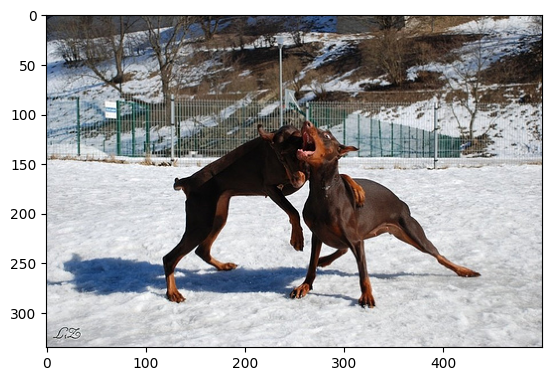

c:\Installations\miniconda3\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Installations\miniconda3\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Installations\miniconda3\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()

Referance Captions: 
Dog be in the snow in front of a fence .
Dog play on the snow .
Two brown dog playful fight in the snow .
Two brown dog wrestle in the snow .
Two dog play in the snow .
Predicted Caption: 
A dog run through the field .
bleu score:  1.4740564900137075e-231


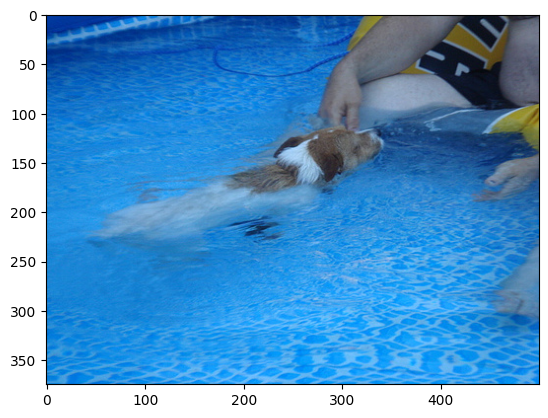

Referance Captions: 
a brown and white dog swim towards some in a pool
A dog in a swim pool swim toward sombody we cannot see .
A dog swim in a pool near a person .
Small dog be paddle through the water in a pool .
A small brown and white dog be in a pool .
Predicted Caption: 
A boy be be be be be be be be be be be be be be be be be be be be be be be be be be be be be be be be be be be be jump
bleu score:  8.669612184277444e-232


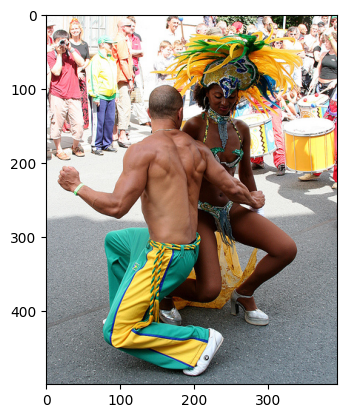

Referance Captions: 
A man and a woman in festive costume dance .
A man and a woman with feather on her head dance .
A man and a woman wear decorative costume and dance in a crowd of onlooker .
one performer wear a feathered headdress dance with another performer in street
Two person be dance with drum on the right and a crowd behind them .
Predicted Caption: 
A boy in a red shirt be be be be be be be be be be be be be be be be be be be be be be be be be be be sit on a fair .
bleu score:  3.962327745598725e-155


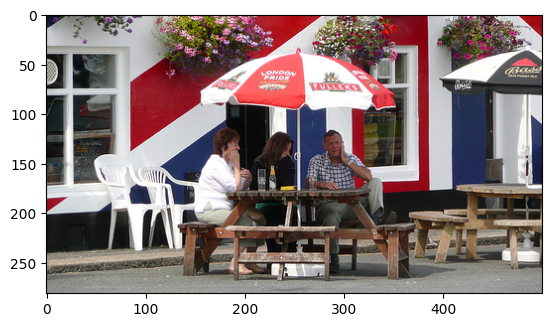

Referance Captions: 
A couple of person sit outdoors at a table with an umbrella and talk .
Three person be sit at an outside picnic bench with an umbrella .
Three person sit at an outdoor cafe .
Three person sit at an outdoor table in front of a building paint like the Union Jack .
Three person sit at a picnic table outside of a building paint like a union jack .
Predicted Caption: 
A man be sit on a green building .
bleu score:  8.014508691042773e-155


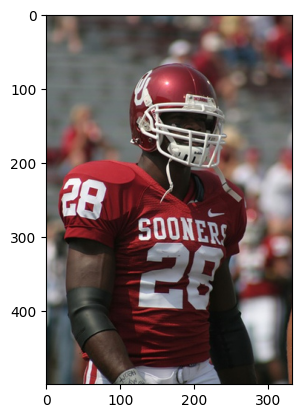

Referance Captions: 
A man be wear a Sooner red football shirt and helmet .
A Oklahoma Sooner football player wear his jersey number 28 .
A Sooner football player weas the number 28 and black armband .
Guy in red and white football uniform
The American footballer be wear a red and white strip .
Predicted Caption: 
A football player in a football player in the football .
bleu score:  7.49201355438059e-155


In [72]:
i=0

for img_id in test_features:
  i+=1
  img=cv2.imread(folder_path_images+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==5):
    break

## Calculating Average Bleu Score on Test Set using Greedy Search

In [73]:
i=0
tot_score=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score=tot_score/i
print()
print("Bleu score on Greedy search")
print("Score: ",avg_score)

100%|██████████| 1000/1000 [35:16<00:00,  2.12s/it] 


Bleu score on Greedy search
Score:  0.055944182426208515


## Beam Search Function

In [74]:
def beam_search(photo,k):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
  sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
  y_pred = model.predict([photo,sequence],verbose=0)
  predicted=[]
  y_pred=y_pred.reshape(-1)
  for i in range(y_pred.shape[0]):
    predicted.append((i,y_pred[i]))
  predicted=sorted(predicted,key=lambda x:x[1])[::-1]
  b_search=[]
  for i in range(k):
    word = indices_to_words[predicted[i][0]]
    b_search.append((in_text +' ' + word,predicted[i][1]))

  for idx in range(max_length):
    b_search_square=[]
    for text in b_search:
      if text[0].split(" ")[-1]=="<end>":
        break
      sequence = [words_to_indices[s] for s in text[0].split(" ") if s in words_to_indices]
      sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
      y_pred = model.predict([photo,sequence],verbose=0)
      predicted=[]
      y_pred=y_pred.reshape(-1)
      for i in range(y_pred.shape[0]):
        predicted.append((i,y_pred[i]))
      predicted=sorted(predicted,key=lambda x:x[1])[::-1]
      for i in range(k):
        word = indices_to_words[predicted[i][0]]
        b_search_square.append((text[0] +' ' + word,predicted[i][1]*text[1]))
    if(len(b_search_square)>0):
      b_search=(sorted(b_search_square,key=lambda x:x[1])[::-1])[:5]
  final=b_search[0][0].split()
  final = final[1:-1]
  #final=" ".join(final)
  return final

## Predicting Captions on Test Set using Beam Search with k=3

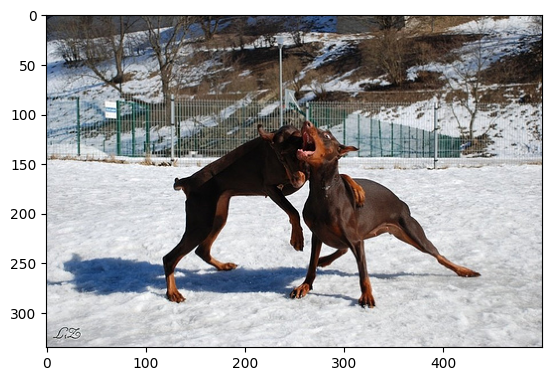

Referance Captions: 
Dog be in the snow in front of a fence .
Dog play on the snow .
Two brown dog playful fight in the snow .
Two brown dog wrestle in the snow .
Two dog play in the snow .
Predicted Caption: 
A black dog run through the field .
bleu score:  1.4256605770826504e-231


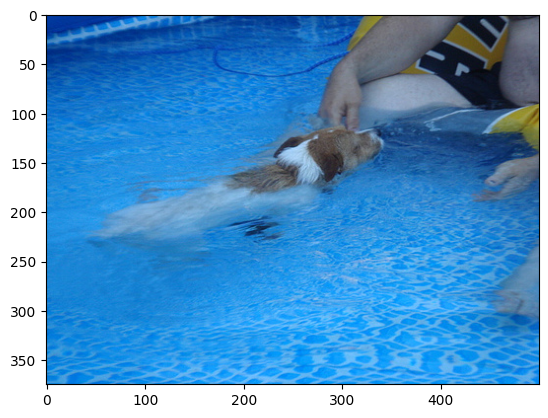

Referance Captions: 
a brown and white dog swim towards some in a pool
A dog in a swim pool swim toward sombody we cannot see .
A dog swim in a pool near a person .
Small dog be paddle through the water in a pool .
A small brown and white dog be in a pool .
Predicted Caption: 
A little boy in a black shirt be jump in the water .
bleu score:  8.16437745974496e-155


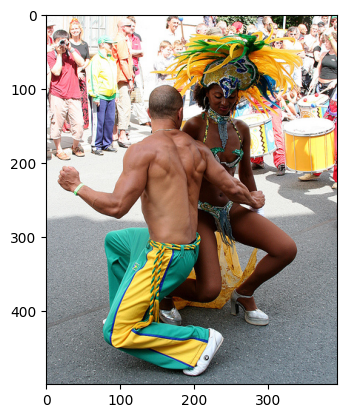

Referance Captions: 
A man and a woman in festive costume dance .
A man and a woman with feather on her head dance .
A man and a woman wear decorative costume and dance in a crowd of onlooker .
one performer wear a feathered headdress dance with another performer in street
Two person be dance with drum on the right and a crowd behind them .
Predicted Caption: 
A girl in a red shirt be sit on a beach .
bleu score:  7.15819034963064e-155


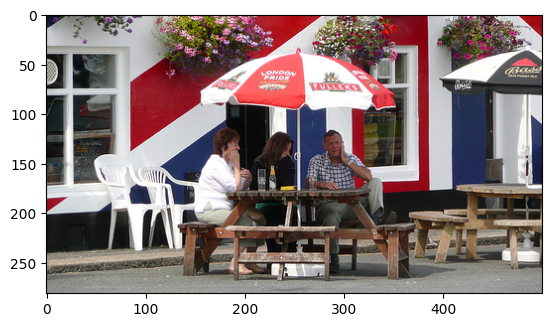

Referance Captions: 
A couple of person sit outdoors at a table with an umbrella and talk .
Three person be sit at an outside picnic bench with an umbrella .
Three person sit at an outdoor cafe .
Three person sit at an outdoor table in front of a building paint like the Union Jack .
Three person sit at a picnic table outside of a building paint like a union jack .
Predicted Caption: 
A man in a shirt be sit in a window .
bleu score:  6.246488163223622e-155


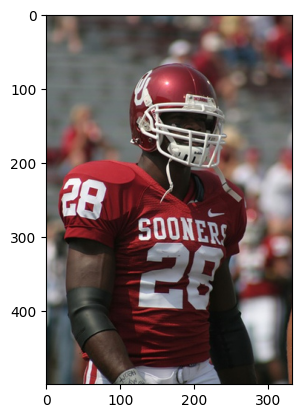

Referance Captions: 
A man be wear a Sooner red football shirt and helmet .
A Oklahoma Sooner football player wear his jersey number 28 .
A Sooner football player weas the number 28 and black armband .
Guy in red and white football uniform
The American footballer be wear a red and white strip .
Predicted Caption: 
A football player in the football .
bleu score:  9.170599044431425e-155


In [75]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread(folder_path_images+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=beam_search(photo,3)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==5):
    break

## Calculating Average Bleu Score on Test Set using Beam Search with k=3

In [76]:
i=0
tot_score=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=beam_search(photo,3)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score=tot_score/i
print()
print("Bleu score on Beam search with k=3")
print("Score: ",avg_score)

100%|██████████| 1000/1000 [1:27:56<00:00,  5.28s/it] 


Bleu score on Beam search with k=3
Score:  0.06746968099334019
